# AutoML: Data Science Made Really Easy

In [1]:
import pandas as pd
import featuretools as ft
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from hpsklearn import HyperoptEstimator, any_classifier
import numpy as np
from collections import defaultdict
import seaborn as sns
import pickle
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [2]:
train_df = pd.read_csv("data/train.csv")
train_df["Pclass"] = train_df["Pclass"].astype("category")
train_df['CabinClass'] = train_df["Cabin"].str.get(0)
train_df['LastName'] = train_df['Name'].str.split(", ").apply(lambda x: x[0])
train_df['Honorific'] = train_df['Name'].str.extract(" ([a-zA-z]+)")
train_df['TicketPrefix'] = train_df['Ticket'].str.extract("(.+) ")
train_df['TicketNumber'] = train_df['Ticket'].str.extract("([0-9]+)$").astype(float)
train_df = train_df.drop(columns=["Name", "Cabin", "Ticket"])
train_features = train_df.drop(columns=["Survived"])
train_target = train_df["Survived"]

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  import sys


In [3]:
train_df = train_df.drop(columns=["Name", "Cabin", "Ticket"])
train_features = train_df.drop(columns=["Survived"])
train_target = train_df["Survived"]

In [205]:
train_features.sample(5)

PassengerId Pclass     Sex   Age  SibSp  Parch     Fare Embarked  \
271          272      3    male  25.0      0      0   0.0000        S   
458          459      2  female  50.0      0      0  10.5000        S   
766          767      1    male   NaN      0      0  39.6000        C   
6              7      1    male  54.0      0      0  51.8625        S   
105          106      3    male  28.0      0      0   7.8958        S   

    CabinClass   LastName Honorific TicketPrefix  TicketNumber  
271        NaN  Tornquist        Mr          NaN           NaN  
458        NaN     Toomey      Miss       F.C.C.       13531.0  
766        NaN      Brewe        Dr          NaN      112379.0  
6            E   McCarthy        Mr          NaN       17463.0  
105        NaN    Mionoff        Mr          NaN      349207.0

In [207]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=train_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical,
                             "CabinClass": ft.variable_types.Categorical,
                             "LastName": ft.variable_types.Categorical,
                             "Honorific": ft.variable_types.Categorical,
                             "TicketPrefix": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="cabinclasses",
                index="CabinClass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="honorfics",
                index="Honorific")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="lastnames",
                index="LastName")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="ticketprefixes",
                index="TicketPrefix")

Entityset: titanic
  Entities:
    titanic (shape = [891, 13])
    classes (shape = [3, 1])
    sexes (shape = [2, 1])
    embarkeds (shape = [4, 1])
    cabinclasses (shape = [9, 1])
    ...And 3 more
  Relationships:
    titanic.Pclass -> classes.Pclass
    titanic.Sex -> sexes.Sex
    titanic.Embarked -> embarkeds.Embarked
    titanic.CabinClass -> cabinclasses.CabinClass
    titanic.Honorific -> honorfics.Honorific
    ...and 2 more

In [208]:
feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

Built 313 features
Elapsed: 00:16 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


In [209]:
imputer = Imputer(strategy='median')
imputed_matrix = imputer.fit_transform(feature_matrix)

In [210]:
model = "kitchen-sink"
name = f"100_{model}_titanic_dfs_fe"

estim = HyperoptEstimator(classifier=any_classifier(model),
                          max_evals=100,
                          trial_timeout=60,
                          fit_increment_dump_filename=f"results/models/{name}.pickle",
                          verbose=0,
                          seed=42
                          )

estim.fit(imputed_matrix,
          train_target,
          n_folds=5,    
          random_state=41,
          )

train_loss = estim.trials.best_trial["result"]["loss"]

print(train_loss)
print(estim.best_model())

with open(f"results/models/{train_loss:.3}_{name}_estimator.pickle", "wb+") as estimator:
    pickle.dump(estim, estimator)

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter

0.1571268237934904
{'learner': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005168273904849856, loss='deviance',
              max_depth=None, max_features=0.11598886784560192,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=156, presort='auto', random_state=4,
              subsample=0.6081704543206994, verbose=0, warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)),), 'ex_preprocs': ()}


In [211]:
trial_results = defaultdict(list)
for trial in range(0, 100):
    if 'loss' in estim.trials.trials[trial]['result']:
        trial_results['loss'].append(estim.trials.trials[trial]['result']['loss'])
        trial_results['loss_variance'].append(estim.trials.trials[0]['result']['loss_variance'])
    else:
        print(estim.trials.trials[trial]['result'])
        trial_results['loss'].append(None)
        trial_results['loss_variance'].append(None)
    for key, value in estim.trials.trials[trial]['misc']['idxs'].items():
        if value and "kitchen-sink." in key:
            trial_results['algorithm_type'].append(key.split(".")[1])
            break

{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}


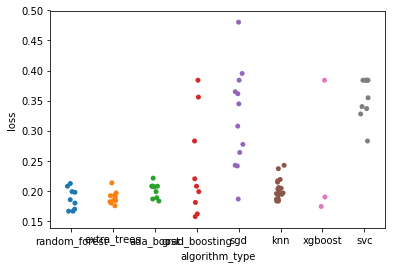

In [212]:
trial_df = pd.DataFrame(trial_results)
sns.stripplot(data = trial_df, x='algorithm_type', y='loss', jitter=True)

In [64]:
for property, value in vars(features[40]).items():
    print(property, ": ", value)

parent_entity :  Entity: sexes
  Variables:
    Sex (dtype: index)
  Shape:
    (2, 1)
_variable_type :  <class 'featuretools.variable_types.variable.Numeric'>
entity_id :  titanic
entityset :  Entityset: titanic
  Entities:
    titanic (shape = [891, 8])
    classes (shape = [3, 1])
    sexes (shape = [2, 1])
    embarkeds (shape = [4, 1])
  Relationships:
    titanic.Pclass -> classes.Pclass
    titanic.Sex -> sexes.Sex
    titanic.Embarked -> embarkeds.Embarked
base_features :  [<Feature: STD(titanic.Age)>]
additional_attributes :  {}


In [75]:
features[40]

<Feature: sexes.STD(titanic.Age)>

In [94]:
train_df.groupby("Sex").agg([np.nanmean, np.nanstd, np.nanmin, np.nanmax])

PassengerId                            Survived                   \
           nanmean      nanstd nanmin nanmax   nanmean    nanstd nanmin   
Sex                                                                       
female  431.028662  256.437007      2    889  0.742038  0.437513      0   
male    454.147314  257.262918      1    891  0.188908  0.391436      0   

                 Pclass              ...     SibSp            Parch            \
       nanmax   nanmean    nanstd    ...    nanmin nanmax   nanmean    nanstd   
Sex                                  ...                                        
female      1  2.159236  0.855924    ...         0      8  0.649682  1.021216   
male        1  2.389948  0.812875    ...         0      8  0.235702  0.611763   

                           Fare                              
       nanmin nanmax    nanmean     nanstd nanmin    nanmax  
Sex                                                          
female      0      6  44.479818  57.905271   6.75  512.3292  
male        0      5  25.523893  43.100865   0.00  512.3292  

[2 rows x 28 columns]

## Testing

In [214]:
test_df = pd.read_csv("data/test.csv")
test_df["Pclass"] = test_df["Pclass"].astype("category")

In [215]:
test_df['CabinClass'] = test_df["Cabin"].str.get(0)
test_df['LastName'] = test_df['Name'].str.split(", ").apply(lambda x: x[0])
test_df['Honorific'] = test_df['Name'].str.extract(" ([a-zA-z]+)")
test_df['TicketPrefix'] = test_df['Ticket'].str.extract("(.+) ")
test_df['TicketNumber'] = test_df['Ticket'].str.extract("([0-9]+)$").astype(float)
test_df = test_df.drop(columns=["Name", "Cabin", "Ticket"])

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


In [216]:
ft.save_features(features, "results/encoded_features.pkl")

In [217]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=test_df,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical})
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="cabinclasses",
                index="CabinClass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="honorfics",
                index="Honorific")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="lastnames",
                index="LastName")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="ticketprefixes",
                index="TicketPrefix")

test_features = ft.load_features("results/encoded_features.pkl", es)

In [218]:
test_matrix = ft.calculate_feature_matrix(test_features)

In [219]:
test_matrix = imputer.transform(test_matrix)

In [220]:
submission_df = pd.DataFrame({'PassengerId': test_df['PassengerId'],
              'Survived': estim.predict(test_matrix)})

In [222]:
submission_df.to_csv("results/ft_hpsklearn_submission_fe.csv", index=False)

## More Features

In [227]:
trial_df['algorithm_type'].unique()

array(['random_forest', 'extra_trees', 'ada_boost', 'grad_boosting',
       'sgd', 'knn', 'xgboost', 'svc'], dtype=object)

In [3]:
class FeaturetoolsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical_features, index, filepath, warm_start):
        self.categorical_features = categorical_features
        self.index = index
        self.filepath = filepath
        self.warm_start = warm_start
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        variable_types = {variable: ft.variable_types.Categorical for variable in self.categorical_features}
        es = ft.EntitySet(id="id")
        es.entity_from_dataframe(entity_id="id",
                                 dataframe=X,
                                 index=self.index,
                                 variable_types=variable_types)
        for variable in self.categorical_features:
            es.normalize_entity(base_entity_id="id",
                            new_entity_id=variable,
                            index=variable)
        self.es = es
        if self.warm_start:
            self.features = ft.load_features(self.filepath, self.es)
            matrix = ft.calculate_feature_matrix(self.features)
            return matrix
        else:
            matrix, self.features = ft.dfs(entityset=self.es,
                                      target_entity="id",
                                      save_progress="results/",
                                      verbose=False)
            
            matrix, self.features = ft.encode_features(matrix, self.features)
            self.warm_start = True
            ft.save_features(self.features, self.filepath)
            return matrix

In [ ]:
from hpsklearn import *
from sklearn.feature_selection import SelectFromModel

model_list = (sgd,
              knn,
              random_forest,
              xgboost_classification,
              extra_trees,
              ada_boost,
              gradient_boosting)

for model in model_list:
    name = f"100_{model.__name__}_titanic_dfs_ensemble_pipeline_cv10"
    
    estim = HyperoptEstimator(classifier=model(model.__name__),
                          max_evals=100,
                          trial_timeout=3600,
                          fit_increment_dump_filename=f"results/models/{name}.pickle",
                          verbose=1,
                          seed=42
                          )
    
    pipeline = Pipeline([
    ('featuretools', FeaturetoolsTransformer(
        categorical_features=["Pclass", "Sex", "Embarked", "CabinClass", 
                          "LastName", "Honorific", "TicketPrefix"],
    index = "PassengerId",
    filepath="results/sklearn_encoded_features.pkl",
    warm_start=False)),
    ('imputer', Imputer(strategy='median')),
    ('scaler', StandardScaler()),
#     ('featureselector', SelectFromModel(ExtraTreesClassifier()))
    ('model', estim)])

    pipeline.fit(train_features,
              train_target,
              model__n_folds=10)

    train_loss = estim.trials.best_trial["result"]["loss"]

    print(train_loss)
    print(estim.best_model())

    with open(f"results/models/{train_loss:.3}_{name}_estimator.pickle", "wb+") as estimator:
        pickle.dump(estim, estimator)

Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=3.914949966612521e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.009418182042605767, fit_intercept=True,
       l1_ratio=0.8627416131403061, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.14836193496459738, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=3.914949966612521e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.009418182042605767, fit_intercept=True,
       l1_ratio=0.8627416131403061, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.14836193496459738, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=3.914949966612521e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.009418182042605767, fit_intercept=True,
       l1_ratio=0.8627416131403061, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.14836193496459738, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.914949966612521e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.009418182042605767, fit_intercept=True,
       l1_ratio=0.8627416131403061, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.14836193496459738, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.914949966612521e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.009418182042605767, fit_intercept=True,
       l1_ratio=0.8627416131403061, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.14836193496459738, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.914949966612521e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.009418182042605767, fit_intercept=True,
       l1_ratio=0.8627416131403061, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.14836193496459738, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.914949966612521e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.009418182042605767, fit_intercept=True,
       l1_ratio=0.8627416131403061, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.14836193496459738, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.914949966612521e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.009418182042605767, fit_intercept=True,
       l1_ratio=0.8627416131403061, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.14836193496459738, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.914949966612521e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.009418182042605767, fit_intercept=True,
       l1_ratio=0.8627416131403061, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.14836193496459738, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.914949966612521e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.009418182042605767, fit_intercept=True,
       l1_ratio=0.8627416131403061, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.14836193496459738, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 75.1 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=4.30694268091752e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=6.633103016250423e-05, fit_intercept=True,
       l1_ratio=0.8666771922095983, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.8563720653419792, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=4.30694268091752e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=6.633103016250423e-05, fit_intercept=True,
       l1_ratio=0.8666771922095983, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.8563720653419792, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.30694268091752e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=6.633103016250423e-05, fit_intercept=True,
       l1_ratio=0.8666771922095983, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.8563720653419792, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.30694268091752e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=6.633103016250423e-05, fit_intercept=True,
       l1_ratio=0.8666771922095983, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.8563720653419792, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.30694268091752e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=6.633103016250423e-05, fit_intercept=True,
       l1_ratio=0.8666771922095983, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.8563720653419792, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.30694268091752e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=6.633103016250423e-05, fit_intercept=True,
       l1_ratio=0.8666771922095983, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.8563720653419792, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.30694268091752e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=6.633103016250423e-05, fit_intercept=True,
       l1_ratio=0.8666771922095983, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.8563720653419792, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.30694268091752e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=6.633103016250423e-05, fit_intercept=True,
       l1_ratio=0.8666771922095983, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.8563720653419792, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.30694268091752e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=6.633103016250423e-05, fit_intercept=True,
       l1_ratio=0.8666771922095983, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.8563720653419792, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=4.30694268091752e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=6.633103016250423e-05, fit_intercept=True,
       l1_ratio=0.8666771922095983, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.8563720653419792, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 79.0 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0010879399254361665, average=False, class_weight=None,
       epsilon=0.1, eta0=2.8462668825869812e-05, fit_intercept=True,
       l1_ratio=0.16955514078431388, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.63774909305133, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0010879399254361665, average=False, class_weight=None,
       epsilon=0.1, eta0=2.8462668825869812e-05, fit_intercept=True,
       l1_ratio=0.16955514078431388, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.63774909305133, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010879399254361665, average=False, class_weight=None,
       epsilon=0.1, eta0=2.8462668825869812e-05, fit_intercept=True,
       l1_ratio=0.16955514078431388, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.63774909305133, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010879399254361665, average=False, class_weight=None,
       epsilon=0.1, eta0=2.8462668825869812e-05, fit_intercept=True,
       l1_ratio=0.16955514078431388, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.63774909305133, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010879399254361665, average=False, class_weight=None,
       epsilon=0.1, eta0=2.8462668825869812e-05, fit_intercept=True,
       l1_ratio=0.16955514078431388, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.63774909305133, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010879399254361665, average=False, class_weight=None,
       epsilon=0.1, eta0=2.8462668825869812e-05, fit_intercept=True,
       l1_ratio=0.16955514078431388, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.63774909305133, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010879399254361665, average=False, class_weight=None,
       epsilon=0.1, eta0=2.8462668825869812e-05, fit_intercept=True,
       l1_ratio=0.16955514078431388, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.63774909305133, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010879399254361665, average=False, class_weight=None,
       epsilon=0.1, eta0=2.8462668825869812e-05, fit_intercept=True,
       l1_ratio=0.16955514078431388, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.63774909305133, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010879399254361665, average=False, class_weight=None,
       epsilon=0.1, eta0=2.8462668825869812e-05, fit_intercept=True,
       l1_ratio=0.16955514078431388, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.63774909305133, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 8
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0010879399254361665, average=False, class_weight=None,
       epsilon=0.1, eta0=2.8462668825869812e-05, fit_intercept=True,
       l1_ratio=0.16955514078431388, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.63774909305133, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 8)
OK trial with accuracy 78.8 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0032910740605434662, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001616675112842864, fit_intercept=True,
       l1_ratio=0.229170207361433, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.141592643549461, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0032910740605434662, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001616675112842864, fit_intercept=True,
       l1_ratio=0.229170207361433, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.141592643549461, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0032910740605434662, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001616675112842864, fit_intercept=True,
       l1_ratio=0.229170207361433, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.141592643549461, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0032910740605434662, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001616675112842864, fit_intercept=True,
       l1_ratio=0.229170207361433, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.141592643549461, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0032910740605434662, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001616675112842864, fit_intercept=True,
       l1_ratio=0.229170207361433, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.141592643549461, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0032910740605434662, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001616675112842864, fit_intercept=True,
       l1_ratio=0.229170207361433, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.141592643549461, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0032910740605434662, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001616675112842864, fit_intercept=True,
       l1_ratio=0.229170207361433, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.141592643549461, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0032910740605434662, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001616675112842864, fit_intercept=True,
       l1_ratio=0.229170207361433, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.141592643549461, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0032910740605434662, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001616675112842864, fit_intercept=True,
       l1_ratio=0.229170207361433, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.141592643549461, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0032910740605434662, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001616675112842864, fit_intercept=True,
       l1_ratio=0.229170207361433, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.141592643549461, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 69.2 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=9.941435381140008e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0003525178046800442,
       fit_intercept=True, l1_ratio=0.9119288615068835,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5980470775121279,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=9.941435381140008e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0003525178046800442,
       fit_intercept=True, l1_ratio=0.9119288615068835,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5980470775121279,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=9.941435381140008e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0003525178046800442,
       fit_intercept=True, l1_ratio=0.9119288615068835,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5980470775121279,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=9.941435381140008e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0003525178046800442,
       fit_intercept=True, l1_ratio=0.9119288615068835,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5980470775121279,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=9.941435381140008e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0003525178046800442,
       fit_intercept=True, l1_ratio=0.9119288615068835,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5980470775121279,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=9.941435381140008e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0003525178046800442,
       fit_intercept=True, l1_ratio=0.9119288615068835,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5980470775121279,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=9.941435381140008e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0003525178046800442,
       fit_intercept=True, l1_ratio=0.9119288615068835,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5980470775121279,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=9.941435381140008e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0003525178046800442,
       fit_intercept=True, l1_ratio=0.9119288615068835,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5980470775121279,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=9.941435381140008e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0003525178046800442,
       fit_intercept=True, l1_ratio=0.9119288615068835,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5980470775121279,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=9.941435381140008e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0003525178046800442,
       fit_intercept=True, l1_ratio=0.9119288615068835,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5980470775121279,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 77.8 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0005027318420766672, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.003991502512609638,
       fit_intercept=True, l1_ratio=0.42417807246068195,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='elasticnet', power_t=0.43802918644092326,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0005027318420766672, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.003991502512609638,
       fit_intercept=True, l1_ratio=0.42417807246068195,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='elasticnet', power_t=0.43802918644092326,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005027318420766672, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.003991502512609638,
       fit_intercept=True, l1_ratio=0.42417807246068195,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='elasticnet', power_t=0.43802918644092326,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005027318420766672, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.003991502512609638,
       fit_intercept=True, l1_ratio=0.42417807246068195,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='elasticnet', power_t=0.43802918644092326,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005027318420766672, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.003991502512609638,
       fit_intercept=True, l1_ratio=0.42417807246068195,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='elasticnet', power_t=0.43802918644092326,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005027318420766672, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.003991502512609638,
       fit_intercept=True, l1_ratio=0.42417807246068195,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='elasticnet', power_t=0.43802918644092326,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005027318420766672, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.003991502512609638,
       fit_intercept=True, l1_ratio=0.42417807246068195,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='elasticnet', power_t=0.43802918644092326,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005027318420766672, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.003991502512609638,
       fit_intercept=True, l1_ratio=0.42417807246068195,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='elasticnet', power_t=0.43802918644092326,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005027318420766672, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.003991502512609638,
       fit_intercept=True, l1_ratio=0.42417807246068195,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='elasticnet', power_t=0.43802918644092326,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0005027318420766672, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.003991502512609638,
       fit_intercept=True, l1_ratio=0.42417807246068195,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='elasticnet', power_t=0.43802918644092326,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 77.6 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00047187373053254, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00015798984911795301,
       fit_intercept=True, l1_ratio=0.9827824188216013,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.8623661170852909, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00047187373053254, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00015798984911795301,
       fit_intercept=True, l1_ratio=0.9827824188216013,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.8623661170852909, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00047187373053254, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00015798984911795301,
       fit_intercept=True, l1_ratio=0.9827824188216013,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.8623661170852909, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00047187373053254, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00015798984911795301,
       fit_intercept=True, l1_ratio=0.9827824188216013,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.8623661170852909, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00047187373053254, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00015798984911795301,
       fit_intercept=True, l1_ratio=0.9827824188216013,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.8623661170852909, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00047187373053254, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00015798984911795301,
       fit_intercept=True, l1_ratio=0.9827824188216013,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.8623661170852909, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00047187373053254, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00015798984911795301,
       fit_intercept=True, l1_ratio=0.9827824188216013,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.8623661170852909, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00047187373053254, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00015798984911795301,
       fit_intercept=True, l1_ratio=0.9827824188216013,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.8623661170852909, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00047187373053254, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00015798984911795301,
       fit_intercept=True, l1_ratio=0.9827824188216013,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.8623661170852909, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.00047187373053254, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00015798984911795301,
       fit_intercept=True, l1_ratio=0.9827824188216013,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.8623661170852909, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 78.1 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.00016395027551638607, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.04978809076337571,
       fit_intercept=True, l1_ratio=0.6342995711432995,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7753643788278823, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.00016395027551638607, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.04978809076337571,
       fit_intercept=True, l1_ratio=0.6342995711432995,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7753643788278823, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.00016395027551638607, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.04978809076337571,
       fit_intercept=True, l1_ratio=0.6342995711432995,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7753643788278823, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00016395027551638607, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.04978809076337571,
       fit_intercept=True, l1_ratio=0.6342995711432995,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7753643788278823, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00016395027551638607, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.04978809076337571,
       fit_intercept=True, l1_ratio=0.6342995711432995,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7753643788278823, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00016395027551638607, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.04978809076337571,
       fit_intercept=True, l1_ratio=0.6342995711432995,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7753643788278823, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00016395027551638607, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.04978809076337571,
       fit_intercept=True, l1_ratio=0.6342995711432995,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7753643788278823, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00016395027551638607, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.04978809076337571,
       fit_intercept=True, l1_ratio=0.6342995711432995,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7753643788278823, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00016395027551638607, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.04978809076337571,
       fit_intercept=True, l1_ratio=0.6342995711432995,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7753643788278823, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00016395027551638607, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.04978809076337571,
       fit_intercept=True, l1_ratio=0.6342995711432995,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7753643788278823, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 80.1 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=8.484923965913391e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02975610615934554, fit_intercept=True,
       l1_ratio=0.6168279392330184, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.13362394958741386, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=8.484923965913391e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02975610615934554, fit_intercept=True,
       l1_ratio=0.6168279392330184, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.13362394958741386, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.484923965913391e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02975610615934554, fit_intercept=True,
       l1_ratio=0.6168279392330184, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.13362394958741386, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.484923965913391e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02975610615934554, fit_intercept=True,
       l1_ratio=0.6168279392330184, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.13362394958741386, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.484923965913391e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02975610615934554, fit_intercept=True,
       l1_ratio=0.6168279392330184, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.13362394958741386, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.484923965913391e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02975610615934554, fit_intercept=True,
       l1_ratio=0.6168279392330184, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.13362394958741386, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.484923965913391e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02975610615934554, fit_intercept=True,
       l1_ratio=0.6168279392330184, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.13362394958741386, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.484923965913391e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02975610615934554, fit_intercept=True,
       l1_ratio=0.6168279392330184, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.13362394958741386, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.484923965913391e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02975610615934554, fit_intercept=True,
       l1_ratio=0.6168279392330184, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.13362394958741386, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 8
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=8.484923965913391e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02975610615934554, fit_intercept=True,
       l1_ratio=0.6168279392330184, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.13362394958741386, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 8)
OK trial with accuracy 66.0 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.006868971031789913, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0002590456695268595, fit_intercept=True,
       l1_ratio=0.9566602229653217, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.4765336565719652, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.006868971031789913, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0002590456695268595, fit_intercept=True,
       l1_ratio=0.9566602229653217, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.4765336565719652, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006868971031789913, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0002590456695268595, fit_intercept=True,
       l1_ratio=0.9566602229653217, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.4765336565719652, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006868971031789913, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0002590456695268595, fit_intercept=True,
       l1_ratio=0.9566602229653217, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.4765336565719652, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006868971031789913, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0002590456695268595, fit_intercept=True,
       l1_ratio=0.9566602229653217, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.4765336565719652, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006868971031789913, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0002590456695268595, fit_intercept=True,
       l1_ratio=0.9566602229653217, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.4765336565719652, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006868971031789913, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0002590456695268595, fit_intercept=True,
       l1_ratio=0.9566602229653217, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.4765336565719652, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006868971031789913, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0002590456695268595, fit_intercept=True,
       l1_ratio=0.9566602229653217, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.4765336565719652, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006868971031789913, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0002590456695268595, fit_intercept=True,
       l1_ratio=0.9566602229653217, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.4765336565719652, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.006868971031789913, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0002590456695268595, fit_intercept=True,
       l1_ratio=0.9566602229653217, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.4765336565719652, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 78.6 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.005842607592225996, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01041304539819787,
       fit_intercept=True, l1_ratio=0.7505547023850534,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5916735590832681, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.005842607592225996, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01041304539819787,
       fit_intercept=True, l1_ratio=0.7505547023850534,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5916735590832681, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.005842607592225996, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01041304539819787,
       fit_intercept=True, l1_ratio=0.7505547023850534,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5916735590832681, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.005842607592225996, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01041304539819787,
       fit_intercept=True, l1_ratio=0.7505547023850534,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5916735590832681, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.005842607592225996, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01041304539819787,
       fit_intercept=True, l1_ratio=0.7505547023850534,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5916735590832681, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.005842607592225996, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01041304539819787,
       fit_intercept=True, l1_ratio=0.7505547023850534,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5916735590832681, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.005842607592225996, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01041304539819787,
       fit_intercept=True, l1_ratio=0.7505547023850534,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5916735590832681, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.005842607592225996, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01041304539819787,
       fit_intercept=True, l1_ratio=0.7505547023850534,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5916735590832681, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.005842607592225996, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01041304539819787,
       fit_intercept=True, l1_ratio=0.7505547023850534,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5916735590832681, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.005842607592225996, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01041304539819787,
       fit_intercept=True, l1_ratio=0.7505547023850534,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5916735590832681, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 71.6 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=4.339789445056111e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=3.664485240240974e-05, fit_intercept=True,
       l1_ratio=0.6982374787367077, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.38298592983545, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=4.339789445056111e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=3.664485240240974e-05, fit_intercept=True,
       l1_ratio=0.6982374787367077, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.38298592983545, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.339789445056111e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=3.664485240240974e-05, fit_intercept=True,
       l1_ratio=0.6982374787367077, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.38298592983545, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.339789445056111e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=3.664485240240974e-05, fit_intercept=True,
       l1_ratio=0.6982374787367077, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.38298592983545, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.339789445056111e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=3.664485240240974e-05, fit_intercept=True,
       l1_ratio=0.6982374787367077, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.38298592983545, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.339789445056111e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=3.664485240240974e-05, fit_intercept=True,
       l1_ratio=0.6982374787367077, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.38298592983545, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.339789445056111e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=3.664485240240974e-05, fit_intercept=True,
       l1_ratio=0.6982374787367077, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.38298592983545, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.339789445056111e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=3.664485240240974e-05, fit_intercept=True,
       l1_ratio=0.6982374787367077, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.38298592983545, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.339789445056111e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=3.664485240240974e-05, fit_intercept=True,
       l1_ratio=0.6982374787367077, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.38298592983545, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 4
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=4.339789445056111e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=3.664485240240974e-05, fit_intercept=True,
       l1_ratio=0.6982374787367077, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.38298592983545, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 4)
OK trial with accuracy 78.7 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.01383466048132816, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00021224417873725622,
       fit_intercept=True, l1_ratio=0.37627173375900025,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.4957285024766487,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.01383466048132816, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00021224417873725622,
       fit_intercept=True, l1_ratio=0.37627173375900025,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.4957285024766487,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.01383466048132816, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00021224417873725622,
       fit_intercept=True, l1_ratio=0.37627173375900025,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.4957285024766487,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.01383466048132816, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00021224417873725622,
       fit_intercept=True, l1_ratio=0.37627173375900025,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.4957285024766487,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.01383466048132816, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00021224417873725622,
       fit_intercept=True, l1_ratio=0.37627173375900025,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.4957285024766487,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.01383466048132816, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00021224417873725622,
       fit_intercept=True, l1_ratio=0.37627173375900025,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.4957285024766487,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.01383466048132816, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00021224417873725622,
       fit_intercept=True, l1_ratio=0.37627173375900025,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.4957285024766487,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.01383466048132816, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00021224417873725622,
       fit_intercept=True, l1_ratio=0.37627173375900025,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.4957285024766487,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.01383466048132816, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00021224417873725622,
       fit_intercept=True, l1_ratio=0.37627173375900025,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.4957285024766487,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.01383466048132816, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00021224417873725622,
       fit_intercept=True, l1_ratio=0.37627173375900025,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.4957285024766487,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 80.6 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 12
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.02135818590749378, average=False,
       class_weight='balanced', epsilon=0.1, eta0=6.78774086514741e-05,
       fit_intercept=True, l1_ratio=0.18697868723768973,
       learning_rate='invscaling', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.8022664041309284, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 12)
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 12
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.02135818590749378, average=False,
       class_weight='balanced', epsilon=0.1, eta0=6.78774086514741e-05,
       fit_intercept=True, l1_ratio=0.18697868723768973,
       learning_rate='invscaling', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.8022664041309284, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 12)
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02135818590749378, average=False,
       class_weight='balanced', epsilon=0.1, eta0=6.78774086514741e-05,
       fit_intercept=True, l1_ratio=0.18697868723768973,
       learning_rate='invscaling', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.8022664041309284, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 12)
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02135818590749378, average=False,
       class_weight='balanced', epsilon=0.1, eta0=6.78774086514741e-05,
       fit_intercept=True, l1_ratio=0.18697868723768973,
       learning_rate='invscaling', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.8022664041309284, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 12)
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02135818590749378, average=False,
       class_weight='balanced', epsilon=0.1, eta0=6.78774086514741e-05,
       fit_intercept=True, l1_ratio=0.18697868723768973,
       learning_rate='invscaling', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.8022664041309284, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 12)
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02135818590749378, average=False,
       class_weight='balanced', epsilon=0.1, eta0=6.78774086514741e-05,
       fit_intercept=True, l1_ratio=0.18697868723768973,
       learning_rate='invscaling', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.8022664041309284, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 12)
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02135818590749378, average=False,
       class_weight='balanced', epsilon=0.1, eta0=6.78774086514741e-05,
       fit_intercept=True, l1_ratio=0.18697868723768973,
       learning_rate='invscaling', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.8022664041309284, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 12)
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02135818590749378, average=False,
       class_weight='balanced', epsilon=0.1, eta0=6.78774086514741e-05,
       fit_intercept=True, l1_ratio=0.18697868723768973,
       learning_rate='invscaling', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.8022664041309284, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 12)
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02135818590749378, average=False,
       class_weight='balanced', epsilon=0.1, eta0=6.78774086514741e-05,
       fit_intercept=True, l1_ratio=0.18697868723768973,
       learning_rate='invscaling', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.8022664041309284, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 12)
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 12
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.02135818590749378, average=False,
       class_weight='balanced', epsilon=0.1, eta0=6.78774086514741e-05,
       fit_intercept=True, l1_ratio=0.18697868723768973,
       learning_rate='invscaling', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.8022664041309284, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 12)
OK trial with accuracy 77.4 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.09859743030870081, average=False,
       class_weight='balanced', epsilon=0.1, eta0=9.530763226647171e-05,
       fit_intercept=True, l1_ratio=0.9666891369096554,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.35642687917487115, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.09859743030870081, average=False,
       class_weight='balanced', epsilon=0.1, eta0=9.530763226647171e-05,
       fit_intercept=True, l1_ratio=0.9666891369096554,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.35642687917487115, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.09859743030870081, average=False,
       class_weight='balanced', epsilon=0.1, eta0=9.530763226647171e-05,
       fit_intercept=True, l1_ratio=0.9666891369096554,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.35642687917487115, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.09859743030870081, average=False,
       class_weight='balanced', epsilon=0.1, eta0=9.530763226647171e-05,
       fit_intercept=True, l1_ratio=0.9666891369096554,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.35642687917487115, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.09859743030870081, average=False,
       class_weight='balanced', epsilon=0.1, eta0=9.530763226647171e-05,
       fit_intercept=True, l1_ratio=0.9666891369096554,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.35642687917487115, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.09859743030870081, average=False,
       class_weight='balanced', epsilon=0.1, eta0=9.530763226647171e-05,
       fit_intercept=True, l1_ratio=0.9666891369096554,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.35642687917487115, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.09859743030870081, average=False,
       class_weight='balanced', epsilon=0.1, eta0=9.530763226647171e-05,
       fit_intercept=True, l1_ratio=0.9666891369096554,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.35642687917487115, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.09859743030870081, average=False,
       class_weight='balanced', epsilon=0.1, eta0=9.530763226647171e-05,
       fit_intercept=True, l1_ratio=0.9666891369096554,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.35642687917487115, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.09859743030870081, average=False,
       class_weight='balanced', epsilon=0.1, eta0=9.530763226647171e-05,
       fit_intercept=True, l1_ratio=0.9666891369096554,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.35642687917487115, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.09859743030870081, average=False,
       class_weight='balanced', epsilon=0.1, eta0=9.530763226647171e-05,
       fit_intercept=True, l1_ratio=0.9666891369096554,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.35642687917487115, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 74.9 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.002501820982184132, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004524775771433096,
       fit_intercept=True, l1_ratio=0.07663780764024486,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.10382932156331837, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.002501820982184132, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004524775771433096,
       fit_intercept=True, l1_ratio=0.07663780764024486,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.10382932156331837, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.002501820982184132, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004524775771433096,
       fit_intercept=True, l1_ratio=0.07663780764024486,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.10382932156331837, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.002501820982184132, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004524775771433096,
       fit_intercept=True, l1_ratio=0.07663780764024486,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.10382932156331837, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.002501820982184132, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004524775771433096,
       fit_intercept=True, l1_ratio=0.07663780764024486,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.10382932156331837, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.002501820982184132, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004524775771433096,
       fit_intercept=True, l1_ratio=0.07663780764024486,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.10382932156331837, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.002501820982184132, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004524775771433096,
       fit_intercept=True, l1_ratio=0.07663780764024486,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.10382932156331837, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.002501820982184132, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004524775771433096,
       fit_intercept=True, l1_ratio=0.07663780764024486,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.10382932156331837, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.002501820982184132, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004524775771433096,
       fit_intercept=True, l1_ratio=0.07663780764024486,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.10382932156331837, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 8
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.002501820982184132, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004524775771433096,
       fit_intercept=True, l1_ratio=0.07663780764024486,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.10382932156331837, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 8)
OK trial with accuracy 68.5 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0005578228774016465, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.2593248815129635e-05,
       fit_intercept=True, l1_ratio=0.12371659682965896,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.12470065927231533, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0005578228774016465, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.2593248815129635e-05,
       fit_intercept=True, l1_ratio=0.12371659682965896,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.12470065927231533, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005578228774016465, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.2593248815129635e-05,
       fit_intercept=True, l1_ratio=0.12371659682965896,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.12470065927231533, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005578228774016465, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.2593248815129635e-05,
       fit_intercept=True, l1_ratio=0.12371659682965896,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.12470065927231533, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005578228774016465, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.2593248815129635e-05,
       fit_intercept=True, l1_ratio=0.12371659682965896,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.12470065927231533, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005578228774016465, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.2593248815129635e-05,
       fit_intercept=True, l1_ratio=0.12371659682965896,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.12470065927231533, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005578228774016465, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.2593248815129635e-05,
       fit_intercept=True, l1_ratio=0.12371659682965896,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.12470065927231533, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005578228774016465, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.2593248815129635e-05,
       fit_intercept=True, l1_ratio=0.12371659682965896,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.12470065927231533, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005578228774016465, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.2593248815129635e-05,
       fit_intercept=True, l1_ratio=0.12371659682965896,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.12470065927231533, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0005578228774016465, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.2593248815129635e-05,
       fit_intercept=True, l1_ratio=0.12371659682965896,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.12470065927231533, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 47.4 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=4.126847635540394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=1.4942472818794297e-05, fit_intercept=True,
       l1_ratio=0.9077011546611603, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.4020586139041119, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=4.126847635540394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=1.4942472818794297e-05, fit_intercept=True,
       l1_ratio=0.9077011546611603, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.4020586139041119, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=4.126847635540394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=1.4942472818794297e-05, fit_intercept=True,
       l1_ratio=0.9077011546611603, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.4020586139041119, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=4.126847635540394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=1.4942472818794297e-05, fit_intercept=True,
       l1_ratio=0.9077011546611603, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.4020586139041119, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=4.126847635540394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=1.4942472818794297e-05, fit_intercept=True,
       l1_ratio=0.9077011546611603, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.4020586139041119, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=4.126847635540394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=1.4942472818794297e-05, fit_intercept=True,
       l1_ratio=0.9077011546611603, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.4020586139041119, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=4.126847635540394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=1.4942472818794297e-05, fit_intercept=True,
       l1_ratio=0.9077011546611603, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.4020586139041119, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=4.126847635540394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=1.4942472818794297e-05, fit_intercept=True,
       l1_ratio=0.9077011546611603, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.4020586139041119, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=4.126847635540394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=1.4942472818794297e-05, fit_intercept=True,
       l1_ratio=0.9077011546611603, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.4020586139041119, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=4.126847635540394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=1.4942472818794297e-05, fit_intercept=True,
       l1_ratio=0.9077011546611603, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.4020586139041119, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 74.7 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.006151355589138041, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0004957171406345978, fit_intercept=True,
       l1_ratio=0.6754352447062246, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.6946896343853821, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.006151355589138041, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0004957171406345978, fit_intercept=True,
       l1_ratio=0.6754352447062246, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.6946896343853821, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.006151355589138041, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0004957171406345978, fit_intercept=True,
       l1_ratio=0.6754352447062246, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.6946896343853821, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.006151355589138041, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0004957171406345978, fit_intercept=True,
       l1_ratio=0.6754352447062246, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.6946896343853821, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.006151355589138041, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0004957171406345978, fit_intercept=True,
       l1_ratio=0.6754352447062246, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.6946896343853821, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.006151355589138041, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0004957171406345978, fit_intercept=True,
       l1_ratio=0.6754352447062246, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.6946896343853821, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.006151355589138041, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0004957171406345978, fit_intercept=True,
       l1_ratio=0.6754352447062246, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.6946896343853821, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.006151355589138041, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0004957171406345978, fit_intercept=True,
       l1_ratio=0.6754352447062246, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.6946896343853821, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.006151355589138041, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0004957171406345978, fit_intercept=True,
       l1_ratio=0.6754352447062246, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.6946896343853821, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.006151355589138041, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0004957171406345978, fit_intercept=True,
       l1_ratio=0.6754352447062246, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.6946896343853821, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 75.3 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=3.542270009673128e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007178769693029203, fit_intercept=True,
       l1_ratio=0.6928380831473012, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6122358953588597, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=3.542270009673128e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007178769693029203, fit_intercept=True,
       l1_ratio=0.6928380831473012, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6122358953588597, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=3.542270009673128e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007178769693029203, fit_intercept=True,
       l1_ratio=0.6928380831473012, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6122358953588597, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.542270009673128e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007178769693029203, fit_intercept=True,
       l1_ratio=0.6928380831473012, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6122358953588597, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.542270009673128e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007178769693029203, fit_intercept=True,
       l1_ratio=0.6928380831473012, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6122358953588597, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.542270009673128e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007178769693029203, fit_intercept=True,
       l1_ratio=0.6928380831473012, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6122358953588597, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.542270009673128e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007178769693029203, fit_intercept=True,
       l1_ratio=0.6928380831473012, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6122358953588597, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.542270009673128e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007178769693029203, fit_intercept=True,
       l1_ratio=0.6928380831473012, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6122358953588597, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.542270009673128e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007178769693029203, fit_intercept=True,
       l1_ratio=0.6928380831473012, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6122358953588597, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.542270009673128e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007178769693029203, fit_intercept=True,
       l1_ratio=0.6928380831473012, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6122358953588597, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 73.7 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.05720729495397724, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02830827444334979, fit_intercept=True,
       l1_ratio=0.8073091175652732, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.13494357998109163, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.05720729495397724, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02830827444334979, fit_intercept=True,
       l1_ratio=0.8073091175652732, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.13494357998109163, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.05720729495397724, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02830827444334979, fit_intercept=True,
       l1_ratio=0.8073091175652732, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.13494357998109163, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.05720729495397724, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02830827444334979, fit_intercept=True,
       l1_ratio=0.8073091175652732, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.13494357998109163, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.05720729495397724, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02830827444334979, fit_intercept=True,
       l1_ratio=0.8073091175652732, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.13494357998109163, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.05720729495397724, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02830827444334979, fit_intercept=True,
       l1_ratio=0.8073091175652732, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.13494357998109163, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.05720729495397724, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02830827444334979, fit_intercept=True,
       l1_ratio=0.8073091175652732, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.13494357998109163, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.05720729495397724, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02830827444334979, fit_intercept=True,
       l1_ratio=0.8073091175652732, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.13494357998109163, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.05720729495397724, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02830827444334979, fit_intercept=True,
       l1_ratio=0.8073091175652732, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.13494357998109163, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.05720729495397724, average=False, class_weight=None,
       epsilon=0.1, eta0=0.02830827444334979, fit_intercept=True,
       l1_ratio=0.8073091175652732, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.13494357998109163, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 79.0 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.013750084201842405, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00015084006155497654, fit_intercept=True,
       l1_ratio=0.33416058909090074, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.6325441086231123, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.013750084201842405, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00015084006155497654, fit_intercept=True,
       l1_ratio=0.33416058909090074, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.6325441086231123, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013750084201842405, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00015084006155497654, fit_intercept=True,
       l1_ratio=0.33416058909090074, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.6325441086231123, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013750084201842405, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00015084006155497654, fit_intercept=True,
       l1_ratio=0.33416058909090074, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.6325441086231123, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013750084201842405, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00015084006155497654, fit_intercept=True,
       l1_ratio=0.33416058909090074, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.6325441086231123, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013750084201842405, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00015084006155497654, fit_intercept=True,
       l1_ratio=0.33416058909090074, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.6325441086231123, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013750084201842405, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00015084006155497654, fit_intercept=True,
       l1_ratio=0.33416058909090074, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.6325441086231123, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013750084201842405, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00015084006155497654, fit_intercept=True,
       l1_ratio=0.33416058909090074, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.6325441086231123, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013750084201842405, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00015084006155497654, fit_intercept=True,
       l1_ratio=0.33416058909090074, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.6325441086231123, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.013750084201842405, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00015084006155497654, fit_intercept=True,
       l1_ratio=0.33416058909090074, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.6325441086231123, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 76.0 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.1302448097721568e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0029066773091156912,
       fit_intercept=True, l1_ratio=0.045024188798325704,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5932653223463626, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.1302448097721568e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0029066773091156912,
       fit_intercept=True, l1_ratio=0.045024188798325704,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5932653223463626, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1302448097721568e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0029066773091156912,
       fit_intercept=True, l1_ratio=0.045024188798325704,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5932653223463626, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1302448097721568e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0029066773091156912,
       fit_intercept=True, l1_ratio=0.045024188798325704,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5932653223463626, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1302448097721568e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0029066773091156912,
       fit_intercept=True, l1_ratio=0.045024188798325704,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5932653223463626, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1302448097721568e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0029066773091156912,
       fit_intercept=True, l1_ratio=0.045024188798325704,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5932653223463626, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1302448097721568e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0029066773091156912,
       fit_intercept=True, l1_ratio=0.045024188798325704,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5932653223463626, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1302448097721568e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0029066773091156912,
       fit_intercept=True, l1_ratio=0.045024188798325704,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5932653223463626, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1302448097721568e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0029066773091156912,
       fit_intercept=True, l1_ratio=0.045024188798325704,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5932653223463626, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=1.1302448097721568e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0029066773091156912,
       fit_intercept=True, l1_ratio=0.045024188798325704,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5932653223463626, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 51.2 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.008945205922623295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.167050452035721e-05,
       fit_intercept=True, l1_ratio=0.5157974357584518,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7245421197672818, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.008945205922623295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.167050452035721e-05,
       fit_intercept=True, l1_ratio=0.5157974357584518,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7245421197672818, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008945205922623295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.167050452035721e-05,
       fit_intercept=True, l1_ratio=0.5157974357584518,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7245421197672818, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008945205922623295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.167050452035721e-05,
       fit_intercept=True, l1_ratio=0.5157974357584518,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7245421197672818, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008945205922623295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.167050452035721e-05,
       fit_intercept=True, l1_ratio=0.5157974357584518,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7245421197672818, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008945205922623295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.167050452035721e-05,
       fit_intercept=True, l1_ratio=0.5157974357584518,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7245421197672818, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008945205922623295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.167050452035721e-05,
       fit_intercept=True, l1_ratio=0.5157974357584518,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7245421197672818, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008945205922623295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.167050452035721e-05,
       fit_intercept=True, l1_ratio=0.5157974357584518,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7245421197672818, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008945205922623295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.167050452035721e-05,
       fit_intercept=True, l1_ratio=0.5157974357584518,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7245421197672818, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.008945205922623295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.167050452035721e-05,
       fit_intercept=True, l1_ratio=0.5157974357584518,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7245421197672818, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 38.4 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.013115735901223818, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.018297144276995133,
       fit_intercept=True, l1_ratio=0.9043071393826516,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.17502197356256444,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.013115735901223818, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.018297144276995133,
       fit_intercept=True, l1_ratio=0.9043071393826516,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.17502197356256444,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013115735901223818, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.018297144276995133,
       fit_intercept=True, l1_ratio=0.9043071393826516,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.17502197356256444,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013115735901223818, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.018297144276995133,
       fit_intercept=True, l1_ratio=0.9043071393826516,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.17502197356256444,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013115735901223818, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.018297144276995133,
       fit_intercept=True, l1_ratio=0.9043071393826516,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.17502197356256444,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013115735901223818, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.018297144276995133,
       fit_intercept=True, l1_ratio=0.9043071393826516,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.17502197356256444,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013115735901223818, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.018297144276995133,
       fit_intercept=True, l1_ratio=0.9043071393826516,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.17502197356256444,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013115735901223818, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.018297144276995133,
       fit_intercept=True, l1_ratio=0.9043071393826516,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.17502197356256444,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013115735901223818, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.018297144276995133,
       fit_intercept=True, l1_ratio=0.9043071393826516,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.17502197356256444,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.013115735901223818, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.018297144276995133,
       fit_intercept=True, l1_ratio=0.9043071393826516,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.17502197356256444,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 80.7 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.07551464836616642, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.460727925522049e-05,
       fit_intercept=True, l1_ratio=0.20862477232044063,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7765036918566556,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.07551464836616642, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.460727925522049e-05,
       fit_intercept=True, l1_ratio=0.20862477232044063,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7765036918566556,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.07551464836616642, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.460727925522049e-05,
       fit_intercept=True, l1_ratio=0.20862477232044063,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7765036918566556,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.07551464836616642, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.460727925522049e-05,
       fit_intercept=True, l1_ratio=0.20862477232044063,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7765036918566556,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.07551464836616642, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.460727925522049e-05,
       fit_intercept=True, l1_ratio=0.20862477232044063,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7765036918566556,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.07551464836616642, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.460727925522049e-05,
       fit_intercept=True, l1_ratio=0.20862477232044063,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7765036918566556,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.07551464836616642, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.460727925522049e-05,
       fit_intercept=True, l1_ratio=0.20862477232044063,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7765036918566556,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.07551464836616642, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.460727925522049e-05,
       fit_intercept=True, l1_ratio=0.20862477232044063,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7765036918566556,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.07551464836616642, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.460727925522049e-05,
       fit_intercept=True, l1_ratio=0.20862477232044063,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7765036918566556,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 8
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.07551464836616642, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.460727925522049e-05,
       fit_intercept=True, l1_ratio=0.20862477232044063,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7765036918566556,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 8)
OK trial with accuracy 77.7 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.0188071233616893e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.502374885984305e-05,
       fit_intercept=True, l1_ratio=0.3373668081251311,
       learning_rate='invscaling', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5713407151742548, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.0188071233616893e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.502374885984305e-05,
       fit_intercept=True, l1_ratio=0.3373668081251311,
       learning_rate='invscaling', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5713407151742548, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0188071233616893e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.502374885984305e-05,
       fit_intercept=True, l1_ratio=0.3373668081251311,
       learning_rate='invscaling', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5713407151742548, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0188071233616893e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.502374885984305e-05,
       fit_intercept=True, l1_ratio=0.3373668081251311,
       learning_rate='invscaling', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5713407151742548, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0188071233616893e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.502374885984305e-05,
       fit_intercept=True, l1_ratio=0.3373668081251311,
       learning_rate='invscaling', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5713407151742548, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0188071233616893e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.502374885984305e-05,
       fit_intercept=True, l1_ratio=0.3373668081251311,
       learning_rate='invscaling', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5713407151742548, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0188071233616893e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.502374885984305e-05,
       fit_intercept=True, l1_ratio=0.3373668081251311,
       learning_rate='invscaling', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5713407151742548, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0188071233616893e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.502374885984305e-05,
       fit_intercept=True, l1_ratio=0.3373668081251311,
       learning_rate='invscaling', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5713407151742548, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0188071233616893e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.502374885984305e-05,
       fit_intercept=True, l1_ratio=0.3373668081251311,
       learning_rate='invscaling', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5713407151742548, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=1.0188071233616893e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=4.502374885984305e-05,
       fit_intercept=True, l1_ratio=0.3373668081251311,
       learning_rate='invscaling', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5713407151742548, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 77.7 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0010161510050386295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01616565796946708,
       fit_intercept=True, l1_ratio=0.4595554073800706,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.14007142936412553,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0010161510050386295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01616565796946708,
       fit_intercept=True, l1_ratio=0.4595554073800706,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.14007142936412553,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010161510050386295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01616565796946708,
       fit_intercept=True, l1_ratio=0.4595554073800706,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.14007142936412553,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010161510050386295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01616565796946708,
       fit_intercept=True, l1_ratio=0.4595554073800706,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.14007142936412553,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010161510050386295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01616565796946708,
       fit_intercept=True, l1_ratio=0.4595554073800706,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.14007142936412553,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010161510050386295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01616565796946708,
       fit_intercept=True, l1_ratio=0.4595554073800706,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.14007142936412553,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010161510050386295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01616565796946708,
       fit_intercept=True, l1_ratio=0.4595554073800706,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.14007142936412553,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010161510050386295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01616565796946708,
       fit_intercept=True, l1_ratio=0.4595554073800706,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.14007142936412553,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0010161510050386295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01616565796946708,
       fit_intercept=True, l1_ratio=0.4595554073800706,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.14007142936412553,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0010161510050386295, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01616565796946708,
       fit_intercept=True, l1_ratio=0.4595554073800706,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.14007142936412553,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 53.9 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0003045368397047748, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0014749459221923141,
       fit_intercept=True, l1_ratio=0.8618069409279642,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.3976801830119705, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0003045368397047748, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0014749459221923141,
       fit_intercept=True, l1_ratio=0.8618069409279642,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.3976801830119705, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0003045368397047748, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0014749459221923141,
       fit_intercept=True, l1_ratio=0.8618069409279642,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.3976801830119705, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0003045368397047748, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0014749459221923141,
       fit_intercept=True, l1_ratio=0.8618069409279642,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.3976801830119705, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0003045368397047748, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0014749459221923141,
       fit_intercept=True, l1_ratio=0.8618069409279642,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.3976801830119705, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0003045368397047748, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0014749459221923141,
       fit_intercept=True, l1_ratio=0.8618069409279642,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.3976801830119705, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0003045368397047748, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0014749459221923141,
       fit_intercept=True, l1_ratio=0.8618069409279642,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.3976801830119705, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0003045368397047748, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0014749459221923141,
       fit_intercept=True, l1_ratio=0.8618069409279642,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.3976801830119705, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0003045368397047748, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0014749459221923141,
       fit_intercept=True, l1_ratio=0.8618069409279642,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.3976801830119705, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0003045368397047748, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0014749459221923141,
       fit_intercept=True, l1_ratio=0.8618069409279642,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.3976801830119705, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 43.3 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.2564547074956012e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.002478949117473233,
       fit_intercept=True, l1_ratio=0.24825685357796357,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.650043966159135,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.2564547074956012e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.002478949117473233,
       fit_intercept=True, l1_ratio=0.24825685357796357,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.650043966159135,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2564547074956012e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.002478949117473233,
       fit_intercept=True, l1_ratio=0.24825685357796357,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.650043966159135,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2564547074956012e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.002478949117473233,
       fit_intercept=True, l1_ratio=0.24825685357796357,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.650043966159135,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2564547074956012e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.002478949117473233,
       fit_intercept=True, l1_ratio=0.24825685357796357,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.650043966159135,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2564547074956012e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.002478949117473233,
       fit_intercept=True, l1_ratio=0.24825685357796357,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.650043966159135,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2564547074956012e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.002478949117473233,
       fit_intercept=True, l1_ratio=0.24825685357796357,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.650043966159135,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2564547074956012e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.002478949117473233,
       fit_intercept=True, l1_ratio=0.24825685357796357,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.650043966159135,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2564547074956012e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.002478949117473233,
       fit_intercept=True, l1_ratio=0.24825685357796357,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.650043966159135,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=1.2564547074956012e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.002478949117473233,
       fit_intercept=True, l1_ratio=0.24825685357796357,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.650043966159135,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 72.7 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=3.5761420107906916e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00021499314955659852, fit_intercept=True,
       l1_ratio=0.2400260296427058, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5051754946385293, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=3.5761420107906916e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00021499314955659852, fit_intercept=True,
       l1_ratio=0.2400260296427058, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5051754946385293, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.5761420107906916e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00021499314955659852, fit_intercept=True,
       l1_ratio=0.2400260296427058, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5051754946385293, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.5761420107906916e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00021499314955659852, fit_intercept=True,
       l1_ratio=0.2400260296427058, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5051754946385293, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.5761420107906916e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00021499314955659852, fit_intercept=True,
       l1_ratio=0.2400260296427058, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5051754946385293, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.5761420107906916e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00021499314955659852, fit_intercept=True,
       l1_ratio=0.2400260296427058, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5051754946385293, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.5761420107906916e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00021499314955659852, fit_intercept=True,
       l1_ratio=0.2400260296427058, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5051754946385293, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.5761420107906916e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00021499314955659852, fit_intercept=True,
       l1_ratio=0.2400260296427058, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5051754946385293, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.5761420107906916e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00021499314955659852, fit_intercept=True,
       l1_ratio=0.2400260296427058, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5051754946385293, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=3.5761420107906916e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00021499314955659852, fit_intercept=True,
       l1_ratio=0.2400260296427058, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5051754946385293, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 73.3 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00011031337977569711, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007144285031923034, fit_intercept=True,
       l1_ratio=0.29693166944666927, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.7017888372780946, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00011031337977569711, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007144285031923034, fit_intercept=True,
       l1_ratio=0.29693166944666927, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.7017888372780946, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00011031337977569711, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007144285031923034, fit_intercept=True,
       l1_ratio=0.29693166944666927, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.7017888372780946, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00011031337977569711, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007144285031923034, fit_intercept=True,
       l1_ratio=0.29693166944666927, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.7017888372780946, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00011031337977569711, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007144285031923034, fit_intercept=True,
       l1_ratio=0.29693166944666927, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.7017888372780946, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00011031337977569711, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007144285031923034, fit_intercept=True,
       l1_ratio=0.29693166944666927, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.7017888372780946, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00011031337977569711, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007144285031923034, fit_intercept=True,
       l1_ratio=0.29693166944666927, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.7017888372780946, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00011031337977569711, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007144285031923034, fit_intercept=True,
       l1_ratio=0.29693166944666927, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.7017888372780946, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00011031337977569711, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007144285031923034, fit_intercept=True,
       l1_ratio=0.29693166944666927, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.7017888372780946, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.00011031337977569711, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007144285031923034, fit_intercept=True,
       l1_ratio=0.29693166944666927, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.7017888372780946, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 66.6 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.04321809234477921, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0031872414881796095,
       fit_intercept=True, l1_ratio=0.768594892721808,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6661881549334712,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.04321809234477921, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0031872414881796095,
       fit_intercept=True, l1_ratio=0.768594892721808,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6661881549334712,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.04321809234477921, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0031872414881796095,
       fit_intercept=True, l1_ratio=0.768594892721808,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6661881549334712,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.04321809234477921, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0031872414881796095,
       fit_intercept=True, l1_ratio=0.768594892721808,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6661881549334712,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.04321809234477921, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0031872414881796095,
       fit_intercept=True, l1_ratio=0.768594892721808,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6661881549334712,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.04321809234477921, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0031872414881796095,
       fit_intercept=True, l1_ratio=0.768594892721808,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6661881549334712,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.04321809234477921, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0031872414881796095,
       fit_intercept=True, l1_ratio=0.768594892721808,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6661881549334712,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.04321809234477921, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0031872414881796095,
       fit_intercept=True, l1_ratio=0.768594892721808,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6661881549334712,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.04321809234477921, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0031872414881796095,
       fit_intercept=True, l1_ratio=0.768594892721808,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6661881549334712,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.04321809234477921, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0031872414881796095,
       fit_intercept=True, l1_ratio=0.768594892721808,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6661881549334712,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 61.4 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00026045795053357965, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0010174866011704005, fit_intercept=True,
       l1_ratio=0.2894148267020855, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5338316531821374, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00026045795053357965, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0010174866011704005, fit_intercept=True,
       l1_ratio=0.2894148267020855, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5338316531821374, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00026045795053357965, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0010174866011704005, fit_intercept=True,
       l1_ratio=0.2894148267020855, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5338316531821374, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00026045795053357965, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0010174866011704005, fit_intercept=True,
       l1_ratio=0.2894148267020855, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5338316531821374, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00026045795053357965, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0010174866011704005, fit_intercept=True,
       l1_ratio=0.2894148267020855, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5338316531821374, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00026045795053357965, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0010174866011704005, fit_intercept=True,
       l1_ratio=0.2894148267020855, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5338316531821374, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00026045795053357965, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0010174866011704005, fit_intercept=True,
       l1_ratio=0.2894148267020855, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5338316531821374, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00026045795053357965, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0010174866011704005, fit_intercept=True,
       l1_ratio=0.2894148267020855, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5338316531821374, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00026045795053357965, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0010174866011704005, fit_intercept=True,
       l1_ratio=0.2894148267020855, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5338316531821374, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.00026045795053357965, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0010174866011704005, fit_intercept=True,
       l1_ratio=0.2894148267020855, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5338316531821374, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 80.6 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0005823534407446288, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029434725176219513, fit_intercept=True,
       l1_ratio=0.5476710856273672, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.60338313715544, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0005823534407446288, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029434725176219513, fit_intercept=True,
       l1_ratio=0.5476710856273672, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.60338313715544, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005823534407446288, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029434725176219513, fit_intercept=True,
       l1_ratio=0.5476710856273672, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.60338313715544, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005823534407446288, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029434725176219513, fit_intercept=True,
       l1_ratio=0.5476710856273672, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.60338313715544, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005823534407446288, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029434725176219513, fit_intercept=True,
       l1_ratio=0.5476710856273672, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.60338313715544, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005823534407446288, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029434725176219513, fit_intercept=True,
       l1_ratio=0.5476710856273672, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.60338313715544, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005823534407446288, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029434725176219513, fit_intercept=True,
       l1_ratio=0.5476710856273672, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.60338313715544, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005823534407446288, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029434725176219513, fit_intercept=True,
       l1_ratio=0.5476710856273672, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.60338313715544, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005823534407446288, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029434725176219513, fit_intercept=True,
       l1_ratio=0.5476710856273672, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.60338313715544, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0005823534407446288, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029434725176219513, fit_intercept=True,
       l1_ratio=0.5476710856273672, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.60338313715544, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 79.8 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.008780113204086741, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0018688930950425664,
       fit_intercept=True, l1_ratio=0.17234330217370364,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.5394267379049801, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.008780113204086741, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0018688930950425664,
       fit_intercept=True, l1_ratio=0.17234330217370364,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.5394267379049801, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008780113204086741, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0018688930950425664,
       fit_intercept=True, l1_ratio=0.17234330217370364,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.5394267379049801, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008780113204086741, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0018688930950425664,
       fit_intercept=True, l1_ratio=0.17234330217370364,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.5394267379049801, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008780113204086741, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0018688930950425664,
       fit_intercept=True, l1_ratio=0.17234330217370364,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.5394267379049801, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008780113204086741, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0018688930950425664,
       fit_intercept=True, l1_ratio=0.17234330217370364,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.5394267379049801, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008780113204086741, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0018688930950425664,
       fit_intercept=True, l1_ratio=0.17234330217370364,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.5394267379049801, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008780113204086741, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0018688930950425664,
       fit_intercept=True, l1_ratio=0.17234330217370364,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.5394267379049801, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008780113204086741, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0018688930950425664,
       fit_intercept=True, l1_ratio=0.17234330217370364,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.5394267379049801, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.008780113204086741, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0018688930950425664,
       fit_intercept=True, l1_ratio=0.17234330217370364,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.5394267379049801, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 80.4 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.6493390245150873e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004089377576309087,
       fit_intercept=True, l1_ratio=0.29583195255451056,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.12022849542330105,
       random_state=0, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.6493390245150873e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004089377576309087,
       fit_intercept=True, l1_ratio=0.29583195255451056,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.12022849542330105,
       random_state=0, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6493390245150873e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004089377576309087,
       fit_intercept=True, l1_ratio=0.29583195255451056,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.12022849542330105,
       random_state=0, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6493390245150873e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004089377576309087,
       fit_intercept=True, l1_ratio=0.29583195255451056,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.12022849542330105,
       random_state=0, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6493390245150873e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004089377576309087,
       fit_intercept=True, l1_ratio=0.29583195255451056,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.12022849542330105,
       random_state=0, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6493390245150873e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004089377576309087,
       fit_intercept=True, l1_ratio=0.29583195255451056,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.12022849542330105,
       random_state=0, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6493390245150873e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004089377576309087,
       fit_intercept=True, l1_ratio=0.29583195255451056,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.12022849542330105,
       random_state=0, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6493390245150873e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004089377576309087,
       fit_intercept=True, l1_ratio=0.29583195255451056,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.12022849542330105,
       random_state=0, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6493390245150873e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004089377576309087,
       fit_intercept=True, l1_ratio=0.29583195255451056,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.12022849542330105,
       random_state=0, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=2.6493390245150873e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004089377576309087,
       fit_intercept=True, l1_ratio=0.29583195255451056,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.12022849542330105,
       random_state=0, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 48.5 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.025208749905929546, average=False, class_weight=None,
       epsilon=0.1, eta0=0.022321521902022187, fit_intercept=True,
       l1_ratio=0.4321875363283171, learning_rate='constant',
       loss='perceptron', max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.8998657893493802, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.025208749905929546, average=False, class_weight=None,
       epsilon=0.1, eta0=0.022321521902022187, fit_intercept=True,
       l1_ratio=0.4321875363283171, learning_rate='constant',
       loss='perceptron', max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.8998657893493802, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.025208749905929546, average=False, class_weight=None,
       epsilon=0.1, eta0=0.022321521902022187, fit_intercept=True,
       l1_ratio=0.4321875363283171, learning_rate='constant',
       loss='perceptron', max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.8998657893493802, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.025208749905929546, average=False, class_weight=None,
       epsilon=0.1, eta0=0.022321521902022187, fit_intercept=True,
       l1_ratio=0.4321875363283171, learning_rate='constant',
       loss='perceptron', max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.8998657893493802, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.025208749905929546, average=False, class_weight=None,
       epsilon=0.1, eta0=0.022321521902022187, fit_intercept=True,
       l1_ratio=0.4321875363283171, learning_rate='constant',
       loss='perceptron', max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.8998657893493802, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.025208749905929546, average=False, class_weight=None,
       epsilon=0.1, eta0=0.022321521902022187, fit_intercept=True,
       l1_ratio=0.4321875363283171, learning_rate='constant',
       loss='perceptron', max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.8998657893493802, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.025208749905929546, average=False, class_weight=None,
       epsilon=0.1, eta0=0.022321521902022187, fit_intercept=True,
       l1_ratio=0.4321875363283171, learning_rate='constant',
       loss='perceptron', max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.8998657893493802, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.025208749905929546, average=False, class_weight=None,
       epsilon=0.1, eta0=0.022321521902022187, fit_intercept=True,
       l1_ratio=0.4321875363283171, learning_rate='constant',
       loss='perceptron', max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.8998657893493802, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.025208749905929546, average=False, class_weight=None,
       epsilon=0.1, eta0=0.022321521902022187, fit_intercept=True,
       l1_ratio=0.4321875363283171, learning_rate='constant',
       loss='perceptron', max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.8998657893493802, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.025208749905929546, average=False, class_weight=None,
       epsilon=0.1, eta0=0.022321521902022187, fit_intercept=True,
       l1_ratio=0.4321875363283171, learning_rate='constant',
       loss='perceptron', max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.8998657893493802, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 75.5 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=1.1162446436070245e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.06236965312387529,
       fit_intercept=True, l1_ratio=0.9031946287127615,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.647508204261043, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=1.1162446436070245e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.06236965312387529,
       fit_intercept=True, l1_ratio=0.9031946287127615,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.647508204261043, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=1.1162446436070245e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.06236965312387529,
       fit_intercept=True, l1_ratio=0.9031946287127615,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.647508204261043, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1162446436070245e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.06236965312387529,
       fit_intercept=True, l1_ratio=0.9031946287127615,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.647508204261043, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1162446436070245e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.06236965312387529,
       fit_intercept=True, l1_ratio=0.9031946287127615,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.647508204261043, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1162446436070245e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.06236965312387529,
       fit_intercept=True, l1_ratio=0.9031946287127615,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.647508204261043, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1162446436070245e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.06236965312387529,
       fit_intercept=True, l1_ratio=0.9031946287127615,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.647508204261043, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1162446436070245e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.06236965312387529,
       fit_intercept=True, l1_ratio=0.9031946287127615,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.647508204261043, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1162446436070245e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.06236965312387529,
       fit_intercept=True, l1_ratio=0.9031946287127615,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.647508204261043, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1162446436070245e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.06236965312387529,
       fit_intercept=True, l1_ratio=0.9031946287127615,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.647508204261043, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 51.5 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.4115437570253343e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01713759246097804,
       fit_intercept=True, l1_ratio=0.026958903605612594,
       learning_rate='optimal', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.7952631814690414,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.4115437570253343e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01713759246097804,
       fit_intercept=True, l1_ratio=0.026958903605612594,
       learning_rate='optimal', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.7952631814690414,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.4115437570253343e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01713759246097804,
       fit_intercept=True, l1_ratio=0.026958903605612594,
       learning_rate='optimal', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.7952631814690414,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.4115437570253343e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01713759246097804,
       fit_intercept=True, l1_ratio=0.026958903605612594,
       learning_rate='optimal', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.7952631814690414,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.4115437570253343e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01713759246097804,
       fit_intercept=True, l1_ratio=0.026958903605612594,
       learning_rate='optimal', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.7952631814690414,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.4115437570253343e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01713759246097804,
       fit_intercept=True, l1_ratio=0.026958903605612594,
       learning_rate='optimal', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.7952631814690414,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.4115437570253343e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01713759246097804,
       fit_intercept=True, l1_ratio=0.026958903605612594,
       learning_rate='optimal', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.7952631814690414,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.4115437570253343e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01713759246097804,
       fit_intercept=True, l1_ratio=0.026958903605612594,
       learning_rate='optimal', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.7952631814690414,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.4115437570253343e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01713759246097804,
       fit_intercept=True, l1_ratio=0.026958903605612594,
       learning_rate='optimal', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.7952631814690414,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=2.4115437570253343e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01713759246097804,
       fit_intercept=True, l1_ratio=0.026958903605612594,
       learning_rate='optimal', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.7952631814690414,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 49.7 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=1.6667282701897944e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.05008722676218377, fit_intercept=True,
       l1_ratio=0.17814757436235873, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.3131389536137097, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=1.6667282701897944e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.05008722676218377, fit_intercept=True,
       l1_ratio=0.17814757436235873, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.3131389536137097, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=1.6667282701897944e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.05008722676218377, fit_intercept=True,
       l1_ratio=0.17814757436235873, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.3131389536137097, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.6667282701897944e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.05008722676218377, fit_intercept=True,
       l1_ratio=0.17814757436235873, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.3131389536137097, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.6667282701897944e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.05008722676218377, fit_intercept=True,
       l1_ratio=0.17814757436235873, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.3131389536137097, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.6667282701897944e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.05008722676218377, fit_intercept=True,
       l1_ratio=0.17814757436235873, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.3131389536137097, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.6667282701897944e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.05008722676218377, fit_intercept=True,
       l1_ratio=0.17814757436235873, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.3131389536137097, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.6667282701897944e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.05008722676218377, fit_intercept=True,
       l1_ratio=0.17814757436235873, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.3131389536137097, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.6667282701897944e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.05008722676218377, fit_intercept=True,
       l1_ratio=0.17814757436235873, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.3131389536137097, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.6667282701897944e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.05008722676218377, fit_intercept=True,
       l1_ratio=0.17814757436235873, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.3131389536137097, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 73.7 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.011446307414814338, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.011446307414814338, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.011446307414814338, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.011446307414814338, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.011446307414814338, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.011446307414814338, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.011446307414814338, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.011446307414814338, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.011446307414814338, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.011446307414814338, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 82.0 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.2241892739284063e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0639867348166536, fit_intercept=True,
       l1_ratio=0.701810358212763, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2567662388762071, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.2241892739284063e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0639867348166536, fit_intercept=True,
       l1_ratio=0.701810358212763, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2567662388762071, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2241892739284063e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0639867348166536, fit_intercept=True,
       l1_ratio=0.701810358212763, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2567662388762071, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2241892739284063e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0639867348166536, fit_intercept=True,
       l1_ratio=0.701810358212763, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2567662388762071, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2241892739284063e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0639867348166536, fit_intercept=True,
       l1_ratio=0.701810358212763, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2567662388762071, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2241892739284063e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0639867348166536, fit_intercept=True,
       l1_ratio=0.701810358212763, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2567662388762071, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2241892739284063e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0639867348166536, fit_intercept=True,
       l1_ratio=0.701810358212763, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2567662388762071, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2241892739284063e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0639867348166536, fit_intercept=True,
       l1_ratio=0.701810358212763, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2567662388762071, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2241892739284063e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0639867348166536, fit_intercept=True,
       l1_ratio=0.701810358212763, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2567662388762071, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=2.2241892739284063e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0639867348166536, fit_intercept=True,
       l1_ratio=0.701810358212763, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2567662388762071, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 73.3 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.00022424779409918575, average=False, class_weight=None,
       epsilon=0.1, eta0=0.012263278700547692, fit_intercept=True,
       l1_ratio=0.7067856498418537, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.445583264386026, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.00022424779409918575, average=False, class_weight=None,
       epsilon=0.1, eta0=0.012263278700547692, fit_intercept=True,
       l1_ratio=0.7067856498418537, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.445583264386026, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.00022424779409918575, average=False, class_weight=None,
       epsilon=0.1, eta0=0.012263278700547692, fit_intercept=True,
       l1_ratio=0.7067856498418537, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.445583264386026, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00022424779409918575, average=False, class_weight=None,
       epsilon=0.1, eta0=0.012263278700547692, fit_intercept=True,
       l1_ratio=0.7067856498418537, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.445583264386026, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00022424779409918575, average=False, class_weight=None,
       epsilon=0.1, eta0=0.012263278700547692, fit_intercept=True,
       l1_ratio=0.7067856498418537, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.445583264386026, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00022424779409918575, average=False, class_weight=None,
       epsilon=0.1, eta0=0.012263278700547692, fit_intercept=True,
       l1_ratio=0.7067856498418537, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.445583264386026, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00022424779409918575, average=False, class_weight=None,
       epsilon=0.1, eta0=0.012263278700547692, fit_intercept=True,
       l1_ratio=0.7067856498418537, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.445583264386026, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00022424779409918575, average=False, class_weight=None,
       epsilon=0.1, eta0=0.012263278700547692, fit_intercept=True,
       l1_ratio=0.7067856498418537, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.445583264386026, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00022424779409918575, average=False, class_weight=None,
       epsilon=0.1, eta0=0.012263278700547692, fit_intercept=True,
       l1_ratio=0.7067856498418537, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.445583264386026, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.00022424779409918575, average=False, class_weight=None,
       epsilon=0.1, eta0=0.012263278700547692, fit_intercept=True,
       l1_ratio=0.7067856498418537, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.445583264386026, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 79.8 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.04098014984256538, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0017972353417742793, fit_intercept=True,
       l1_ratio=0.4720104731384349, learning_rate='invscaling',
       loss='huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.19914193291420856, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.04098014984256538, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0017972353417742793, fit_intercept=True,
       l1_ratio=0.4720104731384349, learning_rate='invscaling',
       loss='huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.19914193291420856, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.04098014984256538, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0017972353417742793, fit_intercept=True,
       l1_ratio=0.4720104731384349, learning_rate='invscaling',
       loss='huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.19914193291420856, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.04098014984256538, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0017972353417742793, fit_intercept=True,
       l1_ratio=0.4720104731384349, learning_rate='invscaling',
       loss='huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.19914193291420856, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.04098014984256538, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0017972353417742793, fit_intercept=True,
       l1_ratio=0.4720104731384349, learning_rate='invscaling',
       loss='huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.19914193291420856, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.04098014984256538, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0017972353417742793, fit_intercept=True,
       l1_ratio=0.4720104731384349, learning_rate='invscaling',
       loss='huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.19914193291420856, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.04098014984256538, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0017972353417742793, fit_intercept=True,
       l1_ratio=0.4720104731384349, learning_rate='invscaling',
       loss='huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.19914193291420856, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.04098014984256538, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0017972353417742793, fit_intercept=True,
       l1_ratio=0.4720104731384349, learning_rate='invscaling',
       loss='huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.19914193291420856, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.04098014984256538, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0017972353417742793, fit_intercept=True,
       l1_ratio=0.4720104731384349, learning_rate='invscaling',
       loss='huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.19914193291420856, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 8
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.04098014984256538, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0017972353417742793, fit_intercept=True,
       l1_ratio=0.4720104731384349, learning_rate='invscaling',
       loss='huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.19914193291420856, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 8)
OK trial with accuracy 78.3 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0004106722998599838, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00029624807735212556, fit_intercept=True,
       l1_ratio=0.5913413372018272, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9701191631678563, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0004106722998599838, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00029624807735212556, fit_intercept=True,
       l1_ratio=0.5913413372018272, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9701191631678563, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0004106722998599838, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00029624807735212556, fit_intercept=True,
       l1_ratio=0.5913413372018272, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9701191631678563, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0004106722998599838, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00029624807735212556, fit_intercept=True,
       l1_ratio=0.5913413372018272, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9701191631678563, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0004106722998599838, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00029624807735212556, fit_intercept=True,
       l1_ratio=0.5913413372018272, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9701191631678563, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0004106722998599838, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00029624807735212556, fit_intercept=True,
       l1_ratio=0.5913413372018272, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9701191631678563, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0004106722998599838, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00029624807735212556, fit_intercept=True,
       l1_ratio=0.5913413372018272, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9701191631678563, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0004106722998599838, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00029624807735212556, fit_intercept=True,
       l1_ratio=0.5913413372018272, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9701191631678563, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0004106722998599838, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00029624807735212556, fit_intercept=True,
       l1_ratio=0.5913413372018272, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9701191631678563, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0004106722998599838, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00029624807735212556, fit_intercept=True,
       l1_ratio=0.5913413372018272, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9701191631678563, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 61.6 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=76, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 76
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.6997936067373305e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007017556497294, fit_intercept=True,
       l1_ratio=0.7680491268317823, learning_rate='optimal',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.25530311192309474, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 76)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 76)
Fitting PCA(copy=True, iterated_power='auto', n_components=76, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 76
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.6997936067373305e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007017556497294, fit_intercept=True,
       l1_ratio=0.7680491268317823, learning_rate='optimal',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.25530311192309474, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 76)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 76)
Fitting PCA(copy=True, iterated_power='auto', n_components=76, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 76
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6997936067373305e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007017556497294, fit_intercept=True,
       l1_ratio=0.7680491268317823, learning_rate='optimal',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.25530311192309474, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 76)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 76)
Fitting PCA(copy=True, iterated_power='auto', n_components=76, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 76
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6997936067373305e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007017556497294, fit_intercept=True,
       l1_ratio=0.7680491268317823, learning_rate='optimal',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.25530311192309474, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 76)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 76)
Fitting PCA(copy=True, iterated_power='auto', n_components=76, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 76
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6997936067373305e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007017556497294, fit_intercept=True,
       l1_ratio=0.7680491268317823, learning_rate='optimal',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.25530311192309474, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 76)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 76)
Fitting PCA(copy=True, iterated_power='auto', n_components=76, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 76
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6997936067373305e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007017556497294, fit_intercept=True,
       l1_ratio=0.7680491268317823, learning_rate='optimal',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.25530311192309474, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 76)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 76)
Fitting PCA(copy=True, iterated_power='auto', n_components=76, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 76
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6997936067373305e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007017556497294, fit_intercept=True,
       l1_ratio=0.7680491268317823, learning_rate='optimal',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.25530311192309474, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 76)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 76)
Fitting PCA(copy=True, iterated_power='auto', n_components=76, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 76
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6997936067373305e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007017556497294, fit_intercept=True,
       l1_ratio=0.7680491268317823, learning_rate='optimal',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.25530311192309474, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 76)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 76)
Fitting PCA(copy=True, iterated_power='auto', n_components=76, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 76
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.6997936067373305e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007017556497294, fit_intercept=True,
       l1_ratio=0.7680491268317823, learning_rate='optimal',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.25530311192309474, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 76)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 76)
Fitting PCA(copy=True, iterated_power='auto', n_components=76, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 76
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=2.6997936067373305e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007017556497294, fit_intercept=True,
       l1_ratio=0.7680491268317823, learning_rate='optimal',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.25530311192309474, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 76)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 76)
OK trial with accuracy 45.1 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=7.261269531186948e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00012013888511382313,
       fit_intercept=True, l1_ratio=0.5979771277046706,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6060089616423877, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=7.261269531186948e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00012013888511382313,
       fit_intercept=True, l1_ratio=0.5979771277046706,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6060089616423877, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=7.261269531186948e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00012013888511382313,
       fit_intercept=True, l1_ratio=0.5979771277046706,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6060089616423877, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=7.261269531186948e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00012013888511382313,
       fit_intercept=True, l1_ratio=0.5979771277046706,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6060089616423877, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=7.261269531186948e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00012013888511382313,
       fit_intercept=True, l1_ratio=0.5979771277046706,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6060089616423877, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=7.261269531186948e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00012013888511382313,
       fit_intercept=True, l1_ratio=0.5979771277046706,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6060089616423877, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=7.261269531186948e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00012013888511382313,
       fit_intercept=True, l1_ratio=0.5979771277046706,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6060089616423877, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=7.261269531186948e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00012013888511382313,
       fit_intercept=True, l1_ratio=0.5979771277046706,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6060089616423877, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=7.261269531186948e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00012013888511382313,
       fit_intercept=True, l1_ratio=0.5979771277046706,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6060089616423877, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=7.261269531186948e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00012013888511382313,
       fit_intercept=True, l1_ratio=0.5979771277046706,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6060089616423877, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 78.7 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.2390626732666403e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004437632598645088,
       fit_intercept=True, l1_ratio=0.20567716601484742,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7750669410576221, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.2390626732666403e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004437632598645088,
       fit_intercept=True, l1_ratio=0.20567716601484742,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7750669410576221, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2390626732666403e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004437632598645088,
       fit_intercept=True, l1_ratio=0.20567716601484742,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7750669410576221, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2390626732666403e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004437632598645088,
       fit_intercept=True, l1_ratio=0.20567716601484742,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7750669410576221, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2390626732666403e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004437632598645088,
       fit_intercept=True, l1_ratio=0.20567716601484742,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7750669410576221, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2390626732666403e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004437632598645088,
       fit_intercept=True, l1_ratio=0.20567716601484742,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7750669410576221, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2390626732666403e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004437632598645088,
       fit_intercept=True, l1_ratio=0.20567716601484742,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7750669410576221, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2390626732666403e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004437632598645088,
       fit_intercept=True, l1_ratio=0.20567716601484742,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7750669410576221, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.2390626732666403e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004437632598645088,
       fit_intercept=True, l1_ratio=0.20567716601484742,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7750669410576221, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=2.2390626732666403e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.004437632598645088,
       fit_intercept=True, l1_ratio=0.20567716601484742,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7750669410576221, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 78.5 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00903383955975553, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004189380468533901, fit_intercept=True,
       l1_ratio=0.23529337462113664, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.01149264241583181, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00903383955975553, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004189380468533901, fit_intercept=True,
       l1_ratio=0.23529337462113664, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.01149264241583181, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00903383955975553, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004189380468533901, fit_intercept=True,
       l1_ratio=0.23529337462113664, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.01149264241583181, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00903383955975553, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004189380468533901, fit_intercept=True,
       l1_ratio=0.23529337462113664, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.01149264241583181, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00903383955975553, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004189380468533901, fit_intercept=True,
       l1_ratio=0.23529337462113664, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.01149264241583181, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00903383955975553, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004189380468533901, fit_intercept=True,
       l1_ratio=0.23529337462113664, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.01149264241583181, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00903383955975553, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004189380468533901, fit_intercept=True,
       l1_ratio=0.23529337462113664, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.01149264241583181, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00903383955975553, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004189380468533901, fit_intercept=True,
       l1_ratio=0.23529337462113664, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.01149264241583181, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00903383955975553, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004189380468533901, fit_intercept=True,
       l1_ratio=0.23529337462113664, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.01149264241583181, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.00903383955975553, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004189380468533901, fit_intercept=True,
       l1_ratio=0.23529337462113664, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.01149264241583181, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 82.0 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.1757785921858643e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00030479383863165477,
       fit_intercept=True, l1_ratio=0.0776959726448121,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2335285315989546, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.1757785921858643e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00030479383863165477,
       fit_intercept=True, l1_ratio=0.0776959726448121,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2335285315989546, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1757785921858643e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00030479383863165477,
       fit_intercept=True, l1_ratio=0.0776959726448121,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2335285315989546, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1757785921858643e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00030479383863165477,
       fit_intercept=True, l1_ratio=0.0776959726448121,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2335285315989546, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1757785921858643e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00030479383863165477,
       fit_intercept=True, l1_ratio=0.0776959726448121,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2335285315989546, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1757785921858643e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00030479383863165477,
       fit_intercept=True, l1_ratio=0.0776959726448121,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2335285315989546, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1757785921858643e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00030479383863165477,
       fit_intercept=True, l1_ratio=0.0776959726448121,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2335285315989546, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1757785921858643e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00030479383863165477,
       fit_intercept=True, l1_ratio=0.0776959726448121,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2335285315989546, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1757785921858643e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00030479383863165477,
       fit_intercept=True, l1_ratio=0.0776959726448121,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2335285315989546, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=1.1757785921858643e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00030479383863165477,
       fit_intercept=True, l1_ratio=0.0776959726448121,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2335285315989546, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 50.5 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.8786914040226684e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.013232021293982696,
       fit_intercept=True, l1_ratio=0.008729188417994083,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2209888348883572, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=2.8786914040226684e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.013232021293982696,
       fit_intercept=True, l1_ratio=0.008729188417994083,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2209888348883572, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.8786914040226684e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.013232021293982696,
       fit_intercept=True, l1_ratio=0.008729188417994083,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2209888348883572, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.8786914040226684e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.013232021293982696,
       fit_intercept=True, l1_ratio=0.008729188417994083,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2209888348883572, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.8786914040226684e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.013232021293982696,
       fit_intercept=True, l1_ratio=0.008729188417994083,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2209888348883572, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.8786914040226684e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.013232021293982696,
       fit_intercept=True, l1_ratio=0.008729188417994083,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2209888348883572, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.8786914040226684e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.013232021293982696,
       fit_intercept=True, l1_ratio=0.008729188417994083,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2209888348883572, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.8786914040226684e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.013232021293982696,
       fit_intercept=True, l1_ratio=0.008729188417994083,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2209888348883572, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=2.8786914040226684e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.013232021293982696,
       fit_intercept=True, l1_ratio=0.008729188417994083,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2209888348883572, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=2.8786914040226684e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.013232021293982696,
       fit_intercept=True, l1_ratio=0.008729188417994083,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.2209888348883572, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 76.5 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.027753107881987173, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00998418019725031, fit_intercept=True,
       l1_ratio=0.6837256072427121, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.10699739651047124, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.027753107881987173, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00998418019725031, fit_intercept=True,
       l1_ratio=0.6837256072427121, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.10699739651047124, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.027753107881987173, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00998418019725031, fit_intercept=True,
       l1_ratio=0.6837256072427121, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.10699739651047124, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.027753107881987173, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00998418019725031, fit_intercept=True,
       l1_ratio=0.6837256072427121, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.10699739651047124, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.027753107881987173, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00998418019725031, fit_intercept=True,
       l1_ratio=0.6837256072427121, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.10699739651047124, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.027753107881987173, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00998418019725031, fit_intercept=True,
       l1_ratio=0.6837256072427121, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.10699739651047124, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.027753107881987173, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00998418019725031, fit_intercept=True,
       l1_ratio=0.6837256072427121, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.10699739651047124, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.027753107881987173, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00998418019725031, fit_intercept=True,
       l1_ratio=0.6837256072427121, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.10699739651047124, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.027753107881987173, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00998418019725031, fit_intercept=True,
       l1_ratio=0.6837256072427121, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.10699739651047124, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.027753107881987173, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00998418019725031, fit_intercept=True,
       l1_ratio=0.6837256072427121, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.10699739651047124, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 80.7 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=6.221530919432826e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.032759661535908854, fit_intercept=True,
       l1_ratio=0.9529096144690031, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5384711486916994, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=6.221530919432826e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.032759661535908854, fit_intercept=True,
       l1_ratio=0.9529096144690031, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5384711486916994, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.221530919432826e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.032759661535908854, fit_intercept=True,
       l1_ratio=0.9529096144690031, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5384711486916994, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.221530919432826e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.032759661535908854, fit_intercept=True,
       l1_ratio=0.9529096144690031, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5384711486916994, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.221530919432826e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.032759661535908854, fit_intercept=True,
       l1_ratio=0.9529096144690031, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5384711486916994, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.221530919432826e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.032759661535908854, fit_intercept=True,
       l1_ratio=0.9529096144690031, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5384711486916994, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.221530919432826e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.032759661535908854, fit_intercept=True,
       l1_ratio=0.9529096144690031, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5384711486916994, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.221530919432826e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.032759661535908854, fit_intercept=True,
       l1_ratio=0.9529096144690031, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5384711486916994, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.221530919432826e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.032759661535908854, fit_intercept=True,
       l1_ratio=0.9529096144690031, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5384711486916994, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 4)
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 4
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=6.221530919432826e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.032759661535908854, fit_intercept=True,
       l1_ratio=0.9529096144690031, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5384711486916994, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 4)
OK trial with accuracy 77.6 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0077081564022515444, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002237162971967895,
       fit_intercept=True, l1_ratio=0.3879320017676635,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.4121716167301117, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0077081564022515444, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002237162971967895,
       fit_intercept=True, l1_ratio=0.3879320017676635,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.4121716167301117, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0077081564022515444, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002237162971967895,
       fit_intercept=True, l1_ratio=0.3879320017676635,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.4121716167301117, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0077081564022515444, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002237162971967895,
       fit_intercept=True, l1_ratio=0.3879320017676635,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.4121716167301117, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0077081564022515444, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002237162971967895,
       fit_intercept=True, l1_ratio=0.3879320017676635,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.4121716167301117, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0077081564022515444, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002237162971967895,
       fit_intercept=True, l1_ratio=0.3879320017676635,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.4121716167301117, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0077081564022515444, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002237162971967895,
       fit_intercept=True, l1_ratio=0.3879320017676635,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.4121716167301117, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0077081564022515444, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002237162971967895,
       fit_intercept=True, l1_ratio=0.3879320017676635,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.4121716167301117, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0077081564022515444, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002237162971967895,
       fit_intercept=True, l1_ratio=0.3879320017676635,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.4121716167301117, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0077081564022515444, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002237162971967895,
       fit_intercept=True, l1_ratio=0.3879320017676635,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.4121716167301117, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 51.2 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.1804358470478962e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.791075946785365e-05,
       fit_intercept=True, l1_ratio=0.9734127637673147,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7024172595697981,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.1804358470478962e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.791075946785365e-05,
       fit_intercept=True, l1_ratio=0.9734127637673147,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7024172595697981,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1804358470478962e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.791075946785365e-05,
       fit_intercept=True, l1_ratio=0.9734127637673147,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7024172595697981,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1804358470478962e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.791075946785365e-05,
       fit_intercept=True, l1_ratio=0.9734127637673147,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7024172595697981,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1804358470478962e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.791075946785365e-05,
       fit_intercept=True, l1_ratio=0.9734127637673147,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7024172595697981,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1804358470478962e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.791075946785365e-05,
       fit_intercept=True, l1_ratio=0.9734127637673147,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7024172595697981,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1804358470478962e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.791075946785365e-05,
       fit_intercept=True, l1_ratio=0.9734127637673147,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7024172595697981,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1804358470478962e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.791075946785365e-05,
       fit_intercept=True, l1_ratio=0.9734127637673147,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7024172595697981,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.1804358470478962e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.791075946785365e-05,
       fit_intercept=True, l1_ratio=0.9734127637673147,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7024172595697981,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=1.1804358470478962e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.791075946785365e-05,
       fit_intercept=True, l1_ratio=0.9734127637673147,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7024172595697981,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 73.2 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.009716417985189e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002640966338717744,
       fit_intercept=True, l1_ratio=0.11211233744866633,
       learning_rate='invscaling', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.006460034191265063,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.009716417985189e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002640966338717744,
       fit_intercept=True, l1_ratio=0.11211233744866633,
       learning_rate='invscaling', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.006460034191265063,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.009716417985189e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002640966338717744,
       fit_intercept=True, l1_ratio=0.11211233744866633,
       learning_rate='invscaling', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.006460034191265063,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.009716417985189e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002640966338717744,
       fit_intercept=True, l1_ratio=0.11211233744866633,
       learning_rate='invscaling', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.006460034191265063,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.009716417985189e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002640966338717744,
       fit_intercept=True, l1_ratio=0.11211233744866633,
       learning_rate='invscaling', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.006460034191265063,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.009716417985189e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002640966338717744,
       fit_intercept=True, l1_ratio=0.11211233744866633,
       learning_rate='invscaling', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.006460034191265063,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.009716417985189e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002640966338717744,
       fit_intercept=True, l1_ratio=0.11211233744866633,
       learning_rate='invscaling', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.006460034191265063,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.009716417985189e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002640966338717744,
       fit_intercept=True, l1_ratio=0.11211233744866633,
       learning_rate='invscaling', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.006460034191265063,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.009716417985189e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002640966338717744,
       fit_intercept=True, l1_ratio=0.11211233744866633,
       learning_rate='invscaling', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.006460034191265063,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=1.009716417985189e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0002640966338717744,
       fit_intercept=True, l1_ratio=0.11211233744866633,
       learning_rate='invscaling', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.006460034191265063,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 77.6 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.001377925055473751, average=False,
       class_weight='balanced', epsilon=0.1, eta0=8.714026257746022e-05,
       fit_intercept=True, l1_ratio=0.3808692281738193,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.24210489221800668, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.001377925055473751, average=False,
       class_weight='balanced', epsilon=0.1, eta0=8.714026257746022e-05,
       fit_intercept=True, l1_ratio=0.3808692281738193,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.24210489221800668, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001377925055473751, average=False,
       class_weight='balanced', epsilon=0.1, eta0=8.714026257746022e-05,
       fit_intercept=True, l1_ratio=0.3808692281738193,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.24210489221800668, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001377925055473751, average=False,
       class_weight='balanced', epsilon=0.1, eta0=8.714026257746022e-05,
       fit_intercept=True, l1_ratio=0.3808692281738193,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.24210489221800668, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001377925055473751, average=False,
       class_weight='balanced', epsilon=0.1, eta0=8.714026257746022e-05,
       fit_intercept=True, l1_ratio=0.3808692281738193,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.24210489221800668, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001377925055473751, average=False,
       class_weight='balanced', epsilon=0.1, eta0=8.714026257746022e-05,
       fit_intercept=True, l1_ratio=0.3808692281738193,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.24210489221800668, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001377925055473751, average=False,
       class_weight='balanced', epsilon=0.1, eta0=8.714026257746022e-05,
       fit_intercept=True, l1_ratio=0.3808692281738193,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.24210489221800668, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001377925055473751, average=False,
       class_weight='balanced', epsilon=0.1, eta0=8.714026257746022e-05,
       fit_intercept=True, l1_ratio=0.3808692281738193,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.24210489221800668, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001377925055473751, average=False,
       class_weight='balanced', epsilon=0.1, eta0=8.714026257746022e-05,
       fit_intercept=True, l1_ratio=0.3808692281738193,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.24210489221800668, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.001377925055473751, average=False,
       class_weight='balanced', epsilon=0.1, eta0=8.714026257746022e-05,
       fit_intercept=True, l1_ratio=0.3808692281738193,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.24210489221800668, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 51.9 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=3.6070711820615437e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.249471195135748e-05,
       fit_intercept=True, l1_ratio=0.12503420660163478,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.17729462894184966, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=3.6070711820615437e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.249471195135748e-05,
       fit_intercept=True, l1_ratio=0.12503420660163478,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.17729462894184966, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.6070711820615437e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.249471195135748e-05,
       fit_intercept=True, l1_ratio=0.12503420660163478,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.17729462894184966, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.6070711820615437e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.249471195135748e-05,
       fit_intercept=True, l1_ratio=0.12503420660163478,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.17729462894184966, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.6070711820615437e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.249471195135748e-05,
       fit_intercept=True, l1_ratio=0.12503420660163478,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.17729462894184966, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.6070711820615437e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.249471195135748e-05,
       fit_intercept=True, l1_ratio=0.12503420660163478,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.17729462894184966, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.6070711820615437e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.249471195135748e-05,
       fit_intercept=True, l1_ratio=0.12503420660163478,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.17729462894184966, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.6070711820615437e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.249471195135748e-05,
       fit_intercept=True, l1_ratio=0.12503420660163478,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.17729462894184966, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.6070711820615437e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.249471195135748e-05,
       fit_intercept=True, l1_ratio=0.12503420660163478,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.17729462894184966, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=3.6070711820615437e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.249471195135748e-05,
       fit_intercept=True, l1_ratio=0.12503420660163478,
       learning_rate='constant', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.17729462894184966, random_state=3,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 78.5 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.001006638465356136, average=False, class_weight=None,
       epsilon=0.1, eta0=0.002982210376463096, fit_intercept=True,
       l1_ratio=0.9395255112278789, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6933848406956914, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.001006638465356136, average=False, class_weight=None,
       epsilon=0.1, eta0=0.002982210376463096, fit_intercept=True,
       l1_ratio=0.9395255112278789, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6933848406956914, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001006638465356136, average=False, class_weight=None,
       epsilon=0.1, eta0=0.002982210376463096, fit_intercept=True,
       l1_ratio=0.9395255112278789, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6933848406956914, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001006638465356136, average=False, class_weight=None,
       epsilon=0.1, eta0=0.002982210376463096, fit_intercept=True,
       l1_ratio=0.9395255112278789, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6933848406956914, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001006638465356136, average=False, class_weight=None,
       epsilon=0.1, eta0=0.002982210376463096, fit_intercept=True,
       l1_ratio=0.9395255112278789, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6933848406956914, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001006638465356136, average=False, class_weight=None,
       epsilon=0.1, eta0=0.002982210376463096, fit_intercept=True,
       l1_ratio=0.9395255112278789, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6933848406956914, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001006638465356136, average=False, class_weight=None,
       epsilon=0.1, eta0=0.002982210376463096, fit_intercept=True,
       l1_ratio=0.9395255112278789, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6933848406956914, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001006638465356136, average=False, class_weight=None,
       epsilon=0.1, eta0=0.002982210376463096, fit_intercept=True,
       l1_ratio=0.9395255112278789, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6933848406956914, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.001006638465356136, average=False, class_weight=None,
       epsilon=0.1, eta0=0.002982210376463096, fit_intercept=True,
       l1_ratio=0.9395255112278789, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6933848406956914, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.001006638465356136, average=False, class_weight=None,
       epsilon=0.1, eta0=0.002982210376463096, fit_intercept=True,
       l1_ratio=0.9395255112278789, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.6933848406956914, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 80.4 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.2405075882426127e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=1.780183256993343e-05, fit_intercept=True,
       l1_ratio=0.65078325016992, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.22579470050336992, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.2405075882426127e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=1.780183256993343e-05, fit_intercept=True,
       l1_ratio=0.65078325016992, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.22579470050336992, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2405075882426127e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=1.780183256993343e-05, fit_intercept=True,
       l1_ratio=0.65078325016992, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.22579470050336992, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2405075882426127e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=1.780183256993343e-05, fit_intercept=True,
       l1_ratio=0.65078325016992, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.22579470050336992, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2405075882426127e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=1.780183256993343e-05, fit_intercept=True,
       l1_ratio=0.65078325016992, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.22579470050336992, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2405075882426127e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=1.780183256993343e-05, fit_intercept=True,
       l1_ratio=0.65078325016992, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.22579470050336992, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2405075882426127e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=1.780183256993343e-05, fit_intercept=True,
       l1_ratio=0.65078325016992, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.22579470050336992, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2405075882426127e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=1.780183256993343e-05, fit_intercept=True,
       l1_ratio=0.65078325016992, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.22579470050336992, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.2405075882426127e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=1.780183256993343e-05, fit_intercept=True,
       l1_ratio=0.65078325016992, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.22579470050336992, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=1.2405075882426127e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=1.780183256993343e-05, fit_intercept=True,
       l1_ratio=0.65078325016992, learning_rate='invscaling',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.22579470050336992, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 78.6 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.008761982076029426, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007494173318314285, fit_intercept=True,
       l1_ratio=0.5702315981485697, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6816036005988287, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.008761982076029426, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007494173318314285, fit_intercept=True,
       l1_ratio=0.5702315981485697, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6816036005988287, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.008761982076029426, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007494173318314285, fit_intercept=True,
       l1_ratio=0.5702315981485697, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6816036005988287, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.008761982076029426, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007494173318314285, fit_intercept=True,
       l1_ratio=0.5702315981485697, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6816036005988287, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.008761982076029426, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007494173318314285, fit_intercept=True,
       l1_ratio=0.5702315981485697, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6816036005988287, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.008761982076029426, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007494173318314285, fit_intercept=True,
       l1_ratio=0.5702315981485697, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6816036005988287, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.008761982076029426, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007494173318314285, fit_intercept=True,
       l1_ratio=0.5702315981485697, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6816036005988287, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.008761982076029426, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007494173318314285, fit_intercept=True,
       l1_ratio=0.5702315981485697, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6816036005988287, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.008761982076029426, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007494173318314285, fit_intercept=True,
       l1_ratio=0.5702315981485697, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6816036005988287, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.008761982076029426, average=False, class_weight=None,
       epsilon=0.1, eta0=0.007494173318314285, fit_intercept=True,
       l1_ratio=0.5702315981485697, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6816036005988287, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 78.2 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 24
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=8.048621888542632e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03429467787677962,
       fit_intercept=True, l1_ratio=0.48824086507022335,
       learning_rate='invscaling', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.5065838951915059,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 24)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 24)
Fitting PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 24
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=8.048621888542632e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03429467787677962,
       fit_intercept=True, l1_ratio=0.48824086507022335,
       learning_rate='invscaling', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.5065838951915059,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 24)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 24)
Fitting PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 24
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.048621888542632e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03429467787677962,
       fit_intercept=True, l1_ratio=0.48824086507022335,
       learning_rate='invscaling', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.5065838951915059,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 24)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 24)
Fitting PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 24
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.048621888542632e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03429467787677962,
       fit_intercept=True, l1_ratio=0.48824086507022335,
       learning_rate='invscaling', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.5065838951915059,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 24)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 24)
Fitting PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 24
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.048621888542632e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03429467787677962,
       fit_intercept=True, l1_ratio=0.48824086507022335,
       learning_rate='invscaling', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.5065838951915059,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 24)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 24)
Fitting PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 24
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.048621888542632e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03429467787677962,
       fit_intercept=True, l1_ratio=0.48824086507022335,
       learning_rate='invscaling', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.5065838951915059,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 24)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 24)
Fitting PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 24
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.048621888542632e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03429467787677962,
       fit_intercept=True, l1_ratio=0.48824086507022335,
       learning_rate='invscaling', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.5065838951915059,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 24)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 24)
Fitting PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 24
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.048621888542632e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03429467787677962,
       fit_intercept=True, l1_ratio=0.48824086507022335,
       learning_rate='invscaling', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.5065838951915059,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 24)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 24)
Fitting PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 24
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.048621888542632e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03429467787677962,
       fit_intercept=True, l1_ratio=0.48824086507022335,
       learning_rate='invscaling', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.5065838951915059,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 24)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 24)
Fitting PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 24
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=8.048621888542632e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03429467787677962,
       fit_intercept=True, l1_ratio=0.48824086507022335,
       learning_rate='invscaling', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.5065838951915059,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 24)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 24)
OK trial with accuracy 69.7 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.0014035951515470504, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007249590438390778, fit_intercept=True,
       l1_ratio=0.607244049611559, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7188785753493572, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.0014035951515470504, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007249590438390778, fit_intercept=True,
       l1_ratio=0.607244049611559, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7188785753493572, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.0014035951515470504, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007249590438390778, fit_intercept=True,
       l1_ratio=0.607244049611559, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7188785753493572, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0014035951515470504, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007249590438390778, fit_intercept=True,
       l1_ratio=0.607244049611559, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7188785753493572, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0014035951515470504, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007249590438390778, fit_intercept=True,
       l1_ratio=0.607244049611559, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7188785753493572, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0014035951515470504, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007249590438390778, fit_intercept=True,
       l1_ratio=0.607244049611559, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7188785753493572, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0014035951515470504, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007249590438390778, fit_intercept=True,
       l1_ratio=0.607244049611559, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7188785753493572, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0014035951515470504, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007249590438390778, fit_intercept=True,
       l1_ratio=0.607244049611559, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7188785753493572, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0014035951515470504, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007249590438390778, fit_intercept=True,
       l1_ratio=0.607244049611559, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7188785753493572, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0014035951515470504, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007249590438390778, fit_intercept=True,
       l1_ratio=0.607244049611559, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7188785753493572, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 74.4 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=6.176589178993515e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.009098703608654848,
       fit_intercept=True, l1_ratio=0.38316125484552843,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5053401708649788, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=6.176589178993515e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.009098703608654848,
       fit_intercept=True, l1_ratio=0.38316125484552843,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5053401708649788, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=6.176589178993515e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.009098703608654848,
       fit_intercept=True, l1_ratio=0.38316125484552843,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5053401708649788, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=6.176589178993515e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.009098703608654848,
       fit_intercept=True, l1_ratio=0.38316125484552843,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5053401708649788, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=6.176589178993515e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.009098703608654848,
       fit_intercept=True, l1_ratio=0.38316125484552843,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5053401708649788, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=6.176589178993515e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.009098703608654848,
       fit_intercept=True, l1_ratio=0.38316125484552843,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5053401708649788, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=6.176589178993515e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.009098703608654848,
       fit_intercept=True, l1_ratio=0.38316125484552843,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5053401708649788, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=6.176589178993515e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.009098703608654848,
       fit_intercept=True, l1_ratio=0.38316125484552843,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5053401708649788, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=6.176589178993515e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.009098703608654848,
       fit_intercept=True, l1_ratio=0.38316125484552843,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5053401708649788, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=6.176589178993515e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.009098703608654848,
       fit_intercept=True, l1_ratio=0.38316125484552843,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.5053401708649788, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 46.6 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0031031936466611836, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0008940501674044672, fit_intercept=True,
       l1_ratio=0.18171261392134563, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.5411582068840471, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0031031936466611836, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0008940501674044672, fit_intercept=True,
       l1_ratio=0.18171261392134563, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.5411582068840471, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0031031936466611836, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0008940501674044672, fit_intercept=True,
       l1_ratio=0.18171261392134563, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.5411582068840471, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0031031936466611836, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0008940501674044672, fit_intercept=True,
       l1_ratio=0.18171261392134563, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.5411582068840471, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0031031936466611836, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0008940501674044672, fit_intercept=True,
       l1_ratio=0.18171261392134563, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.5411582068840471, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0031031936466611836, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0008940501674044672, fit_intercept=True,
       l1_ratio=0.18171261392134563, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.5411582068840471, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0031031936466611836, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0008940501674044672, fit_intercept=True,
       l1_ratio=0.18171261392134563, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.5411582068840471, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0031031936466611836, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0008940501674044672, fit_intercept=True,
       l1_ratio=0.18171261392134563, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.5411582068840471, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0031031936466611836, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0008940501674044672, fit_intercept=True,
       l1_ratio=0.18171261392134563, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.5411582068840471, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0031031936466611836, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0008940501674044672, fit_intercept=True,
       l1_ratio=0.18171261392134563, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.5411582068840471, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 78.9 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0036722906257015443, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001293977608272586, fit_intercept=True,
       l1_ratio=0.45737111313761847, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.575352696368144, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0036722906257015443, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001293977608272586, fit_intercept=True,
       l1_ratio=0.45737111313761847, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.575352696368144, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0036722906257015443, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001293977608272586, fit_intercept=True,
       l1_ratio=0.45737111313761847, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.575352696368144, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0036722906257015443, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001293977608272586, fit_intercept=True,
       l1_ratio=0.45737111313761847, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.575352696368144, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0036722906257015443, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001293977608272586, fit_intercept=True,
       l1_ratio=0.45737111313761847, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.575352696368144, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0036722906257015443, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001293977608272586, fit_intercept=True,
       l1_ratio=0.45737111313761847, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.575352696368144, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0036722906257015443, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001293977608272586, fit_intercept=True,
       l1_ratio=0.45737111313761847, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.575352696368144, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0036722906257015443, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001293977608272586, fit_intercept=True,
       l1_ratio=0.45737111313761847, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.575352696368144, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0036722906257015443, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001293977608272586, fit_intercept=True,
       l1_ratio=0.45737111313761847, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.575352696368144, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0036722906257015443, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0001293977608272586, fit_intercept=True,
       l1_ratio=0.45737111313761847, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.575352696368144, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 81.4 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=5.690275212786859e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007113981588263248, fit_intercept=True,
       l1_ratio=0.062052220216431975, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.0248494767008397, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=5.690275212786859e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007113981588263248, fit_intercept=True,
       l1_ratio=0.062052220216431975, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.0248494767008397, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=5.690275212786859e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007113981588263248, fit_intercept=True,
       l1_ratio=0.062052220216431975, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.0248494767008397, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=5.690275212786859e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007113981588263248, fit_intercept=True,
       l1_ratio=0.062052220216431975, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.0248494767008397, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=5.690275212786859e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007113981588263248, fit_intercept=True,
       l1_ratio=0.062052220216431975, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.0248494767008397, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=5.690275212786859e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007113981588263248, fit_intercept=True,
       l1_ratio=0.062052220216431975, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.0248494767008397, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=5.690275212786859e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007113981588263248, fit_intercept=True,
       l1_ratio=0.062052220216431975, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.0248494767008397, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=5.690275212786859e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007113981588263248, fit_intercept=True,
       l1_ratio=0.062052220216431975, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.0248494767008397, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=5.690275212786859e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007113981588263248, fit_intercept=True,
       l1_ratio=0.062052220216431975, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.0248494767008397, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=5.690275212786859e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007113981588263248, fit_intercept=True,
       l1_ratio=0.062052220216431975, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.0248494767008397, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 75.5 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.005934846144645108, average=False, class_weight=None,
       epsilon=0.1, eta0=7.90452734716176e-05, fit_intercept=True,
       l1_ratio=0.40421922953387257, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.37094188825300844, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.005934846144645108, average=False, class_weight=None,
       epsilon=0.1, eta0=7.90452734716176e-05, fit_intercept=True,
       l1_ratio=0.40421922953387257, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.37094188825300844, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.005934846144645108, average=False, class_weight=None,
       epsilon=0.1, eta0=7.90452734716176e-05, fit_intercept=True,
       l1_ratio=0.40421922953387257, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.37094188825300844, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.005934846144645108, average=False, class_weight=None,
       epsilon=0.1, eta0=7.90452734716176e-05, fit_intercept=True,
       l1_ratio=0.40421922953387257, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.37094188825300844, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.005934846144645108, average=False, class_weight=None,
       epsilon=0.1, eta0=7.90452734716176e-05, fit_intercept=True,
       l1_ratio=0.40421922953387257, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.37094188825300844, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.005934846144645108, average=False, class_weight=None,
       epsilon=0.1, eta0=7.90452734716176e-05, fit_intercept=True,
       l1_ratio=0.40421922953387257, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.37094188825300844, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.005934846144645108, average=False, class_weight=None,
       epsilon=0.1, eta0=7.90452734716176e-05, fit_intercept=True,
       l1_ratio=0.40421922953387257, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.37094188825300844, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.005934846144645108, average=False, class_weight=None,
       epsilon=0.1, eta0=7.90452734716176e-05, fit_intercept=True,
       l1_ratio=0.40421922953387257, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.37094188825300844, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.005934846144645108, average=False, class_weight=None,
       epsilon=0.1, eta0=7.90452734716176e-05, fit_intercept=True,
       l1_ratio=0.40421922953387257, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.37094188825300844, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.005934846144645108, average=False, class_weight=None,
       epsilon=0.1, eta0=7.90452734716176e-05, fit_intercept=True,
       l1_ratio=0.40421922953387257, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.37094188825300844, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 75.4 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.0001596015450464414, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.09505787424952572,
       fit_intercept=True, l1_ratio=0.9425398055201879,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.6237940712478326, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.0001596015450464414, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.09505787424952572,
       fit_intercept=True, l1_ratio=0.9425398055201879,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.6237940712478326, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.0001596015450464414, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.09505787424952572,
       fit_intercept=True, l1_ratio=0.9425398055201879,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.6237940712478326, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0001596015450464414, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.09505787424952572,
       fit_intercept=True, l1_ratio=0.9425398055201879,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.6237940712478326, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0001596015450464414, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.09505787424952572,
       fit_intercept=True, l1_ratio=0.9425398055201879,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.6237940712478326, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0001596015450464414, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.09505787424952572,
       fit_intercept=True, l1_ratio=0.9425398055201879,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.6237940712478326, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0001596015450464414, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.09505787424952572,
       fit_intercept=True, l1_ratio=0.9425398055201879,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.6237940712478326, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0001596015450464414, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.09505787424952572,
       fit_intercept=True, l1_ratio=0.9425398055201879,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.6237940712478326, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0001596015450464414, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.09505787424952572,
       fit_intercept=True, l1_ratio=0.9425398055201879,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.6237940712478326, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.0001596015450464414, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.09505787424952572,
       fit_intercept=True, l1_ratio=0.9425398055201879,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.6237940712478326, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 57.6 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.001799131448890121, average=False, class_weight=None,
       epsilon=0.1, eta0=0.03375088557477341, fit_intercept=True,
       l1_ratio=0.960546814733322, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.23863344643945172, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.001799131448890121, average=False, class_weight=None,
       epsilon=0.1, eta0=0.03375088557477341, fit_intercept=True,
       l1_ratio=0.960546814733322, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.23863344643945172, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.001799131448890121, average=False, class_weight=None,
       epsilon=0.1, eta0=0.03375088557477341, fit_intercept=True,
       l1_ratio=0.960546814733322, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.23863344643945172, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001799131448890121, average=False, class_weight=None,
       epsilon=0.1, eta0=0.03375088557477341, fit_intercept=True,
       l1_ratio=0.960546814733322, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.23863344643945172, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001799131448890121, average=False, class_weight=None,
       epsilon=0.1, eta0=0.03375088557477341, fit_intercept=True,
       l1_ratio=0.960546814733322, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.23863344643945172, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001799131448890121, average=False, class_weight=None,
       epsilon=0.1, eta0=0.03375088557477341, fit_intercept=True,
       l1_ratio=0.960546814733322, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.23863344643945172, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001799131448890121, average=False, class_weight=None,
       epsilon=0.1, eta0=0.03375088557477341, fit_intercept=True,
       l1_ratio=0.960546814733322, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.23863344643945172, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001799131448890121, average=False, class_weight=None,
       epsilon=0.1, eta0=0.03375088557477341, fit_intercept=True,
       l1_ratio=0.960546814733322, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.23863344643945172, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001799131448890121, average=False, class_weight=None,
       epsilon=0.1, eta0=0.03375088557477341, fit_intercept=True,
       l1_ratio=0.960546814733322, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.23863344643945172, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001799131448890121, average=False, class_weight=None,
       epsilon=0.1, eta0=0.03375088557477341, fit_intercept=True,
       l1_ratio=0.960546814733322, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.23863344643945172, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 76.7 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=4.836378133686829e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0012886464248153828,
       fit_intercept=True, l1_ratio=0.2910899399637621,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6689079726666303, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=4.836378133686829e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0012886464248153828,
       fit_intercept=True, l1_ratio=0.2910899399637621,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6689079726666303, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.836378133686829e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0012886464248153828,
       fit_intercept=True, l1_ratio=0.2910899399637621,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6689079726666303, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.836378133686829e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0012886464248153828,
       fit_intercept=True, l1_ratio=0.2910899399637621,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6689079726666303, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.836378133686829e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0012886464248153828,
       fit_intercept=True, l1_ratio=0.2910899399637621,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6689079726666303, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.836378133686829e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0012886464248153828,
       fit_intercept=True, l1_ratio=0.2910899399637621,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6689079726666303, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.836378133686829e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0012886464248153828,
       fit_intercept=True, l1_ratio=0.2910899399637621,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6689079726666303, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.836378133686829e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0012886464248153828,
       fit_intercept=True, l1_ratio=0.2910899399637621,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6689079726666303, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.836378133686829e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0012886464248153828,
       fit_intercept=True, l1_ratio=0.2910899399637621,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6689079726666303, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=4.836378133686829e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0012886464248153828,
       fit_intercept=True, l1_ratio=0.2910899399637621,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.6689079726666303, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 62.6 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0008447561222191041, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00026404174651451233,
       fit_intercept=True, l1_ratio=0.3932472112481511,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6592368223710424,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0008447561222191041, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00026404174651451233,
       fit_intercept=True, l1_ratio=0.3932472112481511,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6592368223710424,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0008447561222191041, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00026404174651451233,
       fit_intercept=True, l1_ratio=0.3932472112481511,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6592368223710424,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0008447561222191041, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00026404174651451233,
       fit_intercept=True, l1_ratio=0.3932472112481511,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6592368223710424,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0008447561222191041, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00026404174651451233,
       fit_intercept=True, l1_ratio=0.3932472112481511,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6592368223710424,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0008447561222191041, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00026404174651451233,
       fit_intercept=True, l1_ratio=0.3932472112481511,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6592368223710424,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0008447561222191041, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00026404174651451233,
       fit_intercept=True, l1_ratio=0.3932472112481511,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6592368223710424,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0008447561222191041, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00026404174651451233,
       fit_intercept=True, l1_ratio=0.3932472112481511,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6592368223710424,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0008447561222191041, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00026404174651451233,
       fit_intercept=True, l1_ratio=0.3932472112481511,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6592368223710424,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0008447561222191041, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.00026404174651451233,
       fit_intercept=True, l1_ratio=0.3932472112481511,
       learning_rate='constant', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.6592368223710424,
       random_state=1, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 81.5 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.000579523632889366, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03290114247041549,
       fit_intercept=True, l1_ratio=0.5257493273340287,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2758814500385143, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.000579523632889366, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03290114247041549,
       fit_intercept=True, l1_ratio=0.5257493273340287,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2758814500385143, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.000579523632889366, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03290114247041549,
       fit_intercept=True, l1_ratio=0.5257493273340287,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2758814500385143, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.000579523632889366, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03290114247041549,
       fit_intercept=True, l1_ratio=0.5257493273340287,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2758814500385143, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.000579523632889366, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03290114247041549,
       fit_intercept=True, l1_ratio=0.5257493273340287,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2758814500385143, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.000579523632889366, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03290114247041549,
       fit_intercept=True, l1_ratio=0.5257493273340287,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2758814500385143, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.000579523632889366, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03290114247041549,
       fit_intercept=True, l1_ratio=0.5257493273340287,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2758814500385143, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.000579523632889366, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03290114247041549,
       fit_intercept=True, l1_ratio=0.5257493273340287,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2758814500385143, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.000579523632889366, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03290114247041549,
       fit_intercept=True, l1_ratio=0.5257493273340287,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2758814500385143, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.000579523632889366, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.03290114247041549,
       fit_intercept=True, l1_ratio=0.5257493273340287,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.2758814500385143, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 72.8 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0020636899883337994, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0012475271739126788, fit_intercept=True,
       l1_ratio=0.7041816250305201, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9133909418019042, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0020636899883337994, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0012475271739126788, fit_intercept=True,
       l1_ratio=0.7041816250305201, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9133909418019042, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0020636899883337994, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0012475271739126788, fit_intercept=True,
       l1_ratio=0.7041816250305201, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9133909418019042, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0020636899883337994, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0012475271739126788, fit_intercept=True,
       l1_ratio=0.7041816250305201, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9133909418019042, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0020636899883337994, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0012475271739126788, fit_intercept=True,
       l1_ratio=0.7041816250305201, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9133909418019042, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0020636899883337994, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0012475271739126788, fit_intercept=True,
       l1_ratio=0.7041816250305201, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9133909418019042, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0020636899883337994, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0012475271739126788, fit_intercept=True,
       l1_ratio=0.7041816250305201, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9133909418019042, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0020636899883337994, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0012475271739126788, fit_intercept=True,
       l1_ratio=0.7041816250305201, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9133909418019042, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0020636899883337994, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0012475271739126788, fit_intercept=True,
       l1_ratio=0.7041816250305201, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9133909418019042, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0020636899883337994, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0012475271739126788, fit_intercept=True,
       l1_ratio=0.7041816250305201, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9133909418019042, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 64.4 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=3.018195946942332e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.011434925885611156,
       fit_intercept=True, l1_ratio=0.6788332068791301,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.41646771886408884, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=3.018195946942332e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.011434925885611156,
       fit_intercept=True, l1_ratio=0.6788332068791301,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.41646771886408884, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.018195946942332e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.011434925885611156,
       fit_intercept=True, l1_ratio=0.6788332068791301,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.41646771886408884, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.018195946942332e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.011434925885611156,
       fit_intercept=True, l1_ratio=0.6788332068791301,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.41646771886408884, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.018195946942332e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.011434925885611156,
       fit_intercept=True, l1_ratio=0.6788332068791301,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.41646771886408884, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.018195946942332e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.011434925885611156,
       fit_intercept=True, l1_ratio=0.6788332068791301,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.41646771886408884, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.018195946942332e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.011434925885611156,
       fit_intercept=True, l1_ratio=0.6788332068791301,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.41646771886408884, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.018195946942332e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.011434925885611156,
       fit_intercept=True, l1_ratio=0.6788332068791301,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.41646771886408884, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.018195946942332e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.011434925885611156,
       fit_intercept=True, l1_ratio=0.6788332068791301,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.41646771886408884, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=3.018195946942332e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.011434925885611156,
       fit_intercept=True, l1_ratio=0.6788332068791301,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.41646771886408884, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 71.9 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.008656905223532602, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00037721910362475345, fit_intercept=True,
       l1_ratio=0.6408470729744472, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6960279605068971, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.008656905223532602, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00037721910362475345, fit_intercept=True,
       l1_ratio=0.6408470729744472, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6960279605068971, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008656905223532602, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00037721910362475345, fit_intercept=True,
       l1_ratio=0.6408470729744472, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6960279605068971, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008656905223532602, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00037721910362475345, fit_intercept=True,
       l1_ratio=0.6408470729744472, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6960279605068971, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008656905223532602, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00037721910362475345, fit_intercept=True,
       l1_ratio=0.6408470729744472, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6960279605068971, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008656905223532602, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00037721910362475345, fit_intercept=True,
       l1_ratio=0.6408470729744472, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6960279605068971, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008656905223532602, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00037721910362475345, fit_intercept=True,
       l1_ratio=0.6408470729744472, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6960279605068971, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008656905223532602, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00037721910362475345, fit_intercept=True,
       l1_ratio=0.6408470729744472, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6960279605068971, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.008656905223532602, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00037721910362475345, fit_intercept=True,
       l1_ratio=0.6408470729744472, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6960279605068971, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.008656905223532602, average=False, class_weight=None,
       epsilon=0.1, eta0=0.00037721910362475345, fit_intercept=True,
       l1_ratio=0.6408470729744472, learning_rate='constant', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.6960279605068971, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 61.6 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.013815134037739011, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010265837073173258,
       fit_intercept=True, l1_ratio=0.4065609659838647,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.6761566846790594,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.013815134037739011, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010265837073173258,
       fit_intercept=True, l1_ratio=0.4065609659838647,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.6761566846790594,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013815134037739011, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010265837073173258,
       fit_intercept=True, l1_ratio=0.4065609659838647,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.6761566846790594,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013815134037739011, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010265837073173258,
       fit_intercept=True, l1_ratio=0.4065609659838647,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.6761566846790594,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013815134037739011, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010265837073173258,
       fit_intercept=True, l1_ratio=0.4065609659838647,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.6761566846790594,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013815134037739011, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010265837073173258,
       fit_intercept=True, l1_ratio=0.4065609659838647,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.6761566846790594,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013815134037739011, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010265837073173258,
       fit_intercept=True, l1_ratio=0.4065609659838647,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.6761566846790594,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013815134037739011, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010265837073173258,
       fit_intercept=True, l1_ratio=0.4065609659838647,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.6761566846790594,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.013815134037739011, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010265837073173258,
       fit_intercept=True, l1_ratio=0.4065609659838647,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.6761566846790594,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.013815134037739011, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010265837073173258,
       fit_intercept=True, l1_ratio=0.4065609659838647,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.6761566846790594,
       random_state=2, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 78.7 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=3.4593560931710185e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.024885809189819e-05,
       fit_intercept=True, l1_ratio=0.7543435353451119,
       learning_rate='invscaling', loss='perceptron', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.03500752404518004, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=3.4593560931710185e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.024885809189819e-05,
       fit_intercept=True, l1_ratio=0.7543435353451119,
       learning_rate='invscaling', loss='perceptron', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.03500752404518004, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=3.4593560931710185e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.024885809189819e-05,
       fit_intercept=True, l1_ratio=0.7543435353451119,
       learning_rate='invscaling', loss='perceptron', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.03500752404518004, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.4593560931710185e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.024885809189819e-05,
       fit_intercept=True, l1_ratio=0.7543435353451119,
       learning_rate='invscaling', loss='perceptron', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.03500752404518004, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.4593560931710185e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.024885809189819e-05,
       fit_intercept=True, l1_ratio=0.7543435353451119,
       learning_rate='invscaling', loss='perceptron', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.03500752404518004, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.4593560931710185e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.024885809189819e-05,
       fit_intercept=True, l1_ratio=0.7543435353451119,
       learning_rate='invscaling', loss='perceptron', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.03500752404518004, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.4593560931710185e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.024885809189819e-05,
       fit_intercept=True, l1_ratio=0.7543435353451119,
       learning_rate='invscaling', loss='perceptron', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.03500752404518004, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.4593560931710185e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.024885809189819e-05,
       fit_intercept=True, l1_ratio=0.7543435353451119,
       learning_rate='invscaling', loss='perceptron', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.03500752404518004, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.4593560931710185e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.024885809189819e-05,
       fit_intercept=True, l1_ratio=0.7543435353451119,
       learning_rate='invscaling', loss='perceptron', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.03500752404518004, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.4593560931710185e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=2.024885809189819e-05,
       fit_intercept=True, l1_ratio=0.7543435353451119,
       learning_rate='invscaling', loss='perceptron', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.03500752404518004, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 74.0 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.02464960913771875, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.019285565212204352,
       fit_intercept=True, l1_ratio=0.9214479071631015,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5394555070076587,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.02464960913771875, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.019285565212204352,
       fit_intercept=True, l1_ratio=0.9214479071631015,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5394555070076587,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02464960913771875, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.019285565212204352,
       fit_intercept=True, l1_ratio=0.9214479071631015,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5394555070076587,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02464960913771875, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.019285565212204352,
       fit_intercept=True, l1_ratio=0.9214479071631015,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5394555070076587,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02464960913771875, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.019285565212204352,
       fit_intercept=True, l1_ratio=0.9214479071631015,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5394555070076587,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02464960913771875, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.019285565212204352,
       fit_intercept=True, l1_ratio=0.9214479071631015,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5394555070076587,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02464960913771875, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.019285565212204352,
       fit_intercept=True, l1_ratio=0.9214479071631015,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5394555070076587,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02464960913771875, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.019285565212204352,
       fit_intercept=True, l1_ratio=0.9214479071631015,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5394555070076587,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.02464960913771875, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.019285565212204352,
       fit_intercept=True, l1_ratio=0.9214479071631015,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5394555070076587,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.02464960913771875, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.019285565212204352,
       fit_intercept=True, l1_ratio=0.9214479071631015,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.5394555070076587,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 77.9 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.002066624250437489, average=False, class_weight=None,
       epsilon=0.1, eta0=1.0778435637751725e-05, fit_intercept=True,
       l1_ratio=0.32652532876922735, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.10721573835089315, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.002066624250437489, average=False, class_weight=None,
       epsilon=0.1, eta0=1.0778435637751725e-05, fit_intercept=True,
       l1_ratio=0.32652532876922735, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.10721573835089315, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.002066624250437489, average=False, class_weight=None,
       epsilon=0.1, eta0=1.0778435637751725e-05, fit_intercept=True,
       l1_ratio=0.32652532876922735, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.10721573835089315, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.002066624250437489, average=False, class_weight=None,
       epsilon=0.1, eta0=1.0778435637751725e-05, fit_intercept=True,
       l1_ratio=0.32652532876922735, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.10721573835089315, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.002066624250437489, average=False, class_weight=None,
       epsilon=0.1, eta0=1.0778435637751725e-05, fit_intercept=True,
       l1_ratio=0.32652532876922735, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.10721573835089315, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.002066624250437489, average=False, class_weight=None,
       epsilon=0.1, eta0=1.0778435637751725e-05, fit_intercept=True,
       l1_ratio=0.32652532876922735, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.10721573835089315, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.002066624250437489, average=False, class_weight=None,
       epsilon=0.1, eta0=1.0778435637751725e-05, fit_intercept=True,
       l1_ratio=0.32652532876922735, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.10721573835089315, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.002066624250437489, average=False, class_weight=None,
       epsilon=0.1, eta0=1.0778435637751725e-05, fit_intercept=True,
       l1_ratio=0.32652532876922735, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.10721573835089315, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.002066624250437489, average=False, class_weight=None,
       epsilon=0.1, eta0=1.0778435637751725e-05, fit_intercept=True,
       l1_ratio=0.32652532876922735, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.10721573835089315, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.002066624250437489, average=False, class_weight=None,
       epsilon=0.1, eta0=1.0778435637751725e-05, fit_intercept=True,
       l1_ratio=0.32652532876922735, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.10721573835089315, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 74.2 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=4.088465024216392e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0197406006986555, fit_intercept=True,
       l1_ratio=0.2854555818123671, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.22268360245726582, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=4.088465024216392e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0197406006986555, fit_intercept=True,
       l1_ratio=0.2854555818123671, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.22268360245726582, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.088465024216392e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0197406006986555, fit_intercept=True,
       l1_ratio=0.2854555818123671, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.22268360245726582, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.088465024216392e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0197406006986555, fit_intercept=True,
       l1_ratio=0.2854555818123671, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.22268360245726582, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.088465024216392e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0197406006986555, fit_intercept=True,
       l1_ratio=0.2854555818123671, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.22268360245726582, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.088465024216392e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0197406006986555, fit_intercept=True,
       l1_ratio=0.2854555818123671, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.22268360245726582, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.088465024216392e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0197406006986555, fit_intercept=True,
       l1_ratio=0.2854555818123671, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.22268360245726582, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.088465024216392e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0197406006986555, fit_intercept=True,
       l1_ratio=0.2854555818123671, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.22268360245726582, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=4.088465024216392e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0197406006986555, fit_intercept=True,
       l1_ratio=0.2854555818123671, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.22268360245726582, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=4.088465024216392e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0197406006986555, fit_intercept=True,
       l1_ratio=0.2854555818123671, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.22268360245726582, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 64.1 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00014178360181782204, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0025420289840350904,
       fit_intercept=True, l1_ratio=0.3520960455730916,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7113193792723936,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00014178360181782204, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0025420289840350904,
       fit_intercept=True, l1_ratio=0.3520960455730916,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7113193792723936,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00014178360181782204, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0025420289840350904,
       fit_intercept=True, l1_ratio=0.3520960455730916,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7113193792723936,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00014178360181782204, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0025420289840350904,
       fit_intercept=True, l1_ratio=0.3520960455730916,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7113193792723936,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00014178360181782204, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0025420289840350904,
       fit_intercept=True, l1_ratio=0.3520960455730916,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7113193792723936,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00014178360181782204, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0025420289840350904,
       fit_intercept=True, l1_ratio=0.3520960455730916,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7113193792723936,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00014178360181782204, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0025420289840350904,
       fit_intercept=True, l1_ratio=0.3520960455730916,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7113193792723936,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00014178360181782204, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0025420289840350904,
       fit_intercept=True, l1_ratio=0.3520960455730916,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7113193792723936,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00014178360181782204, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0025420289840350904,
       fit_intercept=True, l1_ratio=0.3520960455730916,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7113193792723936,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 8)
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 8
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.00014178360181782204, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0025420289840350904,
       fit_intercept=True, l1_ratio=0.3520960455730916,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.7113193792723936,
       random_state=4, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 8)
OK trial with accuracy 70.8 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.09886104555627304, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007967256374508864, fit_intercept=True,
       l1_ratio=0.18570142678315327, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.27689246439383985, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.09886104555627304, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007967256374508864, fit_intercept=True,
       l1_ratio=0.18570142678315327, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.27689246439383985, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.09886104555627304, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007967256374508864, fit_intercept=True,
       l1_ratio=0.18570142678315327, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.27689246439383985, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.09886104555627304, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007967256374508864, fit_intercept=True,
       l1_ratio=0.18570142678315327, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.27689246439383985, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.09886104555627304, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007967256374508864, fit_intercept=True,
       l1_ratio=0.18570142678315327, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.27689246439383985, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.09886104555627304, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007967256374508864, fit_intercept=True,
       l1_ratio=0.18570142678315327, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.27689246439383985, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.09886104555627304, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007967256374508864, fit_intercept=True,
       l1_ratio=0.18570142678315327, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.27689246439383985, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.09886104555627304, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007967256374508864, fit_intercept=True,
       l1_ratio=0.18570142678315327, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.27689246439383985, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.09886104555627304, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007967256374508864, fit_intercept=True,
       l1_ratio=0.18570142678315327, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.27689246439383985, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.09886104555627304, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0007967256374508864, fit_intercept=True,
       l1_ratio=0.18570142678315327, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.27689246439383985, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 65.9 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=8.92401023243187e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.029624352309952622,
       fit_intercept=True, l1_ratio=0.007828204625053736,
       learning_rate='constant', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7443581234056271, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=8.92401023243187e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.029624352309952622,
       fit_intercept=True, l1_ratio=0.007828204625053736,
       learning_rate='constant', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7443581234056271, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.92401023243187e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.029624352309952622,
       fit_intercept=True, l1_ratio=0.007828204625053736,
       learning_rate='constant', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7443581234056271, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.92401023243187e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.029624352309952622,
       fit_intercept=True, l1_ratio=0.007828204625053736,
       learning_rate='constant', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7443581234056271, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.92401023243187e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.029624352309952622,
       fit_intercept=True, l1_ratio=0.007828204625053736,
       learning_rate='constant', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7443581234056271, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.92401023243187e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.029624352309952622,
       fit_intercept=True, l1_ratio=0.007828204625053736,
       learning_rate='constant', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7443581234056271, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.92401023243187e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.029624352309952622,
       fit_intercept=True, l1_ratio=0.007828204625053736,
       learning_rate='constant', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7443581234056271, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.92401023243187e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.029624352309952622,
       fit_intercept=True, l1_ratio=0.007828204625053736,
       learning_rate='constant', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7443581234056271, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.92401023243187e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.029624352309952622,
       fit_intercept=True, l1_ratio=0.007828204625053736,
       learning_rate='constant', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7443581234056271, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=8.92401023243187e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.029624352309952622,
       fit_intercept=True, l1_ratio=0.007828204625053736,
       learning_rate='constant', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7443581234056271, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 80.8 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 36
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.0711562691580255e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.514908759530575e-05,
       fit_intercept=True, l1_ratio=0.6961620032700084,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7058884144032483, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 36)
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 36
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=1.0711562691580255e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.514908759530575e-05,
       fit_intercept=True, l1_ratio=0.6961620032700084,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7058884144032483, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 36)
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0711562691580255e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.514908759530575e-05,
       fit_intercept=True, l1_ratio=0.6961620032700084,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7058884144032483, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 36)
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0711562691580255e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.514908759530575e-05,
       fit_intercept=True, l1_ratio=0.6961620032700084,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7058884144032483, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 36)
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0711562691580255e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.514908759530575e-05,
       fit_intercept=True, l1_ratio=0.6961620032700084,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7058884144032483, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 36)
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0711562691580255e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.514908759530575e-05,
       fit_intercept=True, l1_ratio=0.6961620032700084,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7058884144032483, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 36)
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0711562691580255e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.514908759530575e-05,
       fit_intercept=True, l1_ratio=0.6961620032700084,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7058884144032483, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 36)
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0711562691580255e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.514908759530575e-05,
       fit_intercept=True, l1_ratio=0.6961620032700084,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7058884144032483, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 36)
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=1.0711562691580255e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.514908759530575e-05,
       fit_intercept=True, l1_ratio=0.6961620032700084,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7058884144032483, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 36)
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 36
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=1.0711562691580255e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.514908759530575e-05,
       fit_intercept=True, l1_ratio=0.6961620032700084,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.7058884144032483, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 36)
OK trial with accuracy 72.8 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=3.0029174013713534e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.006080085840555172,
       fit_intercept=True, l1_ratio=0.028889094227559475,
       learning_rate='constant', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7205515239994617, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=3.0029174013713534e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.006080085840555172,
       fit_intercept=True, l1_ratio=0.028889094227559475,
       learning_rate='constant', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7205515239994617, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=3.0029174013713534e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.006080085840555172,
       fit_intercept=True, l1_ratio=0.028889094227559475,
       learning_rate='constant', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7205515239994617, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.0029174013713534e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.006080085840555172,
       fit_intercept=True, l1_ratio=0.028889094227559475,
       learning_rate='constant', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7205515239994617, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.0029174013713534e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.006080085840555172,
       fit_intercept=True, l1_ratio=0.028889094227559475,
       learning_rate='constant', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7205515239994617, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.0029174013713534e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.006080085840555172,
       fit_intercept=True, l1_ratio=0.028889094227559475,
       learning_rate='constant', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7205515239994617, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.0029174013713534e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.006080085840555172,
       fit_intercept=True, l1_ratio=0.028889094227559475,
       learning_rate='constant', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7205515239994617, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.0029174013713534e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.006080085840555172,
       fit_intercept=True, l1_ratio=0.028889094227559475,
       learning_rate='constant', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7205515239994617, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.0029174013713534e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.006080085840555172,
       fit_intercept=True, l1_ratio=0.028889094227559475,
       learning_rate='constant', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7205515239994617, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=3.0029174013713534e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.006080085840555172,
       fit_intercept=True, l1_ratio=0.028889094227559475,
       learning_rate='constant', loss='squared_loss', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.7205515239994617, random_state=4, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 46.7 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0413835336997179, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004742934966191663, fit_intercept=True,
       l1_ratio=0.027912049477820444, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.20724621433826595, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0413835336997179, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004742934966191663, fit_intercept=True,
       l1_ratio=0.027912049477820444, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.20724621433826595, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0413835336997179, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004742934966191663, fit_intercept=True,
       l1_ratio=0.027912049477820444, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.20724621433826595, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0413835336997179, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004742934966191663, fit_intercept=True,
       l1_ratio=0.027912049477820444, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.20724621433826595, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0413835336997179, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004742934966191663, fit_intercept=True,
       l1_ratio=0.027912049477820444, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.20724621433826595, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0413835336997179, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004742934966191663, fit_intercept=True,
       l1_ratio=0.027912049477820444, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.20724621433826595, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0413835336997179, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004742934966191663, fit_intercept=True,
       l1_ratio=0.027912049477820444, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.20724621433826595, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0413835336997179, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004742934966191663, fit_intercept=True,
       l1_ratio=0.027912049477820444, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.20724621433826595, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0413835336997179, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004742934966191663, fit_intercept=True,
       l1_ratio=0.027912049477820444, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.20724621433826595, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0413835336997179, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004742934966191663, fit_intercept=True,
       l1_ratio=0.027912049477820444, learning_rate='optimal',
       loss='modified_huber', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.20724621433826595, random_state=4,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 81.3 +- 1.3
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=6.373588602081949e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01464664718178837,
       fit_intercept=True, l1_ratio=0.942062336353589,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.40293215813079386, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=6.373588602081949e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01464664718178837,
       fit_intercept=True, l1_ratio=0.942062336353589,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.40293215813079386, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.373588602081949e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01464664718178837,
       fit_intercept=True, l1_ratio=0.942062336353589,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.40293215813079386, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.373588602081949e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01464664718178837,
       fit_intercept=True, l1_ratio=0.942062336353589,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.40293215813079386, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.373588602081949e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01464664718178837,
       fit_intercept=True, l1_ratio=0.942062336353589,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.40293215813079386, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.373588602081949e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01464664718178837,
       fit_intercept=True, l1_ratio=0.942062336353589,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.40293215813079386, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.373588602081949e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01464664718178837,
       fit_intercept=True, l1_ratio=0.942062336353589,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.40293215813079386, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.373588602081949e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01464664718178837,
       fit_intercept=True, l1_ratio=0.942062336353589,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.40293215813079386, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=6.373588602081949e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01464664718178837,
       fit_intercept=True, l1_ratio=0.942062336353589,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.40293215813079386, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=6.373588602081949e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.01464664718178837,
       fit_intercept=True, l1_ratio=0.942062336353589,
       learning_rate='optimal', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.40293215813079386, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 58.6 +- 1.7
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 28
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0005128155883937037, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09142230870599673, fit_intercept=True,
       l1_ratio=0.20400188758301452, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9906304947751406, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 28)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 28)
Fitting PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 28
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0005128155883937037, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09142230870599673, fit_intercept=True,
       l1_ratio=0.20400188758301452, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9906304947751406, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 28)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 28)
Fitting PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 28
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005128155883937037, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09142230870599673, fit_intercept=True,
       l1_ratio=0.20400188758301452, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9906304947751406, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 28)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 28)
Fitting PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 28
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005128155883937037, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09142230870599673, fit_intercept=True,
       l1_ratio=0.20400188758301452, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9906304947751406, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 28)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 28)
Fitting PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 28
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005128155883937037, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09142230870599673, fit_intercept=True,
       l1_ratio=0.20400188758301452, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9906304947751406, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 28)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 28)
Fitting PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 28
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005128155883937037, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09142230870599673, fit_intercept=True,
       l1_ratio=0.20400188758301452, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9906304947751406, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 28)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 28)
Fitting PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 28
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005128155883937037, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09142230870599673, fit_intercept=True,
       l1_ratio=0.20400188758301452, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9906304947751406, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 28)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 28)
Fitting PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 28
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005128155883937037, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09142230870599673, fit_intercept=True,
       l1_ratio=0.20400188758301452, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9906304947751406, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 28)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 28)
Fitting PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 28
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0005128155883937037, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09142230870599673, fit_intercept=True,
       l1_ratio=0.20400188758301452, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9906304947751406, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 28)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 28)
Fitting PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 28
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0005128155883937037, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09142230870599673, fit_intercept=True,
       l1_ratio=0.20400188758301452, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.9906304947751406, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 28)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 28)
OK trial with accuracy 76.2 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00792613006251845, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.275675961790606e-05,
       fit_intercept=True, l1_ratio=0.11861991556576312,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.11842277200728157,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.00792613006251845, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.275675961790606e-05,
       fit_intercept=True, l1_ratio=0.11861991556576312,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.11842277200728157,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00792613006251845, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.275675961790606e-05,
       fit_intercept=True, l1_ratio=0.11861991556576312,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.11842277200728157,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00792613006251845, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.275675961790606e-05,
       fit_intercept=True, l1_ratio=0.11861991556576312,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.11842277200728157,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00792613006251845, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.275675961790606e-05,
       fit_intercept=True, l1_ratio=0.11861991556576312,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.11842277200728157,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00792613006251845, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.275675961790606e-05,
       fit_intercept=True, l1_ratio=0.11861991556576312,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.11842277200728157,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00792613006251845, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.275675961790606e-05,
       fit_intercept=True, l1_ratio=0.11861991556576312,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.11842277200728157,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00792613006251845, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.275675961790606e-05,
       fit_intercept=True, l1_ratio=0.11861991556576312,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.11842277200728157,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.00792613006251845, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.275675961790606e-05,
       fit_intercept=True, l1_ratio=0.11861991556576312,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.11842277200728157,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.00792613006251845, average=False,
       class_weight='balanced', epsilon=0.1, eta0=3.275675961790606e-05,
       fit_intercept=True, l1_ratio=0.11861991556576312,
       learning_rate='constant', loss='squared_hinge', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l1', power_t=0.11842277200728157,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 59.4 +- 1.6
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=3.7813313289477394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029268470848963168, fit_intercept=True,
       l1_ratio=0.8513716559288644, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.507521613441216, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=3.7813313289477394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029268470848963168, fit_intercept=True,
       l1_ratio=0.8513716559288644, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.507521613441216, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.7813313289477394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029268470848963168, fit_intercept=True,
       l1_ratio=0.8513716559288644, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.507521613441216, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.7813313289477394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029268470848963168, fit_intercept=True,
       l1_ratio=0.8513716559288644, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.507521613441216, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.7813313289477394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029268470848963168, fit_intercept=True,
       l1_ratio=0.8513716559288644, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.507521613441216, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.7813313289477394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029268470848963168, fit_intercept=True,
       l1_ratio=0.8513716559288644, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.507521613441216, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.7813313289477394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029268470848963168, fit_intercept=True,
       l1_ratio=0.8513716559288644, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.507521613441216, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.7813313289477394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029268470848963168, fit_intercept=True,
       l1_ratio=0.8513716559288644, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.507521613441216, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=3.7813313289477394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029268470848963168, fit_intercept=True,
       l1_ratio=0.8513716559288644, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.507521613441216, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=3.7813313289477394e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0029268470848963168, fit_intercept=True,
       l1_ratio=0.8513716559288644, learning_rate='invscaling', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l2',
       power_t=0.507521613441216, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 78.6 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=8.854468144454732e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09031163726608446, fit_intercept=True,
       l1_ratio=0.02312453165475059, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.18597128797566842, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=8.854468144454732e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09031163726608446, fit_intercept=True,
       l1_ratio=0.02312453165475059, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.18597128797566842, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.854468144454732e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09031163726608446, fit_intercept=True,
       l1_ratio=0.02312453165475059, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.18597128797566842, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.854468144454732e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09031163726608446, fit_intercept=True,
       l1_ratio=0.02312453165475059, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.18597128797566842, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.854468144454732e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09031163726608446, fit_intercept=True,
       l1_ratio=0.02312453165475059, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.18597128797566842, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.854468144454732e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09031163726608446, fit_intercept=True,
       l1_ratio=0.02312453165475059, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.18597128797566842, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.854468144454732e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09031163726608446, fit_intercept=True,
       l1_ratio=0.02312453165475059, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.18597128797566842, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.854468144454732e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09031163726608446, fit_intercept=True,
       l1_ratio=0.02312453165475059, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.18597128797566842, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=8.854468144454732e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09031163726608446, fit_intercept=True,
       l1_ratio=0.02312453165475059, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.18597128797566842, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=8.854468144454732e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.09031163726608446, fit_intercept=True,
       l1_ratio=0.02312453165475059, learning_rate='optimal', loss='hinge',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.18597128797566842, random_state=1, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 71.9 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=2.8698224084494776e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001029653322633669,
       fit_intercept=True, l1_ratio=0.16929400390827132,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7978597096467608, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=2.8698224084494776e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001029653322633669,
       fit_intercept=True, l1_ratio=0.16929400390827132,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7978597096467608, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=2.8698224084494776e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001029653322633669,
       fit_intercept=True, l1_ratio=0.16929400390827132,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7978597096467608, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=2.8698224084494776e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001029653322633669,
       fit_intercept=True, l1_ratio=0.16929400390827132,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7978597096467608, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=2.8698224084494776e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001029653322633669,
       fit_intercept=True, l1_ratio=0.16929400390827132,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7978597096467608, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=2.8698224084494776e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001029653322633669,
       fit_intercept=True, l1_ratio=0.16929400390827132,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7978597096467608, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=2.8698224084494776e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001029653322633669,
       fit_intercept=True, l1_ratio=0.16929400390827132,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7978597096467608, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=2.8698224084494776e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001029653322633669,
       fit_intercept=True, l1_ratio=0.16929400390827132,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7978597096467608, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=2.8698224084494776e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001029653322633669,
       fit_intercept=True, l1_ratio=0.16929400390827132,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7978597096467608, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=2.8698224084494776e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001029653322633669,
       fit_intercept=True, l1_ratio=0.16929400390827132,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l1', power_t=0.7978597096467608, random_state=0,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 71.9 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=1.1016032784000551e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010308547612118389,
       fit_intercept=True, l1_ratio=0.5903343313551791,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.12497111055470789, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=1.1016032784000551e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010308547612118389,
       fit_intercept=True, l1_ratio=0.5903343313551791,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.12497111055470789, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=1.1016032784000551e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010308547612118389,
       fit_intercept=True, l1_ratio=0.5903343313551791,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.12497111055470789, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1016032784000551e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010308547612118389,
       fit_intercept=True, l1_ratio=0.5903343313551791,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.12497111055470789, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1016032784000551e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010308547612118389,
       fit_intercept=True, l1_ratio=0.5903343313551791,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.12497111055470789, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1016032784000551e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010308547612118389,
       fit_intercept=True, l1_ratio=0.5903343313551791,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.12497111055470789, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1016032784000551e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010308547612118389,
       fit_intercept=True, l1_ratio=0.5903343313551791,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.12497111055470789, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1016032784000551e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010308547612118389,
       fit_intercept=True, l1_ratio=0.5903343313551791,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.12497111055470789, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1016032784000551e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010308547612118389,
       fit_intercept=True, l1_ratio=0.5903343313551791,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.12497111055470789, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=1.1016032784000551e-06, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0010308547612118389,
       fit_intercept=True, l1_ratio=0.5903343313551791,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=5,
       n_jobs=1, penalty='l2', power_t=0.12497111055470789, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 70.3 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.011820508173836274, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0015275487507059977,
       fit_intercept=True, l1_ratio=0.6819089568123499,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.21319720294898714,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.011820508173836274, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0015275487507059977,
       fit_intercept=True, l1_ratio=0.6819089568123499,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.21319720294898714,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.011820508173836274, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0015275487507059977,
       fit_intercept=True, l1_ratio=0.6819089568123499,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.21319720294898714,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.011820508173836274, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0015275487507059977,
       fit_intercept=True, l1_ratio=0.6819089568123499,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.21319720294898714,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.011820508173836274, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0015275487507059977,
       fit_intercept=True, l1_ratio=0.6819089568123499,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.21319720294898714,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.011820508173836274, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0015275487507059977,
       fit_intercept=True, l1_ratio=0.6819089568123499,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.21319720294898714,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.011820508173836274, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0015275487507059977,
       fit_intercept=True, l1_ratio=0.6819089568123499,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.21319720294898714,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.011820508173836274, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0015275487507059977,
       fit_intercept=True, l1_ratio=0.6819089568123499,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.21319720294898714,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.011820508173836274, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0015275487507059977,
       fit_intercept=True, l1_ratio=0.6819089568123499,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.21319720294898714,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.011820508173836274, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0015275487507059977,
       fit_intercept=True, l1_ratio=0.6819089568123499,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='l2', power_t=0.21319720294898714,
       random_state=3, shuffle=True, tol=None, verbose=False,
       warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 73.0 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner SGDClassifier(alpha=0.001248078751481852, average=False, class_weight=None,
       epsilon=0.1, eta0=0.001152928020849152, fit_intercept=True,
       l1_ratio=0.8706381917389632, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5928704397844303, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.001248078751481852, average=False, class_weight=None,
       epsilon=0.1, eta0=0.001152928020849152, fit_intercept=True,
       l1_ratio=0.8706381917389632, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5928704397844303, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Training learner SGDClassifier(alpha=0.001248078751481852, average=False, class_weight=None,
       epsilon=0.1, eta0=0.001152928020849152, fit_intercept=True,
       l1_ratio=0.8706381917389632, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5928704397844303, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001248078751481852, average=False, class_weight=None,
       epsilon=0.1, eta0=0.001152928020849152, fit_intercept=True,
       l1_ratio=0.8706381917389632, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5928704397844303, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001248078751481852, average=False, class_weight=None,
       epsilon=0.1, eta0=0.001152928020849152, fit_intercept=True,
       l1_ratio=0.8706381917389632, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5928704397844303, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001248078751481852, average=False, class_weight=None,
       epsilon=0.1, eta0=0.001152928020849152, fit_intercept=True,
       l1_ratio=0.8706381917389632, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5928704397844303, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001248078751481852, average=False, class_weight=None,
       epsilon=0.1, eta0=0.001152928020849152, fit_intercept=True,
       l1_ratio=0.8706381917389632, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5928704397844303, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001248078751481852, average=False, class_weight=None,
       epsilon=0.1, eta0=0.001152928020849152, fit_intercept=True,
       l1_ratio=0.8706381917389632, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5928704397844303, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001248078751481852, average=False, class_weight=None,
       epsilon=0.1, eta0=0.001152928020849152, fit_intercept=True,
       l1_ratio=0.8706381917389632, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5928704397844303, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Training learner SGDClassifier(alpha=0.001248078751481852, average=False, class_weight=None,
       epsilon=0.1, eta0=0.001152928020849152, fit_intercept=True,
       l1_ratio=0.8706381917389632, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.5928704397844303, random_state=0, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 75.1 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.004204865806080281, average=False, class_weight=None,
       epsilon=0.1, eta0=3.533564686381522e-05, fit_intercept=True,
       l1_ratio=0.8145897779418196, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.23209745693271588, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.004204865806080281, average=False, class_weight=None,
       epsilon=0.1, eta0=3.533564686381522e-05, fit_intercept=True,
       l1_ratio=0.8145897779418196, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.23209745693271588, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.004204865806080281, average=False, class_weight=None,
       epsilon=0.1, eta0=3.533564686381522e-05, fit_intercept=True,
       l1_ratio=0.8145897779418196, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.23209745693271588, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.004204865806080281, average=False, class_weight=None,
       epsilon=0.1, eta0=3.533564686381522e-05, fit_intercept=True,
       l1_ratio=0.8145897779418196, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.23209745693271588, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.004204865806080281, average=False, class_weight=None,
       epsilon=0.1, eta0=3.533564686381522e-05, fit_intercept=True,
       l1_ratio=0.8145897779418196, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.23209745693271588, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.004204865806080281, average=False, class_weight=None,
       epsilon=0.1, eta0=3.533564686381522e-05, fit_intercept=True,
       l1_ratio=0.8145897779418196, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.23209745693271588, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.004204865806080281, average=False, class_weight=None,
       epsilon=0.1, eta0=3.533564686381522e-05, fit_intercept=True,
       l1_ratio=0.8145897779418196, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.23209745693271588, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.004204865806080281, average=False, class_weight=None,
       epsilon=0.1, eta0=3.533564686381522e-05, fit_intercept=True,
       l1_ratio=0.8145897779418196, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.23209745693271588, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.004204865806080281, average=False, class_weight=None,
       epsilon=0.1, eta0=3.533564686381522e-05, fit_intercept=True,
       l1_ratio=0.8145897779418196, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.23209745693271588, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.004204865806080281, average=False, class_weight=None,
       epsilon=0.1, eta0=3.533564686381522e-05, fit_intercept=True,
       l1_ratio=0.8145897779418196, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.23209745693271588, random_state=2,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 69.2 +- 1.5
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.006198305783443912, average=False,
       class_weight='balanced', epsilon=0.1, eta0=1.2898183447352485e-05,
       fit_intercept=True, l1_ratio=0.42492606823344037,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5934511157957628, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.006198305783443912, average=False,
       class_weight='balanced', epsilon=0.1, eta0=1.2898183447352485e-05,
       fit_intercept=True, l1_ratio=0.42492606823344037,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5934511157957628, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006198305783443912, average=False,
       class_weight='balanced', epsilon=0.1, eta0=1.2898183447352485e-05,
       fit_intercept=True, l1_ratio=0.42492606823344037,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5934511157957628, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006198305783443912, average=False,
       class_weight='balanced', epsilon=0.1, eta0=1.2898183447352485e-05,
       fit_intercept=True, l1_ratio=0.42492606823344037,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5934511157957628, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006198305783443912, average=False,
       class_weight='balanced', epsilon=0.1, eta0=1.2898183447352485e-05,
       fit_intercept=True, l1_ratio=0.42492606823344037,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5934511157957628, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006198305783443912, average=False,
       class_weight='balanced', epsilon=0.1, eta0=1.2898183447352485e-05,
       fit_intercept=True, l1_ratio=0.42492606823344037,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5934511157957628, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006198305783443912, average=False,
       class_weight='balanced', epsilon=0.1, eta0=1.2898183447352485e-05,
       fit_intercept=True, l1_ratio=0.42492606823344037,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5934511157957628, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006198305783443912, average=False,
       class_weight='balanced', epsilon=0.1, eta0=1.2898183447352485e-05,
       fit_intercept=True, l1_ratio=0.42492606823344037,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5934511157957628, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.006198305783443912, average=False,
       class_weight='balanced', epsilon=0.1, eta0=1.2898183447352485e-05,
       fit_intercept=True, l1_ratio=0.42492606823344037,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5934511157957628, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.006198305783443912, average=False,
       class_weight='balanced', epsilon=0.1, eta0=1.2898183447352485e-05,
       fit_intercept=True, l1_ratio=0.42492606823344037,
       learning_rate='invscaling', loss='modified_huber', max_iter=None,
       n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5934511157957628, random_state=3, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 76.9 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0065884467262076404, average=False, class_weight=None,
       epsilon=0.1, eta0=2.6268991617498634e-05, fit_intercept=True,
       l1_ratio=0.5946100654649922, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9595289464648438, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner SGDClassifier(alpha=0.0065884467262076404, average=False, class_weight=None,
       epsilon=0.1, eta0=2.6268991617498634e-05, fit_intercept=True,
       l1_ratio=0.5946100654649922, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9595289464648438, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (801, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (90, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0065884467262076404, average=False, class_weight=None,
       epsilon=0.1, eta0=2.6268991617498634e-05, fit_intercept=True,
       l1_ratio=0.5946100654649922, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9595289464648438, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0065884467262076404, average=False, class_weight=None,
       epsilon=0.1, eta0=2.6268991617498634e-05, fit_intercept=True,
       l1_ratio=0.5946100654649922, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9595289464648438, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0065884467262076404, average=False, class_weight=None,
       epsilon=0.1, eta0=2.6268991617498634e-05, fit_intercept=True,
       l1_ratio=0.5946100654649922, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9595289464648438, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0065884467262076404, average=False, class_weight=None,
       epsilon=0.1, eta0=2.6268991617498634e-05, fit_intercept=True,
       l1_ratio=0.5946100654649922, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9595289464648438, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0065884467262076404, average=False, class_weight=None,
       epsilon=0.1, eta0=2.6268991617498634e-05, fit_intercept=True,
       l1_ratio=0.5946100654649922, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9595289464648438, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0065884467262076404, average=False, class_weight=None,
       epsilon=0.1, eta0=2.6268991617498634e-05, fit_intercept=True,
       l1_ratio=0.5946100654649922, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9595289464648438, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner SGDClassifier(alpha=0.0065884467262076404, average=False, class_weight=None,
       epsilon=0.1, eta0=2.6268991617498634e-05, fit_intercept=True,
       l1_ratio=0.5946100654649922, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9595289464648438, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (802, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (89, 499)
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner SGDClassifier(alpha=0.0065884467262076404, average=False, class_weight=None,
       epsilon=0.1, eta0=2.6268991617498634e-05, fit_intercept=True,
       l1_ratio=0.5946100654649922, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=5, n_jobs=1, penalty='l1',
       power_t=0.9595289464648438, random_state=2, shuffle=True, tol=None,
       verbose=False, warm_start=False) on X/EX of dimension (803, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Scoring on X/EX validation of shape (88, 499)
OK trial with accuracy 77.8 +- 1.4
---> dumping trials to results/models/100_sgd_titanic_dfs_ensemble_pipeline_cv10.pickle
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (891, 499)
Transforming Xfit (891, 499)
Training learner SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.011446307414814338, random_state=1,
       shuffle=True, tol=None, verbose=False, warm_start=False) on X/EX of dimension (891, 499)
0.1795735129068462
{'learner': SGDClassifier(alpha=0.0048094161045970935, average=False, class_weight=None,
       epsilon=0.1, eta0=0.004854456389328797, fit_intercept=True,
       l1_ratio=0.3802997633665367, learning_rate='invscaling',
       loss='hinge', max_it

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform') on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform') on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)
Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner KNeighborsClassifier(algorithm='auto

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.90522790085177,
       colsample_bytree=0.6988667187040494, gamma=0.31153449675084477,
       learning_rate=0.15523000223616407, max_delta_step=0, max_depth=6,
       min_child_weight=24, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0001236839257035336, reg_lambda=2.4194396549059616,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7273505261106861) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.90522790085177,
       colsample_bytree=0.6988667187040494, gamma=0.31153449675084477,
       learning_rate=0.15523000223616407, max_delta_step=0, max_depth=6,
       min_child_weight=24, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0001236839257035336, reg_lambda=2.4194396549059616,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7273505261106861) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.90522790085177,
       colsample_bytree=0.6988667187040494, gamma=0.31153449675084477,
       learning_rate=0.15523000223616407, max_delta_step=0, max_depth=6,
       min_child_weight=24, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0001236839257035336, reg_lambda=2.4194396549059616,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7273505261106861) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.90522790085177,
       colsample_bytree=0.6988667187040494, gamma=0.31153449675084477,
       learning_rate=0.15523000223616407, max_delta_step=0, max_depth=6,
       min_child_weight=24, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0001236839257035336, reg_lambda=2.4194396549059616,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7273505261106861) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.90522790085177,
       colsample_bytree=0.6988667187040494, gamma=0.31153449675084477,
       learning_rate=0.15523000223616407, max_delta_step=0, max_depth=6,
       min_child_weight=24, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0001236839257035336, reg_lambda=2.4194396549059616,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7273505261106861) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.90522790085177,
       colsample_bytree=0.6988667187040494, gamma=0.31153449675084477,
       learning_rate=0.15523000223616407, max_delta_step=0, max_depth=6,
       min_child_weight=24, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0001236839257035336, reg_lambda=2.4194396549059616,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7273505261106861) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.90522790085177,
       colsample_bytree=0.6988667187040494, gamma=0.31153449675084477,
       learning_rate=0.15523000223616407, max_delta_step=0, max_depth=6,
       min_child_weight=24, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0001236839257035336, reg_lambda=2.4194396549059616,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7273505261106861) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.90522790085177,
       colsample_bytree=0.6988667187040494, gamma=0.31153449675084477,
       learning_rate=0.15523000223616407, max_delta_step=0, max_depth=6,
       min_child_weight=24, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0001236839257035336, reg_lambda=2.4194396549059616,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7273505261106861) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.90522790085177,
       colsample_bytree=0.6988667187040494, gamma=0.31153449675084477,
       learning_rate=0.15523000223616407, max_delta_step=0, max_depth=6,
       min_child_weight=24, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0001236839257035336, reg_lambda=2.4194396549059616,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7273505261106861) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.3 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 96
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6027145927770583,
       colsample_bytree=0.9333385961047991, gamma=0.0004611786233349622,
       learning_rate=0.004685882280742138, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001975159199943646, reg_lambda=3.277837037895847,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7050519794266569) on X/EX of 

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 96
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6027145927770583,
       colsample_bytree=0.9333385961047991, gamma=0.0004611786233349622,
       learning_rate=0.004685882280742138, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001975159199943646, reg_lambda=3.277837037895847,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7050519794266569) on X/EX of dimension (801, 96)
Scoring on X/EX validation of shape (90, 96)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 96
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6027145927770583,
       colsample_bytree=0.9333385961047991, gamma=0.0004611786233349622,
       learning_rate=0.004685882280742138, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001975159199943646, reg_lambda=3.277837037895847,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7050519794266569) on X/EX of dimension (802, 96)
Scoring on X/EX validation of shape (89, 96)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 96
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6027145927770583,
       colsample_bytree=0.9333385961047991, gamma=0.0004611786233349622,
       learning_rate=0.004685882280742138, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001975159199943646, reg_lambda=3.277837037895847,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7050519794266569) on X/EX of dimension (802, 96)
Scoring on X/EX validation of shape (89, 96)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 96
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6027145927770583,
       colsample_bytree=0.9333385961047991, gamma=0.0004611786233349622,
       learning_rate=0.004685882280742138, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001975159199943646, reg_lambda=3.277837037895847,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7050519794266569) on X/EX of dimension (802, 96)
Scoring on X/EX validation of shape (89, 96)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 96
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6027145927770583,
       colsample_bytree=0.9333385961047991, gamma=0.0004611786233349622,
       learning_rate=0.004685882280742138, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001975159199943646, reg_lambda=3.277837037895847,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7050519794266569) on X/EX of dimension (802, 96)
Scoring on X/EX validation of shape (89, 96)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 96
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6027145927770583,
       colsample_bytree=0.9333385961047991, gamma=0.0004611786233349622,
       learning_rate=0.004685882280742138, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001975159199943646, reg_lambda=3.277837037895847,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7050519794266569) on X/EX of dimension (802, 96)
Scoring on X/EX validation of shape (89, 96)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 96
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6027145927770583,
       colsample_bytree=0.9333385961047991, gamma=0.0004611786233349622,
       learning_rate=0.004685882280742138, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001975159199943646, reg_lambda=3.277837037895847,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7050519794266569) on X/EX of dimension (802, 96)
Scoring on X/EX validation of shape (89, 96)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 96
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6027145927770583,
       colsample_bytree=0.9333385961047991, gamma=0.0004611786233349622,
       learning_rate=0.004685882280742138, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001975159199943646, reg_lambda=3.277837037895847,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7050519794266569) on X/EX of dimension (802, 96)
Scoring on X/EX validation of shape (89, 96)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 96
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6027145927770583,
       colsample_bytree=0.9333385961047991, gamma=0.0004611786233349622,
       learning_rate=0.004685882280742138, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001975159199943646, reg_lambda=3.277837037895847,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7050519794266569) on X/EX of dimension (803, 96)
Scoring on X/EX validation of shape (88, 96)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.0 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 48
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7257864312451372,
       colsample_bytree=0.8388513846452539, gamma=0.0004593643410221875,
       learning_rate=0.07085553363851324, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.025224287898974726, reg_lambda=2.420823984084491,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9186941777766421) on X/EX of d

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 48
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7257864312451372,
       colsample_bytree=0.8388513846452539, gamma=0.0004593643410221875,
       learning_rate=0.07085553363851324, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.025224287898974726, reg_lambda=2.420823984084491,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9186941777766421) on X/EX of dimension (801, 48)
Scoring on X/EX validation of shape (90, 48)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 48
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7257864312451372,
       colsample_bytree=0.8388513846452539, gamma=0.0004593643410221875,
       learning_rate=0.07085553363851324, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.025224287898974726, reg_lambda=2.420823984084491,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9186941777766421) on X/EX of dimension (802, 48)
Scoring on X/EX validation of shape (89, 48)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 48
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7257864312451372,
       colsample_bytree=0.8388513846452539, gamma=0.0004593643410221875,
       learning_rate=0.07085553363851324, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.025224287898974726, reg_lambda=2.420823984084491,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9186941777766421) on X/EX of dimension (802, 48)
Scoring on X/EX validation of shape (89, 48)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 48
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7257864312451372,
       colsample_bytree=0.8388513846452539, gamma=0.0004593643410221875,
       learning_rate=0.07085553363851324, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.025224287898974726, reg_lambda=2.420823984084491,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9186941777766421) on X/EX of dimension (802, 48)
Scoring on X/EX validation of shape (89, 48)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 48
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7257864312451372,
       colsample_bytree=0.8388513846452539, gamma=0.0004593643410221875,
       learning_rate=0.07085553363851324, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.025224287898974726, reg_lambda=2.420823984084491,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9186941777766421) on X/EX of dimension (802, 48)
Scoring on X/EX validation of shape (89, 48)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 48
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7257864312451372,
       colsample_bytree=0.8388513846452539, gamma=0.0004593643410221875,
       learning_rate=0.07085553363851324, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.025224287898974726, reg_lambda=2.420823984084491,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9186941777766421) on X/EX of dimension (802, 48)
Scoring on X/EX validation of shape (89, 48)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 48
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7257864312451372,
       colsample_bytree=0.8388513846452539, gamma=0.0004593643410221875,
       learning_rate=0.07085553363851324, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.025224287898974726, reg_lambda=2.420823984084491,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9186941777766421) on X/EX of dimension (802, 48)
Scoring on X/EX validation of shape (89, 48)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 48
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7257864312451372,
       colsample_bytree=0.8388513846452539, gamma=0.0004593643410221875,
       learning_rate=0.07085553363851324, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.025224287898974726, reg_lambda=2.420823984084491,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9186941777766421) on X/EX of dimension (802, 48)
Scoring on X/EX validation of shape (89, 48)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 48
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7257864312451372,
       colsample_bytree=0.8388513846452539, gamma=0.0004593643410221875,
       learning_rate=0.07085553363851324, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.025224287898974726, reg_lambda=2.420823984084491,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9186941777766421) on X/EX of dimension (803, 48)
Scoring on X/EX validation of shape (88, 48)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.2 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 16
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8734287298525618,
       colsample_bytree=0.7098430980126095, gamma=0.0025291811838153637,
       learning_rate=0.0006041962741449675, max_delta_step=0, max_depth=7,
       min_child_weight=27, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002464041312112516, reg_lambda=1.0294482342392663,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7224162561505758) on X/EX o

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 16
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8734287298525618,
       colsample_bytree=0.7098430980126095, gamma=0.0025291811838153637,
       learning_rate=0.0006041962741449675, max_delta_step=0, max_depth=7,
       min_child_weight=27, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002464041312112516, reg_lambda=1.0294482342392663,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7224162561505758) on X/EX of dimension (801, 16)
Scoring on X/EX validation of shape (90, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8734287298525618,
       colsample_bytree=0.7098430980126095, gamma=0.0025291811838153637,
       learning_rate=0.0006041962741449675, max_delta_step=0, max_depth=7,
       min_child_weight=27, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002464041312112516, reg_lambda=1.0294482342392663,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7224162561505758) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8734287298525618,
       colsample_bytree=0.7098430980126095, gamma=0.0025291811838153637,
       learning_rate=0.0006041962741449675, max_delta_step=0, max_depth=7,
       min_child_weight=27, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002464041312112516, reg_lambda=1.0294482342392663,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7224162561505758) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8734287298525618,
       colsample_bytree=0.7098430980126095, gamma=0.0025291811838153637,
       learning_rate=0.0006041962741449675, max_delta_step=0, max_depth=7,
       min_child_weight=27, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002464041312112516, reg_lambda=1.0294482342392663,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7224162561505758) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8734287298525618,
       colsample_bytree=0.7098430980126095, gamma=0.0025291811838153637,
       learning_rate=0.0006041962741449675, max_delta_step=0, max_depth=7,
       min_child_weight=27, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002464041312112516, reg_lambda=1.0294482342392663,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7224162561505758) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8734287298525618,
       colsample_bytree=0.7098430980126095, gamma=0.0025291811838153637,
       learning_rate=0.0006041962741449675, max_delta_step=0, max_depth=7,
       min_child_weight=27, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002464041312112516, reg_lambda=1.0294482342392663,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7224162561505758) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8734287298525618,
       colsample_bytree=0.7098430980126095, gamma=0.0025291811838153637,
       learning_rate=0.0006041962741449675, max_delta_step=0, max_depth=7,
       min_child_weight=27, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002464041312112516, reg_lambda=1.0294482342392663,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7224162561505758) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8734287298525618,
       colsample_bytree=0.7098430980126095, gamma=0.0025291811838153637,
       learning_rate=0.0006041962741449675, max_delta_step=0, max_depth=7,
       min_child_weight=27, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002464041312112516, reg_lambda=1.0294482342392663,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7224162561505758) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 16
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8734287298525618,
       colsample_bytree=0.7098430980126095, gamma=0.0025291811838153637,
       learning_rate=0.0006041962741449675, max_delta_step=0, max_depth=7,
       min_child_weight=27, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002464041312112516, reg_lambda=1.0294482342392663,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7224162561505758) on X/EX of dimension (803, 16)
Scoring on X/EX validation of shape (88, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 79.8 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6707978710513183,
       colsample_bytree=0.6933976321088418, gamma=1.9279858451367453,
       learning_rate=0.1688792980781122, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16247700721785696, reg_lambda=2.291185321371353,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9061979941786815) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6707978710513183,
       colsample_bytree=0.6933976321088418, gamma=1.9279858451367453,
       learning_rate=0.1688792980781122, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16247700721785696, reg_lambda=2.291185321371353,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9061979941786815) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6707978710513183,
       colsample_bytree=0.6933976321088418, gamma=1.9279858451367453,
       learning_rate=0.1688792980781122, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16247700721785696, reg_lambda=2.291185321371353,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9061979941786815) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6707978710513183,
       colsample_bytree=0.6933976321088418, gamma=1.9279858451367453,
       learning_rate=0.1688792980781122, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16247700721785696, reg_lambda=2.291185321371353,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9061979941786815) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6707978710513183,
       colsample_bytree=0.6933976321088418, gamma=1.9279858451367453,
       learning_rate=0.1688792980781122, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16247700721785696, reg_lambda=2.291185321371353,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9061979941786815) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6707978710513183,
       colsample_bytree=0.6933976321088418, gamma=1.9279858451367453,
       learning_rate=0.1688792980781122, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16247700721785696, reg_lambda=2.291185321371353,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9061979941786815) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6707978710513183,
       colsample_bytree=0.6933976321088418, gamma=1.9279858451367453,
       learning_rate=0.1688792980781122, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16247700721785696, reg_lambda=2.291185321371353,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9061979941786815) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6707978710513183,
       colsample_bytree=0.6933976321088418, gamma=1.9279858451367453,
       learning_rate=0.1688792980781122, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16247700721785696, reg_lambda=2.291185321371353,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9061979941786815) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6707978710513183,
       colsample_bytree=0.6933976321088418, gamma=1.9279858451367453,
       learning_rate=0.1688792980781122, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16247700721785696, reg_lambda=2.291185321371353,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9061979941786815) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6707978710513183,
       colsample_bytree=0.6933976321088418, gamma=1.9279858451367453,
       learning_rate=0.1688792980781122, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16247700721785696, reg_lambda=2.291185321371353,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9061979941786815) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.2 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5998005439079849,
       colsample_bytree=0.770133639348396, gamma=0.17670076143815674,
       learning_rate=0.00026836902807638623, max_delta_step=0, max_depth=1,
       min_child_weight=17, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0963718201510865, reg_lambda=1.3227846960145624,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8997767208035865) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5998005439079849,
       colsample_bytree=0.770133639348396, gamma=0.17670076143815674,
       learning_rate=0.00026836902807638623, max_delta_step=0, max_depth=1,
       min_child_weight=17, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0963718201510865, reg_lambda=1.3227846960145624,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8997767208035865) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5998005439079849,
       colsample_bytree=0.770133639348396, gamma=0.17670076143815674,
       learning_rate=0.00026836902807638623, max_delta_step=0, max_depth=1,
       min_child_weight=17, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0963718201510865, reg_lambda=1.3227846960145624,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8997767208035865) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5998005439079849,
       colsample_bytree=0.770133639348396, gamma=0.17670076143815674,
       learning_rate=0.00026836902807638623, max_delta_step=0, max_depth=1,
       min_child_weight=17, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0963718201510865, reg_lambda=1.3227846960145624,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8997767208035865) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5998005439079849,
       colsample_bytree=0.770133639348396, gamma=0.17670076143815674,
       learning_rate=0.00026836902807638623, max_delta_step=0, max_depth=1,
       min_child_weight=17, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0963718201510865, reg_lambda=1.3227846960145624,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8997767208035865) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5998005439079849,
       colsample_bytree=0.770133639348396, gamma=0.17670076143815674,
       learning_rate=0.00026836902807638623, max_delta_step=0, max_depth=1,
       min_child_weight=17, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0963718201510865, reg_lambda=1.3227846960145624,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8997767208035865) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5998005439079849,
       colsample_bytree=0.770133639348396, gamma=0.17670076143815674,
       learning_rate=0.00026836902807638623, max_delta_step=0, max_depth=1,
       min_child_weight=17, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0963718201510865, reg_lambda=1.3227846960145624,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8997767208035865) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5998005439079849,
       colsample_bytree=0.770133639348396, gamma=0.17670076143815674,
       learning_rate=0.00026836902807638623, max_delta_step=0, max_depth=1,
       min_child_weight=17, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0963718201510865, reg_lambda=1.3227846960145624,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8997767208035865) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5998005439079849,
       colsample_bytree=0.770133639348396, gamma=0.17670076143815674,
       learning_rate=0.00026836902807638623, max_delta_step=0, max_depth=1,
       min_child_weight=17, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0963718201510865, reg_lambda=1.3227846960145624,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8997767208035865) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5998005439079849,
       colsample_bytree=0.770133639348396, gamma=0.17670076143815674,
       learning_rate=0.00026836902807638623, max_delta_step=0, max_depth=1,
       min_child_weight=17, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0963718201510865, reg_lambda=1.3227846960145624,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8997767208035865) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 79.3 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8988216988328694,
       colsample_bytree=0.9390802888476372, gamma=0.6062751915755059,
       learning_rate=0.002569409674200956, max_delta_step=0, max_depth=3,
       min_child_weight=92, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16038166336151885, reg_lambda=3.6452059862299797,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8670140089927841) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8988216988328694,
       colsample_bytree=0.9390802888476372, gamma=0.6062751915755059,
       learning_rate=0.002569409674200956, max_delta_step=0, max_depth=3,
       min_child_weight=92, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16038166336151885, reg_lambda=3.6452059862299797,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8670140089927841) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8988216988328694,
       colsample_bytree=0.9390802888476372, gamma=0.6062751915755059,
       learning_rate=0.002569409674200956, max_delta_step=0, max_depth=3,
       min_child_weight=92, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16038166336151885, reg_lambda=3.6452059862299797,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8670140089927841) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8988216988328694,
       colsample_bytree=0.9390802888476372, gamma=0.6062751915755059,
       learning_rate=0.002569409674200956, max_delta_step=0, max_depth=3,
       min_child_weight=92, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16038166336151885, reg_lambda=3.6452059862299797,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8670140089927841) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8988216988328694,
       colsample_bytree=0.9390802888476372, gamma=0.6062751915755059,
       learning_rate=0.002569409674200956, max_delta_step=0, max_depth=3,
       min_child_weight=92, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16038166336151885, reg_lambda=3.6452059862299797,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8670140089927841) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8988216988328694,
       colsample_bytree=0.9390802888476372, gamma=0.6062751915755059,
       learning_rate=0.002569409674200956, max_delta_step=0, max_depth=3,
       min_child_weight=92, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16038166336151885, reg_lambda=3.6452059862299797,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8670140089927841) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8988216988328694,
       colsample_bytree=0.9390802888476372, gamma=0.6062751915755059,
       learning_rate=0.002569409674200956, max_delta_step=0, max_depth=3,
       min_child_weight=92, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16038166336151885, reg_lambda=3.6452059862299797,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8670140089927841) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8988216988328694,
       colsample_bytree=0.9390802888476372, gamma=0.6062751915755059,
       learning_rate=0.002569409674200956, max_delta_step=0, max_depth=3,
       min_child_weight=92, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16038166336151885, reg_lambda=3.6452059862299797,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8670140089927841) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8988216988328694,
       colsample_bytree=0.9390802888476372, gamma=0.6062751915755059,
       learning_rate=0.002569409674200956, max_delta_step=0, max_depth=3,
       min_child_weight=92, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16038166336151885, reg_lambda=3.6452059862299797,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8670140089927841) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8988216988328694,
       colsample_bytree=0.9390802888476372, gamma=0.6062751915755059,
       learning_rate=0.002569409674200956, max_delta_step=0, max_depth=3,
       min_child_weight=92, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.16038166336151885, reg_lambda=3.6452059862299797,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8670140089927841) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 61.6 +- 1.6
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9621406840741779,
       colsample_bytree=0.8171497855716497, gamma=0.28076122452036184,
       learning_rate=0.003541420432655026, max_delta_step=0, max_depth=7,
       min_child_weight=15, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3141687378388575, reg_lambda=1.6449524302784897,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8085396792511581) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9621406840741779,
       colsample_bytree=0.8171497855716497, gamma=0.28076122452036184,
       learning_rate=0.003541420432655026, max_delta_step=0, max_depth=7,
       min_child_weight=15, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3141687378388575, reg_lambda=1.6449524302784897,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8085396792511581) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9621406840741779,
       colsample_bytree=0.8171497855716497, gamma=0.28076122452036184,
       learning_rate=0.003541420432655026, max_delta_step=0, max_depth=7,
       min_child_weight=15, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3141687378388575, reg_lambda=1.6449524302784897,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8085396792511581) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9621406840741779,
       colsample_bytree=0.8171497855716497, gamma=0.28076122452036184,
       learning_rate=0.003541420432655026, max_delta_step=0, max_depth=7,
       min_child_weight=15, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3141687378388575, reg_lambda=1.6449524302784897,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8085396792511581) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9621406840741779,
       colsample_bytree=0.8171497855716497, gamma=0.28076122452036184,
       learning_rate=0.003541420432655026, max_delta_step=0, max_depth=7,
       min_child_weight=15, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3141687378388575, reg_lambda=1.6449524302784897,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8085396792511581) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9621406840741779,
       colsample_bytree=0.8171497855716497, gamma=0.28076122452036184,
       learning_rate=0.003541420432655026, max_delta_step=0, max_depth=7,
       min_child_weight=15, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3141687378388575, reg_lambda=1.6449524302784897,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8085396792511581) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9621406840741779,
       colsample_bytree=0.8171497855716497, gamma=0.28076122452036184,
       learning_rate=0.003541420432655026, max_delta_step=0, max_depth=7,
       min_child_weight=15, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3141687378388575, reg_lambda=1.6449524302784897,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8085396792511581) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9621406840741779,
       colsample_bytree=0.8171497855716497, gamma=0.28076122452036184,
       learning_rate=0.003541420432655026, max_delta_step=0, max_depth=7,
       min_child_weight=15, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3141687378388575, reg_lambda=1.6449524302784897,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8085396792511581) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9621406840741779,
       colsample_bytree=0.8171497855716497, gamma=0.28076122452036184,
       learning_rate=0.003541420432655026, max_delta_step=0, max_depth=7,
       min_child_weight=15, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3141687378388575, reg_lambda=1.6449524302784897,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8085396792511581) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9621406840741779,
       colsample_bytree=0.8171497855716497, gamma=0.28076122452036184,
       learning_rate=0.003541420432655026, max_delta_step=0, max_depth=7,
       min_child_weight=15, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3141687378388575, reg_lambda=1.6449524302784897,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8085396792511581) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.9 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 36
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8626134409287842,
       colsample_bytree=0.6621654921246541, gamma=1.8667019835377877e-05,
       learning_rate=0.16289093455451695, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8660697092606738, reg_lambda=1.1670838780520871,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7717015338451563) on X/EX of d

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 36
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8626134409287842,
       colsample_bytree=0.6621654921246541, gamma=1.8667019835377877e-05,
       learning_rate=0.16289093455451695, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8660697092606738, reg_lambda=1.1670838780520871,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7717015338451563) on X/EX of dimension (801, 36)
Scoring on X/EX validation of shape (90, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8626134409287842,
       colsample_bytree=0.6621654921246541, gamma=1.8667019835377877e-05,
       learning_rate=0.16289093455451695, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8660697092606738, reg_lambda=1.1670838780520871,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7717015338451563) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8626134409287842,
       colsample_bytree=0.6621654921246541, gamma=1.8667019835377877e-05,
       learning_rate=0.16289093455451695, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8660697092606738, reg_lambda=1.1670838780520871,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7717015338451563) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8626134409287842,
       colsample_bytree=0.6621654921246541, gamma=1.8667019835377877e-05,
       learning_rate=0.16289093455451695, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8660697092606738, reg_lambda=1.1670838780520871,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7717015338451563) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8626134409287842,
       colsample_bytree=0.6621654921246541, gamma=1.8667019835377877e-05,
       learning_rate=0.16289093455451695, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8660697092606738, reg_lambda=1.1670838780520871,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7717015338451563) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8626134409287842,
       colsample_bytree=0.6621654921246541, gamma=1.8667019835377877e-05,
       learning_rate=0.16289093455451695, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8660697092606738, reg_lambda=1.1670838780520871,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7717015338451563) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8626134409287842,
       colsample_bytree=0.6621654921246541, gamma=1.8667019835377877e-05,
       learning_rate=0.16289093455451695, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8660697092606738, reg_lambda=1.1670838780520871,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7717015338451563) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8626134409287842,
       colsample_bytree=0.6621654921246541, gamma=1.8667019835377877e-05,
       learning_rate=0.16289093455451695, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8660697092606738, reg_lambda=1.1670838780520871,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7717015338451563) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 36
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8626134409287842,
       colsample_bytree=0.6621654921246541, gamma=1.8667019835377877e-05,
       learning_rate=0.16289093455451695, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8660697092606738, reg_lambda=1.1670838780520871,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7717015338451563) on X/EX of dimension (803, 36)
Scoring on X/EX validation of shape (88, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 81.1 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5493202089048115,
       colsample_bytree=0.6766720420714707, gamma=3.1282669713961746,
       learning_rate=0.00012139869948967788, max_delta_step=0, max_depth=4,
       min_child_weight=80, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005933994932730743, reg_lambda=1.959268509793953,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.977738993154964) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5493202089048115,
       colsample_bytree=0.6766720420714707, gamma=3.1282669713961746,
       learning_rate=0.00012139869948967788, max_delta_step=0, max_depth=4,
       min_child_weight=80, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005933994932730743, reg_lambda=1.959268509793953,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.977738993154964) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5493202089048115,
       colsample_bytree=0.6766720420714707, gamma=3.1282669713961746,
       learning_rate=0.00012139869948967788, max_delta_step=0, max_depth=4,
       min_child_weight=80, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005933994932730743, reg_lambda=1.959268509793953,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.977738993154964) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5493202089048115,
       colsample_bytree=0.6766720420714707, gamma=3.1282669713961746,
       learning_rate=0.00012139869948967788, max_delta_step=0, max_depth=4,
       min_child_weight=80, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005933994932730743, reg_lambda=1.959268509793953,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.977738993154964) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5493202089048115,
       colsample_bytree=0.6766720420714707, gamma=3.1282669713961746,
       learning_rate=0.00012139869948967788, max_delta_step=0, max_depth=4,
       min_child_weight=80, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005933994932730743, reg_lambda=1.959268509793953,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.977738993154964) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5493202089048115,
       colsample_bytree=0.6766720420714707, gamma=3.1282669713961746,
       learning_rate=0.00012139869948967788, max_delta_step=0, max_depth=4,
       min_child_weight=80, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005933994932730743, reg_lambda=1.959268509793953,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.977738993154964) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5493202089048115,
       colsample_bytree=0.6766720420714707, gamma=3.1282669713961746,
       learning_rate=0.00012139869948967788, max_delta_step=0, max_depth=4,
       min_child_weight=80, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005933994932730743, reg_lambda=1.959268509793953,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.977738993154964) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5493202089048115,
       colsample_bytree=0.6766720420714707, gamma=3.1282669713961746,
       learning_rate=0.00012139869948967788, max_delta_step=0, max_depth=4,
       min_child_weight=80, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005933994932730743, reg_lambda=1.959268509793953,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.977738993154964) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5493202089048115,
       colsample_bytree=0.6766720420714707, gamma=3.1282669713961746,
       learning_rate=0.00012139869948967788, max_delta_step=0, max_depth=4,
       min_child_weight=80, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005933994932730743, reg_lambda=1.959268509793953,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.977738993154964) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5493202089048115,
       colsample_bytree=0.6766720420714707, gamma=3.1282669713961746,
       learning_rate=0.00012139869948967788, max_delta_step=0, max_depth=4,
       min_child_weight=80, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005933994932730743, reg_lambda=1.959268509793953,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.977738993154964) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 77.1 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7602787120391479,
       colsample_bytree=0.8771972202259207, gamma=0.3362829950851799,
       learning_rate=0.2360132725784645, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.10430605135212234, reg_lambda=1.1965893157699143,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5018151536273716) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7602787120391479,
       colsample_bytree=0.8771972202259207, gamma=0.3362829950851799,
       learning_rate=0.2360132725784645, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.10430605135212234, reg_lambda=1.1965893157699143,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5018151536273716) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7602787120391479,
       colsample_bytree=0.8771972202259207, gamma=0.3362829950851799,
       learning_rate=0.2360132725784645, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.10430605135212234, reg_lambda=1.1965893157699143,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5018151536273716) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7602787120391479,
       colsample_bytree=0.8771972202259207, gamma=0.3362829950851799,
       learning_rate=0.2360132725784645, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.10430605135212234, reg_lambda=1.1965893157699143,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5018151536273716) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7602787120391479,
       colsample_bytree=0.8771972202259207, gamma=0.3362829950851799,
       learning_rate=0.2360132725784645, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.10430605135212234, reg_lambda=1.1965893157699143,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5018151536273716) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7602787120391479,
       colsample_bytree=0.8771972202259207, gamma=0.3362829950851799,
       learning_rate=0.2360132725784645, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.10430605135212234, reg_lambda=1.1965893157699143,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5018151536273716) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7602787120391479,
       colsample_bytree=0.8771972202259207, gamma=0.3362829950851799,
       learning_rate=0.2360132725784645, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.10430605135212234, reg_lambda=1.1965893157699143,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5018151536273716) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7602787120391479,
       colsample_bytree=0.8771972202259207, gamma=0.3362829950851799,
       learning_rate=0.2360132725784645, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.10430605135212234, reg_lambda=1.1965893157699143,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5018151536273716) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7602787120391479,
       colsample_bytree=0.8771972202259207, gamma=0.3362829950851799,
       learning_rate=0.2360132725784645, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.10430605135212234, reg_lambda=1.1965893157699143,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5018151536273716) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7602787120391479,
       colsample_bytree=0.8771972202259207, gamma=0.3362829950851799,
       learning_rate=0.2360132725784645, max_delta_step=0, max_depth=9,
       min_child_weight=9, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.10430605135212234, reg_lambda=1.1965893157699143,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5018151536273716) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 84.2 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5917953933284135,
       colsample_bytree=0.9749283333767416, gamma=0.0014534706713783612,
       learning_rate=0.000241008243358779, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.042837643404585825, reg_lambda=1.9718575065080917,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9395679435990226) on X/EX of dim

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5917953933284135,
       colsample_bytree=0.9749283333767416, gamma=0.0014534706713783612,
       learning_rate=0.000241008243358779, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.042837643404585825, reg_lambda=1.9718575065080917,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9395679435990226) on X/EX of dimension (801, 4)
Scoring on X/EX validation of shape (90, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5917953933284135,
       colsample_bytree=0.9749283333767416, gamma=0.0014534706713783612,
       learning_rate=0.000241008243358779, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.042837643404585825, reg_lambda=1.9718575065080917,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9395679435990226) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5917953933284135,
       colsample_bytree=0.9749283333767416, gamma=0.0014534706713783612,
       learning_rate=0.000241008243358779, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.042837643404585825, reg_lambda=1.9718575065080917,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9395679435990226) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5917953933284135,
       colsample_bytree=0.9749283333767416, gamma=0.0014534706713783612,
       learning_rate=0.000241008243358779, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.042837643404585825, reg_lambda=1.9718575065080917,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9395679435990226) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5917953933284135,
       colsample_bytree=0.9749283333767416, gamma=0.0014534706713783612,
       learning_rate=0.000241008243358779, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.042837643404585825, reg_lambda=1.9718575065080917,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9395679435990226) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5917953933284135,
       colsample_bytree=0.9749283333767416, gamma=0.0014534706713783612,
       learning_rate=0.000241008243358779, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.042837643404585825, reg_lambda=1.9718575065080917,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9395679435990226) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5917953933284135,
       colsample_bytree=0.9749283333767416, gamma=0.0014534706713783612,
       learning_rate=0.000241008243358779, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.042837643404585825, reg_lambda=1.9718575065080917,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9395679435990226) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5917953933284135,
       colsample_bytree=0.9749283333767416, gamma=0.0014534706713783612,
       learning_rate=0.000241008243358779, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.042837643404585825, reg_lambda=1.9718575065080917,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9395679435990226) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 4
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5917953933284135,
       colsample_bytree=0.9749283333767416, gamma=0.0014534706713783612,
       learning_rate=0.000241008243358779, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.042837643404585825, reg_lambda=1.9718575065080917,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9395679435990226) on X/EX of dimension (803, 4)
Scoring on X/EX validation of shape (88, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 81.9 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9529865009212637,
       colsample_bytree=0.5542727851427857, gamma=0.003519848475689964,
       learning_rate=0.0023650052958260896, max_delta_step=0, max_depth=10,
       min_child_weight=48, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001023557704413718, reg_lambda=2.5196031243644845,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9407392088164706) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9529865009212637,
       colsample_bytree=0.5542727851427857, gamma=0.003519848475689964,
       learning_rate=0.0023650052958260896, max_delta_step=0, max_depth=10,
       min_child_weight=48, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001023557704413718, reg_lambda=2.5196031243644845,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9407392088164706) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9529865009212637,
       colsample_bytree=0.5542727851427857, gamma=0.003519848475689964,
       learning_rate=0.0023650052958260896, max_delta_step=0, max_depth=10,
       min_child_weight=48, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001023557704413718, reg_lambda=2.5196031243644845,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9407392088164706) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9529865009212637,
       colsample_bytree=0.5542727851427857, gamma=0.003519848475689964,
       learning_rate=0.0023650052958260896, max_delta_step=0, max_depth=10,
       min_child_weight=48, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001023557704413718, reg_lambda=2.5196031243644845,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9407392088164706) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9529865009212637,
       colsample_bytree=0.5542727851427857, gamma=0.003519848475689964,
       learning_rate=0.0023650052958260896, max_delta_step=0, max_depth=10,
       min_child_weight=48, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001023557704413718, reg_lambda=2.5196031243644845,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9407392088164706) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9529865009212637,
       colsample_bytree=0.5542727851427857, gamma=0.003519848475689964,
       learning_rate=0.0023650052958260896, max_delta_step=0, max_depth=10,
       min_child_weight=48, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001023557704413718, reg_lambda=2.5196031243644845,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9407392088164706) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9529865009212637,
       colsample_bytree=0.5542727851427857, gamma=0.003519848475689964,
       learning_rate=0.0023650052958260896, max_delta_step=0, max_depth=10,
       min_child_weight=48, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001023557704413718, reg_lambda=2.5196031243644845,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9407392088164706) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9529865009212637,
       colsample_bytree=0.5542727851427857, gamma=0.003519848475689964,
       learning_rate=0.0023650052958260896, max_delta_step=0, max_depth=10,
       min_child_weight=48, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001023557704413718, reg_lambda=2.5196031243644845,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9407392088164706) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9529865009212637,
       colsample_bytree=0.5542727851427857, gamma=0.003519848475689964,
       learning_rate=0.0023650052958260896, max_delta_step=0, max_depth=10,
       min_child_weight=48, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001023557704413718, reg_lambda=2.5196031243644845,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9407392088164706) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9529865009212637,
       colsample_bytree=0.5542727851427857, gamma=0.003519848475689964,
       learning_rate=0.0023650052958260896, max_delta_step=0, max_depth=10,
       min_child_weight=48, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001023557704413718, reg_lambda=2.5196031243644845,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9407392088164706) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.1 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6952406054656202,
       colsample_bytree=0.5906175556254121, gamma=0.0008485560645797031,
       learning_rate=0.00039161888280566157, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007006962334745035, reg_lambda=1.1351725099348395,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7635549038733036) on X/EX of 

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6952406054656202,
       colsample_bytree=0.5906175556254121, gamma=0.0008485560645797031,
       learning_rate=0.00039161888280566157, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007006962334745035, reg_lambda=1.1351725099348395,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7635549038733036) on X/EX of dimension (801, 8)
Scoring on X/EX validation of shape (90, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6952406054656202,
       colsample_bytree=0.5906175556254121, gamma=0.0008485560645797031,
       learning_rate=0.00039161888280566157, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007006962334745035, reg_lambda=1.1351725099348395,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7635549038733036) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6952406054656202,
       colsample_bytree=0.5906175556254121, gamma=0.0008485560645797031,
       learning_rate=0.00039161888280566157, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007006962334745035, reg_lambda=1.1351725099348395,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7635549038733036) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6952406054656202,
       colsample_bytree=0.5906175556254121, gamma=0.0008485560645797031,
       learning_rate=0.00039161888280566157, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007006962334745035, reg_lambda=1.1351725099348395,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7635549038733036) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6952406054656202,
       colsample_bytree=0.5906175556254121, gamma=0.0008485560645797031,
       learning_rate=0.00039161888280566157, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007006962334745035, reg_lambda=1.1351725099348395,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7635549038733036) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6952406054656202,
       colsample_bytree=0.5906175556254121, gamma=0.0008485560645797031,
       learning_rate=0.00039161888280566157, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007006962334745035, reg_lambda=1.1351725099348395,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7635549038733036) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6952406054656202,
       colsample_bytree=0.5906175556254121, gamma=0.0008485560645797031,
       learning_rate=0.00039161888280566157, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007006962334745035, reg_lambda=1.1351725099348395,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7635549038733036) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6952406054656202,
       colsample_bytree=0.5906175556254121, gamma=0.0008485560645797031,
       learning_rate=0.00039161888280566157, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007006962334745035, reg_lambda=1.1351725099348395,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7635549038733036) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 8
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6952406054656202,
       colsample_bytree=0.5906175556254121, gamma=0.0008485560645797031,
       learning_rate=0.00039161888280566157, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007006962334745035, reg_lambda=1.1351725099348395,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7635549038733036) on X/EX of dimension (803, 8)
Scoring on X/EX validation of shape (88, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.0 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8463984541549276,
       colsample_bytree=0.6223909600594477, gamma=3.486830231549136,
       learning_rate=0.22423631636711927, max_delta_step=0, max_depth=10,
       min_child_weight=9, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1511074201173441, reg_lambda=1.1660028500435224,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8185170157120633) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8463984541549276,
       colsample_bytree=0.6223909600594477, gamma=3.486830231549136,
       learning_rate=0.22423631636711927, max_delta_step=0, max_depth=10,
       min_child_weight=9, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1511074201173441, reg_lambda=1.1660028500435224,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8185170157120633) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8463984541549276,
       colsample_bytree=0.6223909600594477, gamma=3.486830231549136,
       learning_rate=0.22423631636711927, max_delta_step=0, max_depth=10,
       min_child_weight=9, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1511074201173441, reg_lambda=1.1660028500435224,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8185170157120633) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8463984541549276,
       colsample_bytree=0.6223909600594477, gamma=3.486830231549136,
       learning_rate=0.22423631636711927, max_delta_step=0, max_depth=10,
       min_child_weight=9, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1511074201173441, reg_lambda=1.1660028500435224,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8185170157120633) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8463984541549276,
       colsample_bytree=0.6223909600594477, gamma=3.486830231549136,
       learning_rate=0.22423631636711927, max_delta_step=0, max_depth=10,
       min_child_weight=9, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1511074201173441, reg_lambda=1.1660028500435224,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8185170157120633) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8463984541549276,
       colsample_bytree=0.6223909600594477, gamma=3.486830231549136,
       learning_rate=0.22423631636711927, max_delta_step=0, max_depth=10,
       min_child_weight=9, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1511074201173441, reg_lambda=1.1660028500435224,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8185170157120633) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8463984541549276,
       colsample_bytree=0.6223909600594477, gamma=3.486830231549136,
       learning_rate=0.22423631636711927, max_delta_step=0, max_depth=10,
       min_child_weight=9, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1511074201173441, reg_lambda=1.1660028500435224,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8185170157120633) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8463984541549276,
       colsample_bytree=0.6223909600594477, gamma=3.486830231549136,
       learning_rate=0.22423631636711927, max_delta_step=0, max_depth=10,
       min_child_weight=9, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1511074201173441, reg_lambda=1.1660028500435224,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8185170157120633) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8463984541549276,
       colsample_bytree=0.6223909600594477, gamma=3.486830231549136,
       learning_rate=0.22423631636711927, max_delta_step=0, max_depth=10,
       min_child_weight=9, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1511074201173441, reg_lambda=1.1660028500435224,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8185170157120633) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8463984541549276,
       colsample_bytree=0.6223909600594477, gamma=3.486830231549136,
       learning_rate=0.22423631636711927, max_delta_step=0, max_depth=10,
       min_child_weight=9, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1511074201173441, reg_lambda=1.1660028500435224,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8185170157120633) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 84.4 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5422886489517009,
       colsample_bytree=0.8127499993132474, gamma=0.13161727423912803,
       learning_rate=9.207947130315053e-05, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00011356074070579176, reg_lambda=3.2635393839832245,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7916846428209146) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5422886489517009,
       colsample_bytree=0.8127499993132474, gamma=0.13161727423912803,
       learning_rate=9.207947130315053e-05, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00011356074070579176, reg_lambda=3.2635393839832245,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7916846428209146) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5422886489517009,
       colsample_bytree=0.8127499993132474, gamma=0.13161727423912803,
       learning_rate=9.207947130315053e-05, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00011356074070579176, reg_lambda=3.2635393839832245,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7916846428209146) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5422886489517009,
       colsample_bytree=0.8127499993132474, gamma=0.13161727423912803,
       learning_rate=9.207947130315053e-05, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00011356074070579176, reg_lambda=3.2635393839832245,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7916846428209146) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5422886489517009,
       colsample_bytree=0.8127499993132474, gamma=0.13161727423912803,
       learning_rate=9.207947130315053e-05, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00011356074070579176, reg_lambda=3.2635393839832245,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7916846428209146) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5422886489517009,
       colsample_bytree=0.8127499993132474, gamma=0.13161727423912803,
       learning_rate=9.207947130315053e-05, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00011356074070579176, reg_lambda=3.2635393839832245,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7916846428209146) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5422886489517009,
       colsample_bytree=0.8127499993132474, gamma=0.13161727423912803,
       learning_rate=9.207947130315053e-05, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00011356074070579176, reg_lambda=3.2635393839832245,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7916846428209146) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5422886489517009,
       colsample_bytree=0.8127499993132474, gamma=0.13161727423912803,
       learning_rate=9.207947130315053e-05, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00011356074070579176, reg_lambda=3.2635393839832245,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7916846428209146) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5422886489517009,
       colsample_bytree=0.8127499993132474, gamma=0.13161727423912803,
       learning_rate=9.207947130315053e-05, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00011356074070579176, reg_lambda=3.2635393839832245,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7916846428209146) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5422886489517009,
       colsample_bytree=0.8127499993132474, gamma=0.13161727423912803,
       learning_rate=9.207947130315053e-05, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00011356074070579176, reg_lambda=3.2635393839832245,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7916846428209146) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 78.9 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8663217908196156,
       colsample_bytree=0.6008620874765149, gamma=1.4274031621679177,
       learning_rate=2.6068566046221514e-05, max_delta_step=0, max_depth=8,
       min_child_weight=4, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035460684420296804, reg_lambda=1.6889137759200168,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7579160559651983) on X/EX of dime

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8663217908196156,
       colsample_bytree=0.6008620874765149, gamma=1.4274031621679177,
       learning_rate=2.6068566046221514e-05, max_delta_step=0, max_depth=8,
       min_child_weight=4, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035460684420296804, reg_lambda=1.6889137759200168,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7579160559651983) on X/EX of dimension (801, 4)
Scoring on X/EX validation of shape (90, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8663217908196156,
       colsample_bytree=0.6008620874765149, gamma=1.4274031621679177,
       learning_rate=2.6068566046221514e-05, max_delta_step=0, max_depth=8,
       min_child_weight=4, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035460684420296804, reg_lambda=1.6889137759200168,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7579160559651983) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8663217908196156,
       colsample_bytree=0.6008620874765149, gamma=1.4274031621679177,
       learning_rate=2.6068566046221514e-05, max_delta_step=0, max_depth=8,
       min_child_weight=4, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035460684420296804, reg_lambda=1.6889137759200168,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7579160559651983) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8663217908196156,
       colsample_bytree=0.6008620874765149, gamma=1.4274031621679177,
       learning_rate=2.6068566046221514e-05, max_delta_step=0, max_depth=8,
       min_child_weight=4, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035460684420296804, reg_lambda=1.6889137759200168,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7579160559651983) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8663217908196156,
       colsample_bytree=0.6008620874765149, gamma=1.4274031621679177,
       learning_rate=2.6068566046221514e-05, max_delta_step=0, max_depth=8,
       min_child_weight=4, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035460684420296804, reg_lambda=1.6889137759200168,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7579160559651983) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8663217908196156,
       colsample_bytree=0.6008620874765149, gamma=1.4274031621679177,
       learning_rate=2.6068566046221514e-05, max_delta_step=0, max_depth=8,
       min_child_weight=4, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035460684420296804, reg_lambda=1.6889137759200168,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7579160559651983) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8663217908196156,
       colsample_bytree=0.6008620874765149, gamma=1.4274031621679177,
       learning_rate=2.6068566046221514e-05, max_delta_step=0, max_depth=8,
       min_child_weight=4, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035460684420296804, reg_lambda=1.6889137759200168,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7579160559651983) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8663217908196156,
       colsample_bytree=0.6008620874765149, gamma=1.4274031621679177,
       learning_rate=2.6068566046221514e-05, max_delta_step=0, max_depth=8,
       min_child_weight=4, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035460684420296804, reg_lambda=1.6889137759200168,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7579160559651983) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 4
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8663217908196156,
       colsample_bytree=0.6008620874765149, gamma=1.4274031621679177,
       learning_rate=2.6068566046221514e-05, max_delta_step=0, max_depth=8,
       min_child_weight=4, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035460684420296804, reg_lambda=1.6889137759200168,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7579160559651983) on X/EX of dimension (803, 4)
Scoring on X/EX validation of shape (88, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 81.5 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.825128689136408,
       colsample_bytree=0.5645868277744334, gamma=1.3746257562229074,
       learning_rate=4.497592063566878e-05, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002109826680314997, reg_lambda=3.9507857042467767,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8460552260356344) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.825128689136408,
       colsample_bytree=0.5645868277744334, gamma=1.3746257562229074,
       learning_rate=4.497592063566878e-05, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002109826680314997, reg_lambda=3.9507857042467767,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8460552260356344) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.825128689136408,
       colsample_bytree=0.5645868277744334, gamma=1.3746257562229074,
       learning_rate=4.497592063566878e-05, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002109826680314997, reg_lambda=3.9507857042467767,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8460552260356344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.825128689136408,
       colsample_bytree=0.5645868277744334, gamma=1.3746257562229074,
       learning_rate=4.497592063566878e-05, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002109826680314997, reg_lambda=3.9507857042467767,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8460552260356344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.825128689136408,
       colsample_bytree=0.5645868277744334, gamma=1.3746257562229074,
       learning_rate=4.497592063566878e-05, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002109826680314997, reg_lambda=3.9507857042467767,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8460552260356344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.825128689136408,
       colsample_bytree=0.5645868277744334, gamma=1.3746257562229074,
       learning_rate=4.497592063566878e-05, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002109826680314997, reg_lambda=3.9507857042467767,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8460552260356344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.825128689136408,
       colsample_bytree=0.5645868277744334, gamma=1.3746257562229074,
       learning_rate=4.497592063566878e-05, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002109826680314997, reg_lambda=3.9507857042467767,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8460552260356344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.825128689136408,
       colsample_bytree=0.5645868277744334, gamma=1.3746257562229074,
       learning_rate=4.497592063566878e-05, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002109826680314997, reg_lambda=3.9507857042467767,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8460552260356344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.825128689136408,
       colsample_bytree=0.5645868277744334, gamma=1.3746257562229074,
       learning_rate=4.497592063566878e-05, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002109826680314997, reg_lambda=3.9507857042467767,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8460552260356344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.825128689136408,
       colsample_bytree=0.5645868277744334, gamma=1.3746257562229074,
       learning_rate=4.497592063566878e-05, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0002109826680314997, reg_lambda=3.9507857042467767,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8460552260356344) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 78.9 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 20
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5168882594436245,
       colsample_bytree=0.8788970832849929, gamma=0.7798258474318264,
       learning_rate=0.34244033597204, max_delta_step=0, max_depth=10,
       min_child_weight=30, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7317378915787529, reg_lambda=1.722749996931815,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6440692051407406) on X/EX of dimensio

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 20
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5168882594436245,
       colsample_bytree=0.8788970832849929, gamma=0.7798258474318264,
       learning_rate=0.34244033597204, max_delta_step=0, max_depth=10,
       min_child_weight=30, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7317378915787529, reg_lambda=1.722749996931815,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6440692051407406) on X/EX of dimension (801, 20)
Scoring on X/EX validation of shape (90, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5168882594436245,
       colsample_bytree=0.8788970832849929, gamma=0.7798258474318264,
       learning_rate=0.34244033597204, max_delta_step=0, max_depth=10,
       min_child_weight=30, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7317378915787529, reg_lambda=1.722749996931815,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6440692051407406) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5168882594436245,
       colsample_bytree=0.8788970832849929, gamma=0.7798258474318264,
       learning_rate=0.34244033597204, max_delta_step=0, max_depth=10,
       min_child_weight=30, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7317378915787529, reg_lambda=1.722749996931815,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6440692051407406) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5168882594436245,
       colsample_bytree=0.8788970832849929, gamma=0.7798258474318264,
       learning_rate=0.34244033597204, max_delta_step=0, max_depth=10,
       min_child_weight=30, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7317378915787529, reg_lambda=1.722749996931815,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6440692051407406) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5168882594436245,
       colsample_bytree=0.8788970832849929, gamma=0.7798258474318264,
       learning_rate=0.34244033597204, max_delta_step=0, max_depth=10,
       min_child_weight=30, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7317378915787529, reg_lambda=1.722749996931815,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6440692051407406) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5168882594436245,
       colsample_bytree=0.8788970832849929, gamma=0.7798258474318264,
       learning_rate=0.34244033597204, max_delta_step=0, max_depth=10,
       min_child_weight=30, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7317378915787529, reg_lambda=1.722749996931815,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6440692051407406) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5168882594436245,
       colsample_bytree=0.8788970832849929, gamma=0.7798258474318264,
       learning_rate=0.34244033597204, max_delta_step=0, max_depth=10,
       min_child_weight=30, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7317378915787529, reg_lambda=1.722749996931815,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6440692051407406) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5168882594436245,
       colsample_bytree=0.8788970832849929, gamma=0.7798258474318264,
       learning_rate=0.34244033597204, max_delta_step=0, max_depth=10,
       min_child_weight=30, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7317378915787529, reg_lambda=1.722749996931815,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6440692051407406) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 20
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5168882594436245,
       colsample_bytree=0.8788970832849929, gamma=0.7798258474318264,
       learning_rate=0.34244033597204, max_delta_step=0, max_depth=10,
       min_child_weight=30, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7317378915787529, reg_lambda=1.722749996931815,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6440692051407406) on X/EX of dimension (803, 20)
Scoring on X/EX validation of shape (88, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 79.1 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.673658077171856,
       colsample_bytree=0.6943434890726816, gamma=0.01504889109290224,
       learning_rate=0.03644157712207221, max_delta_step=0, max_depth=6,
       min_child_weight=80, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03964375655038517, reg_lambda=2.8726416026381183,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6988929346659627) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.673658077171856,
       colsample_bytree=0.6943434890726816, gamma=0.01504889109290224,
       learning_rate=0.03644157712207221, max_delta_step=0, max_depth=6,
       min_child_weight=80, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03964375655038517, reg_lambda=2.8726416026381183,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6988929346659627) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.673658077171856,
       colsample_bytree=0.6943434890726816, gamma=0.01504889109290224,
       learning_rate=0.03644157712207221, max_delta_step=0, max_depth=6,
       min_child_weight=80, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03964375655038517, reg_lambda=2.8726416026381183,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6988929346659627) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.673658077171856,
       colsample_bytree=0.6943434890726816, gamma=0.01504889109290224,
       learning_rate=0.03644157712207221, max_delta_step=0, max_depth=6,
       min_child_weight=80, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03964375655038517, reg_lambda=2.8726416026381183,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6988929346659627) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.673658077171856,
       colsample_bytree=0.6943434890726816, gamma=0.01504889109290224,
       learning_rate=0.03644157712207221, max_delta_step=0, max_depth=6,
       min_child_weight=80, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03964375655038517, reg_lambda=2.8726416026381183,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6988929346659627) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.673658077171856,
       colsample_bytree=0.6943434890726816, gamma=0.01504889109290224,
       learning_rate=0.03644157712207221, max_delta_step=0, max_depth=6,
       min_child_weight=80, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03964375655038517, reg_lambda=2.8726416026381183,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6988929346659627) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.673658077171856,
       colsample_bytree=0.6943434890726816, gamma=0.01504889109290224,
       learning_rate=0.03644157712207221, max_delta_step=0, max_depth=6,
       min_child_weight=80, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03964375655038517, reg_lambda=2.8726416026381183,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6988929346659627) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.673658077171856,
       colsample_bytree=0.6943434890726816, gamma=0.01504889109290224,
       learning_rate=0.03644157712207221, max_delta_step=0, max_depth=6,
       min_child_weight=80, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03964375655038517, reg_lambda=2.8726416026381183,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6988929346659627) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.673658077171856,
       colsample_bytree=0.6943434890726816, gamma=0.01504889109290224,
       learning_rate=0.03644157712207221, max_delta_step=0, max_depth=6,
       min_child_weight=80, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03964375655038517, reg_lambda=2.8726416026381183,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6988929346659627) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.673658077171856,
       colsample_bytree=0.6943434890726816, gamma=0.01504889109290224,
       learning_rate=0.03644157712207221, max_delta_step=0, max_depth=6,
       min_child_weight=80, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03964375655038517, reg_lambda=2.8726416026381183,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6988929346659627) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 61.6 +- 1.6
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9675410010243637,
       colsample_bytree=0.5993448680322255, gamma=1.1351967064205064,
       learning_rate=0.0967751103239904, max_delta_step=0, max_depth=9,
       min_child_weight=35, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2592502042153889, reg_lambda=1.205713519416263,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5489175367893528) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9675410010243637,
       colsample_bytree=0.5993448680322255, gamma=1.1351967064205064,
       learning_rate=0.0967751103239904, max_delta_step=0, max_depth=9,
       min_child_weight=35, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2592502042153889, reg_lambda=1.205713519416263,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5489175367893528) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9675410010243637,
       colsample_bytree=0.5993448680322255, gamma=1.1351967064205064,
       learning_rate=0.0967751103239904, max_delta_step=0, max_depth=9,
       min_child_weight=35, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2592502042153889, reg_lambda=1.205713519416263,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5489175367893528) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9675410010243637,
       colsample_bytree=0.5993448680322255, gamma=1.1351967064205064,
       learning_rate=0.0967751103239904, max_delta_step=0, max_depth=9,
       min_child_weight=35, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2592502042153889, reg_lambda=1.205713519416263,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5489175367893528) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9675410010243637,
       colsample_bytree=0.5993448680322255, gamma=1.1351967064205064,
       learning_rate=0.0967751103239904, max_delta_step=0, max_depth=9,
       min_child_weight=35, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2592502042153889, reg_lambda=1.205713519416263,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5489175367893528) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9675410010243637,
       colsample_bytree=0.5993448680322255, gamma=1.1351967064205064,
       learning_rate=0.0967751103239904, max_delta_step=0, max_depth=9,
       min_child_weight=35, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2592502042153889, reg_lambda=1.205713519416263,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5489175367893528) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9675410010243637,
       colsample_bytree=0.5993448680322255, gamma=1.1351967064205064,
       learning_rate=0.0967751103239904, max_delta_step=0, max_depth=9,
       min_child_weight=35, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2592502042153889, reg_lambda=1.205713519416263,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5489175367893528) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9675410010243637,
       colsample_bytree=0.5993448680322255, gamma=1.1351967064205064,
       learning_rate=0.0967751103239904, max_delta_step=0, max_depth=9,
       min_child_weight=35, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2592502042153889, reg_lambda=1.205713519416263,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5489175367893528) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9675410010243637,
       colsample_bytree=0.5993448680322255, gamma=1.1351967064205064,
       learning_rate=0.0967751103239904, max_delta_step=0, max_depth=9,
       min_child_weight=35, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2592502042153889, reg_lambda=1.205713519416263,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5489175367893528) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9675410010243637,
       colsample_bytree=0.5993448680322255, gamma=1.1351967064205064,
       learning_rate=0.0967751103239904, max_delta_step=0, max_depth=9,
       min_child_weight=35, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2592502042153889, reg_lambda=1.205713519416263,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5489175367893528) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.0 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9138305357677812,
       colsample_bytree=0.7516298363816791, gamma=8.116662936474962e-05,
       learning_rate=3.503709395636405e-05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00017766331278793634, reg_lambda=2.6387549925770153,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7247919091304544) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9138305357677812,
       colsample_bytree=0.7516298363816791, gamma=8.116662936474962e-05,
       learning_rate=3.503709395636405e-05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00017766331278793634, reg_lambda=2.6387549925770153,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7247919091304544) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9138305357677812,
       colsample_bytree=0.7516298363816791, gamma=8.116662936474962e-05,
       learning_rate=3.503709395636405e-05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00017766331278793634, reg_lambda=2.6387549925770153,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7247919091304544) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9138305357677812,
       colsample_bytree=0.7516298363816791, gamma=8.116662936474962e-05,
       learning_rate=3.503709395636405e-05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00017766331278793634, reg_lambda=2.6387549925770153,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7247919091304544) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9138305357677812,
       colsample_bytree=0.7516298363816791, gamma=8.116662936474962e-05,
       learning_rate=3.503709395636405e-05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00017766331278793634, reg_lambda=2.6387549925770153,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7247919091304544) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9138305357677812,
       colsample_bytree=0.7516298363816791, gamma=8.116662936474962e-05,
       learning_rate=3.503709395636405e-05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00017766331278793634, reg_lambda=2.6387549925770153,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7247919091304544) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9138305357677812,
       colsample_bytree=0.7516298363816791, gamma=8.116662936474962e-05,
       learning_rate=3.503709395636405e-05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00017766331278793634, reg_lambda=2.6387549925770153,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7247919091304544) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9138305357677812,
       colsample_bytree=0.7516298363816791, gamma=8.116662936474962e-05,
       learning_rate=3.503709395636405e-05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00017766331278793634, reg_lambda=2.6387549925770153,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7247919091304544) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9138305357677812,
       colsample_bytree=0.7516298363816791, gamma=8.116662936474962e-05,
       learning_rate=3.503709395636405e-05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00017766331278793634, reg_lambda=2.6387549925770153,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7247919091304544) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9138305357677812,
       colsample_bytree=0.7516298363816791, gamma=8.116662936474962e-05,
       learning_rate=3.503709395636405e-05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00017766331278793634, reg_lambda=2.6387549925770153,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7247919091304544) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.1 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6182276054846649,
       colsample_bytree=0.9309922764774302, gamma=4.634745804036476,
       learning_rate=0.010678189008944232, max_delta_step=0, max_depth=2,
       min_child_weight=25, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07311058367405367, reg_lambda=3.798247332461832,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6653085580607032) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6182276054846649,
       colsample_bytree=0.9309922764774302, gamma=4.634745804036476,
       learning_rate=0.010678189008944232, max_delta_step=0, max_depth=2,
       min_child_weight=25, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07311058367405367, reg_lambda=3.798247332461832,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6653085580607032) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6182276054846649,
       colsample_bytree=0.9309922764774302, gamma=4.634745804036476,
       learning_rate=0.010678189008944232, max_delta_step=0, max_depth=2,
       min_child_weight=25, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07311058367405367, reg_lambda=3.798247332461832,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6653085580607032) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6182276054846649,
       colsample_bytree=0.9309922764774302, gamma=4.634745804036476,
       learning_rate=0.010678189008944232, max_delta_step=0, max_depth=2,
       min_child_weight=25, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07311058367405367, reg_lambda=3.798247332461832,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6653085580607032) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6182276054846649,
       colsample_bytree=0.9309922764774302, gamma=4.634745804036476,
       learning_rate=0.010678189008944232, max_delta_step=0, max_depth=2,
       min_child_weight=25, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07311058367405367, reg_lambda=3.798247332461832,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6653085580607032) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6182276054846649,
       colsample_bytree=0.9309922764774302, gamma=4.634745804036476,
       learning_rate=0.010678189008944232, max_delta_step=0, max_depth=2,
       min_child_weight=25, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07311058367405367, reg_lambda=3.798247332461832,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6653085580607032) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6182276054846649,
       colsample_bytree=0.9309922764774302, gamma=4.634745804036476,
       learning_rate=0.010678189008944232, max_delta_step=0, max_depth=2,
       min_child_weight=25, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07311058367405367, reg_lambda=3.798247332461832,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6653085580607032) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6182276054846649,
       colsample_bytree=0.9309922764774302, gamma=4.634745804036476,
       learning_rate=0.010678189008944232, max_delta_step=0, max_depth=2,
       min_child_weight=25, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07311058367405367, reg_lambda=3.798247332461832,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6653085580607032) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6182276054846649,
       colsample_bytree=0.9309922764774302, gamma=4.634745804036476,
       learning_rate=0.010678189008944232, max_delta_step=0, max_depth=2,
       min_child_weight=25, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07311058367405367, reg_lambda=3.798247332461832,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6653085580607032) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6182276054846649,
       colsample_bytree=0.9309922764774302, gamma=4.634745804036476,
       learning_rate=0.010678189008944232, max_delta_step=0, max_depth=2,
       min_child_weight=25, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07311058367405367, reg_lambda=3.798247332461832,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6653085580607032) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 81.9 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7114781953033733,
       colsample_bytree=0.57747859483182, gamma=0.02642874339466163,
       learning_rate=0.008100084805258556, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07468855970394649, reg_lambda=1.0578405336903982,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8946561542322565) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7114781953033733,
       colsample_bytree=0.57747859483182, gamma=0.02642874339466163,
       learning_rate=0.008100084805258556, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07468855970394649, reg_lambda=1.0578405336903982,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8946561542322565) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7114781953033733,
       colsample_bytree=0.57747859483182, gamma=0.02642874339466163,
       learning_rate=0.008100084805258556, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07468855970394649, reg_lambda=1.0578405336903982,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8946561542322565) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7114781953033733,
       colsample_bytree=0.57747859483182, gamma=0.02642874339466163,
       learning_rate=0.008100084805258556, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07468855970394649, reg_lambda=1.0578405336903982,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8946561542322565) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7114781953033733,
       colsample_bytree=0.57747859483182, gamma=0.02642874339466163,
       learning_rate=0.008100084805258556, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07468855970394649, reg_lambda=1.0578405336903982,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8946561542322565) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7114781953033733,
       colsample_bytree=0.57747859483182, gamma=0.02642874339466163,
       learning_rate=0.008100084805258556, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07468855970394649, reg_lambda=1.0578405336903982,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8946561542322565) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7114781953033733,
       colsample_bytree=0.57747859483182, gamma=0.02642874339466163,
       learning_rate=0.008100084805258556, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07468855970394649, reg_lambda=1.0578405336903982,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8946561542322565) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7114781953033733,
       colsample_bytree=0.57747859483182, gamma=0.02642874339466163,
       learning_rate=0.008100084805258556, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07468855970394649, reg_lambda=1.0578405336903982,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8946561542322565) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7114781953033733,
       colsample_bytree=0.57747859483182, gamma=0.02642874339466163,
       learning_rate=0.008100084805258556, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07468855970394649, reg_lambda=1.0578405336903982,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8946561542322565) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7114781953033733,
       colsample_bytree=0.57747859483182, gamma=0.02642874339466163,
       learning_rate=0.008100084805258556, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07468855970394649, reg_lambda=1.0578405336903982,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8946561542322565) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.4 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5619190252783821,
       colsample_bytree=0.9686603688581232, gamma=0.6798239388446877,
       learning_rate=0.221212010376036, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001115298671677615, reg_lambda=2.860966650073594,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9637863828801436) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5619190252783821,
       colsample_bytree=0.9686603688581232, gamma=0.6798239388446877,
       learning_rate=0.221212010376036, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001115298671677615, reg_lambda=2.860966650073594,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9637863828801436) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5619190252783821,
       colsample_bytree=0.9686603688581232, gamma=0.6798239388446877,
       learning_rate=0.221212010376036, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001115298671677615, reg_lambda=2.860966650073594,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9637863828801436) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5619190252783821,
       colsample_bytree=0.9686603688581232, gamma=0.6798239388446877,
       learning_rate=0.221212010376036, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001115298671677615, reg_lambda=2.860966650073594,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9637863828801436) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5619190252783821,
       colsample_bytree=0.9686603688581232, gamma=0.6798239388446877,
       learning_rate=0.221212010376036, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001115298671677615, reg_lambda=2.860966650073594,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9637863828801436) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5619190252783821,
       colsample_bytree=0.9686603688581232, gamma=0.6798239388446877,
       learning_rate=0.221212010376036, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001115298671677615, reg_lambda=2.860966650073594,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9637863828801436) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5619190252783821,
       colsample_bytree=0.9686603688581232, gamma=0.6798239388446877,
       learning_rate=0.221212010376036, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001115298671677615, reg_lambda=2.860966650073594,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9637863828801436) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5619190252783821,
       colsample_bytree=0.9686603688581232, gamma=0.6798239388446877,
       learning_rate=0.221212010376036, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001115298671677615, reg_lambda=2.860966650073594,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9637863828801436) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5619190252783821,
       colsample_bytree=0.9686603688581232, gamma=0.6798239388446877,
       learning_rate=0.221212010376036, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001115298671677615, reg_lambda=2.860966650073594,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9637863828801436) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5619190252783821,
       colsample_bytree=0.9686603688581232, gamma=0.6798239388446877,
       learning_rate=0.221212010376036, max_delta_step=0, max_depth=7,
       min_child_weight=23, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001115298671677615, reg_lambda=2.860966650073594,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9637863828801436) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.0 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6617941780969733,
       colsample_bytree=0.5673959321752349, gamma=0.0008556999148076646,
       learning_rate=0.045844410079272174, max_delta_step=0, max_depth=7,
       min_child_weight=6, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005728688652601283, reg_lambda=1.9591930891053055,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6652152082938838) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6617941780969733,
       colsample_bytree=0.5673959321752349, gamma=0.0008556999148076646,
       learning_rate=0.045844410079272174, max_delta_step=0, max_depth=7,
       min_child_weight=6, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005728688652601283, reg_lambda=1.9591930891053055,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6652152082938838) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6617941780969733,
       colsample_bytree=0.5673959321752349, gamma=0.0008556999148076646,
       learning_rate=0.045844410079272174, max_delta_step=0, max_depth=7,
       min_child_weight=6, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005728688652601283, reg_lambda=1.9591930891053055,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6652152082938838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6617941780969733,
       colsample_bytree=0.5673959321752349, gamma=0.0008556999148076646,
       learning_rate=0.045844410079272174, max_delta_step=0, max_depth=7,
       min_child_weight=6, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005728688652601283, reg_lambda=1.9591930891053055,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6652152082938838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6617941780969733,
       colsample_bytree=0.5673959321752349, gamma=0.0008556999148076646,
       learning_rate=0.045844410079272174, max_delta_step=0, max_depth=7,
       min_child_weight=6, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005728688652601283, reg_lambda=1.9591930891053055,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6652152082938838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6617941780969733,
       colsample_bytree=0.5673959321752349, gamma=0.0008556999148076646,
       learning_rate=0.045844410079272174, max_delta_step=0, max_depth=7,
       min_child_weight=6, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005728688652601283, reg_lambda=1.9591930891053055,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6652152082938838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6617941780969733,
       colsample_bytree=0.5673959321752349, gamma=0.0008556999148076646,
       learning_rate=0.045844410079272174, max_delta_step=0, max_depth=7,
       min_child_weight=6, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005728688652601283, reg_lambda=1.9591930891053055,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6652152082938838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6617941780969733,
       colsample_bytree=0.5673959321752349, gamma=0.0008556999148076646,
       learning_rate=0.045844410079272174, max_delta_step=0, max_depth=7,
       min_child_weight=6, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005728688652601283, reg_lambda=1.9591930891053055,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6652152082938838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6617941780969733,
       colsample_bytree=0.5673959321752349, gamma=0.0008556999148076646,
       learning_rate=0.045844410079272174, max_delta_step=0, max_depth=7,
       min_child_weight=6, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005728688652601283, reg_lambda=1.9591930891053055,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6652152082938838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6617941780969733,
       colsample_bytree=0.5673959321752349, gamma=0.0008556999148076646,
       learning_rate=0.045844410079272174, max_delta_step=0, max_depth=7,
       min_child_weight=6, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005728688652601283, reg_lambda=1.9591930891053055,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6652152082938838) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 84.3 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 32
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7589428339162325,
       colsample_bytree=0.8185008506865253, gamma=0.00032121204601446337,
       learning_rate=0.028956472603679125, max_delta_step=0, max_depth=2,
       min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001245120506745922, reg_lambda=1.42518819218189,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.915166227412748) on X/EX of di

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 32
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7589428339162325,
       colsample_bytree=0.8185008506865253, gamma=0.00032121204601446337,
       learning_rate=0.028956472603679125, max_delta_step=0, max_depth=2,
       min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001245120506745922, reg_lambda=1.42518819218189,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.915166227412748) on X/EX of dimension (801, 32)
Scoring on X/EX validation of shape (90, 32)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 32
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7589428339162325,
       colsample_bytree=0.8185008506865253, gamma=0.00032121204601446337,
       learning_rate=0.028956472603679125, max_delta_step=0, max_depth=2,
       min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001245120506745922, reg_lambda=1.42518819218189,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.915166227412748) on X/EX of dimension (802, 32)
Scoring on X/EX validation of shape (89, 32)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 32
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7589428339162325,
       colsample_bytree=0.8185008506865253, gamma=0.00032121204601446337,
       learning_rate=0.028956472603679125, max_delta_step=0, max_depth=2,
       min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001245120506745922, reg_lambda=1.42518819218189,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.915166227412748) on X/EX of dimension (802, 32)
Scoring on X/EX validation of shape (89, 32)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 32
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7589428339162325,
       colsample_bytree=0.8185008506865253, gamma=0.00032121204601446337,
       learning_rate=0.028956472603679125, max_delta_step=0, max_depth=2,
       min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001245120506745922, reg_lambda=1.42518819218189,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.915166227412748) on X/EX of dimension (802, 32)
Scoring on X/EX validation of shape (89, 32)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 32
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7589428339162325,
       colsample_bytree=0.8185008506865253, gamma=0.00032121204601446337,
       learning_rate=0.028956472603679125, max_delta_step=0, max_depth=2,
       min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001245120506745922, reg_lambda=1.42518819218189,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.915166227412748) on X/EX of dimension (802, 32)
Scoring on X/EX validation of shape (89, 32)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 32
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7589428339162325,
       colsample_bytree=0.8185008506865253, gamma=0.00032121204601446337,
       learning_rate=0.028956472603679125, max_delta_step=0, max_depth=2,
       min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001245120506745922, reg_lambda=1.42518819218189,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.915166227412748) on X/EX of dimension (802, 32)
Scoring on X/EX validation of shape (89, 32)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 32
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7589428339162325,
       colsample_bytree=0.8185008506865253, gamma=0.00032121204601446337,
       learning_rate=0.028956472603679125, max_delta_step=0, max_depth=2,
       min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001245120506745922, reg_lambda=1.42518819218189,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.915166227412748) on X/EX of dimension (802, 32)
Scoring on X/EX validation of shape (89, 32)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 32
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7589428339162325,
       colsample_bytree=0.8185008506865253, gamma=0.00032121204601446337,
       learning_rate=0.028956472603679125, max_delta_step=0, max_depth=2,
       min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001245120506745922, reg_lambda=1.42518819218189,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.915166227412748) on X/EX of dimension (802, 32)
Scoring on X/EX validation of shape (89, 32)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 32
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7589428339162325,
       colsample_bytree=0.8185008506865253, gamma=0.00032121204601446337,
       learning_rate=0.028956472603679125, max_delta_step=0, max_depth=2,
       min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.001245120506745922, reg_lambda=1.42518819218189,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.915166227412748) on X/EX of dimension (803, 32)
Scoring on X/EX validation of shape (88, 32)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.4 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.790126076254013,
       colsample_bytree=0.834333758064167, gamma=0.011508424343078739,
       learning_rate=0.0021345797130548133, max_delta_step=0, max_depth=5,
       min_child_weight=52, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021561140337045064, reg_lambda=1.055652891874434,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8308868301662483) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.790126076254013,
       colsample_bytree=0.834333758064167, gamma=0.011508424343078739,
       learning_rate=0.0021345797130548133, max_delta_step=0, max_depth=5,
       min_child_weight=52, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021561140337045064, reg_lambda=1.055652891874434,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8308868301662483) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.790126076254013,
       colsample_bytree=0.834333758064167, gamma=0.011508424343078739,
       learning_rate=0.0021345797130548133, max_delta_step=0, max_depth=5,
       min_child_weight=52, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021561140337045064, reg_lambda=1.055652891874434,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8308868301662483) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.790126076254013,
       colsample_bytree=0.834333758064167, gamma=0.011508424343078739,
       learning_rate=0.0021345797130548133, max_delta_step=0, max_depth=5,
       min_child_weight=52, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021561140337045064, reg_lambda=1.055652891874434,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8308868301662483) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.790126076254013,
       colsample_bytree=0.834333758064167, gamma=0.011508424343078739,
       learning_rate=0.0021345797130548133, max_delta_step=0, max_depth=5,
       min_child_weight=52, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021561140337045064, reg_lambda=1.055652891874434,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8308868301662483) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.790126076254013,
       colsample_bytree=0.834333758064167, gamma=0.011508424343078739,
       learning_rate=0.0021345797130548133, max_delta_step=0, max_depth=5,
       min_child_weight=52, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021561140337045064, reg_lambda=1.055652891874434,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8308868301662483) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.790126076254013,
       colsample_bytree=0.834333758064167, gamma=0.011508424343078739,
       learning_rate=0.0021345797130548133, max_delta_step=0, max_depth=5,
       min_child_weight=52, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021561140337045064, reg_lambda=1.055652891874434,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8308868301662483) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.790126076254013,
       colsample_bytree=0.834333758064167, gamma=0.011508424343078739,
       learning_rate=0.0021345797130548133, max_delta_step=0, max_depth=5,
       min_child_weight=52, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021561140337045064, reg_lambda=1.055652891874434,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8308868301662483) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.790126076254013,
       colsample_bytree=0.834333758064167, gamma=0.011508424343078739,
       learning_rate=0.0021345797130548133, max_delta_step=0, max_depth=5,
       min_child_weight=52, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021561140337045064, reg_lambda=1.055652891874434,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8308868301662483) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.790126076254013,
       colsample_bytree=0.834333758064167, gamma=0.011508424343078739,
       learning_rate=0.0021345797130548133, max_delta_step=0, max_depth=5,
       min_child_weight=52, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021561140337045064, reg_lambda=1.055652891874434,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8308868301662483) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.8 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.672198607090448,
       colsample_bytree=0.590637607112114, gamma=1.1113118628332282e-05,
       learning_rate=0.01257392350176749, max_delta_step=0, max_depth=1,
       min_child_weight=8, missing=None, n_estimators=4400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03904774348540349, reg_lambda=2.2458226207810896,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6771470174106962) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.672198607090448,
       colsample_bytree=0.590637607112114, gamma=1.1113118628332282e-05,
       learning_rate=0.01257392350176749, max_delta_step=0, max_depth=1,
       min_child_weight=8, missing=None, n_estimators=4400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03904774348540349, reg_lambda=2.2458226207810896,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6771470174106962) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.672198607090448,
       colsample_bytree=0.590637607112114, gamma=1.1113118628332282e-05,
       learning_rate=0.01257392350176749, max_delta_step=0, max_depth=1,
       min_child_weight=8, missing=None, n_estimators=4400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03904774348540349, reg_lambda=2.2458226207810896,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6771470174106962) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.672198607090448,
       colsample_bytree=0.590637607112114, gamma=1.1113118628332282e-05,
       learning_rate=0.01257392350176749, max_delta_step=0, max_depth=1,
       min_child_weight=8, missing=None, n_estimators=4400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03904774348540349, reg_lambda=2.2458226207810896,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6771470174106962) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.672198607090448,
       colsample_bytree=0.590637607112114, gamma=1.1113118628332282e-05,
       learning_rate=0.01257392350176749, max_delta_step=0, max_depth=1,
       min_child_weight=8, missing=None, n_estimators=4400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03904774348540349, reg_lambda=2.2458226207810896,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6771470174106962) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.672198607090448,
       colsample_bytree=0.590637607112114, gamma=1.1113118628332282e-05,
       learning_rate=0.01257392350176749, max_delta_step=0, max_depth=1,
       min_child_weight=8, missing=None, n_estimators=4400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03904774348540349, reg_lambda=2.2458226207810896,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6771470174106962) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.672198607090448,
       colsample_bytree=0.590637607112114, gamma=1.1113118628332282e-05,
       learning_rate=0.01257392350176749, max_delta_step=0, max_depth=1,
       min_child_weight=8, missing=None, n_estimators=4400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03904774348540349, reg_lambda=2.2458226207810896,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6771470174106962) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.672198607090448,
       colsample_bytree=0.590637607112114, gamma=1.1113118628332282e-05,
       learning_rate=0.01257392350176749, max_delta_step=0, max_depth=1,
       min_child_weight=8, missing=None, n_estimators=4400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03904774348540349, reg_lambda=2.2458226207810896,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6771470174106962) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.672198607090448,
       colsample_bytree=0.590637607112114, gamma=1.1113118628332282e-05,
       learning_rate=0.01257392350176749, max_delta_step=0, max_depth=1,
       min_child_weight=8, missing=None, n_estimators=4400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03904774348540349, reg_lambda=2.2458226207810896,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6771470174106962) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.672198607090448,
       colsample_bytree=0.590637607112114, gamma=1.1113118628332282e-05,
       learning_rate=0.01257392350176749, max_delta_step=0, max_depth=1,
       min_child_weight=8, missing=None, n_estimators=4400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03904774348540349, reg_lambda=2.2458226207810896,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6771470174106962) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.4 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8983582493368221,
       colsample_bytree=0.9238314762658137, gamma=2.544698462636689,
       learning_rate=0.0027372315582080285, max_delta_step=0, max_depth=6,
       min_child_weight=16, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=9.968976290895407e-05, reg_lambda=1.3908588217862927,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.825660145654705) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8983582493368221,
       colsample_bytree=0.9238314762658137, gamma=2.544698462636689,
       learning_rate=0.0027372315582080285, max_delta_step=0, max_depth=6,
       min_child_weight=16, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=9.968976290895407e-05, reg_lambda=1.3908588217862927,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.825660145654705) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8983582493368221,
       colsample_bytree=0.9238314762658137, gamma=2.544698462636689,
       learning_rate=0.0027372315582080285, max_delta_step=0, max_depth=6,
       min_child_weight=16, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=9.968976290895407e-05, reg_lambda=1.3908588217862927,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.825660145654705) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8983582493368221,
       colsample_bytree=0.9238314762658137, gamma=2.544698462636689,
       learning_rate=0.0027372315582080285, max_delta_step=0, max_depth=6,
       min_child_weight=16, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=9.968976290895407e-05, reg_lambda=1.3908588217862927,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.825660145654705) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8983582493368221,
       colsample_bytree=0.9238314762658137, gamma=2.544698462636689,
       learning_rate=0.0027372315582080285, max_delta_step=0, max_depth=6,
       min_child_weight=16, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=9.968976290895407e-05, reg_lambda=1.3908588217862927,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.825660145654705) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8983582493368221,
       colsample_bytree=0.9238314762658137, gamma=2.544698462636689,
       learning_rate=0.0027372315582080285, max_delta_step=0, max_depth=6,
       min_child_weight=16, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=9.968976290895407e-05, reg_lambda=1.3908588217862927,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.825660145654705) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8983582493368221,
       colsample_bytree=0.9238314762658137, gamma=2.544698462636689,
       learning_rate=0.0027372315582080285, max_delta_step=0, max_depth=6,
       min_child_weight=16, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=9.968976290895407e-05, reg_lambda=1.3908588217862927,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.825660145654705) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8983582493368221,
       colsample_bytree=0.9238314762658137, gamma=2.544698462636689,
       learning_rate=0.0027372315582080285, max_delta_step=0, max_depth=6,
       min_child_weight=16, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=9.968976290895407e-05, reg_lambda=1.3908588217862927,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.825660145654705) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8983582493368221,
       colsample_bytree=0.9238314762658137, gamma=2.544698462636689,
       learning_rate=0.0027372315582080285, max_delta_step=0, max_depth=6,
       min_child_weight=16, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=9.968976290895407e-05, reg_lambda=1.3908588217862927,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.825660145654705) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8983582493368221,
       colsample_bytree=0.9238314762658137, gamma=2.544698462636689,
       learning_rate=0.0027372315582080285, max_delta_step=0, max_depth=6,
       min_child_weight=16, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=9.968976290895407e-05, reg_lambda=1.3908588217862927,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.825660145654705) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.8 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7317619008033095,
       colsample_bytree=0.9268005272574311, gamma=1.5052876500481485,
       learning_rate=0.0016066704831419526, max_delta_step=0, max_depth=3,
       min_child_weight=22, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005676244427372489, reg_lambda=1.5356794149729507,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7125737015350739) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7317619008033095,
       colsample_bytree=0.9268005272574311, gamma=1.5052876500481485,
       learning_rate=0.0016066704831419526, max_delta_step=0, max_depth=3,
       min_child_weight=22, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005676244427372489, reg_lambda=1.5356794149729507,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7125737015350739) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7317619008033095,
       colsample_bytree=0.9268005272574311, gamma=1.5052876500481485,
       learning_rate=0.0016066704831419526, max_delta_step=0, max_depth=3,
       min_child_weight=22, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005676244427372489, reg_lambda=1.5356794149729507,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7125737015350739) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7317619008033095,
       colsample_bytree=0.9268005272574311, gamma=1.5052876500481485,
       learning_rate=0.0016066704831419526, max_delta_step=0, max_depth=3,
       min_child_weight=22, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005676244427372489, reg_lambda=1.5356794149729507,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7125737015350739) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7317619008033095,
       colsample_bytree=0.9268005272574311, gamma=1.5052876500481485,
       learning_rate=0.0016066704831419526, max_delta_step=0, max_depth=3,
       min_child_weight=22, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005676244427372489, reg_lambda=1.5356794149729507,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7125737015350739) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7317619008033095,
       colsample_bytree=0.9268005272574311, gamma=1.5052876500481485,
       learning_rate=0.0016066704831419526, max_delta_step=0, max_depth=3,
       min_child_weight=22, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005676244427372489, reg_lambda=1.5356794149729507,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7125737015350739) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7317619008033095,
       colsample_bytree=0.9268005272574311, gamma=1.5052876500481485,
       learning_rate=0.0016066704831419526, max_delta_step=0, max_depth=3,
       min_child_weight=22, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005676244427372489, reg_lambda=1.5356794149729507,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7125737015350739) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7317619008033095,
       colsample_bytree=0.9268005272574311, gamma=1.5052876500481485,
       learning_rate=0.0016066704831419526, max_delta_step=0, max_depth=3,
       min_child_weight=22, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005676244427372489, reg_lambda=1.5356794149729507,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7125737015350739) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7317619008033095,
       colsample_bytree=0.9268005272574311, gamma=1.5052876500481485,
       learning_rate=0.0016066704831419526, max_delta_step=0, max_depth=3,
       min_child_weight=22, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005676244427372489, reg_lambda=1.5356794149729507,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7125737015350739) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7317619008033095,
       colsample_bytree=0.9268005272574311, gamma=1.5052876500481485,
       learning_rate=0.0016066704831419526, max_delta_step=0, max_depth=3,
       min_child_weight=22, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005676244427372489, reg_lambda=1.5356794149729507,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7125737015350739) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.4 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7462604544918043,
       colsample_bytree=0.9902427548589083, gamma=1.8555473816649073,
       learning_rate=0.043468937971732416, max_delta_step=0, max_depth=3,
       min_child_weight=36, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1709863407109808, reg_lambda=2.645568319473775,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7692728671913736) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7462604544918043,
       colsample_bytree=0.9902427548589083, gamma=1.8555473816649073,
       learning_rate=0.043468937971732416, max_delta_step=0, max_depth=3,
       min_child_weight=36, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1709863407109808, reg_lambda=2.645568319473775,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7692728671913736) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7462604544918043,
       colsample_bytree=0.9902427548589083, gamma=1.8555473816649073,
       learning_rate=0.043468937971732416, max_delta_step=0, max_depth=3,
       min_child_weight=36, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1709863407109808, reg_lambda=2.645568319473775,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7692728671913736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7462604544918043,
       colsample_bytree=0.9902427548589083, gamma=1.8555473816649073,
       learning_rate=0.043468937971732416, max_delta_step=0, max_depth=3,
       min_child_weight=36, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1709863407109808, reg_lambda=2.645568319473775,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7692728671913736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7462604544918043,
       colsample_bytree=0.9902427548589083, gamma=1.8555473816649073,
       learning_rate=0.043468937971732416, max_delta_step=0, max_depth=3,
       min_child_weight=36, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1709863407109808, reg_lambda=2.645568319473775,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7692728671913736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7462604544918043,
       colsample_bytree=0.9902427548589083, gamma=1.8555473816649073,
       learning_rate=0.043468937971732416, max_delta_step=0, max_depth=3,
       min_child_weight=36, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1709863407109808, reg_lambda=2.645568319473775,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7692728671913736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7462604544918043,
       colsample_bytree=0.9902427548589083, gamma=1.8555473816649073,
       learning_rate=0.043468937971732416, max_delta_step=0, max_depth=3,
       min_child_weight=36, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1709863407109808, reg_lambda=2.645568319473775,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7692728671913736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7462604544918043,
       colsample_bytree=0.9902427548589083, gamma=1.8555473816649073,
       learning_rate=0.043468937971732416, max_delta_step=0, max_depth=3,
       min_child_weight=36, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1709863407109808, reg_lambda=2.645568319473775,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7692728671913736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7462604544918043,
       colsample_bytree=0.9902427548589083, gamma=1.8555473816649073,
       learning_rate=0.043468937971732416, max_delta_step=0, max_depth=3,
       min_child_weight=36, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1709863407109808, reg_lambda=2.645568319473775,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7692728671913736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7462604544918043,
       colsample_bytree=0.9902427548589083, gamma=1.8555473816649073,
       learning_rate=0.043468937971732416, max_delta_step=0, max_depth=3,
       min_child_weight=36, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1709863407109808, reg_lambda=2.645568319473775,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7692728671913736) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.9 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5417112313825398,
       colsample_bytree=0.5451820342055809, gamma=0.034023748278748524,
       learning_rate=0.004090589341152245, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.1659418239293789e-05, reg_lambda=3.5461041698625304,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5656387979767775) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5417112313825398,
       colsample_bytree=0.5451820342055809, gamma=0.034023748278748524,
       learning_rate=0.004090589341152245, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.1659418239293789e-05, reg_lambda=3.5461041698625304,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5656387979767775) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5417112313825398,
       colsample_bytree=0.5451820342055809, gamma=0.034023748278748524,
       learning_rate=0.004090589341152245, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.1659418239293789e-05, reg_lambda=3.5461041698625304,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5656387979767775) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5417112313825398,
       colsample_bytree=0.5451820342055809, gamma=0.034023748278748524,
       learning_rate=0.004090589341152245, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.1659418239293789e-05, reg_lambda=3.5461041698625304,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5656387979767775) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5417112313825398,
       colsample_bytree=0.5451820342055809, gamma=0.034023748278748524,
       learning_rate=0.004090589341152245, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.1659418239293789e-05, reg_lambda=3.5461041698625304,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5656387979767775) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5417112313825398,
       colsample_bytree=0.5451820342055809, gamma=0.034023748278748524,
       learning_rate=0.004090589341152245, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.1659418239293789e-05, reg_lambda=3.5461041698625304,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5656387979767775) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5417112313825398,
       colsample_bytree=0.5451820342055809, gamma=0.034023748278748524,
       learning_rate=0.004090589341152245, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.1659418239293789e-05, reg_lambda=3.5461041698625304,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5656387979767775) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5417112313825398,
       colsample_bytree=0.5451820342055809, gamma=0.034023748278748524,
       learning_rate=0.004090589341152245, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.1659418239293789e-05, reg_lambda=3.5461041698625304,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5656387979767775) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5417112313825398,
       colsample_bytree=0.5451820342055809, gamma=0.034023748278748524,
       learning_rate=0.004090589341152245, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.1659418239293789e-05, reg_lambda=3.5461041698625304,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5656387979767775) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5417112313825398,
       colsample_bytree=0.5451820342055809, gamma=0.034023748278748524,
       learning_rate=0.004090589341152245, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.1659418239293789e-05, reg_lambda=3.5461041698625304,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5656387979767775) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 81.4 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7680863644299936,
       colsample_bytree=0.7509410873629467, gamma=0.0021906123055074815,
       learning_rate=0.2781589962042808, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012286616722885725, reg_lambda=2.042218256469006,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7682503183701324) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7680863644299936,
       colsample_bytree=0.7509410873629467, gamma=0.0021906123055074815,
       learning_rate=0.2781589962042808, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012286616722885725, reg_lambda=2.042218256469006,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7682503183701324) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7680863644299936,
       colsample_bytree=0.7509410873629467, gamma=0.0021906123055074815,
       learning_rate=0.2781589962042808, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012286616722885725, reg_lambda=2.042218256469006,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7682503183701324) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7680863644299936,
       colsample_bytree=0.7509410873629467, gamma=0.0021906123055074815,
       learning_rate=0.2781589962042808, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012286616722885725, reg_lambda=2.042218256469006,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7682503183701324) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7680863644299936,
       colsample_bytree=0.7509410873629467, gamma=0.0021906123055074815,
       learning_rate=0.2781589962042808, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012286616722885725, reg_lambda=2.042218256469006,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7682503183701324) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7680863644299936,
       colsample_bytree=0.7509410873629467, gamma=0.0021906123055074815,
       learning_rate=0.2781589962042808, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012286616722885725, reg_lambda=2.042218256469006,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7682503183701324) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7680863644299936,
       colsample_bytree=0.7509410873629467, gamma=0.0021906123055074815,
       learning_rate=0.2781589962042808, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012286616722885725, reg_lambda=2.042218256469006,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7682503183701324) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7680863644299936,
       colsample_bytree=0.7509410873629467, gamma=0.0021906123055074815,
       learning_rate=0.2781589962042808, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012286616722885725, reg_lambda=2.042218256469006,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7682503183701324) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7680863644299936,
       colsample_bytree=0.7509410873629467, gamma=0.0021906123055074815,
       learning_rate=0.2781589962042808, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012286616722885725, reg_lambda=2.042218256469006,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7682503183701324) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7680863644299936,
       colsample_bytree=0.7509410873629467, gamma=0.0021906123055074815,
       learning_rate=0.2781589962042808, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012286616722885725, reg_lambda=2.042218256469006,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7682503183701324) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.5 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7765186645776168,
       colsample_bytree=0.7468202202392356, gamma=0.600942998298051,
       learning_rate=1.3047556404122048e-05, max_delta_step=0, max_depth=7,
       min_child_weight=35, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3182233174322273, reg_lambda=2.9588387660418283,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6631534150744325) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7765186645776168,
       colsample_bytree=0.7468202202392356, gamma=0.600942998298051,
       learning_rate=1.3047556404122048e-05, max_delta_step=0, max_depth=7,
       min_child_weight=35, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3182233174322273, reg_lambda=2.9588387660418283,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6631534150744325) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7765186645776168,
       colsample_bytree=0.7468202202392356, gamma=0.600942998298051,
       learning_rate=1.3047556404122048e-05, max_delta_step=0, max_depth=7,
       min_child_weight=35, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3182233174322273, reg_lambda=2.9588387660418283,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6631534150744325) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7765186645776168,
       colsample_bytree=0.7468202202392356, gamma=0.600942998298051,
       learning_rate=1.3047556404122048e-05, max_delta_step=0, max_depth=7,
       min_child_weight=35, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3182233174322273, reg_lambda=2.9588387660418283,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6631534150744325) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7765186645776168,
       colsample_bytree=0.7468202202392356, gamma=0.600942998298051,
       learning_rate=1.3047556404122048e-05, max_delta_step=0, max_depth=7,
       min_child_weight=35, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3182233174322273, reg_lambda=2.9588387660418283,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6631534150744325) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7765186645776168,
       colsample_bytree=0.7468202202392356, gamma=0.600942998298051,
       learning_rate=1.3047556404122048e-05, max_delta_step=0, max_depth=7,
       min_child_weight=35, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3182233174322273, reg_lambda=2.9588387660418283,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6631534150744325) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7765186645776168,
       colsample_bytree=0.7468202202392356, gamma=0.600942998298051,
       learning_rate=1.3047556404122048e-05, max_delta_step=0, max_depth=7,
       min_child_weight=35, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3182233174322273, reg_lambda=2.9588387660418283,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6631534150744325) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7765186645776168,
       colsample_bytree=0.7468202202392356, gamma=0.600942998298051,
       learning_rate=1.3047556404122048e-05, max_delta_step=0, max_depth=7,
       min_child_weight=35, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3182233174322273, reg_lambda=2.9588387660418283,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6631534150744325) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7765186645776168,
       colsample_bytree=0.7468202202392356, gamma=0.600942998298051,
       learning_rate=1.3047556404122048e-05, max_delta_step=0, max_depth=7,
       min_child_weight=35, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3182233174322273, reg_lambda=2.9588387660418283,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6631534150744325) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7765186645776168,
       colsample_bytree=0.7468202202392356, gamma=0.600942998298051,
       learning_rate=1.3047556404122048e-05, max_delta_step=0, max_depth=7,
       min_child_weight=35, missing=None, n_estimators=2800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3182233174322273, reg_lambda=2.9588387660418283,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6631534150744325) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 79.7 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8907976508473714,
       colsample_bytree=0.5857288953423448, gamma=0.008256886536174528,
       learning_rate=0.012507549862513978, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7045770252038048, reg_lambda=2.465869268209523,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7682786454984052) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8907976508473714,
       colsample_bytree=0.5857288953423448, gamma=0.008256886536174528,
       learning_rate=0.012507549862513978, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7045770252038048, reg_lambda=2.465869268209523,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7682786454984052) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8907976508473714,
       colsample_bytree=0.5857288953423448, gamma=0.008256886536174528,
       learning_rate=0.012507549862513978, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7045770252038048, reg_lambda=2.465869268209523,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7682786454984052) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8907976508473714,
       colsample_bytree=0.5857288953423448, gamma=0.008256886536174528,
       learning_rate=0.012507549862513978, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7045770252038048, reg_lambda=2.465869268209523,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7682786454984052) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8907976508473714,
       colsample_bytree=0.5857288953423448, gamma=0.008256886536174528,
       learning_rate=0.012507549862513978, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7045770252038048, reg_lambda=2.465869268209523,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7682786454984052) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8907976508473714,
       colsample_bytree=0.5857288953423448, gamma=0.008256886536174528,
       learning_rate=0.012507549862513978, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7045770252038048, reg_lambda=2.465869268209523,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7682786454984052) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8907976508473714,
       colsample_bytree=0.5857288953423448, gamma=0.008256886536174528,
       learning_rate=0.012507549862513978, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7045770252038048, reg_lambda=2.465869268209523,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7682786454984052) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8907976508473714,
       colsample_bytree=0.5857288953423448, gamma=0.008256886536174528,
       learning_rate=0.012507549862513978, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7045770252038048, reg_lambda=2.465869268209523,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7682786454984052) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8907976508473714,
       colsample_bytree=0.5857288953423448, gamma=0.008256886536174528,
       learning_rate=0.012507549862513978, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7045770252038048, reg_lambda=2.465869268209523,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7682786454984052) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8907976508473714,
       colsample_bytree=0.5857288953423448, gamma=0.008256886536174528,
       learning_rate=0.012507549862513978, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7045770252038048, reg_lambda=2.465869268209523,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.7682786454984052) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 84.3 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6510682925513468,
       colsample_bytree=0.7708351077620472, gamma=0.01437608202310783,
       learning_rate=0.05563987840992461, max_delta_step=0, max_depth=5,
       min_child_weight=22, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0010973035179938067, reg_lambda=1.1422336108003104,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7165490877636838) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6510682925513468,
       colsample_bytree=0.7708351077620472, gamma=0.01437608202310783,
       learning_rate=0.05563987840992461, max_delta_step=0, max_depth=5,
       min_child_weight=22, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0010973035179938067, reg_lambda=1.1422336108003104,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7165490877636838) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6510682925513468,
       colsample_bytree=0.7708351077620472, gamma=0.01437608202310783,
       learning_rate=0.05563987840992461, max_delta_step=0, max_depth=5,
       min_child_weight=22, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0010973035179938067, reg_lambda=1.1422336108003104,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7165490877636838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6510682925513468,
       colsample_bytree=0.7708351077620472, gamma=0.01437608202310783,
       learning_rate=0.05563987840992461, max_delta_step=0, max_depth=5,
       min_child_weight=22, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0010973035179938067, reg_lambda=1.1422336108003104,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7165490877636838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6510682925513468,
       colsample_bytree=0.7708351077620472, gamma=0.01437608202310783,
       learning_rate=0.05563987840992461, max_delta_step=0, max_depth=5,
       min_child_weight=22, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0010973035179938067, reg_lambda=1.1422336108003104,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7165490877636838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6510682925513468,
       colsample_bytree=0.7708351077620472, gamma=0.01437608202310783,
       learning_rate=0.05563987840992461, max_delta_step=0, max_depth=5,
       min_child_weight=22, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0010973035179938067, reg_lambda=1.1422336108003104,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7165490877636838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6510682925513468,
       colsample_bytree=0.7708351077620472, gamma=0.01437608202310783,
       learning_rate=0.05563987840992461, max_delta_step=0, max_depth=5,
       min_child_weight=22, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0010973035179938067, reg_lambda=1.1422336108003104,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7165490877636838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6510682925513468,
       colsample_bytree=0.7708351077620472, gamma=0.01437608202310783,
       learning_rate=0.05563987840992461, max_delta_step=0, max_depth=5,
       min_child_weight=22, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0010973035179938067, reg_lambda=1.1422336108003104,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7165490877636838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6510682925513468,
       colsample_bytree=0.7708351077620472, gamma=0.01437608202310783,
       learning_rate=0.05563987840992461, max_delta_step=0, max_depth=5,
       min_child_weight=22, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0010973035179938067, reg_lambda=1.1422336108003104,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7165490877636838) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6510682925513468,
       colsample_bytree=0.7708351077620472, gamma=0.01437608202310783,
       learning_rate=0.05563987840992461, max_delta_step=0, max_depth=5,
       min_child_weight=22, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0010973035179938067, reg_lambda=1.1422336108003104,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7165490877636838) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.3 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7160937681641586,
       colsample_bytree=0.7187342870474891, gamma=7.5141770154337e-05,
       learning_rate=0.08219745984853687, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00042307010387018096, reg_lambda=3.8302870860866194,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.925974353774882) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7160937681641586,
       colsample_bytree=0.7187342870474891, gamma=7.5141770154337e-05,
       learning_rate=0.08219745984853687, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00042307010387018096, reg_lambda=3.8302870860866194,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.925974353774882) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7160937681641586,
       colsample_bytree=0.7187342870474891, gamma=7.5141770154337e-05,
       learning_rate=0.08219745984853687, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00042307010387018096, reg_lambda=3.8302870860866194,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.925974353774882) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7160937681641586,
       colsample_bytree=0.7187342870474891, gamma=7.5141770154337e-05,
       learning_rate=0.08219745984853687, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00042307010387018096, reg_lambda=3.8302870860866194,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.925974353774882) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7160937681641586,
       colsample_bytree=0.7187342870474891, gamma=7.5141770154337e-05,
       learning_rate=0.08219745984853687, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00042307010387018096, reg_lambda=3.8302870860866194,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.925974353774882) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7160937681641586,
       colsample_bytree=0.7187342870474891, gamma=7.5141770154337e-05,
       learning_rate=0.08219745984853687, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00042307010387018096, reg_lambda=3.8302870860866194,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.925974353774882) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7160937681641586,
       colsample_bytree=0.7187342870474891, gamma=7.5141770154337e-05,
       learning_rate=0.08219745984853687, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00042307010387018096, reg_lambda=3.8302870860866194,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.925974353774882) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7160937681641586,
       colsample_bytree=0.7187342870474891, gamma=7.5141770154337e-05,
       learning_rate=0.08219745984853687, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00042307010387018096, reg_lambda=3.8302870860866194,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.925974353774882) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7160937681641586,
       colsample_bytree=0.7187342870474891, gamma=7.5141770154337e-05,
       learning_rate=0.08219745984853687, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00042307010387018096, reg_lambda=3.8302870860866194,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.925974353774882) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7160937681641586,
       colsample_bytree=0.7187342870474891, gamma=7.5141770154337e-05,
       learning_rate=0.08219745984853687, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00042307010387018096, reg_lambda=3.8302870860866194,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.925974353774882) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.5 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5961138473917009,
       colsample_bytree=0.5272625420703726, gamma=0.00014920657144049484,
       learning_rate=0.0028202114012388516, max_delta_step=0, max_depth=2,
       min_child_weight=11, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007696024413095092, reg_lambda=1.179502675519045,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8545954959374227) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5961138473917009,
       colsample_bytree=0.5272625420703726, gamma=0.00014920657144049484,
       learning_rate=0.0028202114012388516, max_delta_step=0, max_depth=2,
       min_child_weight=11, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007696024413095092, reg_lambda=1.179502675519045,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8545954959374227) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5961138473917009,
       colsample_bytree=0.5272625420703726, gamma=0.00014920657144049484,
       learning_rate=0.0028202114012388516, max_delta_step=0, max_depth=2,
       min_child_weight=11, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007696024413095092, reg_lambda=1.179502675519045,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8545954959374227) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5961138473917009,
       colsample_bytree=0.5272625420703726, gamma=0.00014920657144049484,
       learning_rate=0.0028202114012388516, max_delta_step=0, max_depth=2,
       min_child_weight=11, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007696024413095092, reg_lambda=1.179502675519045,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8545954959374227) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5961138473917009,
       colsample_bytree=0.5272625420703726, gamma=0.00014920657144049484,
       learning_rate=0.0028202114012388516, max_delta_step=0, max_depth=2,
       min_child_weight=11, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007696024413095092, reg_lambda=1.179502675519045,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8545954959374227) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5961138473917009,
       colsample_bytree=0.5272625420703726, gamma=0.00014920657144049484,
       learning_rate=0.0028202114012388516, max_delta_step=0, max_depth=2,
       min_child_weight=11, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007696024413095092, reg_lambda=1.179502675519045,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8545954959374227) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5961138473917009,
       colsample_bytree=0.5272625420703726, gamma=0.00014920657144049484,
       learning_rate=0.0028202114012388516, max_delta_step=0, max_depth=2,
       min_child_weight=11, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007696024413095092, reg_lambda=1.179502675519045,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8545954959374227) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5961138473917009,
       colsample_bytree=0.5272625420703726, gamma=0.00014920657144049484,
       learning_rate=0.0028202114012388516, max_delta_step=0, max_depth=2,
       min_child_weight=11, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007696024413095092, reg_lambda=1.179502675519045,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8545954959374227) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5961138473917009,
       colsample_bytree=0.5272625420703726, gamma=0.00014920657144049484,
       learning_rate=0.0028202114012388516, max_delta_step=0, max_depth=2,
       min_child_weight=11, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007696024413095092, reg_lambda=1.179502675519045,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8545954959374227) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5961138473917009,
       colsample_bytree=0.5272625420703726, gamma=0.00014920657144049484,
       learning_rate=0.0028202114012388516, max_delta_step=0, max_depth=2,
       min_child_weight=11, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007696024413095092, reg_lambda=1.179502675519045,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8545954959374227) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 81.6 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6757640467098314,
       colsample_bytree=0.7544913286727508, gamma=0.021386331035481702,
       learning_rate=0.00809124307338765, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23094002696037866, reg_lambda=1.690737735077025,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.969320160143321) on X/EX of dimensio

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6757640467098314,
       colsample_bytree=0.7544913286727508, gamma=0.021386331035481702,
       learning_rate=0.00809124307338765, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23094002696037866, reg_lambda=1.690737735077025,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.969320160143321) on X/EX of dimension (801, 4)
Scoring on X/EX validation of shape (90, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6757640467098314,
       colsample_bytree=0.7544913286727508, gamma=0.021386331035481702,
       learning_rate=0.00809124307338765, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23094002696037866, reg_lambda=1.690737735077025,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.969320160143321) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6757640467098314,
       colsample_bytree=0.7544913286727508, gamma=0.021386331035481702,
       learning_rate=0.00809124307338765, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23094002696037866, reg_lambda=1.690737735077025,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.969320160143321) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6757640467098314,
       colsample_bytree=0.7544913286727508, gamma=0.021386331035481702,
       learning_rate=0.00809124307338765, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23094002696037866, reg_lambda=1.690737735077025,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.969320160143321) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6757640467098314,
       colsample_bytree=0.7544913286727508, gamma=0.021386331035481702,
       learning_rate=0.00809124307338765, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23094002696037866, reg_lambda=1.690737735077025,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.969320160143321) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6757640467098314,
       colsample_bytree=0.7544913286727508, gamma=0.021386331035481702,
       learning_rate=0.00809124307338765, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23094002696037866, reg_lambda=1.690737735077025,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.969320160143321) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6757640467098314,
       colsample_bytree=0.7544913286727508, gamma=0.021386331035481702,
       learning_rate=0.00809124307338765, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23094002696037866, reg_lambda=1.690737735077025,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.969320160143321) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6757640467098314,
       colsample_bytree=0.7544913286727508, gamma=0.021386331035481702,
       learning_rate=0.00809124307338765, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23094002696037866, reg_lambda=1.690737735077025,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.969320160143321) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 4
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6757640467098314,
       colsample_bytree=0.7544913286727508, gamma=0.021386331035481702,
       learning_rate=0.00809124307338765, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23094002696037866, reg_lambda=1.690737735077025,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.969320160143321) on X/EX of dimension (803, 4)
Scoring on X/EX validation of shape (88, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 81.8 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8938876638521802,
       colsample_bytree=0.9615638388590881, gamma=0.0008405500865608932,
       learning_rate=0.2637121459232104, max_delta_step=0, max_depth=2,
       min_child_weight=23, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00014166389222800972, reg_lambda=1.4895449083977748,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.608397820268344) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8938876638521802,
       colsample_bytree=0.9615638388590881, gamma=0.0008405500865608932,
       learning_rate=0.2637121459232104, max_delta_step=0, max_depth=2,
       min_child_weight=23, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00014166389222800972, reg_lambda=1.4895449083977748,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.608397820268344) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8938876638521802,
       colsample_bytree=0.9615638388590881, gamma=0.0008405500865608932,
       learning_rate=0.2637121459232104, max_delta_step=0, max_depth=2,
       min_child_weight=23, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00014166389222800972, reg_lambda=1.4895449083977748,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.608397820268344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8938876638521802,
       colsample_bytree=0.9615638388590881, gamma=0.0008405500865608932,
       learning_rate=0.2637121459232104, max_delta_step=0, max_depth=2,
       min_child_weight=23, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00014166389222800972, reg_lambda=1.4895449083977748,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.608397820268344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8938876638521802,
       colsample_bytree=0.9615638388590881, gamma=0.0008405500865608932,
       learning_rate=0.2637121459232104, max_delta_step=0, max_depth=2,
       min_child_weight=23, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00014166389222800972, reg_lambda=1.4895449083977748,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.608397820268344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8938876638521802,
       colsample_bytree=0.9615638388590881, gamma=0.0008405500865608932,
       learning_rate=0.2637121459232104, max_delta_step=0, max_depth=2,
       min_child_weight=23, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00014166389222800972, reg_lambda=1.4895449083977748,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.608397820268344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8938876638521802,
       colsample_bytree=0.9615638388590881, gamma=0.0008405500865608932,
       learning_rate=0.2637121459232104, max_delta_step=0, max_depth=2,
       min_child_weight=23, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00014166389222800972, reg_lambda=1.4895449083977748,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.608397820268344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8938876638521802,
       colsample_bytree=0.9615638388590881, gamma=0.0008405500865608932,
       learning_rate=0.2637121459232104, max_delta_step=0, max_depth=2,
       min_child_weight=23, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00014166389222800972, reg_lambda=1.4895449083977748,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.608397820268344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8938876638521802,
       colsample_bytree=0.9615638388590881, gamma=0.0008405500865608932,
       learning_rate=0.2637121459232104, max_delta_step=0, max_depth=2,
       min_child_weight=23, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00014166389222800972, reg_lambda=1.4895449083977748,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.608397820268344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8938876638521802,
       colsample_bytree=0.9615638388590881, gamma=0.0008405500865608932,
       learning_rate=0.2637121459232104, max_delta_step=0, max_depth=2,
       min_child_weight=23, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00014166389222800972, reg_lambda=1.4895449083977748,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.608397820268344) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 81.1 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6986634944990965,
       colsample_bytree=0.8357675754871703, gamma=0.0060237461682173,
       learning_rate=0.08236514643024653, max_delta_step=0, max_depth=4,
       min_child_weight=42, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.009640998447525669, reg_lambda=1.0159945159196087,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7390690223544456) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6986634944990965,
       colsample_bytree=0.8357675754871703, gamma=0.0060237461682173,
       learning_rate=0.08236514643024653, max_delta_step=0, max_depth=4,
       min_child_weight=42, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.009640998447525669, reg_lambda=1.0159945159196087,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7390690223544456) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6986634944990965,
       colsample_bytree=0.8357675754871703, gamma=0.0060237461682173,
       learning_rate=0.08236514643024653, max_delta_step=0, max_depth=4,
       min_child_weight=42, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.009640998447525669, reg_lambda=1.0159945159196087,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7390690223544456) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6986634944990965,
       colsample_bytree=0.8357675754871703, gamma=0.0060237461682173,
       learning_rate=0.08236514643024653, max_delta_step=0, max_depth=4,
       min_child_weight=42, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.009640998447525669, reg_lambda=1.0159945159196087,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7390690223544456) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6986634944990965,
       colsample_bytree=0.8357675754871703, gamma=0.0060237461682173,
       learning_rate=0.08236514643024653, max_delta_step=0, max_depth=4,
       min_child_weight=42, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.009640998447525669, reg_lambda=1.0159945159196087,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7390690223544456) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6986634944990965,
       colsample_bytree=0.8357675754871703, gamma=0.0060237461682173,
       learning_rate=0.08236514643024653, max_delta_step=0, max_depth=4,
       min_child_weight=42, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.009640998447525669, reg_lambda=1.0159945159196087,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7390690223544456) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6986634944990965,
       colsample_bytree=0.8357675754871703, gamma=0.0060237461682173,
       learning_rate=0.08236514643024653, max_delta_step=0, max_depth=4,
       min_child_weight=42, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.009640998447525669, reg_lambda=1.0159945159196087,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7390690223544456) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6986634944990965,
       colsample_bytree=0.8357675754871703, gamma=0.0060237461682173,
       learning_rate=0.08236514643024653, max_delta_step=0, max_depth=4,
       min_child_weight=42, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.009640998447525669, reg_lambda=1.0159945159196087,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7390690223544456) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6986634944990965,
       colsample_bytree=0.8357675754871703, gamma=0.0060237461682173,
       learning_rate=0.08236514643024653, max_delta_step=0, max_depth=4,
       min_child_weight=42, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.009640998447525669, reg_lambda=1.0159945159196087,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7390690223544456) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6986634944990965,
       colsample_bytree=0.8357675754871703, gamma=0.0060237461682173,
       learning_rate=0.08236514643024653, max_delta_step=0, max_depth=4,
       min_child_weight=42, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.009640998447525669, reg_lambda=1.0159945159196087,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7390690223544456) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.4 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022938582, gamma=0.007722672761036951,
       learning_rate=0.0010181231726070785, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.003338322007224323, reg_lambda=1.3362033673629037,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7731837568399449) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022938582, gamma=0.007722672761036951,
       learning_rate=0.0010181231726070785, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.003338322007224323, reg_lambda=1.3362033673629037,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7731837568399449) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022938582, gamma=0.007722672761036951,
       learning_rate=0.0010181231726070785, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.003338322007224323, reg_lambda=1.3362033673629037,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7731837568399449) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022938582, gamma=0.007722672761036951,
       learning_rate=0.0010181231726070785, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.003338322007224323, reg_lambda=1.3362033673629037,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7731837568399449) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022938582, gamma=0.007722672761036951,
       learning_rate=0.0010181231726070785, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.003338322007224323, reg_lambda=1.3362033673629037,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7731837568399449) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022938582, gamma=0.007722672761036951,
       learning_rate=0.0010181231726070785, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.003338322007224323, reg_lambda=1.3362033673629037,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7731837568399449) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022938582, gamma=0.007722672761036951,
       learning_rate=0.0010181231726070785, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.003338322007224323, reg_lambda=1.3362033673629037,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7731837568399449) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022938582, gamma=0.007722672761036951,
       learning_rate=0.0010181231726070785, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.003338322007224323, reg_lambda=1.3362033673629037,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7731837568399449) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022938582, gamma=0.007722672761036951,
       learning_rate=0.0010181231726070785, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.003338322007224323, reg_lambda=1.3362033673629037,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7731837568399449) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022938582, gamma=0.007722672761036951,
       learning_rate=0.0010181231726070785, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.003338322007224323, reg_lambda=1.3362033673629037,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7731837568399449) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 84.5 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9702748354031675,
       colsample_bytree=0.6030816873038962, gamma=0.2553073476867447,
       learning_rate=0.05798957534784717, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0037975291872254955, reg_lambda=2.524932787752331,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9814406798987957) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9702748354031675,
       colsample_bytree=0.6030816873038962, gamma=0.2553073476867447,
       learning_rate=0.05798957534784717, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0037975291872254955, reg_lambda=2.524932787752331,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9814406798987957) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9702748354031675,
       colsample_bytree=0.6030816873038962, gamma=0.2553073476867447,
       learning_rate=0.05798957534784717, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0037975291872254955, reg_lambda=2.524932787752331,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9814406798987957) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9702748354031675,
       colsample_bytree=0.6030816873038962, gamma=0.2553073476867447,
       learning_rate=0.05798957534784717, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0037975291872254955, reg_lambda=2.524932787752331,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9814406798987957) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9702748354031675,
       colsample_bytree=0.6030816873038962, gamma=0.2553073476867447,
       learning_rate=0.05798957534784717, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0037975291872254955, reg_lambda=2.524932787752331,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9814406798987957) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9702748354031675,
       colsample_bytree=0.6030816873038962, gamma=0.2553073476867447,
       learning_rate=0.05798957534784717, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0037975291872254955, reg_lambda=2.524932787752331,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9814406798987957) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9702748354031675,
       colsample_bytree=0.6030816873038962, gamma=0.2553073476867447,
       learning_rate=0.05798957534784717, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0037975291872254955, reg_lambda=2.524932787752331,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9814406798987957) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9702748354031675,
       colsample_bytree=0.6030816873038962, gamma=0.2553073476867447,
       learning_rate=0.05798957534784717, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0037975291872254955, reg_lambda=2.524932787752331,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9814406798987957) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9702748354031675,
       colsample_bytree=0.6030816873038962, gamma=0.2553073476867447,
       learning_rate=0.05798957534784717, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0037975291872254955, reg_lambda=2.524932787752331,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9814406798987957) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9702748354031675,
       colsample_bytree=0.6030816873038962, gamma=0.2553073476867447,
       learning_rate=0.05798957534784717, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0037975291872254955, reg_lambda=2.524932787752331,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9814406798987957) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 84.0 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9519378428864287,
       colsample_bytree=0.6249837901551412, gamma=0.003564462420725665,
       learning_rate=0.005633860020468484, max_delta_step=0, max_depth=1,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5169981439235856, reg_lambda=1.3222649854546145,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8068532913891298) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9519378428864287,
       colsample_bytree=0.6249837901551412, gamma=0.003564462420725665,
       learning_rate=0.005633860020468484, max_delta_step=0, max_depth=1,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5169981439235856, reg_lambda=1.3222649854546145,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8068532913891298) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9519378428864287,
       colsample_bytree=0.6249837901551412, gamma=0.003564462420725665,
       learning_rate=0.005633860020468484, max_delta_step=0, max_depth=1,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5169981439235856, reg_lambda=1.3222649854546145,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8068532913891298) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9519378428864287,
       colsample_bytree=0.6249837901551412, gamma=0.003564462420725665,
       learning_rate=0.005633860020468484, max_delta_step=0, max_depth=1,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5169981439235856, reg_lambda=1.3222649854546145,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8068532913891298) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9519378428864287,
       colsample_bytree=0.6249837901551412, gamma=0.003564462420725665,
       learning_rate=0.005633860020468484, max_delta_step=0, max_depth=1,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5169981439235856, reg_lambda=1.3222649854546145,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8068532913891298) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9519378428864287,
       colsample_bytree=0.6249837901551412, gamma=0.003564462420725665,
       learning_rate=0.005633860020468484, max_delta_step=0, max_depth=1,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5169981439235856, reg_lambda=1.3222649854546145,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8068532913891298) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9519378428864287,
       colsample_bytree=0.6249837901551412, gamma=0.003564462420725665,
       learning_rate=0.005633860020468484, max_delta_step=0, max_depth=1,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5169981439235856, reg_lambda=1.3222649854546145,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8068532913891298) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9519378428864287,
       colsample_bytree=0.6249837901551412, gamma=0.003564462420725665,
       learning_rate=0.005633860020468484, max_delta_step=0, max_depth=1,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5169981439235856, reg_lambda=1.3222649854546145,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8068532913891298) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9519378428864287,
       colsample_bytree=0.6249837901551412, gamma=0.003564462420725665,
       learning_rate=0.005633860020468484, max_delta_step=0, max_depth=1,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5169981439235856, reg_lambda=1.3222649854546145,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8068532913891298) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9519378428864287,
       colsample_bytree=0.6249837901551412, gamma=0.003564462420725665,
       learning_rate=0.005633860020468484, max_delta_step=0, max_depth=1,
       min_child_weight=3, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5169981439235856, reg_lambda=1.3222649854546145,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8068532913891298) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.8 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 20
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8852984970575124,
       colsample_bytree=0.6118083638106866, gamma=0.0008410150213953673,
       learning_rate=0.002195632820614447, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.28084440863749854, reg_lambda=1.082806710437148,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6547859235484866) on X/EX of dim

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (801, 499)
Limited PCA n_components at 20
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8852984970575124,
       colsample_bytree=0.6118083638106866, gamma=0.0008410150213953673,
       learning_rate=0.002195632820614447, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.28084440863749854, reg_lambda=1.082806710437148,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6547859235484866) on X/EX of dimension (801, 20)
Scoring on X/EX validation of shape (90, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8852984970575124,
       colsample_bytree=0.6118083638106866, gamma=0.0008410150213953673,
       learning_rate=0.002195632820614447, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.28084440863749854, reg_lambda=1.082806710437148,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6547859235484866) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8852984970575124,
       colsample_bytree=0.6118083638106866, gamma=0.0008410150213953673,
       learning_rate=0.002195632820614447, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.28084440863749854, reg_lambda=1.082806710437148,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6547859235484866) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8852984970575124,
       colsample_bytree=0.6118083638106866, gamma=0.0008410150213953673,
       learning_rate=0.002195632820614447, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.28084440863749854, reg_lambda=1.082806710437148,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6547859235484866) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8852984970575124,
       colsample_bytree=0.6118083638106866, gamma=0.0008410150213953673,
       learning_rate=0.002195632820614447, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.28084440863749854, reg_lambda=1.082806710437148,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6547859235484866) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8852984970575124,
       colsample_bytree=0.6118083638106866, gamma=0.0008410150213953673,
       learning_rate=0.002195632820614447, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.28084440863749854, reg_lambda=1.082806710437148,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6547859235484866) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8852984970575124,
       colsample_bytree=0.6118083638106866, gamma=0.0008410150213953673,
       learning_rate=0.002195632820614447, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.28084440863749854, reg_lambda=1.082806710437148,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6547859235484866) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (802, 499)
Limited PCA n_components at 20
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8852984970575124,
       colsample_bytree=0.6118083638106866, gamma=0.0008410150213953673,
       learning_rate=0.002195632820614447, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.28084440863749854, reg_lambda=1.082806710437148,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6547859235484866) on X/EX of dimension (802, 20)
Scoring on X/EX validation of shape (89, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) to X of shape (803, 499)
Limited PCA n_components at 20
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8852984970575124,
       colsample_bytree=0.6118083638106866, gamma=0.0008410150213953673,
       learning_rate=0.002195632820614447, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.28084440863749854, reg_lambda=1.082806710437148,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6547859235484866) on X/EX of dimension (803, 20)
Scoring on X/EX validation of shape (88, 20)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.2 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5264660558404368,
       colsample_bytree=0.921373104779718, gamma=0.00015801818830617865,
       learning_rate=0.03830692107237489, max_delta_step=0, max_depth=6,
       min_child_weight=83, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07063674879613002, reg_lambda=2.4070982018447067,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6487670343672733) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5264660558404368,
       colsample_bytree=0.921373104779718, gamma=0.00015801818830617865,
       learning_rate=0.03830692107237489, max_delta_step=0, max_depth=6,
       min_child_weight=83, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07063674879613002, reg_lambda=2.4070982018447067,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6487670343672733) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5264660558404368,
       colsample_bytree=0.921373104779718, gamma=0.00015801818830617865,
       learning_rate=0.03830692107237489, max_delta_step=0, max_depth=6,
       min_child_weight=83, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07063674879613002, reg_lambda=2.4070982018447067,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6487670343672733) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5264660558404368,
       colsample_bytree=0.921373104779718, gamma=0.00015801818830617865,
       learning_rate=0.03830692107237489, max_delta_step=0, max_depth=6,
       min_child_weight=83, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07063674879613002, reg_lambda=2.4070982018447067,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6487670343672733) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5264660558404368,
       colsample_bytree=0.921373104779718, gamma=0.00015801818830617865,
       learning_rate=0.03830692107237489, max_delta_step=0, max_depth=6,
       min_child_weight=83, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07063674879613002, reg_lambda=2.4070982018447067,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6487670343672733) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5264660558404368,
       colsample_bytree=0.921373104779718, gamma=0.00015801818830617865,
       learning_rate=0.03830692107237489, max_delta_step=0, max_depth=6,
       min_child_weight=83, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07063674879613002, reg_lambda=2.4070982018447067,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6487670343672733) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5264660558404368,
       colsample_bytree=0.921373104779718, gamma=0.00015801818830617865,
       learning_rate=0.03830692107237489, max_delta_step=0, max_depth=6,
       min_child_weight=83, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07063674879613002, reg_lambda=2.4070982018447067,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6487670343672733) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5264660558404368,
       colsample_bytree=0.921373104779718, gamma=0.00015801818830617865,
       learning_rate=0.03830692107237489, max_delta_step=0, max_depth=6,
       min_child_weight=83, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07063674879613002, reg_lambda=2.4070982018447067,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6487670343672733) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5264660558404368,
       colsample_bytree=0.921373104779718, gamma=0.00015801818830617865,
       learning_rate=0.03830692107237489, max_delta_step=0, max_depth=6,
       min_child_weight=83, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07063674879613002, reg_lambda=2.4070982018447067,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6487670343672733) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5264660558404368,
       colsample_bytree=0.921373104779718, gamma=0.00015801818830617865,
       learning_rate=0.03830692107237489, max_delta_step=0, max_depth=6,
       min_child_weight=83, missing=None, n_estimators=1800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.07063674879613002, reg_lambda=2.4070982018447067,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6487670343672733) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 61.6 +- 1.6
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.640903008930424,
       colsample_bytree=0.8056156942397628, gamma=0.0006545174730854171,
       learning_rate=0.004646459503344182, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.20350148629998754, reg_lambda=3.556042294079078,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5020815380141472) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.640903008930424,
       colsample_bytree=0.8056156942397628, gamma=0.0006545174730854171,
       learning_rate=0.004646459503344182, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.20350148629998754, reg_lambda=3.556042294079078,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5020815380141472) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.640903008930424,
       colsample_bytree=0.8056156942397628, gamma=0.0006545174730854171,
       learning_rate=0.004646459503344182, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.20350148629998754, reg_lambda=3.556042294079078,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5020815380141472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.640903008930424,
       colsample_bytree=0.8056156942397628, gamma=0.0006545174730854171,
       learning_rate=0.004646459503344182, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.20350148629998754, reg_lambda=3.556042294079078,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5020815380141472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.640903008930424,
       colsample_bytree=0.8056156942397628, gamma=0.0006545174730854171,
       learning_rate=0.004646459503344182, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.20350148629998754, reg_lambda=3.556042294079078,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5020815380141472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.640903008930424,
       colsample_bytree=0.8056156942397628, gamma=0.0006545174730854171,
       learning_rate=0.004646459503344182, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.20350148629998754, reg_lambda=3.556042294079078,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5020815380141472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.640903008930424,
       colsample_bytree=0.8056156942397628, gamma=0.0006545174730854171,
       learning_rate=0.004646459503344182, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.20350148629998754, reg_lambda=3.556042294079078,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5020815380141472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.640903008930424,
       colsample_bytree=0.8056156942397628, gamma=0.0006545174730854171,
       learning_rate=0.004646459503344182, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.20350148629998754, reg_lambda=3.556042294079078,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5020815380141472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.640903008930424,
       colsample_bytree=0.8056156942397628, gamma=0.0006545174730854171,
       learning_rate=0.004646459503344182, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.20350148629998754, reg_lambda=3.556042294079078,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5020815380141472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.640903008930424,
       colsample_bytree=0.8056156942397628, gamma=0.0006545174730854171,
       learning_rate=0.004646459503344182, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.20350148629998754, reg_lambda=3.556042294079078,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5020815380141472) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 84.0 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7181289526640207,
       colsample_bytree=0.6350066250020712, gamma=0.2960158170114523,
       learning_rate=0.26160823562810226, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01709857150864874, reg_lambda=1.0115887011627178,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9762380263770629) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7181289526640207,
       colsample_bytree=0.6350066250020712, gamma=0.2960158170114523,
       learning_rate=0.26160823562810226, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01709857150864874, reg_lambda=1.0115887011627178,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9762380263770629) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7181289526640207,
       colsample_bytree=0.6350066250020712, gamma=0.2960158170114523,
       learning_rate=0.26160823562810226, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01709857150864874, reg_lambda=1.0115887011627178,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9762380263770629) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7181289526640207,
       colsample_bytree=0.6350066250020712, gamma=0.2960158170114523,
       learning_rate=0.26160823562810226, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01709857150864874, reg_lambda=1.0115887011627178,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9762380263770629) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7181289526640207,
       colsample_bytree=0.6350066250020712, gamma=0.2960158170114523,
       learning_rate=0.26160823562810226, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01709857150864874, reg_lambda=1.0115887011627178,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9762380263770629) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7181289526640207,
       colsample_bytree=0.6350066250020712, gamma=0.2960158170114523,
       learning_rate=0.26160823562810226, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01709857150864874, reg_lambda=1.0115887011627178,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9762380263770629) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7181289526640207,
       colsample_bytree=0.6350066250020712, gamma=0.2960158170114523,
       learning_rate=0.26160823562810226, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01709857150864874, reg_lambda=1.0115887011627178,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9762380263770629) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7181289526640207,
       colsample_bytree=0.6350066250020712, gamma=0.2960158170114523,
       learning_rate=0.26160823562810226, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01709857150864874, reg_lambda=1.0115887011627178,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9762380263770629) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7181289526640207,
       colsample_bytree=0.6350066250020712, gamma=0.2960158170114523,
       learning_rate=0.26160823562810226, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01709857150864874, reg_lambda=1.0115887011627178,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9762380263770629) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7181289526640207,
       colsample_bytree=0.6350066250020712, gamma=0.2960158170114523,
       learning_rate=0.26160823562810226, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01709857150864874, reg_lambda=1.0115887011627178,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9762380263770629) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.0 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7196889783326079,
       colsample_bytree=0.7117097258239033, gamma=0.1202236003614916,
       learning_rate=0.0006418961800417456, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0030809533149174545, reg_lambda=3.821695139408084,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9939065911303931) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7196889783326079,
       colsample_bytree=0.7117097258239033, gamma=0.1202236003614916,
       learning_rate=0.0006418961800417456, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0030809533149174545, reg_lambda=3.821695139408084,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9939065911303931) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7196889783326079,
       colsample_bytree=0.7117097258239033, gamma=0.1202236003614916,
       learning_rate=0.0006418961800417456, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0030809533149174545, reg_lambda=3.821695139408084,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9939065911303931) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7196889783326079,
       colsample_bytree=0.7117097258239033, gamma=0.1202236003614916,
       learning_rate=0.0006418961800417456, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0030809533149174545, reg_lambda=3.821695139408084,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9939065911303931) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7196889783326079,
       colsample_bytree=0.7117097258239033, gamma=0.1202236003614916,
       learning_rate=0.0006418961800417456, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0030809533149174545, reg_lambda=3.821695139408084,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9939065911303931) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7196889783326079,
       colsample_bytree=0.7117097258239033, gamma=0.1202236003614916,
       learning_rate=0.0006418961800417456, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0030809533149174545, reg_lambda=3.821695139408084,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9939065911303931) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7196889783326079,
       colsample_bytree=0.7117097258239033, gamma=0.1202236003614916,
       learning_rate=0.0006418961800417456, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0030809533149174545, reg_lambda=3.821695139408084,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9939065911303931) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7196889783326079,
       colsample_bytree=0.7117097258239033, gamma=0.1202236003614916,
       learning_rate=0.0006418961800417456, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0030809533149174545, reg_lambda=3.821695139408084,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9939065911303931) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7196889783326079,
       colsample_bytree=0.7117097258239033, gamma=0.1202236003614916,
       learning_rate=0.0006418961800417456, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0030809533149174545, reg_lambda=3.821695139408084,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9939065911303931) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7196889783326079,
       colsample_bytree=0.7117097258239033, gamma=0.1202236003614916,
       learning_rate=0.0006418961800417456, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0030809533149174545, reg_lambda=3.821695139408084,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9939065911303931) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.3 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9465321233213295,
       colsample_bytree=0.5495861888159326, gamma=0.00012785461958581435,
       learning_rate=3.16080501940794e-05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4289687007453966, reg_lambda=1.3822868793094643,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5918706400284219) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9465321233213295,
       colsample_bytree=0.5495861888159326, gamma=0.00012785461958581435,
       learning_rate=3.16080501940794e-05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4289687007453966, reg_lambda=1.3822868793094643,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5918706400284219) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9465321233213295,
       colsample_bytree=0.5495861888159326, gamma=0.00012785461958581435,
       learning_rate=3.16080501940794e-05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4289687007453966, reg_lambda=1.3822868793094643,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5918706400284219) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9465321233213295,
       colsample_bytree=0.5495861888159326, gamma=0.00012785461958581435,
       learning_rate=3.16080501940794e-05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4289687007453966, reg_lambda=1.3822868793094643,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5918706400284219) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9465321233213295,
       colsample_bytree=0.5495861888159326, gamma=0.00012785461958581435,
       learning_rate=3.16080501940794e-05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4289687007453966, reg_lambda=1.3822868793094643,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5918706400284219) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9465321233213295,
       colsample_bytree=0.5495861888159326, gamma=0.00012785461958581435,
       learning_rate=3.16080501940794e-05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4289687007453966, reg_lambda=1.3822868793094643,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5918706400284219) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9465321233213295,
       colsample_bytree=0.5495861888159326, gamma=0.00012785461958581435,
       learning_rate=3.16080501940794e-05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4289687007453966, reg_lambda=1.3822868793094643,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5918706400284219) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9465321233213295,
       colsample_bytree=0.5495861888159326, gamma=0.00012785461958581435,
       learning_rate=3.16080501940794e-05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4289687007453966, reg_lambda=1.3822868793094643,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5918706400284219) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9465321233213295,
       colsample_bytree=0.5495861888159326, gamma=0.00012785461958581435,
       learning_rate=3.16080501940794e-05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4289687007453966, reg_lambda=1.3822868793094643,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5918706400284219) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9465321233213295,
       colsample_bytree=0.5495861888159326, gamma=0.00012785461958581435,
       learning_rate=3.16080501940794e-05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4289687007453966, reg_lambda=1.3822868793094643,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5918706400284219) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.2 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5908648672285718,
       colsample_bytree=0.6459195110965822, gamma=0.36841194554925705,
       learning_rate=0.1243808003540757, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0412778840432042, reg_lambda=1.5846507153176372,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6437703617076593) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5908648672285718,
       colsample_bytree=0.6459195110965822, gamma=0.36841194554925705,
       learning_rate=0.1243808003540757, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0412778840432042, reg_lambda=1.5846507153176372,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6437703617076593) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5908648672285718,
       colsample_bytree=0.6459195110965822, gamma=0.36841194554925705,
       learning_rate=0.1243808003540757, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0412778840432042, reg_lambda=1.5846507153176372,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6437703617076593) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5908648672285718,
       colsample_bytree=0.6459195110965822, gamma=0.36841194554925705,
       learning_rate=0.1243808003540757, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0412778840432042, reg_lambda=1.5846507153176372,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6437703617076593) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5908648672285718,
       colsample_bytree=0.6459195110965822, gamma=0.36841194554925705,
       learning_rate=0.1243808003540757, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0412778840432042, reg_lambda=1.5846507153176372,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6437703617076593) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5908648672285718,
       colsample_bytree=0.6459195110965822, gamma=0.36841194554925705,
       learning_rate=0.1243808003540757, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0412778840432042, reg_lambda=1.5846507153176372,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6437703617076593) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5908648672285718,
       colsample_bytree=0.6459195110965822, gamma=0.36841194554925705,
       learning_rate=0.1243808003540757, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0412778840432042, reg_lambda=1.5846507153176372,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6437703617076593) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5908648672285718,
       colsample_bytree=0.6459195110965822, gamma=0.36841194554925705,
       learning_rate=0.1243808003540757, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0412778840432042, reg_lambda=1.5846507153176372,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6437703617076593) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5908648672285718,
       colsample_bytree=0.6459195110965822, gamma=0.36841194554925705,
       learning_rate=0.1243808003540757, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0412778840432042, reg_lambda=1.5846507153176372,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6437703617076593) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5908648672285718,
       colsample_bytree=0.6459195110965822, gamma=0.36841194554925705,
       learning_rate=0.1243808003540757, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0412778840432042, reg_lambda=1.5846507153176372,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6437703617076593) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 76.2 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6363848853599519,
       colsample_bytree=0.9443311623870252, gamma=0.0034840773470588985,
       learning_rate=0.013821648028430023, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010149216083198796, reg_lambda=3.925004123449088,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6105584655217728) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6363848853599519,
       colsample_bytree=0.9443311623870252, gamma=0.0034840773470588985,
       learning_rate=0.013821648028430023, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010149216083198796, reg_lambda=3.925004123449088,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6105584655217728) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6363848853599519,
       colsample_bytree=0.9443311623870252, gamma=0.0034840773470588985,
       learning_rate=0.013821648028430023, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010149216083198796, reg_lambda=3.925004123449088,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6105584655217728) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6363848853599519,
       colsample_bytree=0.9443311623870252, gamma=0.0034840773470588985,
       learning_rate=0.013821648028430023, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010149216083198796, reg_lambda=3.925004123449088,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6105584655217728) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6363848853599519,
       colsample_bytree=0.9443311623870252, gamma=0.0034840773470588985,
       learning_rate=0.013821648028430023, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010149216083198796, reg_lambda=3.925004123449088,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6105584655217728) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6363848853599519,
       colsample_bytree=0.9443311623870252, gamma=0.0034840773470588985,
       learning_rate=0.013821648028430023, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010149216083198796, reg_lambda=3.925004123449088,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6105584655217728) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6363848853599519,
       colsample_bytree=0.9443311623870252, gamma=0.0034840773470588985,
       learning_rate=0.013821648028430023, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010149216083198796, reg_lambda=3.925004123449088,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6105584655217728) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6363848853599519,
       colsample_bytree=0.9443311623870252, gamma=0.0034840773470588985,
       learning_rate=0.013821648028430023, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010149216083198796, reg_lambda=3.925004123449088,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6105584655217728) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6363848853599519,
       colsample_bytree=0.9443311623870252, gamma=0.0034840773470588985,
       learning_rate=0.013821648028430023, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010149216083198796, reg_lambda=3.925004123449088,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6105584655217728) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6363848853599519,
       colsample_bytree=0.9443311623870252, gamma=0.0034840773470588985,
       learning_rate=0.013821648028430023, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010149216083198796, reg_lambda=3.925004123449088,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6105584655217728) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.6 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7442713907315561,
       colsample_bytree=0.9394174257620913, gamma=3.0038568861786965,
       learning_rate=0.010475252304033063, max_delta_step=0, max_depth=3,
       min_child_weight=38, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.004687555848989291, reg_lambda=1.146886236008666,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.8764930164011984) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7442713907315561,
       colsample_bytree=0.9394174257620913, gamma=3.0038568861786965,
       learning_rate=0.010475252304033063, max_delta_step=0, max_depth=3,
       min_child_weight=38, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.004687555848989291, reg_lambda=1.146886236008666,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.8764930164011984) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7442713907315561,
       colsample_bytree=0.9394174257620913, gamma=3.0038568861786965,
       learning_rate=0.010475252304033063, max_delta_step=0, max_depth=3,
       min_child_weight=38, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.004687555848989291, reg_lambda=1.146886236008666,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.8764930164011984) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7442713907315561,
       colsample_bytree=0.9394174257620913, gamma=3.0038568861786965,
       learning_rate=0.010475252304033063, max_delta_step=0, max_depth=3,
       min_child_weight=38, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.004687555848989291, reg_lambda=1.146886236008666,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.8764930164011984) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7442713907315561,
       colsample_bytree=0.9394174257620913, gamma=3.0038568861786965,
       learning_rate=0.010475252304033063, max_delta_step=0, max_depth=3,
       min_child_weight=38, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.004687555848989291, reg_lambda=1.146886236008666,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.8764930164011984) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7442713907315561,
       colsample_bytree=0.9394174257620913, gamma=3.0038568861786965,
       learning_rate=0.010475252304033063, max_delta_step=0, max_depth=3,
       min_child_weight=38, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.004687555848989291, reg_lambda=1.146886236008666,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.8764930164011984) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7442713907315561,
       colsample_bytree=0.9394174257620913, gamma=3.0038568861786965,
       learning_rate=0.010475252304033063, max_delta_step=0, max_depth=3,
       min_child_weight=38, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.004687555848989291, reg_lambda=1.146886236008666,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.8764930164011984) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7442713907315561,
       colsample_bytree=0.9394174257620913, gamma=3.0038568861786965,
       learning_rate=0.010475252304033063, max_delta_step=0, max_depth=3,
       min_child_weight=38, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.004687555848989291, reg_lambda=1.146886236008666,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.8764930164011984) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7442713907315561,
       colsample_bytree=0.9394174257620913, gamma=3.0038568861786965,
       learning_rate=0.010475252304033063, max_delta_step=0, max_depth=3,
       min_child_weight=38, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.004687555848989291, reg_lambda=1.146886236008666,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.8764930164011984) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7442713907315561,
       colsample_bytree=0.9394174257620913, gamma=3.0038568861786965,
       learning_rate=0.010475252304033063, max_delta_step=0, max_depth=3,
       min_child_weight=38, missing=None, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.004687555848989291, reg_lambda=1.146886236008666,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.8764930164011984) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.5 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7431780683611022,
       colsample_bytree=0.7390435145744192, gamma=0.00010315175429333069,
       learning_rate=0.0016706093579135974, max_delta_step=0, max_depth=4,
       min_child_weight=19, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0006696683652914752, reg_lambda=2.3509778667473613,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8392753988957837) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7431780683611022,
       colsample_bytree=0.7390435145744192, gamma=0.00010315175429333069,
       learning_rate=0.0016706093579135974, max_delta_step=0, max_depth=4,
       min_child_weight=19, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0006696683652914752, reg_lambda=2.3509778667473613,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8392753988957837) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7431780683611022,
       colsample_bytree=0.7390435145744192, gamma=0.00010315175429333069,
       learning_rate=0.0016706093579135974, max_delta_step=0, max_depth=4,
       min_child_weight=19, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0006696683652914752, reg_lambda=2.3509778667473613,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8392753988957837) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7431780683611022,
       colsample_bytree=0.7390435145744192, gamma=0.00010315175429333069,
       learning_rate=0.0016706093579135974, max_delta_step=0, max_depth=4,
       min_child_weight=19, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0006696683652914752, reg_lambda=2.3509778667473613,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8392753988957837) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7431780683611022,
       colsample_bytree=0.7390435145744192, gamma=0.00010315175429333069,
       learning_rate=0.0016706093579135974, max_delta_step=0, max_depth=4,
       min_child_weight=19, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0006696683652914752, reg_lambda=2.3509778667473613,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8392753988957837) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7431780683611022,
       colsample_bytree=0.7390435145744192, gamma=0.00010315175429333069,
       learning_rate=0.0016706093579135974, max_delta_step=0, max_depth=4,
       min_child_weight=19, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0006696683652914752, reg_lambda=2.3509778667473613,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8392753988957837) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7431780683611022,
       colsample_bytree=0.7390435145744192, gamma=0.00010315175429333069,
       learning_rate=0.0016706093579135974, max_delta_step=0, max_depth=4,
       min_child_weight=19, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0006696683652914752, reg_lambda=2.3509778667473613,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8392753988957837) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7431780683611022,
       colsample_bytree=0.7390435145744192, gamma=0.00010315175429333069,
       learning_rate=0.0016706093579135974, max_delta_step=0, max_depth=4,
       min_child_weight=19, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0006696683652914752, reg_lambda=2.3509778667473613,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8392753988957837) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7431780683611022,
       colsample_bytree=0.7390435145744192, gamma=0.00010315175429333069,
       learning_rate=0.0016706093579135974, max_delta_step=0, max_depth=4,
       min_child_weight=19, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0006696683652914752, reg_lambda=2.3509778667473613,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8392753988957837) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7431780683611022,
       colsample_bytree=0.7390435145744192, gamma=0.00010315175429333069,
       learning_rate=0.0016706093579135974, max_delta_step=0, max_depth=4,
       min_child_weight=19, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0006696683652914752, reg_lambda=2.3509778667473613,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8392753988957837) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.4 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=116, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 116
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5557214567565756,
       colsample_bytree=0.9867063818836573, gamma=4.227486292444909,
       learning_rate=0.019875605850793322, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00938225940772996, reg_lambda=2.6478740853510887,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8265728377786772) on X/EX of dime

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=116, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 116
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5557214567565756,
       colsample_bytree=0.9867063818836573, gamma=4.227486292444909,
       learning_rate=0.019875605850793322, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00938225940772996, reg_lambda=2.6478740853510887,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8265728377786772) on X/EX of dimension (801, 116)
Scoring on X/EX validation of shape (90, 116)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=116, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 116
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5557214567565756,
       colsample_bytree=0.9867063818836573, gamma=4.227486292444909,
       learning_rate=0.019875605850793322, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00938225940772996, reg_lambda=2.6478740853510887,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8265728377786772) on X/EX of dimension (802, 116)
Scoring on X/EX validation of shape (89, 116)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=116, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 116
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5557214567565756,
       colsample_bytree=0.9867063818836573, gamma=4.227486292444909,
       learning_rate=0.019875605850793322, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00938225940772996, reg_lambda=2.6478740853510887,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8265728377786772) on X/EX of dimension (802, 116)
Scoring on X/EX validation of shape (89, 116)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=116, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 116
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5557214567565756,
       colsample_bytree=0.9867063818836573, gamma=4.227486292444909,
       learning_rate=0.019875605850793322, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00938225940772996, reg_lambda=2.6478740853510887,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8265728377786772) on X/EX of dimension (802, 116)
Scoring on X/EX validation of shape (89, 116)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=116, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 116
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5557214567565756,
       colsample_bytree=0.9867063818836573, gamma=4.227486292444909,
       learning_rate=0.019875605850793322, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00938225940772996, reg_lambda=2.6478740853510887,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8265728377786772) on X/EX of dimension (802, 116)
Scoring on X/EX validation of shape (89, 116)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=116, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 116
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5557214567565756,
       colsample_bytree=0.9867063818836573, gamma=4.227486292444909,
       learning_rate=0.019875605850793322, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00938225940772996, reg_lambda=2.6478740853510887,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8265728377786772) on X/EX of dimension (802, 116)
Scoring on X/EX validation of shape (89, 116)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=116, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 116
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5557214567565756,
       colsample_bytree=0.9867063818836573, gamma=4.227486292444909,
       learning_rate=0.019875605850793322, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00938225940772996, reg_lambda=2.6478740853510887,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8265728377786772) on X/EX of dimension (802, 116)
Scoring on X/EX validation of shape (89, 116)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=116, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 116
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5557214567565756,
       colsample_bytree=0.9867063818836573, gamma=4.227486292444909,
       learning_rate=0.019875605850793322, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00938225940772996, reg_lambda=2.6478740853510887,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8265728377786772) on X/EX of dimension (802, 116)
Scoring on X/EX validation of shape (89, 116)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=116, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 116
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5557214567565756,
       colsample_bytree=0.9867063818836573, gamma=4.227486292444909,
       learning_rate=0.019875605850793322, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00938225940772996, reg_lambda=2.6478740853510887,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8265728377786772) on X/EX of dimension (803, 116)
Scoring on X/EX validation of shape (88, 116)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.8 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.740263013264853,
       colsample_bytree=0.8577040319055319, gamma=0.0007784976187921265,
       learning_rate=0.0029352608825408003, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021251407301398377, reg_lambda=1.2605260468697717,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9735769853236527) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.740263013264853,
       colsample_bytree=0.8577040319055319, gamma=0.0007784976187921265,
       learning_rate=0.0029352608825408003, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021251407301398377, reg_lambda=1.2605260468697717,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9735769853236527) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.740263013264853,
       colsample_bytree=0.8577040319055319, gamma=0.0007784976187921265,
       learning_rate=0.0029352608825408003, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021251407301398377, reg_lambda=1.2605260468697717,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9735769853236527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.740263013264853,
       colsample_bytree=0.8577040319055319, gamma=0.0007784976187921265,
       learning_rate=0.0029352608825408003, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021251407301398377, reg_lambda=1.2605260468697717,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9735769853236527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.740263013264853,
       colsample_bytree=0.8577040319055319, gamma=0.0007784976187921265,
       learning_rate=0.0029352608825408003, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021251407301398377, reg_lambda=1.2605260468697717,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9735769853236527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.740263013264853,
       colsample_bytree=0.8577040319055319, gamma=0.0007784976187921265,
       learning_rate=0.0029352608825408003, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021251407301398377, reg_lambda=1.2605260468697717,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9735769853236527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.740263013264853,
       colsample_bytree=0.8577040319055319, gamma=0.0007784976187921265,
       learning_rate=0.0029352608825408003, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021251407301398377, reg_lambda=1.2605260468697717,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9735769853236527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.740263013264853,
       colsample_bytree=0.8577040319055319, gamma=0.0007784976187921265,
       learning_rate=0.0029352608825408003, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021251407301398377, reg_lambda=1.2605260468697717,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9735769853236527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.740263013264853,
       colsample_bytree=0.8577040319055319, gamma=0.0007784976187921265,
       learning_rate=0.0029352608825408003, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021251407301398377, reg_lambda=1.2605260468697717,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9735769853236527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.740263013264853,
       colsample_bytree=0.8577040319055319, gamma=0.0007784976187921265,
       learning_rate=0.0029352608825408003, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0021251407301398377, reg_lambda=1.2605260468697717,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9735769853236527) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.7 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5115338768706956,
       colsample_bytree=0.8139225597194745, gamma=2.7750866730836146,
       learning_rate=0.005404890218563742, max_delta_step=0, max_depth=10,
       min_child_weight=14, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15931220505737562, reg_lambda=1.4955657888172431,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9981158161241743) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5115338768706956,
       colsample_bytree=0.8139225597194745, gamma=2.7750866730836146,
       learning_rate=0.005404890218563742, max_delta_step=0, max_depth=10,
       min_child_weight=14, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15931220505737562, reg_lambda=1.4955657888172431,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9981158161241743) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5115338768706956,
       colsample_bytree=0.8139225597194745, gamma=2.7750866730836146,
       learning_rate=0.005404890218563742, max_delta_step=0, max_depth=10,
       min_child_weight=14, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15931220505737562, reg_lambda=1.4955657888172431,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9981158161241743) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5115338768706956,
       colsample_bytree=0.8139225597194745, gamma=2.7750866730836146,
       learning_rate=0.005404890218563742, max_delta_step=0, max_depth=10,
       min_child_weight=14, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15931220505737562, reg_lambda=1.4955657888172431,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9981158161241743) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5115338768706956,
       colsample_bytree=0.8139225597194745, gamma=2.7750866730836146,
       learning_rate=0.005404890218563742, max_delta_step=0, max_depth=10,
       min_child_weight=14, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15931220505737562, reg_lambda=1.4955657888172431,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9981158161241743) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5115338768706956,
       colsample_bytree=0.8139225597194745, gamma=2.7750866730836146,
       learning_rate=0.005404890218563742, max_delta_step=0, max_depth=10,
       min_child_weight=14, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15931220505737562, reg_lambda=1.4955657888172431,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9981158161241743) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5115338768706956,
       colsample_bytree=0.8139225597194745, gamma=2.7750866730836146,
       learning_rate=0.005404890218563742, max_delta_step=0, max_depth=10,
       min_child_weight=14, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15931220505737562, reg_lambda=1.4955657888172431,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9981158161241743) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5115338768706956,
       colsample_bytree=0.8139225597194745, gamma=2.7750866730836146,
       learning_rate=0.005404890218563742, max_delta_step=0, max_depth=10,
       min_child_weight=14, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15931220505737562, reg_lambda=1.4955657888172431,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9981158161241743) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5115338768706956,
       colsample_bytree=0.8139225597194745, gamma=2.7750866730836146,
       learning_rate=0.005404890218563742, max_delta_step=0, max_depth=10,
       min_child_weight=14, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15931220505737562, reg_lambda=1.4955657888172431,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9981158161241743) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5115338768706956,
       colsample_bytree=0.8139225597194745, gamma=2.7750866730836146,
       learning_rate=0.005404890218563742, max_delta_step=0, max_depth=10,
       min_child_weight=14, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15931220505737562, reg_lambda=1.4955657888172431,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9981158161241743) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.8 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9781062391081115,
       colsample_bytree=0.5440100545402382, gamma=0.00028684054487851444,
       learning_rate=0.002352971872647685, max_delta_step=0, max_depth=2,
       min_child_weight=36, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012784198630647185, reg_lambda=1.2786214998505512,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8310359447289527) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9781062391081115,
       colsample_bytree=0.5440100545402382, gamma=0.00028684054487851444,
       learning_rate=0.002352971872647685, max_delta_step=0, max_depth=2,
       min_child_weight=36, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012784198630647185, reg_lambda=1.2786214998505512,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8310359447289527) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9781062391081115,
       colsample_bytree=0.5440100545402382, gamma=0.00028684054487851444,
       learning_rate=0.002352971872647685, max_delta_step=0, max_depth=2,
       min_child_weight=36, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012784198630647185, reg_lambda=1.2786214998505512,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8310359447289527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9781062391081115,
       colsample_bytree=0.5440100545402382, gamma=0.00028684054487851444,
       learning_rate=0.002352971872647685, max_delta_step=0, max_depth=2,
       min_child_weight=36, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012784198630647185, reg_lambda=1.2786214998505512,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8310359447289527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9781062391081115,
       colsample_bytree=0.5440100545402382, gamma=0.00028684054487851444,
       learning_rate=0.002352971872647685, max_delta_step=0, max_depth=2,
       min_child_weight=36, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012784198630647185, reg_lambda=1.2786214998505512,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8310359447289527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9781062391081115,
       colsample_bytree=0.5440100545402382, gamma=0.00028684054487851444,
       learning_rate=0.002352971872647685, max_delta_step=0, max_depth=2,
       min_child_weight=36, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012784198630647185, reg_lambda=1.2786214998505512,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8310359447289527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9781062391081115,
       colsample_bytree=0.5440100545402382, gamma=0.00028684054487851444,
       learning_rate=0.002352971872647685, max_delta_step=0, max_depth=2,
       min_child_weight=36, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012784198630647185, reg_lambda=1.2786214998505512,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8310359447289527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9781062391081115,
       colsample_bytree=0.5440100545402382, gamma=0.00028684054487851444,
       learning_rate=0.002352971872647685, max_delta_step=0, max_depth=2,
       min_child_weight=36, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012784198630647185, reg_lambda=1.2786214998505512,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8310359447289527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9781062391081115,
       colsample_bytree=0.5440100545402382, gamma=0.00028684054487851444,
       learning_rate=0.002352971872647685, max_delta_step=0, max_depth=2,
       min_child_weight=36, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012784198630647185, reg_lambda=1.2786214998505512,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8310359447289527) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9781062391081115,
       colsample_bytree=0.5440100545402382, gamma=0.00028684054487851444,
       learning_rate=0.002352971872647685, max_delta_step=0, max_depth=2,
       min_child_weight=36, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012784198630647185, reg_lambda=1.2786214998505512,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8310359447289527) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.0 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5428217129122703,
       colsample_bytree=0.8002873521503939, gamma=0.004143449214205434,
       learning_rate=0.007937736614012751, max_delta_step=0, max_depth=7,
       min_child_weight=65, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006274845986520479, reg_lambda=3.536051417711186,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9279877047739358) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5428217129122703,
       colsample_bytree=0.8002873521503939, gamma=0.004143449214205434,
       learning_rate=0.007937736614012751, max_delta_step=0, max_depth=7,
       min_child_weight=65, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006274845986520479, reg_lambda=3.536051417711186,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9279877047739358) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5428217129122703,
       colsample_bytree=0.8002873521503939, gamma=0.004143449214205434,
       learning_rate=0.007937736614012751, max_delta_step=0, max_depth=7,
       min_child_weight=65, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006274845986520479, reg_lambda=3.536051417711186,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9279877047739358) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5428217129122703,
       colsample_bytree=0.8002873521503939, gamma=0.004143449214205434,
       learning_rate=0.007937736614012751, max_delta_step=0, max_depth=7,
       min_child_weight=65, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006274845986520479, reg_lambda=3.536051417711186,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9279877047739358) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5428217129122703,
       colsample_bytree=0.8002873521503939, gamma=0.004143449214205434,
       learning_rate=0.007937736614012751, max_delta_step=0, max_depth=7,
       min_child_weight=65, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006274845986520479, reg_lambda=3.536051417711186,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9279877047739358) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5428217129122703,
       colsample_bytree=0.8002873521503939, gamma=0.004143449214205434,
       learning_rate=0.007937736614012751, max_delta_step=0, max_depth=7,
       min_child_weight=65, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006274845986520479, reg_lambda=3.536051417711186,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9279877047739358) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5428217129122703,
       colsample_bytree=0.8002873521503939, gamma=0.004143449214205434,
       learning_rate=0.007937736614012751, max_delta_step=0, max_depth=7,
       min_child_weight=65, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006274845986520479, reg_lambda=3.536051417711186,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9279877047739358) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5428217129122703,
       colsample_bytree=0.8002873521503939, gamma=0.004143449214205434,
       learning_rate=0.007937736614012751, max_delta_step=0, max_depth=7,
       min_child_weight=65, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006274845986520479, reg_lambda=3.536051417711186,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9279877047739358) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5428217129122703,
       colsample_bytree=0.8002873521503939, gamma=0.004143449214205434,
       learning_rate=0.007937736614012751, max_delta_step=0, max_depth=7,
       min_child_weight=65, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006274845986520479, reg_lambda=3.536051417711186,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9279877047739358) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5428217129122703,
       colsample_bytree=0.8002873521503939, gamma=0.004143449214205434,
       learning_rate=0.007937736614012751, max_delta_step=0, max_depth=7,
       min_child_weight=65, missing=None, n_estimators=5600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006274845986520479, reg_lambda=3.536051417711186,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9279877047739358) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 79.3 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7194583742124134,
       colsample_bytree=0.6171739288371797, gamma=9.689357398874191e-05,
       learning_rate=0.02544040158994234, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015297269761741415, reg_lambda=1.8753589241453947,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7288337172038655) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7194583742124134,
       colsample_bytree=0.6171739288371797, gamma=9.689357398874191e-05,
       learning_rate=0.02544040158994234, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015297269761741415, reg_lambda=1.8753589241453947,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7288337172038655) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7194583742124134,
       colsample_bytree=0.6171739288371797, gamma=9.689357398874191e-05,
       learning_rate=0.02544040158994234, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015297269761741415, reg_lambda=1.8753589241453947,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7288337172038655) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7194583742124134,
       colsample_bytree=0.6171739288371797, gamma=9.689357398874191e-05,
       learning_rate=0.02544040158994234, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015297269761741415, reg_lambda=1.8753589241453947,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7288337172038655) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7194583742124134,
       colsample_bytree=0.6171739288371797, gamma=9.689357398874191e-05,
       learning_rate=0.02544040158994234, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015297269761741415, reg_lambda=1.8753589241453947,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7288337172038655) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7194583742124134,
       colsample_bytree=0.6171739288371797, gamma=9.689357398874191e-05,
       learning_rate=0.02544040158994234, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015297269761741415, reg_lambda=1.8753589241453947,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7288337172038655) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7194583742124134,
       colsample_bytree=0.6171739288371797, gamma=9.689357398874191e-05,
       learning_rate=0.02544040158994234, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015297269761741415, reg_lambda=1.8753589241453947,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7288337172038655) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7194583742124134,
       colsample_bytree=0.6171739288371797, gamma=9.689357398874191e-05,
       learning_rate=0.02544040158994234, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015297269761741415, reg_lambda=1.8753589241453947,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7288337172038655) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7194583742124134,
       colsample_bytree=0.6171739288371797, gamma=9.689357398874191e-05,
       learning_rate=0.02544040158994234, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015297269761741415, reg_lambda=1.8753589241453947,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7288337172038655) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7194583742124134,
       colsample_bytree=0.6171739288371797, gamma=9.689357398874191e-05,
       learning_rate=0.02544040158994234, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015297269761741415, reg_lambda=1.8753589241453947,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7288337172038655) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.2 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6549408200136547,
       colsample_bytree=0.8122515570352055, gamma=0.5071640048502623,
       learning_rate=1.0958489676336059e-05, max_delta_step=0, max_depth=6,
       min_child_weight=53, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.691793619627752, reg_lambda=1.0431605589925654,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.548387164443102) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6549408200136547,
       colsample_bytree=0.8122515570352055, gamma=0.5071640048502623,
       learning_rate=1.0958489676336059e-05, max_delta_step=0, max_depth=6,
       min_child_weight=53, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.691793619627752, reg_lambda=1.0431605589925654,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.548387164443102) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6549408200136547,
       colsample_bytree=0.8122515570352055, gamma=0.5071640048502623,
       learning_rate=1.0958489676336059e-05, max_delta_step=0, max_depth=6,
       min_child_weight=53, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.691793619627752, reg_lambda=1.0431605589925654,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.548387164443102) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6549408200136547,
       colsample_bytree=0.8122515570352055, gamma=0.5071640048502623,
       learning_rate=1.0958489676336059e-05, max_delta_step=0, max_depth=6,
       min_child_weight=53, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.691793619627752, reg_lambda=1.0431605589925654,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.548387164443102) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6549408200136547,
       colsample_bytree=0.8122515570352055, gamma=0.5071640048502623,
       learning_rate=1.0958489676336059e-05, max_delta_step=0, max_depth=6,
       min_child_weight=53, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.691793619627752, reg_lambda=1.0431605589925654,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.548387164443102) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6549408200136547,
       colsample_bytree=0.8122515570352055, gamma=0.5071640048502623,
       learning_rate=1.0958489676336059e-05, max_delta_step=0, max_depth=6,
       min_child_weight=53, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.691793619627752, reg_lambda=1.0431605589925654,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.548387164443102) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6549408200136547,
       colsample_bytree=0.8122515570352055, gamma=0.5071640048502623,
       learning_rate=1.0958489676336059e-05, max_delta_step=0, max_depth=6,
       min_child_weight=53, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.691793619627752, reg_lambda=1.0431605589925654,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.548387164443102) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6549408200136547,
       colsample_bytree=0.8122515570352055, gamma=0.5071640048502623,
       learning_rate=1.0958489676336059e-05, max_delta_step=0, max_depth=6,
       min_child_weight=53, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.691793619627752, reg_lambda=1.0431605589925654,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.548387164443102) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6549408200136547,
       colsample_bytree=0.8122515570352055, gamma=0.5071640048502623,
       learning_rate=1.0958489676336059e-05, max_delta_step=0, max_depth=6,
       min_child_weight=53, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.691793619627752, reg_lambda=1.0431605589925654,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.548387164443102) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6549408200136547,
       colsample_bytree=0.8122515570352055, gamma=0.5071640048502623,
       learning_rate=1.0958489676336059e-05, max_delta_step=0, max_depth=6,
       min_child_weight=53, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.691793619627752, reg_lambda=1.0431605589925654,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.548387164443102) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 70.8 +- 1.5
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8132399726055811,
       colsample_bytree=0.5440801437506111, gamma=0.1554521421493228,
       learning_rate=1.1110788820702626e-05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.02227529204281904, reg_lambda=1.3651542815325728,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5702057238913472) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8132399726055811,
       colsample_bytree=0.5440801437506111, gamma=0.1554521421493228,
       learning_rate=1.1110788820702626e-05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.02227529204281904, reg_lambda=1.3651542815325728,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5702057238913472) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8132399726055811,
       colsample_bytree=0.5440801437506111, gamma=0.1554521421493228,
       learning_rate=1.1110788820702626e-05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.02227529204281904, reg_lambda=1.3651542815325728,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5702057238913472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8132399726055811,
       colsample_bytree=0.5440801437506111, gamma=0.1554521421493228,
       learning_rate=1.1110788820702626e-05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.02227529204281904, reg_lambda=1.3651542815325728,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5702057238913472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8132399726055811,
       colsample_bytree=0.5440801437506111, gamma=0.1554521421493228,
       learning_rate=1.1110788820702626e-05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.02227529204281904, reg_lambda=1.3651542815325728,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5702057238913472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8132399726055811,
       colsample_bytree=0.5440801437506111, gamma=0.1554521421493228,
       learning_rate=1.1110788820702626e-05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.02227529204281904, reg_lambda=1.3651542815325728,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5702057238913472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8132399726055811,
       colsample_bytree=0.5440801437506111, gamma=0.1554521421493228,
       learning_rate=1.1110788820702626e-05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.02227529204281904, reg_lambda=1.3651542815325728,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5702057238913472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8132399726055811,
       colsample_bytree=0.5440801437506111, gamma=0.1554521421493228,
       learning_rate=1.1110788820702626e-05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.02227529204281904, reg_lambda=1.3651542815325728,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5702057238913472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8132399726055811,
       colsample_bytree=0.5440801437506111, gamma=0.1554521421493228,
       learning_rate=1.1110788820702626e-05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.02227529204281904, reg_lambda=1.3651542815325728,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5702057238913472) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8132399726055811,
       colsample_bytree=0.5440801437506111, gamma=0.1554521421493228,
       learning_rate=1.1110788820702626e-05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.02227529204281904, reg_lambda=1.3651542815325728,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5702057238913472) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.7 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8721093762400984,
       colsample_bytree=0.7994276628434372, gamma=0.005140761987672888,
       learning_rate=0.0002763808864305224, max_delta_step=0, max_depth=5,
       min_child_weight=16, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4752304859208286, reg_lambda=2.796011555222254,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7077927467185205) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8721093762400984,
       colsample_bytree=0.7994276628434372, gamma=0.005140761987672888,
       learning_rate=0.0002763808864305224, max_delta_step=0, max_depth=5,
       min_child_weight=16, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4752304859208286, reg_lambda=2.796011555222254,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7077927467185205) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8721093762400984,
       colsample_bytree=0.7994276628434372, gamma=0.005140761987672888,
       learning_rate=0.0002763808864305224, max_delta_step=0, max_depth=5,
       min_child_weight=16, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4752304859208286, reg_lambda=2.796011555222254,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7077927467185205) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8721093762400984,
       colsample_bytree=0.7994276628434372, gamma=0.005140761987672888,
       learning_rate=0.0002763808864305224, max_delta_step=0, max_depth=5,
       min_child_weight=16, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4752304859208286, reg_lambda=2.796011555222254,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7077927467185205) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8721093762400984,
       colsample_bytree=0.7994276628434372, gamma=0.005140761987672888,
       learning_rate=0.0002763808864305224, max_delta_step=0, max_depth=5,
       min_child_weight=16, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4752304859208286, reg_lambda=2.796011555222254,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7077927467185205) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8721093762400984,
       colsample_bytree=0.7994276628434372, gamma=0.005140761987672888,
       learning_rate=0.0002763808864305224, max_delta_step=0, max_depth=5,
       min_child_weight=16, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4752304859208286, reg_lambda=2.796011555222254,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7077927467185205) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8721093762400984,
       colsample_bytree=0.7994276628434372, gamma=0.005140761987672888,
       learning_rate=0.0002763808864305224, max_delta_step=0, max_depth=5,
       min_child_weight=16, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4752304859208286, reg_lambda=2.796011555222254,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7077927467185205) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8721093762400984,
       colsample_bytree=0.7994276628434372, gamma=0.005140761987672888,
       learning_rate=0.0002763808864305224, max_delta_step=0, max_depth=5,
       min_child_weight=16, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4752304859208286, reg_lambda=2.796011555222254,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7077927467185205) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8721093762400984,
       colsample_bytree=0.7994276628434372, gamma=0.005140761987672888,
       learning_rate=0.0002763808864305224, max_delta_step=0, max_depth=5,
       min_child_weight=16, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4752304859208286, reg_lambda=2.796011555222254,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7077927467185205) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8721093762400984,
       colsample_bytree=0.7994276628434372, gamma=0.005140761987672888,
       learning_rate=0.0002763808864305224, max_delta_step=0, max_depth=5,
       min_child_weight=16, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4752304859208286, reg_lambda=2.796011555222254,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7077927467185205) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.6 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9365281672906727,
       colsample_bytree=0.7360883946244576, gamma=0.00010878544442123536,
       learning_rate=8.646153926499348e-05, max_delta_step=0, max_depth=1,
       min_child_weight=22, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.022930901135793817, reg_lambda=1.8977406081847035,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8243003245642042) on X/EX of

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 4
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9365281672906727,
       colsample_bytree=0.7360883946244576, gamma=0.00010878544442123536,
       learning_rate=8.646153926499348e-05, max_delta_step=0, max_depth=1,
       min_child_weight=22, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.022930901135793817, reg_lambda=1.8977406081847035,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8243003245642042) on X/EX of dimension (801, 4)
Scoring on X/EX validation of shape (90, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9365281672906727,
       colsample_bytree=0.7360883946244576, gamma=0.00010878544442123536,
       learning_rate=8.646153926499348e-05, max_delta_step=0, max_depth=1,
       min_child_weight=22, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.022930901135793817, reg_lambda=1.8977406081847035,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8243003245642042) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9365281672906727,
       colsample_bytree=0.7360883946244576, gamma=0.00010878544442123536,
       learning_rate=8.646153926499348e-05, max_delta_step=0, max_depth=1,
       min_child_weight=22, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.022930901135793817, reg_lambda=1.8977406081847035,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8243003245642042) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9365281672906727,
       colsample_bytree=0.7360883946244576, gamma=0.00010878544442123536,
       learning_rate=8.646153926499348e-05, max_delta_step=0, max_depth=1,
       min_child_weight=22, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.022930901135793817, reg_lambda=1.8977406081847035,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8243003245642042) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9365281672906727,
       colsample_bytree=0.7360883946244576, gamma=0.00010878544442123536,
       learning_rate=8.646153926499348e-05, max_delta_step=0, max_depth=1,
       min_child_weight=22, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.022930901135793817, reg_lambda=1.8977406081847035,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8243003245642042) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9365281672906727,
       colsample_bytree=0.7360883946244576, gamma=0.00010878544442123536,
       learning_rate=8.646153926499348e-05, max_delta_step=0, max_depth=1,
       min_child_weight=22, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.022930901135793817, reg_lambda=1.8977406081847035,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8243003245642042) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9365281672906727,
       colsample_bytree=0.7360883946244576, gamma=0.00010878544442123536,
       learning_rate=8.646153926499348e-05, max_delta_step=0, max_depth=1,
       min_child_weight=22, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.022930901135793817, reg_lambda=1.8977406081847035,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8243003245642042) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 4
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9365281672906727,
       colsample_bytree=0.7360883946244576, gamma=0.00010878544442123536,
       learning_rate=8.646153926499348e-05, max_delta_step=0, max_depth=1,
       min_child_weight=22, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.022930901135793817, reg_lambda=1.8977406081847035,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8243003245642042) on X/EX of dimension (802, 4)
Scoring on X/EX validation of shape (89, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 4
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9365281672906727,
       colsample_bytree=0.7360883946244576, gamma=0.00010878544442123536,
       learning_rate=8.646153926499348e-05, max_delta_step=0, max_depth=1,
       min_child_weight=22, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.022930901135793817, reg_lambda=1.8977406081847035,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.8243003245642042) on X/EX of dimension (803, 4)
Scoring on X/EX validation of shape (88, 4)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 75.4 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9139953584556992,
       colsample_bytree=0.6892388116507298, gamma=0.01950413776605483,
       learning_rate=0.00037005590012759816, max_delta_step=0, max_depth=8,
       min_child_weight=43, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03220045589099778, reg_lambda=2.117433137039865,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.932790390019135) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9139953584556992,
       colsample_bytree=0.6892388116507298, gamma=0.01950413776605483,
       learning_rate=0.00037005590012759816, max_delta_step=0, max_depth=8,
       min_child_weight=43, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03220045589099778, reg_lambda=2.117433137039865,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.932790390019135) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9139953584556992,
       colsample_bytree=0.6892388116507298, gamma=0.01950413776605483,
       learning_rate=0.00037005590012759816, max_delta_step=0, max_depth=8,
       min_child_weight=43, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03220045589099778, reg_lambda=2.117433137039865,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.932790390019135) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9139953584556992,
       colsample_bytree=0.6892388116507298, gamma=0.01950413776605483,
       learning_rate=0.00037005590012759816, max_delta_step=0, max_depth=8,
       min_child_weight=43, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03220045589099778, reg_lambda=2.117433137039865,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.932790390019135) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9139953584556992,
       colsample_bytree=0.6892388116507298, gamma=0.01950413776605483,
       learning_rate=0.00037005590012759816, max_delta_step=0, max_depth=8,
       min_child_weight=43, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03220045589099778, reg_lambda=2.117433137039865,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.932790390019135) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9139953584556992,
       colsample_bytree=0.6892388116507298, gamma=0.01950413776605483,
       learning_rate=0.00037005590012759816, max_delta_step=0, max_depth=8,
       min_child_weight=43, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03220045589099778, reg_lambda=2.117433137039865,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.932790390019135) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9139953584556992,
       colsample_bytree=0.6892388116507298, gamma=0.01950413776605483,
       learning_rate=0.00037005590012759816, max_delta_step=0, max_depth=8,
       min_child_weight=43, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03220045589099778, reg_lambda=2.117433137039865,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.932790390019135) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9139953584556992,
       colsample_bytree=0.6892388116507298, gamma=0.01950413776605483,
       learning_rate=0.00037005590012759816, max_delta_step=0, max_depth=8,
       min_child_weight=43, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03220045589099778, reg_lambda=2.117433137039865,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.932790390019135) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9139953584556992,
       colsample_bytree=0.6892388116507298, gamma=0.01950413776605483,
       learning_rate=0.00037005590012759816, max_delta_step=0, max_depth=8,
       min_child_weight=43, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03220045589099778, reg_lambda=2.117433137039865,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.932790390019135) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9139953584556992,
       colsample_bytree=0.6892388116507298, gamma=0.01950413776605483,
       learning_rate=0.00037005590012759816, max_delta_step=0, max_depth=8,
       min_child_weight=43, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.03220045589099778, reg_lambda=2.117433137039865,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.932790390019135) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 79.7 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8899440722637283,
       colsample_bytree=0.551248685659866, gamma=0.0921975026009856,
       learning_rate=0.0009672002887989482, max_delta_step=0, max_depth=5,
       min_child_weight=17, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.11150683246548156, reg_lambda=1.600232470552592,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.5248502998625959) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8899440722637283,
       colsample_bytree=0.551248685659866, gamma=0.0921975026009856,
       learning_rate=0.0009672002887989482, max_delta_step=0, max_depth=5,
       min_child_weight=17, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.11150683246548156, reg_lambda=1.600232470552592,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.5248502998625959) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8899440722637283,
       colsample_bytree=0.551248685659866, gamma=0.0921975026009856,
       learning_rate=0.0009672002887989482, max_delta_step=0, max_depth=5,
       min_child_weight=17, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.11150683246548156, reg_lambda=1.600232470552592,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.5248502998625959) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8899440722637283,
       colsample_bytree=0.551248685659866, gamma=0.0921975026009856,
       learning_rate=0.0009672002887989482, max_delta_step=0, max_depth=5,
       min_child_weight=17, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.11150683246548156, reg_lambda=1.600232470552592,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.5248502998625959) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8899440722637283,
       colsample_bytree=0.551248685659866, gamma=0.0921975026009856,
       learning_rate=0.0009672002887989482, max_delta_step=0, max_depth=5,
       min_child_weight=17, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.11150683246548156, reg_lambda=1.600232470552592,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.5248502998625959) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8899440722637283,
       colsample_bytree=0.551248685659866, gamma=0.0921975026009856,
       learning_rate=0.0009672002887989482, max_delta_step=0, max_depth=5,
       min_child_weight=17, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.11150683246548156, reg_lambda=1.600232470552592,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.5248502998625959) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8899440722637283,
       colsample_bytree=0.551248685659866, gamma=0.0921975026009856,
       learning_rate=0.0009672002887989482, max_delta_step=0, max_depth=5,
       min_child_weight=17, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.11150683246548156, reg_lambda=1.600232470552592,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.5248502998625959) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8899440722637283,
       colsample_bytree=0.551248685659866, gamma=0.0921975026009856,
       learning_rate=0.0009672002887989482, max_delta_step=0, max_depth=5,
       min_child_weight=17, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.11150683246548156, reg_lambda=1.600232470552592,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.5248502998625959) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8899440722637283,
       colsample_bytree=0.551248685659866, gamma=0.0921975026009856,
       learning_rate=0.0009672002887989482, max_delta_step=0, max_depth=5,
       min_child_weight=17, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.11150683246548156, reg_lambda=1.600232470552592,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.5248502998625959) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8899440722637283,
       colsample_bytree=0.551248685659866, gamma=0.0921975026009856,
       learning_rate=0.0009672002887989482, max_delta_step=0, max_depth=5,
       min_child_weight=17, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.11150683246548156, reg_lambda=1.600232470552592,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.5248502998625959) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 81.5 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7220657589257489,
       colsample_bytree=0.8315181141311576, gamma=1.6938192657828363e-05,
       learning_rate=0.0009095221755202854, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3673518181647117, reg_lambda=3.0234950195979793,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8556052521796877) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7220657589257489,
       colsample_bytree=0.8315181141311576, gamma=1.6938192657828363e-05,
       learning_rate=0.0009095221755202854, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3673518181647117, reg_lambda=3.0234950195979793,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8556052521796877) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7220657589257489,
       colsample_bytree=0.8315181141311576, gamma=1.6938192657828363e-05,
       learning_rate=0.0009095221755202854, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3673518181647117, reg_lambda=3.0234950195979793,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8556052521796877) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7220657589257489,
       colsample_bytree=0.8315181141311576, gamma=1.6938192657828363e-05,
       learning_rate=0.0009095221755202854, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3673518181647117, reg_lambda=3.0234950195979793,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8556052521796877) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7220657589257489,
       colsample_bytree=0.8315181141311576, gamma=1.6938192657828363e-05,
       learning_rate=0.0009095221755202854, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3673518181647117, reg_lambda=3.0234950195979793,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8556052521796877) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7220657589257489,
       colsample_bytree=0.8315181141311576, gamma=1.6938192657828363e-05,
       learning_rate=0.0009095221755202854, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3673518181647117, reg_lambda=3.0234950195979793,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8556052521796877) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7220657589257489,
       colsample_bytree=0.8315181141311576, gamma=1.6938192657828363e-05,
       learning_rate=0.0009095221755202854, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3673518181647117, reg_lambda=3.0234950195979793,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8556052521796877) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7220657589257489,
       colsample_bytree=0.8315181141311576, gamma=1.6938192657828363e-05,
       learning_rate=0.0009095221755202854, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3673518181647117, reg_lambda=3.0234950195979793,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8556052521796877) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7220657589257489,
       colsample_bytree=0.8315181141311576, gamma=1.6938192657828363e-05,
       learning_rate=0.0009095221755202854, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3673518181647117, reg_lambda=3.0234950195979793,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8556052521796877) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7220657589257489,
       colsample_bytree=0.8315181141311576, gamma=1.6938192657828363e-05,
       learning_rate=0.0009095221755202854, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3673518181647117, reg_lambda=3.0234950195979793,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8556052521796877) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 84.0 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7953882208268415,
       colsample_bytree=0.6122344882895929, gamma=0.007832572220842078,
       learning_rate=0.008757518231136616, max_delta_step=0, max_depth=8,
       min_child_weight=12, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23913259145023827, reg_lambda=1.7074698716447974,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9384065731277387) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7953882208268415,
       colsample_bytree=0.6122344882895929, gamma=0.007832572220842078,
       learning_rate=0.008757518231136616, max_delta_step=0, max_depth=8,
       min_child_weight=12, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23913259145023827, reg_lambda=1.7074698716447974,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9384065731277387) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7953882208268415,
       colsample_bytree=0.6122344882895929, gamma=0.007832572220842078,
       learning_rate=0.008757518231136616, max_delta_step=0, max_depth=8,
       min_child_weight=12, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23913259145023827, reg_lambda=1.7074698716447974,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9384065731277387) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7953882208268415,
       colsample_bytree=0.6122344882895929, gamma=0.007832572220842078,
       learning_rate=0.008757518231136616, max_delta_step=0, max_depth=8,
       min_child_weight=12, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23913259145023827, reg_lambda=1.7074698716447974,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9384065731277387) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7953882208268415,
       colsample_bytree=0.6122344882895929, gamma=0.007832572220842078,
       learning_rate=0.008757518231136616, max_delta_step=0, max_depth=8,
       min_child_weight=12, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23913259145023827, reg_lambda=1.7074698716447974,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9384065731277387) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7953882208268415,
       colsample_bytree=0.6122344882895929, gamma=0.007832572220842078,
       learning_rate=0.008757518231136616, max_delta_step=0, max_depth=8,
       min_child_weight=12, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23913259145023827, reg_lambda=1.7074698716447974,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9384065731277387) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7953882208268415,
       colsample_bytree=0.6122344882895929, gamma=0.007832572220842078,
       learning_rate=0.008757518231136616, max_delta_step=0, max_depth=8,
       min_child_weight=12, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23913259145023827, reg_lambda=1.7074698716447974,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9384065731277387) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7953882208268415,
       colsample_bytree=0.6122344882895929, gamma=0.007832572220842078,
       learning_rate=0.008757518231136616, max_delta_step=0, max_depth=8,
       min_child_weight=12, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23913259145023827, reg_lambda=1.7074698716447974,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9384065731277387) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7953882208268415,
       colsample_bytree=0.6122344882895929, gamma=0.007832572220842078,
       learning_rate=0.008757518231136616, max_delta_step=0, max_depth=8,
       min_child_weight=12, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23913259145023827, reg_lambda=1.7074698716447974,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9384065731277387) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7953882208268415,
       colsample_bytree=0.6122344882895929, gamma=0.007832572220842078,
       learning_rate=0.008757518231136616, max_delta_step=0, max_depth=8,
       min_child_weight=12, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.23913259145023827, reg_lambda=1.7074698716447974,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9384065731277387) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.9 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 16
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.678853283981036,
       colsample_bytree=0.8214660348681135, gamma=0.00013958958386136553,
       learning_rate=5.212221921733913e-05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.31396675058143225, reg_lambda=1.0785174156756407,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7421050981437203) on X/EX of d

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 16
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.678853283981036,
       colsample_bytree=0.8214660348681135, gamma=0.00013958958386136553,
       learning_rate=5.212221921733913e-05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.31396675058143225, reg_lambda=1.0785174156756407,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7421050981437203) on X/EX of dimension (801, 16)
Scoring on X/EX validation of shape (90, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.678853283981036,
       colsample_bytree=0.8214660348681135, gamma=0.00013958958386136553,
       learning_rate=5.212221921733913e-05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.31396675058143225, reg_lambda=1.0785174156756407,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7421050981437203) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.678853283981036,
       colsample_bytree=0.8214660348681135, gamma=0.00013958958386136553,
       learning_rate=5.212221921733913e-05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.31396675058143225, reg_lambda=1.0785174156756407,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7421050981437203) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.678853283981036,
       colsample_bytree=0.8214660348681135, gamma=0.00013958958386136553,
       learning_rate=5.212221921733913e-05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.31396675058143225, reg_lambda=1.0785174156756407,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7421050981437203) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.678853283981036,
       colsample_bytree=0.8214660348681135, gamma=0.00013958958386136553,
       learning_rate=5.212221921733913e-05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.31396675058143225, reg_lambda=1.0785174156756407,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7421050981437203) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.678853283981036,
       colsample_bytree=0.8214660348681135, gamma=0.00013958958386136553,
       learning_rate=5.212221921733913e-05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.31396675058143225, reg_lambda=1.0785174156756407,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7421050981437203) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.678853283981036,
       colsample_bytree=0.8214660348681135, gamma=0.00013958958386136553,
       learning_rate=5.212221921733913e-05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.31396675058143225, reg_lambda=1.0785174156756407,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7421050981437203) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 16
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.678853283981036,
       colsample_bytree=0.8214660348681135, gamma=0.00013958958386136553,
       learning_rate=5.212221921733913e-05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.31396675058143225, reg_lambda=1.0785174156756407,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7421050981437203) on X/EX of dimension (802, 16)
Scoring on X/EX validation of shape (89, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 16
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.678853283981036,
       colsample_bytree=0.8214660348681135, gamma=0.00013958958386136553,
       learning_rate=5.212221921733913e-05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.31396675058143225, reg_lambda=1.0785174156756407,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7421050981437203) on X/EX of dimension (803, 16)
Scoring on X/EX validation of shape (88, 16)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.0 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691829167677863,
       colsample_bytree=0.6278606963050319, gamma=0.004244898531528447,
       learning_rate=0.18302821195884972, max_delta_step=0, max_depth=10,
       min_child_weight=22, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.04805489895575051, reg_lambda=1.3921039017293801,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.895607857095599) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691829167677863,
       colsample_bytree=0.6278606963050319, gamma=0.004244898531528447,
       learning_rate=0.18302821195884972, max_delta_step=0, max_depth=10,
       min_child_weight=22, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.04805489895575051, reg_lambda=1.3921039017293801,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.895607857095599) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691829167677863,
       colsample_bytree=0.6278606963050319, gamma=0.004244898531528447,
       learning_rate=0.18302821195884972, max_delta_step=0, max_depth=10,
       min_child_weight=22, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.04805489895575051, reg_lambda=1.3921039017293801,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.895607857095599) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691829167677863,
       colsample_bytree=0.6278606963050319, gamma=0.004244898531528447,
       learning_rate=0.18302821195884972, max_delta_step=0, max_depth=10,
       min_child_weight=22, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.04805489895575051, reg_lambda=1.3921039017293801,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.895607857095599) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691829167677863,
       colsample_bytree=0.6278606963050319, gamma=0.004244898531528447,
       learning_rate=0.18302821195884972, max_delta_step=0, max_depth=10,
       min_child_weight=22, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.04805489895575051, reg_lambda=1.3921039017293801,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.895607857095599) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691829167677863,
       colsample_bytree=0.6278606963050319, gamma=0.004244898531528447,
       learning_rate=0.18302821195884972, max_delta_step=0, max_depth=10,
       min_child_weight=22, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.04805489895575051, reg_lambda=1.3921039017293801,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.895607857095599) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691829167677863,
       colsample_bytree=0.6278606963050319, gamma=0.004244898531528447,
       learning_rate=0.18302821195884972, max_delta_step=0, max_depth=10,
       min_child_weight=22, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.04805489895575051, reg_lambda=1.3921039017293801,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.895607857095599) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691829167677863,
       colsample_bytree=0.6278606963050319, gamma=0.004244898531528447,
       learning_rate=0.18302821195884972, max_delta_step=0, max_depth=10,
       min_child_weight=22, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.04805489895575051, reg_lambda=1.3921039017293801,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.895607857095599) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691829167677863,
       colsample_bytree=0.6278606963050319, gamma=0.004244898531528447,
       learning_rate=0.18302821195884972, max_delta_step=0, max_depth=10,
       min_child_weight=22, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.04805489895575051, reg_lambda=1.3921039017293801,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.895607857095599) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691829167677863,
       colsample_bytree=0.6278606963050319, gamma=0.004244898531528447,
       learning_rate=0.18302821195884972, max_delta_step=0, max_depth=10,
       min_child_weight=22, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.04805489895575051, reg_lambda=1.3921039017293801,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.895607857095599) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 79.8 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5898117479315239,
       colsample_bytree=0.596830002686177, gamma=0.02681230617785509,
       learning_rate=0.09558974231155756, max_delta_step=0, max_depth=6,
       min_child_weight=3, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15028077744684382, reg_lambda=3.3973390498909417,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6808222743455618) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5898117479315239,
       colsample_bytree=0.596830002686177, gamma=0.02681230617785509,
       learning_rate=0.09558974231155756, max_delta_step=0, max_depth=6,
       min_child_weight=3, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15028077744684382, reg_lambda=3.3973390498909417,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6808222743455618) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5898117479315239,
       colsample_bytree=0.596830002686177, gamma=0.02681230617785509,
       learning_rate=0.09558974231155756, max_delta_step=0, max_depth=6,
       min_child_weight=3, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15028077744684382, reg_lambda=3.3973390498909417,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6808222743455618) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5898117479315239,
       colsample_bytree=0.596830002686177, gamma=0.02681230617785509,
       learning_rate=0.09558974231155756, max_delta_step=0, max_depth=6,
       min_child_weight=3, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15028077744684382, reg_lambda=3.3973390498909417,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6808222743455618) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5898117479315239,
       colsample_bytree=0.596830002686177, gamma=0.02681230617785509,
       learning_rate=0.09558974231155756, max_delta_step=0, max_depth=6,
       min_child_weight=3, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15028077744684382, reg_lambda=3.3973390498909417,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6808222743455618) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5898117479315239,
       colsample_bytree=0.596830002686177, gamma=0.02681230617785509,
       learning_rate=0.09558974231155756, max_delta_step=0, max_depth=6,
       min_child_weight=3, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15028077744684382, reg_lambda=3.3973390498909417,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6808222743455618) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5898117479315239,
       colsample_bytree=0.596830002686177, gamma=0.02681230617785509,
       learning_rate=0.09558974231155756, max_delta_step=0, max_depth=6,
       min_child_weight=3, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15028077744684382, reg_lambda=3.3973390498909417,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6808222743455618) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5898117479315239,
       colsample_bytree=0.596830002686177, gamma=0.02681230617785509,
       learning_rate=0.09558974231155756, max_delta_step=0, max_depth=6,
       min_child_weight=3, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15028077744684382, reg_lambda=3.3973390498909417,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6808222743455618) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5898117479315239,
       colsample_bytree=0.596830002686177, gamma=0.02681230617785509,
       learning_rate=0.09558974231155756, max_delta_step=0, max_depth=6,
       min_child_weight=3, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15028077744684382, reg_lambda=3.3973390498909417,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6808222743455618) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5898117479315239,
       colsample_bytree=0.596830002686177, gamma=0.02681230617785509,
       learning_rate=0.09558974231155756, max_delta_step=0, max_depth=6,
       min_child_weight=3, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.15028077744684382, reg_lambda=3.3973390498909417,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6808222743455618) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 84.4 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6777090745933714,
       colsample_bytree=0.6966236056240755, gamma=7.331716930204114e-05,
       learning_rate=0.00026410045873283077, max_delta_step=0, max_depth=9,
       min_child_weight=14, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7032953493584718, reg_lambda=2.4940210550297652,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5046788447253916) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6777090745933714,
       colsample_bytree=0.6966236056240755, gamma=7.331716930204114e-05,
       learning_rate=0.00026410045873283077, max_delta_step=0, max_depth=9,
       min_child_weight=14, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7032953493584718, reg_lambda=2.4940210550297652,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5046788447253916) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6777090745933714,
       colsample_bytree=0.6966236056240755, gamma=7.331716930204114e-05,
       learning_rate=0.00026410045873283077, max_delta_step=0, max_depth=9,
       min_child_weight=14, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7032953493584718, reg_lambda=2.4940210550297652,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5046788447253916) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6777090745933714,
       colsample_bytree=0.6966236056240755, gamma=7.331716930204114e-05,
       learning_rate=0.00026410045873283077, max_delta_step=0, max_depth=9,
       min_child_weight=14, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7032953493584718, reg_lambda=2.4940210550297652,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5046788447253916) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6777090745933714,
       colsample_bytree=0.6966236056240755, gamma=7.331716930204114e-05,
       learning_rate=0.00026410045873283077, max_delta_step=0, max_depth=9,
       min_child_weight=14, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7032953493584718, reg_lambda=2.4940210550297652,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5046788447253916) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6777090745933714,
       colsample_bytree=0.6966236056240755, gamma=7.331716930204114e-05,
       learning_rate=0.00026410045873283077, max_delta_step=0, max_depth=9,
       min_child_weight=14, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7032953493584718, reg_lambda=2.4940210550297652,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5046788447253916) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6777090745933714,
       colsample_bytree=0.6966236056240755, gamma=7.331716930204114e-05,
       learning_rate=0.00026410045873283077, max_delta_step=0, max_depth=9,
       min_child_weight=14, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7032953493584718, reg_lambda=2.4940210550297652,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5046788447253916) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6777090745933714,
       colsample_bytree=0.6966236056240755, gamma=7.331716930204114e-05,
       learning_rate=0.00026410045873283077, max_delta_step=0, max_depth=9,
       min_child_weight=14, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7032953493584718, reg_lambda=2.4940210550297652,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5046788447253916) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6777090745933714,
       colsample_bytree=0.6966236056240755, gamma=7.331716930204114e-05,
       learning_rate=0.00026410045873283077, max_delta_step=0, max_depth=9,
       min_child_weight=14, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7032953493584718, reg_lambda=2.4940210550297652,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5046788447253916) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6777090745933714,
       colsample_bytree=0.6966236056240755, gamma=7.331716930204114e-05,
       learning_rate=0.00026410045873283077, max_delta_step=0, max_depth=9,
       min_child_weight=14, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7032953493584718, reg_lambda=2.4940210550297652,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5046788447253916) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 78.7 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9396513723500634,
       colsample_bytree=0.7628746636670143, gamma=2.602518370075767,
       learning_rate=0.004015250660124335, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8694552988151114, reg_lambda=2.1114670649283687,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5979822735334986) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9396513723500634,
       colsample_bytree=0.7628746636670143, gamma=2.602518370075767,
       learning_rate=0.004015250660124335, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8694552988151114, reg_lambda=2.1114670649283687,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5979822735334986) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9396513723500634,
       colsample_bytree=0.7628746636670143, gamma=2.602518370075767,
       learning_rate=0.004015250660124335, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8694552988151114, reg_lambda=2.1114670649283687,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5979822735334986) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9396513723500634,
       colsample_bytree=0.7628746636670143, gamma=2.602518370075767,
       learning_rate=0.004015250660124335, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8694552988151114, reg_lambda=2.1114670649283687,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5979822735334986) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9396513723500634,
       colsample_bytree=0.7628746636670143, gamma=2.602518370075767,
       learning_rate=0.004015250660124335, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8694552988151114, reg_lambda=2.1114670649283687,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5979822735334986) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9396513723500634,
       colsample_bytree=0.7628746636670143, gamma=2.602518370075767,
       learning_rate=0.004015250660124335, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8694552988151114, reg_lambda=2.1114670649283687,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5979822735334986) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9396513723500634,
       colsample_bytree=0.7628746636670143, gamma=2.602518370075767,
       learning_rate=0.004015250660124335, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8694552988151114, reg_lambda=2.1114670649283687,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5979822735334986) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9396513723500634,
       colsample_bytree=0.7628746636670143, gamma=2.602518370075767,
       learning_rate=0.004015250660124335, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8694552988151114, reg_lambda=2.1114670649283687,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5979822735334986) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9396513723500634,
       colsample_bytree=0.7628746636670143, gamma=2.602518370075767,
       learning_rate=0.004015250660124335, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8694552988151114, reg_lambda=2.1114670649283687,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5979822735334986) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9396513723500634,
       colsample_bytree=0.7628746636670143, gamma=2.602518370075767,
       learning_rate=0.004015250660124335, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8694552988151114, reg_lambda=2.1114670649283687,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.5979822735334986) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.9 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 12
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8254023390563453,
       colsample_bytree=0.818166705922571, gamma=0.03110349587750213,
       learning_rate=0.00857574008568792, max_delta_step=0, max_depth=8,
       min_child_weight=20, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7417176324392561, reg_lambda=1.5990215878225746,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6951120082787832) on X/EX of dimen

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 12
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8254023390563453,
       colsample_bytree=0.818166705922571, gamma=0.03110349587750213,
       learning_rate=0.00857574008568792, max_delta_step=0, max_depth=8,
       min_child_weight=20, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7417176324392561, reg_lambda=1.5990215878225746,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6951120082787832) on X/EX of dimension (801, 12)
Scoring on X/EX validation of shape (90, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8254023390563453,
       colsample_bytree=0.818166705922571, gamma=0.03110349587750213,
       learning_rate=0.00857574008568792, max_delta_step=0, max_depth=8,
       min_child_weight=20, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7417176324392561, reg_lambda=1.5990215878225746,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6951120082787832) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8254023390563453,
       colsample_bytree=0.818166705922571, gamma=0.03110349587750213,
       learning_rate=0.00857574008568792, max_delta_step=0, max_depth=8,
       min_child_weight=20, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7417176324392561, reg_lambda=1.5990215878225746,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6951120082787832) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8254023390563453,
       colsample_bytree=0.818166705922571, gamma=0.03110349587750213,
       learning_rate=0.00857574008568792, max_delta_step=0, max_depth=8,
       min_child_weight=20, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7417176324392561, reg_lambda=1.5990215878225746,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6951120082787832) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8254023390563453,
       colsample_bytree=0.818166705922571, gamma=0.03110349587750213,
       learning_rate=0.00857574008568792, max_delta_step=0, max_depth=8,
       min_child_weight=20, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7417176324392561, reg_lambda=1.5990215878225746,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6951120082787832) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8254023390563453,
       colsample_bytree=0.818166705922571, gamma=0.03110349587750213,
       learning_rate=0.00857574008568792, max_delta_step=0, max_depth=8,
       min_child_weight=20, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7417176324392561, reg_lambda=1.5990215878225746,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6951120082787832) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8254023390563453,
       colsample_bytree=0.818166705922571, gamma=0.03110349587750213,
       learning_rate=0.00857574008568792, max_delta_step=0, max_depth=8,
       min_child_weight=20, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7417176324392561, reg_lambda=1.5990215878225746,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6951120082787832) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8254023390563453,
       colsample_bytree=0.818166705922571, gamma=0.03110349587750213,
       learning_rate=0.00857574008568792, max_delta_step=0, max_depth=8,
       min_child_weight=20, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7417176324392561, reg_lambda=1.5990215878225746,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6951120082787832) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 12
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8254023390563453,
       colsample_bytree=0.818166705922571, gamma=0.03110349587750213,
       learning_rate=0.00857574008568792, max_delta_step=0, max_depth=8,
       min_child_weight=20, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.7417176324392561, reg_lambda=1.5990215878225746,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6951120082787832) on X/EX of dimension (803, 12)
Scoring on X/EX validation of shape (88, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.4 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 12
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5186267798980806,
       colsample_bytree=0.5278792777801959, gamma=1.682257734987052,
       learning_rate=0.06720980940105988, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.002943367067376883, reg_lambda=2.7019102509899295,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6738871686774035) on X/EX of dime

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 12
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5186267798980806,
       colsample_bytree=0.5278792777801959, gamma=1.682257734987052,
       learning_rate=0.06720980940105988, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.002943367067376883, reg_lambda=2.7019102509899295,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6738871686774035) on X/EX of dimension (801, 12)
Scoring on X/EX validation of shape (90, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5186267798980806,
       colsample_bytree=0.5278792777801959, gamma=1.682257734987052,
       learning_rate=0.06720980940105988, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.002943367067376883, reg_lambda=2.7019102509899295,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6738871686774035) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5186267798980806,
       colsample_bytree=0.5278792777801959, gamma=1.682257734987052,
       learning_rate=0.06720980940105988, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.002943367067376883, reg_lambda=2.7019102509899295,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6738871686774035) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5186267798980806,
       colsample_bytree=0.5278792777801959, gamma=1.682257734987052,
       learning_rate=0.06720980940105988, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.002943367067376883, reg_lambda=2.7019102509899295,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6738871686774035) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5186267798980806,
       colsample_bytree=0.5278792777801959, gamma=1.682257734987052,
       learning_rate=0.06720980940105988, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.002943367067376883, reg_lambda=2.7019102509899295,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6738871686774035) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5186267798980806,
       colsample_bytree=0.5278792777801959, gamma=1.682257734987052,
       learning_rate=0.06720980940105988, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.002943367067376883, reg_lambda=2.7019102509899295,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6738871686774035) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5186267798980806,
       colsample_bytree=0.5278792777801959, gamma=1.682257734987052,
       learning_rate=0.06720980940105988, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.002943367067376883, reg_lambda=2.7019102509899295,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6738871686774035) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 12
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5186267798980806,
       colsample_bytree=0.5278792777801959, gamma=1.682257734987052,
       learning_rate=0.06720980940105988, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.002943367067376883, reg_lambda=2.7019102509899295,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6738871686774035) on X/EX of dimension (802, 12)
Scoring on X/EX validation of shape (89, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 12
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5186267798980806,
       colsample_bytree=0.5278792777801959, gamma=1.682257734987052,
       learning_rate=0.06720980940105988, max_delta_step=0, max_depth=7,
       min_child_weight=13, missing=None, n_estimators=4200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.002943367067376883, reg_lambda=2.7019102509899295,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6738871686774035) on X/EX of dimension (803, 12)
Scoring on X/EX validation of shape (88, 12)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 81.6 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8937362662853766,
       colsample_bytree=0.6923411596090717, gamma=0.0003085492434474476,
       learning_rate=4.753853797566936e-05, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010210671691603463, reg_lambda=3.8744559895236956,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9942251432539073) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8937362662853766,
       colsample_bytree=0.6923411596090717, gamma=0.0003085492434474476,
       learning_rate=4.753853797566936e-05, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010210671691603463, reg_lambda=3.8744559895236956,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9942251432539073) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8937362662853766,
       colsample_bytree=0.6923411596090717, gamma=0.0003085492434474476,
       learning_rate=4.753853797566936e-05, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010210671691603463, reg_lambda=3.8744559895236956,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9942251432539073) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8937362662853766,
       colsample_bytree=0.6923411596090717, gamma=0.0003085492434474476,
       learning_rate=4.753853797566936e-05, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010210671691603463, reg_lambda=3.8744559895236956,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9942251432539073) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8937362662853766,
       colsample_bytree=0.6923411596090717, gamma=0.0003085492434474476,
       learning_rate=4.753853797566936e-05, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010210671691603463, reg_lambda=3.8744559895236956,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9942251432539073) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8937362662853766,
       colsample_bytree=0.6923411596090717, gamma=0.0003085492434474476,
       learning_rate=4.753853797566936e-05, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010210671691603463, reg_lambda=3.8744559895236956,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9942251432539073) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8937362662853766,
       colsample_bytree=0.6923411596090717, gamma=0.0003085492434474476,
       learning_rate=4.753853797566936e-05, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010210671691603463, reg_lambda=3.8744559895236956,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9942251432539073) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8937362662853766,
       colsample_bytree=0.6923411596090717, gamma=0.0003085492434474476,
       learning_rate=4.753853797566936e-05, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010210671691603463, reg_lambda=3.8744559895236956,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9942251432539073) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8937362662853766,
       colsample_bytree=0.6923411596090717, gamma=0.0003085492434474476,
       learning_rate=4.753853797566936e-05, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010210671691603463, reg_lambda=3.8744559895236956,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9942251432539073) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8937362662853766,
       colsample_bytree=0.6923411596090717, gamma=0.0003085492434474476,
       learning_rate=4.753853797566936e-05, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.010210671691603463, reg_lambda=3.8744559895236956,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9942251432539073) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 81.9 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5739198085026762,
       colsample_bytree=0.5289337761944568, gamma=0.031166845670446693,
       learning_rate=0.09977588108736252, max_delta_step=0, max_depth=3,
       min_child_weight=85, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09529304186367162, reg_lambda=3.942939403689321,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6948335060996043) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5739198085026762,
       colsample_bytree=0.5289337761944568, gamma=0.031166845670446693,
       learning_rate=0.09977588108736252, max_delta_step=0, max_depth=3,
       min_child_weight=85, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09529304186367162, reg_lambda=3.942939403689321,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6948335060996043) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5739198085026762,
       colsample_bytree=0.5289337761944568, gamma=0.031166845670446693,
       learning_rate=0.09977588108736252, max_delta_step=0, max_depth=3,
       min_child_weight=85, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09529304186367162, reg_lambda=3.942939403689321,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6948335060996043) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5739198085026762,
       colsample_bytree=0.5289337761944568, gamma=0.031166845670446693,
       learning_rate=0.09977588108736252, max_delta_step=0, max_depth=3,
       min_child_weight=85, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09529304186367162, reg_lambda=3.942939403689321,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6948335060996043) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5739198085026762,
       colsample_bytree=0.5289337761944568, gamma=0.031166845670446693,
       learning_rate=0.09977588108736252, max_delta_step=0, max_depth=3,
       min_child_weight=85, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09529304186367162, reg_lambda=3.942939403689321,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6948335060996043) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5739198085026762,
       colsample_bytree=0.5289337761944568, gamma=0.031166845670446693,
       learning_rate=0.09977588108736252, max_delta_step=0, max_depth=3,
       min_child_weight=85, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09529304186367162, reg_lambda=3.942939403689321,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6948335060996043) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5739198085026762,
       colsample_bytree=0.5289337761944568, gamma=0.031166845670446693,
       learning_rate=0.09977588108736252, max_delta_step=0, max_depth=3,
       min_child_weight=85, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09529304186367162, reg_lambda=3.942939403689321,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6948335060996043) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5739198085026762,
       colsample_bytree=0.5289337761944568, gamma=0.031166845670446693,
       learning_rate=0.09977588108736252, max_delta_step=0, max_depth=3,
       min_child_weight=85, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09529304186367162, reg_lambda=3.942939403689321,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6948335060996043) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5739198085026762,
       colsample_bytree=0.5289337761944568, gamma=0.031166845670446693,
       learning_rate=0.09977588108736252, max_delta_step=0, max_depth=3,
       min_child_weight=85, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09529304186367162, reg_lambda=3.942939403689321,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6948335060996043) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5739198085026762,
       colsample_bytree=0.5289337761944568, gamma=0.031166845670446693,
       learning_rate=0.09977588108736252, max_delta_step=0, max_depth=3,
       min_child_weight=85, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09529304186367162, reg_lambda=3.942939403689321,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.6948335060996043) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 61.6 +- 1.6
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8795775284427277,
       colsample_bytree=0.5554082851448476, gamma=1.06966273862759,
       learning_rate=0.0002029012152808409, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035658818179228856, reg_lambda=1.1934973587794222,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5994440751180019) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8795775284427277,
       colsample_bytree=0.5554082851448476, gamma=1.06966273862759,
       learning_rate=0.0002029012152808409, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035658818179228856, reg_lambda=1.1934973587794222,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5994440751180019) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8795775284427277,
       colsample_bytree=0.5554082851448476, gamma=1.06966273862759,
       learning_rate=0.0002029012152808409, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035658818179228856, reg_lambda=1.1934973587794222,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5994440751180019) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8795775284427277,
       colsample_bytree=0.5554082851448476, gamma=1.06966273862759,
       learning_rate=0.0002029012152808409, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035658818179228856, reg_lambda=1.1934973587794222,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5994440751180019) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8795775284427277,
       colsample_bytree=0.5554082851448476, gamma=1.06966273862759,
       learning_rate=0.0002029012152808409, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035658818179228856, reg_lambda=1.1934973587794222,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5994440751180019) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8795775284427277,
       colsample_bytree=0.5554082851448476, gamma=1.06966273862759,
       learning_rate=0.0002029012152808409, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035658818179228856, reg_lambda=1.1934973587794222,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5994440751180019) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8795775284427277,
       colsample_bytree=0.5554082851448476, gamma=1.06966273862759,
       learning_rate=0.0002029012152808409, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035658818179228856, reg_lambda=1.1934973587794222,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5994440751180019) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8795775284427277,
       colsample_bytree=0.5554082851448476, gamma=1.06966273862759,
       learning_rate=0.0002029012152808409, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035658818179228856, reg_lambda=1.1934973587794222,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5994440751180019) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8795775284427277,
       colsample_bytree=0.5554082851448476, gamma=1.06966273862759,
       learning_rate=0.0002029012152808409, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035658818179228856, reg_lambda=1.1934973587794222,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5994440751180019) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8795775284427277,
       colsample_bytree=0.5554082851448476, gamma=1.06966273862759,
       learning_rate=0.0002029012152808409, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.035658818179228856, reg_lambda=1.1934973587794222,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5994440751180019) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.7 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7399505411142405,
       colsample_bytree=0.5414364701639501, gamma=0.03352127490748015,
       learning_rate=0.009632285512109526, max_delta_step=0, max_depth=1,
       min_child_weight=5, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09418164157443024, reg_lambda=1.015193834067406,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7045356468648354) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7399505411142405,
       colsample_bytree=0.5414364701639501, gamma=0.03352127490748015,
       learning_rate=0.009632285512109526, max_delta_step=0, max_depth=1,
       min_child_weight=5, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09418164157443024, reg_lambda=1.015193834067406,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7045356468648354) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7399505411142405,
       colsample_bytree=0.5414364701639501, gamma=0.03352127490748015,
       learning_rate=0.009632285512109526, max_delta_step=0, max_depth=1,
       min_child_weight=5, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09418164157443024, reg_lambda=1.015193834067406,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7045356468648354) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7399505411142405,
       colsample_bytree=0.5414364701639501, gamma=0.03352127490748015,
       learning_rate=0.009632285512109526, max_delta_step=0, max_depth=1,
       min_child_weight=5, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09418164157443024, reg_lambda=1.015193834067406,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7045356468648354) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7399505411142405,
       colsample_bytree=0.5414364701639501, gamma=0.03352127490748015,
       learning_rate=0.009632285512109526, max_delta_step=0, max_depth=1,
       min_child_weight=5, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09418164157443024, reg_lambda=1.015193834067406,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7045356468648354) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7399505411142405,
       colsample_bytree=0.5414364701639501, gamma=0.03352127490748015,
       learning_rate=0.009632285512109526, max_delta_step=0, max_depth=1,
       min_child_weight=5, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09418164157443024, reg_lambda=1.015193834067406,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7045356468648354) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7399505411142405,
       colsample_bytree=0.5414364701639501, gamma=0.03352127490748015,
       learning_rate=0.009632285512109526, max_delta_step=0, max_depth=1,
       min_child_weight=5, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09418164157443024, reg_lambda=1.015193834067406,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7045356468648354) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7399505411142405,
       colsample_bytree=0.5414364701639501, gamma=0.03352127490748015,
       learning_rate=0.009632285512109526, max_delta_step=0, max_depth=1,
       min_child_weight=5, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09418164157443024, reg_lambda=1.015193834067406,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7045356468648354) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7399505411142405,
       colsample_bytree=0.5414364701639501, gamma=0.03352127490748015,
       learning_rate=0.009632285512109526, max_delta_step=0, max_depth=1,
       min_child_weight=5, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09418164157443024, reg_lambda=1.015193834067406,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7045356468648354) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7399505411142405,
       colsample_bytree=0.5414364701639501, gamma=0.03352127490748015,
       learning_rate=0.009632285512109526, max_delta_step=0, max_depth=1,
       min_child_weight=5, missing=None, n_estimators=5200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.09418164157443024, reg_lambda=1.015193834067406,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7045356468648354) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.5 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9207671607399445,
       colsample_bytree=0.5040694665906544, gamma=0.0033224154322769473,
       learning_rate=0.02021966730409408, max_delta_step=0, max_depth=8,
       min_child_weight=13, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.22706353646437685, reg_lambda=1.1602466055311562,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9909861924788321) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9207671607399445,
       colsample_bytree=0.5040694665906544, gamma=0.0033224154322769473,
       learning_rate=0.02021966730409408, max_delta_step=0, max_depth=8,
       min_child_weight=13, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.22706353646437685, reg_lambda=1.1602466055311562,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9909861924788321) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9207671607399445,
       colsample_bytree=0.5040694665906544, gamma=0.0033224154322769473,
       learning_rate=0.02021966730409408, max_delta_step=0, max_depth=8,
       min_child_weight=13, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.22706353646437685, reg_lambda=1.1602466055311562,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9909861924788321) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9207671607399445,
       colsample_bytree=0.5040694665906544, gamma=0.0033224154322769473,
       learning_rate=0.02021966730409408, max_delta_step=0, max_depth=8,
       min_child_weight=13, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.22706353646437685, reg_lambda=1.1602466055311562,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9909861924788321) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9207671607399445,
       colsample_bytree=0.5040694665906544, gamma=0.0033224154322769473,
       learning_rate=0.02021966730409408, max_delta_step=0, max_depth=8,
       min_child_weight=13, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.22706353646437685, reg_lambda=1.1602466055311562,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9909861924788321) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9207671607399445,
       colsample_bytree=0.5040694665906544, gamma=0.0033224154322769473,
       learning_rate=0.02021966730409408, max_delta_step=0, max_depth=8,
       min_child_weight=13, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.22706353646437685, reg_lambda=1.1602466055311562,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9909861924788321) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9207671607399445,
       colsample_bytree=0.5040694665906544, gamma=0.0033224154322769473,
       learning_rate=0.02021966730409408, max_delta_step=0, max_depth=8,
       min_child_weight=13, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.22706353646437685, reg_lambda=1.1602466055311562,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9909861924788321) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9207671607399445,
       colsample_bytree=0.5040694665906544, gamma=0.0033224154322769473,
       learning_rate=0.02021966730409408, max_delta_step=0, max_depth=8,
       min_child_weight=13, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.22706353646437685, reg_lambda=1.1602466055311562,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9909861924788321) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9207671607399445,
       colsample_bytree=0.5040694665906544, gamma=0.0033224154322769473,
       learning_rate=0.02021966730409408, max_delta_step=0, max_depth=8,
       min_child_weight=13, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.22706353646437685, reg_lambda=1.1602466055311562,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9909861924788321) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9207671607399445,
       colsample_bytree=0.5040694665906544, gamma=0.0033224154322769473,
       learning_rate=0.02021966730409408, max_delta_step=0, max_depth=8,
       min_child_weight=13, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.22706353646437685, reg_lambda=1.1602466055311562,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9909861924788321) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 84.0 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7232630270069345,
       colsample_bytree=0.5172281381573978, gamma=0.7432611772600778,
       learning_rate=0.001037343460090562, max_delta_step=0, max_depth=6,
       min_child_weight=91, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005320348730473428, reg_lambda=1.9327668998519734,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6677921869705752) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7232630270069345,
       colsample_bytree=0.5172281381573978, gamma=0.7432611772600778,
       learning_rate=0.001037343460090562, max_delta_step=0, max_depth=6,
       min_child_weight=91, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005320348730473428, reg_lambda=1.9327668998519734,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6677921869705752) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7232630270069345,
       colsample_bytree=0.5172281381573978, gamma=0.7432611772600778,
       learning_rate=0.001037343460090562, max_delta_step=0, max_depth=6,
       min_child_weight=91, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005320348730473428, reg_lambda=1.9327668998519734,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6677921869705752) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7232630270069345,
       colsample_bytree=0.5172281381573978, gamma=0.7432611772600778,
       learning_rate=0.001037343460090562, max_delta_step=0, max_depth=6,
       min_child_weight=91, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005320348730473428, reg_lambda=1.9327668998519734,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6677921869705752) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7232630270069345,
       colsample_bytree=0.5172281381573978, gamma=0.7432611772600778,
       learning_rate=0.001037343460090562, max_delta_step=0, max_depth=6,
       min_child_weight=91, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005320348730473428, reg_lambda=1.9327668998519734,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6677921869705752) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7232630270069345,
       colsample_bytree=0.5172281381573978, gamma=0.7432611772600778,
       learning_rate=0.001037343460090562, max_delta_step=0, max_depth=6,
       min_child_weight=91, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005320348730473428, reg_lambda=1.9327668998519734,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6677921869705752) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7232630270069345,
       colsample_bytree=0.5172281381573978, gamma=0.7432611772600778,
       learning_rate=0.001037343460090562, max_delta_step=0, max_depth=6,
       min_child_weight=91, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005320348730473428, reg_lambda=1.9327668998519734,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6677921869705752) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7232630270069345,
       colsample_bytree=0.5172281381573978, gamma=0.7432611772600778,
       learning_rate=0.001037343460090562, max_delta_step=0, max_depth=6,
       min_child_weight=91, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005320348730473428, reg_lambda=1.9327668998519734,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6677921869705752) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7232630270069345,
       colsample_bytree=0.5172281381573978, gamma=0.7432611772600778,
       learning_rate=0.001037343460090562, max_delta_step=0, max_depth=6,
       min_child_weight=91, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005320348730473428, reg_lambda=1.9327668998519734,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6677921869705752) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7232630270069345,
       colsample_bytree=0.5172281381573978, gamma=0.7432611772600778,
       learning_rate=0.001037343460090562, max_delta_step=0, max_depth=6,
       min_child_weight=91, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005320348730473428, reg_lambda=1.9327668998519734,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.6677921869705752) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 61.6 +- 1.6
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5083310008379691,
       colsample_bytree=0.7153262831679306, gamma=0.7413644804962443,
       learning_rate=0.00021510736292246235, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00036930661655959127, reg_lambda=2.6807538557858206,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.756186972013663) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5083310008379691,
       colsample_bytree=0.7153262831679306, gamma=0.7413644804962443,
       learning_rate=0.00021510736292246235, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00036930661655959127, reg_lambda=2.6807538557858206,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.756186972013663) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5083310008379691,
       colsample_bytree=0.7153262831679306, gamma=0.7413644804962443,
       learning_rate=0.00021510736292246235, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00036930661655959127, reg_lambda=2.6807538557858206,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.756186972013663) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5083310008379691,
       colsample_bytree=0.7153262831679306, gamma=0.7413644804962443,
       learning_rate=0.00021510736292246235, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00036930661655959127, reg_lambda=2.6807538557858206,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.756186972013663) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5083310008379691,
       colsample_bytree=0.7153262831679306, gamma=0.7413644804962443,
       learning_rate=0.00021510736292246235, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00036930661655959127, reg_lambda=2.6807538557858206,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.756186972013663) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5083310008379691,
       colsample_bytree=0.7153262831679306, gamma=0.7413644804962443,
       learning_rate=0.00021510736292246235, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00036930661655959127, reg_lambda=2.6807538557858206,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.756186972013663) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5083310008379691,
       colsample_bytree=0.7153262831679306, gamma=0.7413644804962443,
       learning_rate=0.00021510736292246235, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00036930661655959127, reg_lambda=2.6807538557858206,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.756186972013663) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5083310008379691,
       colsample_bytree=0.7153262831679306, gamma=0.7413644804962443,
       learning_rate=0.00021510736292246235, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00036930661655959127, reg_lambda=2.6807538557858206,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.756186972013663) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5083310008379691,
       colsample_bytree=0.7153262831679306, gamma=0.7413644804962443,
       learning_rate=0.00021510736292246235, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00036930661655959127, reg_lambda=2.6807538557858206,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.756186972013663) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5083310008379691,
       colsample_bytree=0.7153262831679306, gamma=0.7413644804962443,
       learning_rate=0.00021510736292246235, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00036930661655959127, reg_lambda=2.6807538557858206,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.756186972013663) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.0 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9995025199255637,
       colsample_bytree=0.7918470646952283, gamma=0.0585950034098709,
       learning_rate=0.04084754567093932, max_delta_step=0, max_depth=2,
       min_child_weight=37, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00012178449128944336, reg_lambda=1.921887871767553,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8811100932874204) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9995025199255637,
       colsample_bytree=0.7918470646952283, gamma=0.0585950034098709,
       learning_rate=0.04084754567093932, max_delta_step=0, max_depth=2,
       min_child_weight=37, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00012178449128944336, reg_lambda=1.921887871767553,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8811100932874204) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9995025199255637,
       colsample_bytree=0.7918470646952283, gamma=0.0585950034098709,
       learning_rate=0.04084754567093932, max_delta_step=0, max_depth=2,
       min_child_weight=37, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00012178449128944336, reg_lambda=1.921887871767553,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8811100932874204) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9995025199255637,
       colsample_bytree=0.7918470646952283, gamma=0.0585950034098709,
       learning_rate=0.04084754567093932, max_delta_step=0, max_depth=2,
       min_child_weight=37, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00012178449128944336, reg_lambda=1.921887871767553,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8811100932874204) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9995025199255637,
       colsample_bytree=0.7918470646952283, gamma=0.0585950034098709,
       learning_rate=0.04084754567093932, max_delta_step=0, max_depth=2,
       min_child_weight=37, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00012178449128944336, reg_lambda=1.921887871767553,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8811100932874204) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9995025199255637,
       colsample_bytree=0.7918470646952283, gamma=0.0585950034098709,
       learning_rate=0.04084754567093932, max_delta_step=0, max_depth=2,
       min_child_weight=37, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00012178449128944336, reg_lambda=1.921887871767553,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8811100932874204) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9995025199255637,
       colsample_bytree=0.7918470646952283, gamma=0.0585950034098709,
       learning_rate=0.04084754567093932, max_delta_step=0, max_depth=2,
       min_child_weight=37, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00012178449128944336, reg_lambda=1.921887871767553,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8811100932874204) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9995025199255637,
       colsample_bytree=0.7918470646952283, gamma=0.0585950034098709,
       learning_rate=0.04084754567093932, max_delta_step=0, max_depth=2,
       min_child_weight=37, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00012178449128944336, reg_lambda=1.921887871767553,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8811100932874204) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9995025199255637,
       colsample_bytree=0.7918470646952283, gamma=0.0585950034098709,
       learning_rate=0.04084754567093932, max_delta_step=0, max_depth=2,
       min_child_weight=37, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00012178449128944336, reg_lambda=1.921887871767553,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8811100932874204) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9995025199255637,
       colsample_bytree=0.7918470646952283, gamma=0.0585950034098709,
       learning_rate=0.04084754567093932, max_delta_step=0, max_depth=2,
       min_child_weight=37, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00012178449128944336, reg_lambda=1.921887871767553,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8811100932874204) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.6 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.595056005958201,
       colsample_bytree=0.8667036497432308, gamma=0.8766518337738926,
       learning_rate=0.00011016007531516416, max_delta_step=0, max_depth=6,
       min_child_weight=57, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0008877372631712007, reg_lambda=1.2173076313179574,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8592270642621507) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.595056005958201,
       colsample_bytree=0.8667036497432308, gamma=0.8766518337738926,
       learning_rate=0.00011016007531516416, max_delta_step=0, max_depth=6,
       min_child_weight=57, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0008877372631712007, reg_lambda=1.2173076313179574,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8592270642621507) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.595056005958201,
       colsample_bytree=0.8667036497432308, gamma=0.8766518337738926,
       learning_rate=0.00011016007531516416, max_delta_step=0, max_depth=6,
       min_child_weight=57, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0008877372631712007, reg_lambda=1.2173076313179574,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8592270642621507) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.595056005958201,
       colsample_bytree=0.8667036497432308, gamma=0.8766518337738926,
       learning_rate=0.00011016007531516416, max_delta_step=0, max_depth=6,
       min_child_weight=57, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0008877372631712007, reg_lambda=1.2173076313179574,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8592270642621507) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.595056005958201,
       colsample_bytree=0.8667036497432308, gamma=0.8766518337738926,
       learning_rate=0.00011016007531516416, max_delta_step=0, max_depth=6,
       min_child_weight=57, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0008877372631712007, reg_lambda=1.2173076313179574,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8592270642621507) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.595056005958201,
       colsample_bytree=0.8667036497432308, gamma=0.8766518337738926,
       learning_rate=0.00011016007531516416, max_delta_step=0, max_depth=6,
       min_child_weight=57, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0008877372631712007, reg_lambda=1.2173076313179574,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8592270642621507) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.595056005958201,
       colsample_bytree=0.8667036497432308, gamma=0.8766518337738926,
       learning_rate=0.00011016007531516416, max_delta_step=0, max_depth=6,
       min_child_weight=57, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0008877372631712007, reg_lambda=1.2173076313179574,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8592270642621507) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.595056005958201,
       colsample_bytree=0.8667036497432308, gamma=0.8766518337738926,
       learning_rate=0.00011016007531516416, max_delta_step=0, max_depth=6,
       min_child_weight=57, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0008877372631712007, reg_lambda=1.2173076313179574,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8592270642621507) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.595056005958201,
       colsample_bytree=0.8667036497432308, gamma=0.8766518337738926,
       learning_rate=0.00011016007531516416, max_delta_step=0, max_depth=6,
       min_child_weight=57, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0008877372631712007, reg_lambda=1.2173076313179574,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8592270642621507) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.595056005958201,
       colsample_bytree=0.8667036497432308, gamma=0.8766518337738926,
       learning_rate=0.00011016007531516416, max_delta_step=0, max_depth=6,
       min_child_weight=57, missing=None, n_estimators=2600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0008877372631712007, reg_lambda=1.2173076313179574,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8592270642621507) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 79.3 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 36
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7544969783588755,
       colsample_bytree=0.8799210570975041, gamma=0.00033783295139950837,
       learning_rate=0.0374908692338375, max_delta_step=0, max_depth=10,
       min_child_weight=46, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.688862101383547, reg_lambda=2.6606464736366457,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6228329507805305) on X/EX of di

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 36
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7544969783588755,
       colsample_bytree=0.8799210570975041, gamma=0.00033783295139950837,
       learning_rate=0.0374908692338375, max_delta_step=0, max_depth=10,
       min_child_weight=46, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.688862101383547, reg_lambda=2.6606464736366457,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6228329507805305) on X/EX of dimension (801, 36)
Scoring on X/EX validation of shape (90, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7544969783588755,
       colsample_bytree=0.8799210570975041, gamma=0.00033783295139950837,
       learning_rate=0.0374908692338375, max_delta_step=0, max_depth=10,
       min_child_weight=46, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.688862101383547, reg_lambda=2.6606464736366457,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6228329507805305) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7544969783588755,
       colsample_bytree=0.8799210570975041, gamma=0.00033783295139950837,
       learning_rate=0.0374908692338375, max_delta_step=0, max_depth=10,
       min_child_weight=46, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.688862101383547, reg_lambda=2.6606464736366457,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6228329507805305) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7544969783588755,
       colsample_bytree=0.8799210570975041, gamma=0.00033783295139950837,
       learning_rate=0.0374908692338375, max_delta_step=0, max_depth=10,
       min_child_weight=46, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.688862101383547, reg_lambda=2.6606464736366457,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6228329507805305) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7544969783588755,
       colsample_bytree=0.8799210570975041, gamma=0.00033783295139950837,
       learning_rate=0.0374908692338375, max_delta_step=0, max_depth=10,
       min_child_weight=46, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.688862101383547, reg_lambda=2.6606464736366457,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6228329507805305) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7544969783588755,
       colsample_bytree=0.8799210570975041, gamma=0.00033783295139950837,
       learning_rate=0.0374908692338375, max_delta_step=0, max_depth=10,
       min_child_weight=46, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.688862101383547, reg_lambda=2.6606464736366457,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6228329507805305) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7544969783588755,
       colsample_bytree=0.8799210570975041, gamma=0.00033783295139950837,
       learning_rate=0.0374908692338375, max_delta_step=0, max_depth=10,
       min_child_weight=46, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.688862101383547, reg_lambda=2.6606464736366457,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6228329507805305) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 36
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7544969783588755,
       colsample_bytree=0.8799210570975041, gamma=0.00033783295139950837,
       learning_rate=0.0374908692338375, max_delta_step=0, max_depth=10,
       min_child_weight=46, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.688862101383547, reg_lambda=2.6606464736366457,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6228329507805305) on X/EX of dimension (802, 36)
Scoring on X/EX validation of shape (89, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 36
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7544969783588755,
       colsample_bytree=0.8799210570975041, gamma=0.00033783295139950837,
       learning_rate=0.0374908692338375, max_delta_step=0, max_depth=10,
       min_child_weight=46, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.688862101383547, reg_lambda=2.6606464736366457,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.6228329507805305) on X/EX of dimension (803, 36)
Scoring on X/EX validation of shape (88, 36)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 78.8 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7436314314415188,
       colsample_bytree=0.5727594341476363, gamma=0.002634533489808712,
       learning_rate=0.002624304410517342, max_delta_step=0, max_depth=4,
       min_child_weight=33, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01408764062194836, reg_lambda=1.8872564211075302,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6707248456986279) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7436314314415188,
       colsample_bytree=0.5727594341476363, gamma=0.002634533489808712,
       learning_rate=0.002624304410517342, max_delta_step=0, max_depth=4,
       min_child_weight=33, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01408764062194836, reg_lambda=1.8872564211075302,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6707248456986279) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7436314314415188,
       colsample_bytree=0.5727594341476363, gamma=0.002634533489808712,
       learning_rate=0.002624304410517342, max_delta_step=0, max_depth=4,
       min_child_weight=33, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01408764062194836, reg_lambda=1.8872564211075302,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6707248456986279) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7436314314415188,
       colsample_bytree=0.5727594341476363, gamma=0.002634533489808712,
       learning_rate=0.002624304410517342, max_delta_step=0, max_depth=4,
       min_child_weight=33, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01408764062194836, reg_lambda=1.8872564211075302,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6707248456986279) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7436314314415188,
       colsample_bytree=0.5727594341476363, gamma=0.002634533489808712,
       learning_rate=0.002624304410517342, max_delta_step=0, max_depth=4,
       min_child_weight=33, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01408764062194836, reg_lambda=1.8872564211075302,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6707248456986279) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7436314314415188,
       colsample_bytree=0.5727594341476363, gamma=0.002634533489808712,
       learning_rate=0.002624304410517342, max_delta_step=0, max_depth=4,
       min_child_weight=33, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01408764062194836, reg_lambda=1.8872564211075302,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6707248456986279) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7436314314415188,
       colsample_bytree=0.5727594341476363, gamma=0.002634533489808712,
       learning_rate=0.002624304410517342, max_delta_step=0, max_depth=4,
       min_child_weight=33, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01408764062194836, reg_lambda=1.8872564211075302,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6707248456986279) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7436314314415188,
       colsample_bytree=0.5727594341476363, gamma=0.002634533489808712,
       learning_rate=0.002624304410517342, max_delta_step=0, max_depth=4,
       min_child_weight=33, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01408764062194836, reg_lambda=1.8872564211075302,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6707248456986279) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7436314314415188,
       colsample_bytree=0.5727594341476363, gamma=0.002634533489808712,
       learning_rate=0.002624304410517342, max_delta_step=0, max_depth=4,
       min_child_weight=33, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01408764062194836, reg_lambda=1.8872564211075302,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6707248456986279) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7436314314415188,
       colsample_bytree=0.5727594341476363, gamma=0.002634533489808712,
       learning_rate=0.002624304410517342, max_delta_step=0, max_depth=4,
       min_child_weight=33, missing=None, n_estimators=5400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01408764062194836, reg_lambda=1.8872564211075302,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6707248456986279) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.8 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8933739170920648,
       colsample_bytree=0.9323683294244549, gamma=0.0013461260595555677,
       learning_rate=0.002373373534723943, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.215589086466124, reg_lambda=1.035384176819683,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7718533087602746) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8933739170920648,
       colsample_bytree=0.9323683294244549, gamma=0.0013461260595555677,
       learning_rate=0.002373373534723943, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.215589086466124, reg_lambda=1.035384176819683,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7718533087602746) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8933739170920648,
       colsample_bytree=0.9323683294244549, gamma=0.0013461260595555677,
       learning_rate=0.002373373534723943, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.215589086466124, reg_lambda=1.035384176819683,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7718533087602746) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8933739170920648,
       colsample_bytree=0.9323683294244549, gamma=0.0013461260595555677,
       learning_rate=0.002373373534723943, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.215589086466124, reg_lambda=1.035384176819683,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7718533087602746) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8933739170920648,
       colsample_bytree=0.9323683294244549, gamma=0.0013461260595555677,
       learning_rate=0.002373373534723943, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.215589086466124, reg_lambda=1.035384176819683,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7718533087602746) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8933739170920648,
       colsample_bytree=0.9323683294244549, gamma=0.0013461260595555677,
       learning_rate=0.002373373534723943, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.215589086466124, reg_lambda=1.035384176819683,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7718533087602746) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8933739170920648,
       colsample_bytree=0.9323683294244549, gamma=0.0013461260595555677,
       learning_rate=0.002373373534723943, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.215589086466124, reg_lambda=1.035384176819683,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7718533087602746) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8933739170920648,
       colsample_bytree=0.9323683294244549, gamma=0.0013461260595555677,
       learning_rate=0.002373373534723943, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.215589086466124, reg_lambda=1.035384176819683,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7718533087602746) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8933739170920648,
       colsample_bytree=0.9323683294244549, gamma=0.0013461260595555677,
       learning_rate=0.002373373534723943, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.215589086466124, reg_lambda=1.035384176819683,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7718533087602746) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l1') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8933739170920648,
       colsample_bytree=0.9323683294244549, gamma=0.0013461260595555677,
       learning_rate=0.002373373534723943, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.215589086466124, reg_lambda=1.035384176819683,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7718533087602746) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.9 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6575884307444135,
       colsample_bytree=0.5226151867983355, gamma=0.0616474808813388,
       learning_rate=0.01759444818947844, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00795235983948497, reg_lambda=2.242951421429334,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8125249258348344) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6575884307444135,
       colsample_bytree=0.5226151867983355, gamma=0.0616474808813388,
       learning_rate=0.01759444818947844, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00795235983948497, reg_lambda=2.242951421429334,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8125249258348344) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6575884307444135,
       colsample_bytree=0.5226151867983355, gamma=0.0616474808813388,
       learning_rate=0.01759444818947844, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00795235983948497, reg_lambda=2.242951421429334,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8125249258348344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6575884307444135,
       colsample_bytree=0.5226151867983355, gamma=0.0616474808813388,
       learning_rate=0.01759444818947844, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00795235983948497, reg_lambda=2.242951421429334,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8125249258348344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6575884307444135,
       colsample_bytree=0.5226151867983355, gamma=0.0616474808813388,
       learning_rate=0.01759444818947844, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00795235983948497, reg_lambda=2.242951421429334,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8125249258348344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6575884307444135,
       colsample_bytree=0.5226151867983355, gamma=0.0616474808813388,
       learning_rate=0.01759444818947844, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00795235983948497, reg_lambda=2.242951421429334,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8125249258348344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6575884307444135,
       colsample_bytree=0.5226151867983355, gamma=0.0616474808813388,
       learning_rate=0.01759444818947844, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00795235983948497, reg_lambda=2.242951421429334,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8125249258348344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6575884307444135,
       colsample_bytree=0.5226151867983355, gamma=0.0616474808813388,
       learning_rate=0.01759444818947844, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00795235983948497, reg_lambda=2.242951421429334,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8125249258348344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6575884307444135,
       colsample_bytree=0.5226151867983355, gamma=0.0616474808813388,
       learning_rate=0.01759444818947844, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00795235983948497, reg_lambda=2.242951421429334,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8125249258348344) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.6575884307444135,
       colsample_bytree=0.5226151867983355, gamma=0.0616474808813388,
       learning_rate=0.01759444818947844, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.00795235983948497, reg_lambda=2.242951421429334,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8125249258348344) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.8 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7826889276386073,
       colsample_bytree=0.7709961218247248, gamma=0.0005326832531399926,
       learning_rate=0.1504908470163504, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012282003934595013, reg_lambda=1.8828508784642166,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9594473763951306) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7826889276386073,
       colsample_bytree=0.7709961218247248, gamma=0.0005326832531399926,
       learning_rate=0.1504908470163504, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012282003934595013, reg_lambda=1.8828508784642166,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9594473763951306) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7826889276386073,
       colsample_bytree=0.7709961218247248, gamma=0.0005326832531399926,
       learning_rate=0.1504908470163504, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012282003934595013, reg_lambda=1.8828508784642166,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9594473763951306) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7826889276386073,
       colsample_bytree=0.7709961218247248, gamma=0.0005326832531399926,
       learning_rate=0.1504908470163504, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012282003934595013, reg_lambda=1.8828508784642166,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9594473763951306) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7826889276386073,
       colsample_bytree=0.7709961218247248, gamma=0.0005326832531399926,
       learning_rate=0.1504908470163504, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012282003934595013, reg_lambda=1.8828508784642166,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9594473763951306) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7826889276386073,
       colsample_bytree=0.7709961218247248, gamma=0.0005326832531399926,
       learning_rate=0.1504908470163504, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012282003934595013, reg_lambda=1.8828508784642166,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9594473763951306) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7826889276386073,
       colsample_bytree=0.7709961218247248, gamma=0.0005326832531399926,
       learning_rate=0.1504908470163504, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012282003934595013, reg_lambda=1.8828508784642166,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9594473763951306) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7826889276386073,
       colsample_bytree=0.7709961218247248, gamma=0.0005326832531399926,
       learning_rate=0.1504908470163504, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012282003934595013, reg_lambda=1.8828508784642166,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9594473763951306) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7826889276386073,
       colsample_bytree=0.7709961218247248, gamma=0.0005326832531399926,
       learning_rate=0.1504908470163504, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012282003934595013, reg_lambda=1.8828508784642166,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9594473763951306) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7826889276386073,
       colsample_bytree=0.7709961218247248, gamma=0.0005326832531399926,
       learning_rate=0.1504908470163504, max_delta_step=0, max_depth=8,
       min_child_weight=7, missing=None, n_estimators=3800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0012282003934595013, reg_lambda=1.8828508784642166,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9594473763951306) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.7 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5593099577828815,
       colsample_bytree=0.5485905863838023, gamma=0.0015586652122554548,
       learning_rate=0.21936104287507888, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015704776524665804, reg_lambda=1.7178015550238594,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5999295045956088) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5593099577828815,
       colsample_bytree=0.5485905863838023, gamma=0.0015586652122554548,
       learning_rate=0.21936104287507888, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015704776524665804, reg_lambda=1.7178015550238594,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5999295045956088) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5593099577828815,
       colsample_bytree=0.5485905863838023, gamma=0.0015586652122554548,
       learning_rate=0.21936104287507888, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015704776524665804, reg_lambda=1.7178015550238594,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5999295045956088) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5593099577828815,
       colsample_bytree=0.5485905863838023, gamma=0.0015586652122554548,
       learning_rate=0.21936104287507888, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015704776524665804, reg_lambda=1.7178015550238594,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5999295045956088) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5593099577828815,
       colsample_bytree=0.5485905863838023, gamma=0.0015586652122554548,
       learning_rate=0.21936104287507888, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015704776524665804, reg_lambda=1.7178015550238594,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5999295045956088) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5593099577828815,
       colsample_bytree=0.5485905863838023, gamma=0.0015586652122554548,
       learning_rate=0.21936104287507888, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015704776524665804, reg_lambda=1.7178015550238594,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5999295045956088) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5593099577828815,
       colsample_bytree=0.5485905863838023, gamma=0.0015586652122554548,
       learning_rate=0.21936104287507888, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015704776524665804, reg_lambda=1.7178015550238594,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5999295045956088) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5593099577828815,
       colsample_bytree=0.5485905863838023, gamma=0.0015586652122554548,
       learning_rate=0.21936104287507888, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015704776524665804, reg_lambda=1.7178015550238594,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5999295045956088) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5593099577828815,
       colsample_bytree=0.5485905863838023, gamma=0.0015586652122554548,
       learning_rate=0.21936104287507888, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015704776524665804, reg_lambda=1.7178015550238594,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5999295045956088) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(0.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5593099577828815,
       colsample_bytree=0.5485905863838023, gamma=0.0015586652122554548,
       learning_rate=0.21936104287507888, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=3200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.015704776524665804, reg_lambda=1.7178015550238594,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5999295045956088) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.6 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7333225806995141,
       colsample_bytree=0.6577644732911156, gamma=0.000704388373982778,
       learning_rate=0.0017467838136397663, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007418147265016967, reg_lambda=3.1597727050680096,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5672205519211352) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7333225806995141,
       colsample_bytree=0.6577644732911156, gamma=0.000704388373982778,
       learning_rate=0.0017467838136397663, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007418147265016967, reg_lambda=3.1597727050680096,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5672205519211352) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7333225806995141,
       colsample_bytree=0.6577644732911156, gamma=0.000704388373982778,
       learning_rate=0.0017467838136397663, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007418147265016967, reg_lambda=3.1597727050680096,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5672205519211352) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7333225806995141,
       colsample_bytree=0.6577644732911156, gamma=0.000704388373982778,
       learning_rate=0.0017467838136397663, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007418147265016967, reg_lambda=3.1597727050680096,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5672205519211352) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7333225806995141,
       colsample_bytree=0.6577644732911156, gamma=0.000704388373982778,
       learning_rate=0.0017467838136397663, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007418147265016967, reg_lambda=3.1597727050680096,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5672205519211352) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7333225806995141,
       colsample_bytree=0.6577644732911156, gamma=0.000704388373982778,
       learning_rate=0.0017467838136397663, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007418147265016967, reg_lambda=3.1597727050680096,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5672205519211352) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7333225806995141,
       colsample_bytree=0.6577644732911156, gamma=0.000704388373982778,
       learning_rate=0.0017467838136397663, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007418147265016967, reg_lambda=3.1597727050680096,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5672205519211352) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7333225806995141,
       colsample_bytree=0.6577644732911156, gamma=0.000704388373982778,
       learning_rate=0.0017467838136397663, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007418147265016967, reg_lambda=3.1597727050680096,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5672205519211352) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7333225806995141,
       colsample_bytree=0.6577644732911156, gamma=0.000704388373982778,
       learning_rate=0.0017467838136397663, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007418147265016967, reg_lambda=3.1597727050680096,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5672205519211352) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7333225806995141,
       colsample_bytree=0.6577644732911156, gamma=0.000704388373982778,
       learning_rate=0.0017467838136397663, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0007418147265016967, reg_lambda=3.1597727050680096,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5672205519211352) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 83.7 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7832774108797167,
       colsample_bytree=0.9735203601797513, gamma=0.0006764931277005775,
       learning_rate=0.008145108877630888, max_delta_step=0, max_depth=1,
       min_child_weight=15, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0809288425566719, reg_lambda=1.4622418838604896,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5214395455493452) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7832774108797167,
       colsample_bytree=0.9735203601797513, gamma=0.0006764931277005775,
       learning_rate=0.008145108877630888, max_delta_step=0, max_depth=1,
       min_child_weight=15, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0809288425566719, reg_lambda=1.4622418838604896,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5214395455493452) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7832774108797167,
       colsample_bytree=0.9735203601797513, gamma=0.0006764931277005775,
       learning_rate=0.008145108877630888, max_delta_step=0, max_depth=1,
       min_child_weight=15, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0809288425566719, reg_lambda=1.4622418838604896,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5214395455493452) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7832774108797167,
       colsample_bytree=0.9735203601797513, gamma=0.0006764931277005775,
       learning_rate=0.008145108877630888, max_delta_step=0, max_depth=1,
       min_child_weight=15, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0809288425566719, reg_lambda=1.4622418838604896,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5214395455493452) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7832774108797167,
       colsample_bytree=0.9735203601797513, gamma=0.0006764931277005775,
       learning_rate=0.008145108877630888, max_delta_step=0, max_depth=1,
       min_child_weight=15, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0809288425566719, reg_lambda=1.4622418838604896,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5214395455493452) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7832774108797167,
       colsample_bytree=0.9735203601797513, gamma=0.0006764931277005775,
       learning_rate=0.008145108877630888, max_delta_step=0, max_depth=1,
       min_child_weight=15, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0809288425566719, reg_lambda=1.4622418838604896,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5214395455493452) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7832774108797167,
       colsample_bytree=0.9735203601797513, gamma=0.0006764931277005775,
       learning_rate=0.008145108877630888, max_delta_step=0, max_depth=1,
       min_child_weight=15, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0809288425566719, reg_lambda=1.4622418838604896,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5214395455493452) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7832774108797167,
       colsample_bytree=0.9735203601797513, gamma=0.0006764931277005775,
       learning_rate=0.008145108877630888, max_delta_step=0, max_depth=1,
       min_child_weight=15, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0809288425566719, reg_lambda=1.4622418838604896,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5214395455493452) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7832774108797167,
       colsample_bytree=0.9735203601797513, gamma=0.0006764931277005775,
       learning_rate=0.008145108877630888, max_delta_step=0, max_depth=1,
       min_child_weight=15, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0809288425566719, reg_lambda=1.4622418838604896,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5214395455493452) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7832774108797167,
       colsample_bytree=0.9735203601797513, gamma=0.0006764931277005775,
       learning_rate=0.008145108877630888, max_delta_step=0, max_depth=1,
       min_child_weight=15, missing=None, n_estimators=4800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0809288425566719, reg_lambda=1.4622418838604896,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.5214395455493452) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.7 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5457855022372745,
       colsample_bytree=0.5723398994611076, gamma=0.04686707351205547,
       learning_rate=0.00030120172952422295, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8699498898091459, reg_lambda=1.9766478227840207,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9845230221572157) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5457855022372745,
       colsample_bytree=0.5723398994611076, gamma=0.04686707351205547,
       learning_rate=0.00030120172952422295, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8699498898091459, reg_lambda=1.9766478227840207,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9845230221572157) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5457855022372745,
       colsample_bytree=0.5723398994611076, gamma=0.04686707351205547,
       learning_rate=0.00030120172952422295, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8699498898091459, reg_lambda=1.9766478227840207,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9845230221572157) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5457855022372745,
       colsample_bytree=0.5723398994611076, gamma=0.04686707351205547,
       learning_rate=0.00030120172952422295, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8699498898091459, reg_lambda=1.9766478227840207,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9845230221572157) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5457855022372745,
       colsample_bytree=0.5723398994611076, gamma=0.04686707351205547,
       learning_rate=0.00030120172952422295, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8699498898091459, reg_lambda=1.9766478227840207,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9845230221572157) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5457855022372745,
       colsample_bytree=0.5723398994611076, gamma=0.04686707351205547,
       learning_rate=0.00030120172952422295, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8699498898091459, reg_lambda=1.9766478227840207,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9845230221572157) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5457855022372745,
       colsample_bytree=0.5723398994611076, gamma=0.04686707351205547,
       learning_rate=0.00030120172952422295, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8699498898091459, reg_lambda=1.9766478227840207,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9845230221572157) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5457855022372745,
       colsample_bytree=0.5723398994611076, gamma=0.04686707351205547,
       learning_rate=0.00030120172952422295, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8699498898091459, reg_lambda=1.9766478227840207,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9845230221572157) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5457855022372745,
       colsample_bytree=0.5723398994611076, gamma=0.04686707351205547,
       learning_rate=0.00030120172952422295, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8699498898091459, reg_lambda=1.9766478227840207,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9845230221572157) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5457855022372745,
       colsample_bytree=0.5723398994611076, gamma=0.04686707351205547,
       learning_rate=0.00030120172952422295, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8699498898091459, reg_lambda=1.9766478227840207,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.9845230221572157) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.8 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 92
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9493024726541377,
       colsample_bytree=0.950985241595955, gamma=4.688845861018512,
       learning_rate=0.007172592837425169, max_delta_step=0, max_depth=6,
       min_child_weight=13, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.017517397782691464, reg_lambda=3.5379170290607385,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.860810227346988) on X/EX of dimen

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 92
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9493024726541377,
       colsample_bytree=0.950985241595955, gamma=4.688845861018512,
       learning_rate=0.007172592837425169, max_delta_step=0, max_depth=6,
       min_child_weight=13, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.017517397782691464, reg_lambda=3.5379170290607385,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.860810227346988) on X/EX of dimension (801, 92)
Scoring on X/EX validation of shape (90, 92)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 92
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9493024726541377,
       colsample_bytree=0.950985241595955, gamma=4.688845861018512,
       learning_rate=0.007172592837425169, max_delta_step=0, max_depth=6,
       min_child_weight=13, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.017517397782691464, reg_lambda=3.5379170290607385,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.860810227346988) on X/EX of dimension (802, 92)
Scoring on X/EX validation of shape (89, 92)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 92
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9493024726541377,
       colsample_bytree=0.950985241595955, gamma=4.688845861018512,
       learning_rate=0.007172592837425169, max_delta_step=0, max_depth=6,
       min_child_weight=13, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.017517397782691464, reg_lambda=3.5379170290607385,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.860810227346988) on X/EX of dimension (802, 92)
Scoring on X/EX validation of shape (89, 92)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 92
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9493024726541377,
       colsample_bytree=0.950985241595955, gamma=4.688845861018512,
       learning_rate=0.007172592837425169, max_delta_step=0, max_depth=6,
       min_child_weight=13, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.017517397782691464, reg_lambda=3.5379170290607385,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.860810227346988) on X/EX of dimension (802, 92)
Scoring on X/EX validation of shape (89, 92)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 92
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9493024726541377,
       colsample_bytree=0.950985241595955, gamma=4.688845861018512,
       learning_rate=0.007172592837425169, max_delta_step=0, max_depth=6,
       min_child_weight=13, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.017517397782691464, reg_lambda=3.5379170290607385,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.860810227346988) on X/EX of dimension (802, 92)
Scoring on X/EX validation of shape (89, 92)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 92
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9493024726541377,
       colsample_bytree=0.950985241595955, gamma=4.688845861018512,
       learning_rate=0.007172592837425169, max_delta_step=0, max_depth=6,
       min_child_weight=13, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.017517397782691464, reg_lambda=3.5379170290607385,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.860810227346988) on X/EX of dimension (802, 92)
Scoring on X/EX validation of shape (89, 92)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 92
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9493024726541377,
       colsample_bytree=0.950985241595955, gamma=4.688845861018512,
       learning_rate=0.007172592837425169, max_delta_step=0, max_depth=6,
       min_child_weight=13, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.017517397782691464, reg_lambda=3.5379170290607385,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.860810227346988) on X/EX of dimension (802, 92)
Scoring on X/EX validation of shape (89, 92)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 92
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9493024726541377,
       colsample_bytree=0.950985241595955, gamma=4.688845861018512,
       learning_rate=0.007172592837425169, max_delta_step=0, max_depth=6,
       min_child_weight=13, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.017517397782691464, reg_lambda=3.5379170290607385,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.860810227346988) on X/EX of dimension (802, 92)
Scoring on X/EX validation of shape (89, 92)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 92
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9493024726541377,
       colsample_bytree=0.950985241595955, gamma=4.688845861018512,
       learning_rate=0.007172592837425169, max_delta_step=0, max_depth=6,
       min_child_weight=13, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.017517397782691464, reg_lambda=3.5379170290607385,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.860810227346988) on X/EX of dimension (803, 92)
Scoring on X/EX validation of shape (88, 92)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 82.9 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5191345476215068,
       colsample_bytree=0.5707013216222857, gamma=4.375541131339644,
       learning_rate=0.010362442207249694, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0003483200513377942, reg_lambda=2.3556167574841846,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8923929974928394) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5191345476215068,
       colsample_bytree=0.5707013216222857, gamma=4.375541131339644,
       learning_rate=0.010362442207249694, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0003483200513377942, reg_lambda=2.3556167574841846,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8923929974928394) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5191345476215068,
       colsample_bytree=0.5707013216222857, gamma=4.375541131339644,
       learning_rate=0.010362442207249694, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0003483200513377942, reg_lambda=2.3556167574841846,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8923929974928394) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5191345476215068,
       colsample_bytree=0.5707013216222857, gamma=4.375541131339644,
       learning_rate=0.010362442207249694, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0003483200513377942, reg_lambda=2.3556167574841846,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8923929974928394) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5191345476215068,
       colsample_bytree=0.5707013216222857, gamma=4.375541131339644,
       learning_rate=0.010362442207249694, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0003483200513377942, reg_lambda=2.3556167574841846,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8923929974928394) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5191345476215068,
       colsample_bytree=0.5707013216222857, gamma=4.375541131339644,
       learning_rate=0.010362442207249694, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0003483200513377942, reg_lambda=2.3556167574841846,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8923929974928394) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5191345476215068,
       colsample_bytree=0.5707013216222857, gamma=4.375541131339644,
       learning_rate=0.010362442207249694, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0003483200513377942, reg_lambda=2.3556167574841846,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8923929974928394) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5191345476215068,
       colsample_bytree=0.5707013216222857, gamma=4.375541131339644,
       learning_rate=0.010362442207249694, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0003483200513377942, reg_lambda=2.3556167574841846,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8923929974928394) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5191345476215068,
       colsample_bytree=0.5707013216222857, gamma=4.375541131339644,
       learning_rate=0.010362442207249694, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0003483200513377942, reg_lambda=2.3556167574841846,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8923929974928394) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5191345476215068,
       colsample_bytree=0.5707013216222857, gamma=4.375541131339644,
       learning_rate=0.010362442207249694, max_delta_step=0, max_depth=7,
       min_child_weight=54, missing=None, n_estimators=4600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0003483200513377942, reg_lambda=2.3556167574841846,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8923929974928394) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.4 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5155046577797204,
       colsample_bytree=0.6559641086282149, gamma=0.026329361218990335,
       learning_rate=0.16603630832067795, max_delta_step=0, max_depth=7,
       min_child_weight=89, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2.6448258104987525e-05, reg_lambda=1.656173458859479,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7895505338641644) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5155046577797204,
       colsample_bytree=0.6559641086282149, gamma=0.026329361218990335,
       learning_rate=0.16603630832067795, max_delta_step=0, max_depth=7,
       min_child_weight=89, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2.6448258104987525e-05, reg_lambda=1.656173458859479,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7895505338641644) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5155046577797204,
       colsample_bytree=0.6559641086282149, gamma=0.026329361218990335,
       learning_rate=0.16603630832067795, max_delta_step=0, max_depth=7,
       min_child_weight=89, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2.6448258104987525e-05, reg_lambda=1.656173458859479,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7895505338641644) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5155046577797204,
       colsample_bytree=0.6559641086282149, gamma=0.026329361218990335,
       learning_rate=0.16603630832067795, max_delta_step=0, max_depth=7,
       min_child_weight=89, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2.6448258104987525e-05, reg_lambda=1.656173458859479,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7895505338641644) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5155046577797204,
       colsample_bytree=0.6559641086282149, gamma=0.026329361218990335,
       learning_rate=0.16603630832067795, max_delta_step=0, max_depth=7,
       min_child_weight=89, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2.6448258104987525e-05, reg_lambda=1.656173458859479,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7895505338641644) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5155046577797204,
       colsample_bytree=0.6559641086282149, gamma=0.026329361218990335,
       learning_rate=0.16603630832067795, max_delta_step=0, max_depth=7,
       min_child_weight=89, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2.6448258104987525e-05, reg_lambda=1.656173458859479,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7895505338641644) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5155046577797204,
       colsample_bytree=0.6559641086282149, gamma=0.026329361218990335,
       learning_rate=0.16603630832067795, max_delta_step=0, max_depth=7,
       min_child_weight=89, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2.6448258104987525e-05, reg_lambda=1.656173458859479,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7895505338641644) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5155046577797204,
       colsample_bytree=0.6559641086282149, gamma=0.026329361218990335,
       learning_rate=0.16603630832067795, max_delta_step=0, max_depth=7,
       min_child_weight=89, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2.6448258104987525e-05, reg_lambda=1.656173458859479,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7895505338641644) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5155046577797204,
       colsample_bytree=0.6559641086282149, gamma=0.026329361218990335,
       learning_rate=0.16603630832067795, max_delta_step=0, max_depth=7,
       min_child_weight=89, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2.6448258104987525e-05, reg_lambda=1.656173458859479,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7895505338641644) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting Normalizer(copy=True, norm='l2') to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5155046577797204,
       colsample_bytree=0.6559641086282149, gamma=0.026329361218990335,
       learning_rate=0.16603630832067795, max_delta_step=0, max_depth=7,
       min_child_weight=89, missing=None, n_estimators=1600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2.6448258104987525e-05, reg_lambda=1.656173458859479,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7895505338641644) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 61.6 +- 1.6
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8216987904342172,
       colsample_bytree=0.7375636369086698, gamma=4.402188177849086,
       learning_rate=0.0067893648062583535, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0014730334054145545, reg_lambda=2.6793393306828523,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9425928973857218) on X/EX of dime

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (801, 499)
Limited PCA n_components at 8
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8216987904342172,
       colsample_bytree=0.7375636369086698, gamma=4.402188177849086,
       learning_rate=0.0067893648062583535, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0014730334054145545, reg_lambda=2.6793393306828523,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9425928973857218) on X/EX of dimension (801, 8)
Scoring on X/EX validation of shape (90, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8216987904342172,
       colsample_bytree=0.7375636369086698, gamma=4.402188177849086,
       learning_rate=0.0067893648062583535, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0014730334054145545, reg_lambda=2.6793393306828523,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9425928973857218) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8216987904342172,
       colsample_bytree=0.7375636369086698, gamma=4.402188177849086,
       learning_rate=0.0067893648062583535, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0014730334054145545, reg_lambda=2.6793393306828523,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9425928973857218) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8216987904342172,
       colsample_bytree=0.7375636369086698, gamma=4.402188177849086,
       learning_rate=0.0067893648062583535, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0014730334054145545, reg_lambda=2.6793393306828523,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9425928973857218) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8216987904342172,
       colsample_bytree=0.7375636369086698, gamma=4.402188177849086,
       learning_rate=0.0067893648062583535, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0014730334054145545, reg_lambda=2.6793393306828523,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9425928973857218) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8216987904342172,
       colsample_bytree=0.7375636369086698, gamma=4.402188177849086,
       learning_rate=0.0067893648062583535, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0014730334054145545, reg_lambda=2.6793393306828523,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9425928973857218) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8216987904342172,
       colsample_bytree=0.7375636369086698, gamma=4.402188177849086,
       learning_rate=0.0067893648062583535, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0014730334054145545, reg_lambda=2.6793393306828523,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9425928973857218) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (802, 499)
Limited PCA n_components at 8
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8216987904342172,
       colsample_bytree=0.7375636369086698, gamma=4.402188177849086,
       learning_rate=0.0067893648062583535, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0014730334054145545, reg_lambda=2.6793393306828523,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9425928973857218) on X/EX of dimension (802, 8)
Scoring on X/EX validation of shape (89, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) to X of shape (803, 499)
Limited PCA n_components at 8
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.8216987904342172,
       colsample_bytree=0.7375636369086698, gamma=4.402188177849086,
       learning_rate=0.0067893648062583535, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=2200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0014730334054145545, reg_lambda=2.6793393306828523,
       scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9425928973857218) on X/EX of dimension (803, 8)
Scoring on X/EX validation of shape (88, 8)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 80.4 +- 1.3
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7231326737539177,
       colsample_bytree=0.7783989363347219, gamma=0.00791082254371813,
       learning_rate=0.06777252474348415, max_delta_step=0, max_depth=1,
       min_child_weight=64, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006327451364933187, reg_lambda=1.8433683830630854,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9457788567975736) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (801, 499)
Transforming Xfit (801, 499)
Transforming Xval (90, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7231326737539177,
       colsample_bytree=0.7783989363347219, gamma=0.00791082254371813,
       learning_rate=0.06777252474348415, max_delta_step=0, max_depth=1,
       min_child_weight=64, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006327451364933187, reg_lambda=1.8433683830630854,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9457788567975736) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7231326737539177,
       colsample_bytree=0.7783989363347219, gamma=0.00791082254371813,
       learning_rate=0.06777252474348415, max_delta_step=0, max_depth=1,
       min_child_weight=64, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006327451364933187, reg_lambda=1.8433683830630854,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9457788567975736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7231326737539177,
       colsample_bytree=0.7783989363347219, gamma=0.00791082254371813,
       learning_rate=0.06777252474348415, max_delta_step=0, max_depth=1,
       min_child_weight=64, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006327451364933187, reg_lambda=1.8433683830630854,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9457788567975736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7231326737539177,
       colsample_bytree=0.7783989363347219, gamma=0.00791082254371813,
       learning_rate=0.06777252474348415, max_delta_step=0, max_depth=1,
       min_child_weight=64, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006327451364933187, reg_lambda=1.8433683830630854,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9457788567975736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7231326737539177,
       colsample_bytree=0.7783989363347219, gamma=0.00791082254371813,
       learning_rate=0.06777252474348415, max_delta_step=0, max_depth=1,
       min_child_weight=64, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006327451364933187, reg_lambda=1.8433683830630854,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9457788567975736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7231326737539177,
       colsample_bytree=0.7783989363347219, gamma=0.00791082254371813,
       learning_rate=0.06777252474348415, max_delta_step=0, max_depth=1,
       min_child_weight=64, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006327451364933187, reg_lambda=1.8433683830630854,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9457788567975736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7231326737539177,
       colsample_bytree=0.7783989363347219, gamma=0.00791082254371813,
       learning_rate=0.06777252474348415, max_delta_step=0, max_depth=1,
       min_child_weight=64, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006327451364933187, reg_lambda=1.8433683830630854,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9457788567975736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (802, 499)
Transforming Xfit (802, 499)
Transforming Xval (89, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7231326737539177,
       colsample_bytree=0.7783989363347219, gamma=0.00791082254371813,
       learning_rate=0.06777252474348415, max_delta_step=0, max_depth=1,
       min_child_weight=64, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006327451364933187, reg_lambda=1.8433683830630854,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9457788567975736) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting StandardScaler(copy=True, with_mean=False, with_std=True) to X of shape (803, 499)
Transforming Xfit (803, 499)
Transforming Xval (88, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7231326737539177,
       colsample_bytree=0.7783989363347219, gamma=0.00791082254371813,
       learning_rate=0.06777252474348415, max_delta_step=0, max_depth=1,
       min_child_weight=64, missing=None, n_estimators=5800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.006327451364933187, reg_lambda=1.8433683830630854,
       scale_pos_weight=1, seed=3, silent=True,
       subsample=0.9457788567975736) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 79.6 +- 1.4
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Will use stratified K-fold CV with K: 10 and Shuffle: False
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7106575286528342,
       colsample_bytree=0.5524304252413814, gamma=0.06213789017107002,
       learning_rate=0.009707992774667405, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005071805478678886, reg_lambda=3.7817602196461557,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9942418936959031) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7106575286528342,
       colsample_bytree=0.5524304252413814, gamma=0.06213789017107002,
       learning_rate=0.009707992774667405, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005071805478678886, reg_lambda=3.7817602196461557,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9942418936959031) on X/EX of dimension (801, 499)
Scoring on X/EX validation of shape (90, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7106575286528342,
       colsample_bytree=0.5524304252413814, gamma=0.06213789017107002,
       learning_rate=0.009707992774667405, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005071805478678886, reg_lambda=3.7817602196461557,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9942418936959031) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7106575286528342,
       colsample_bytree=0.5524304252413814, gamma=0.06213789017107002,
       learning_rate=0.009707992774667405, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005071805478678886, reg_lambda=3.7817602196461557,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9942418936959031) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7106575286528342,
       colsample_bytree=0.5524304252413814, gamma=0.06213789017107002,
       learning_rate=0.009707992774667405, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005071805478678886, reg_lambda=3.7817602196461557,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9942418936959031) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7106575286528342,
       colsample_bytree=0.5524304252413814, gamma=0.06213789017107002,
       learning_rate=0.009707992774667405, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005071805478678886, reg_lambda=3.7817602196461557,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9942418936959031) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7106575286528342,
       colsample_bytree=0.5524304252413814, gamma=0.06213789017107002,
       learning_rate=0.009707992774667405, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005071805478678886, reg_lambda=3.7817602196461557,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9942418936959031) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7106575286528342,
       colsample_bytree=0.5524304252413814, gamma=0.06213789017107002,
       learning_rate=0.009707992774667405, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005071805478678886, reg_lambda=3.7817602196461557,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9942418936959031) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7106575286528342,
       colsample_bytree=0.5524304252413814, gamma=0.06213789017107002,
       learning_rate=0.009707992774667405, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005071805478678886, reg_lambda=3.7817602196461557,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9942418936959031) on X/EX of dimension (802, 499)
Scoring on X/EX validation of shape (89, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7106575286528342,
       colsample_bytree=0.5524304252413814, gamma=0.06213789017107002,
       learning_rate=0.009707992774667405, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=2400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.005071805478678886, reg_lambda=3.7817602196461557,
       scale_pos_weight=1, seed=2, silent=True,
       subsample=0.9942418936959031) on X/EX of dimension (803, 499)
Scoring on X/EX validation of shape (88, 499)


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


OK trial with accuracy 84.1 +- 1.2
---> dumping trials to results/models/100_xgboost_classification_titanic_dfs_ensemble_pipeline_cv10.pickle
Fitting StandardScaler(copy=True, with_mean=True, with_std=False) to X of shape (891, 499)
Transforming Xfit (891, 499)
Training learner XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022938582, gamma=0.007722672761036951,
       learning_rate=0.0010181231726070785, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=nan, n_estimators=3400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.003338322007224323, reg_lambda=1.3362033673629037,
       scale_pos_weight=1, seed=4, silent=True,
       subsample=0.7731837568399449) on X/EX of dimension (891, 499)
0.15488215488215484
{'learner': XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.691354153030866,
       colsample_bytree=0.8830916022

In [ ]:
1+1